In [4]:
import matplotlib.pyplot as plt
import numpy as np
from math import *
from uncertainties import *
from scipy.stats import chi2
from matplotlib import gridspec
import pandas
import sys
import statsmodels.api as sm
import warnings ## statsmodels.api is too old ... -_-#
# from tqdm import tqdm

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=UserWarning) 
plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["font.family"] = "serif" 
plt.rcParams["mathtext.fontset"] = "dejavuserif" 
plt.close("all") # close all existing matplotlib plots
# plt.ion()        # interact with plots without pausing program


In [5]:
!python -V

Python 3.11.0


In [6]:
from joblib import Parallel, delayed

In [7]:
from tqdm.notebook import tqdm

In [8]:
# from numba import njit, prange, set_parallel_chunksize, get_parallel_chunksize,parallel_chunksize

In [9]:
import pyfftw

In [10]:
np.finfo(float).eps

2.220446049250313e-16

In [11]:
nx = 4000+1
nz = 2000+1
xmax = 60 #Micrometers
zmax = (nz/nx)*xmax
dt = 1e-5# Milliseconds
dx = 2*xmax/(nx-1)
dz = 2*zmax/(nz-1)
hb = 63.5078 #("AtomicMassUnit" ("Micrometers")^2)/("Milliseconds")
m3 = 3   # AtomicMassUnit
m4 = 4 

print(dx, dz, zmax)
print(1j*hb*dt/(2*m4*dx*dz)) #want this to be small

pxmax= (nx+1)/2 * 2*pi/(2*xmax)*hb # want this to be greater than p
pzmax= (nz+1)/2 * 2*pi/(2*zmax)*hb
print(pxmax,pzmax)
print(nx*nz/1000/1000,"million grid points")
print((nx*nz)*0.001*0.001/60/60,"hours (for 1μs per operation)")

0.03 0.030007498125468633 30.007498125468633
0.088183237478483j
6653.846524820424 6655.508324236763
8.006001 million grid points
0.002223889166666667 hours (for 1μs per operation)


In [12]:
wavelength = 1.083 #Micrometers
k = (1/sqrt(2)) * 2*pi / wavelength
# k = 2*pi / wavelength
p = 2*hb*k
print("k =",k,"1/µm")
print("p =",p, "u*µm/ms")
print("v =",hb*k/m4, "µm/ms")

k = 4.102384984449092 1/µm
p = 521.0668902307921 u*µm/ms
v = 65.13336127884901 µm/ms


In [13]:
a4 = 0.007512
omega = 10 # I don't know, the nature paper used 50 for Rb
V0 = 2*hb*omega
tBraggCenter = 1
tBraggPi = np.sqrt(2*pi*hb)/V0
print(V0)
print(tBraggPi*1000,"µs")

def V(t):
    return V0 * (2*pi)**-0.5 * tBraggPi**-1 * np.exp(-0.5*(t-tBraggCenter)**2 * tBraggPi**-2)


1270.156
15.727018740679478 µs


In [14]:
print(1j*(dt/hb), "term infront of Bragg potential")
print(1j*(dt/hb)*V(tBraggCenter), "max size of this thing")

1.5746097329776815e-07j term infront of Bragg potential
0.005073336364374378j max size of this thing


In [15]:
xlin = np.linspace(-xmax,+xmax, nx)
zlin = np.linspace(-zmax,+zmax, nz)
psi=np.zeros((nx,nz),dtype=complex)
print(psi.nbytes/1000/1000, "MB of data used")


zones = np.ones(nz)
xgrid = np.tensordot(xlin,zones,axes=0)
cosGrid = np.cos(2*k*xgrid)

128.096016 MB of data used


In [16]:
# sanity check
assert (pxmax > p*2.5 or pzmax > p*2.5), "momentum resolution too small"

In [27]:
nthreads=3

##### Checking parameters reasonable

In [28]:
V0

1270.156

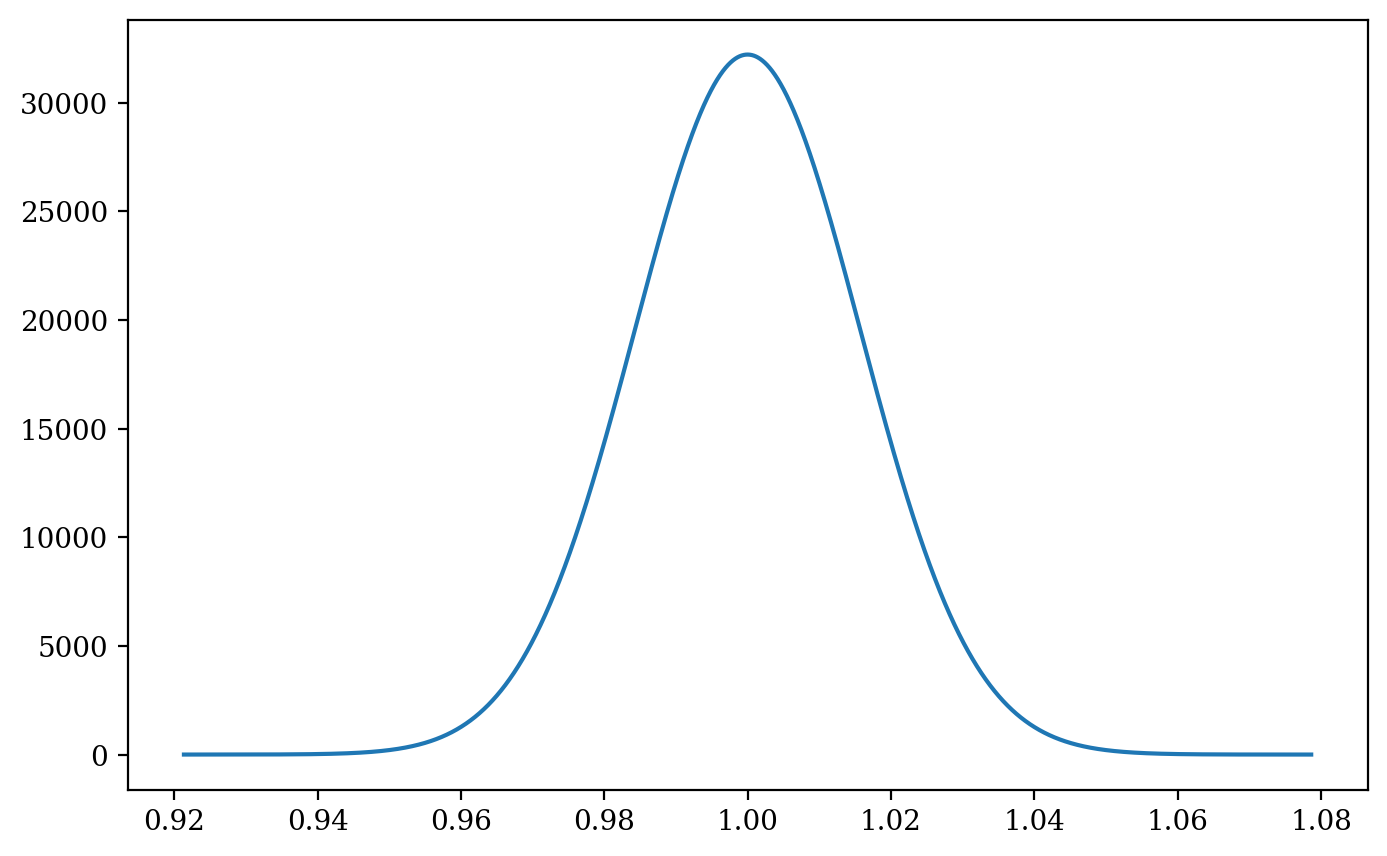

In [29]:
tbtest = np.arange(tBraggCenter-5*tBraggPi,tBraggCenter+5*tBraggPi,dt)
plt.plot(tbtest, V(tbtest))

In [30]:
np.trapz(V(tbtest),tbtest)

1270.1552717924328

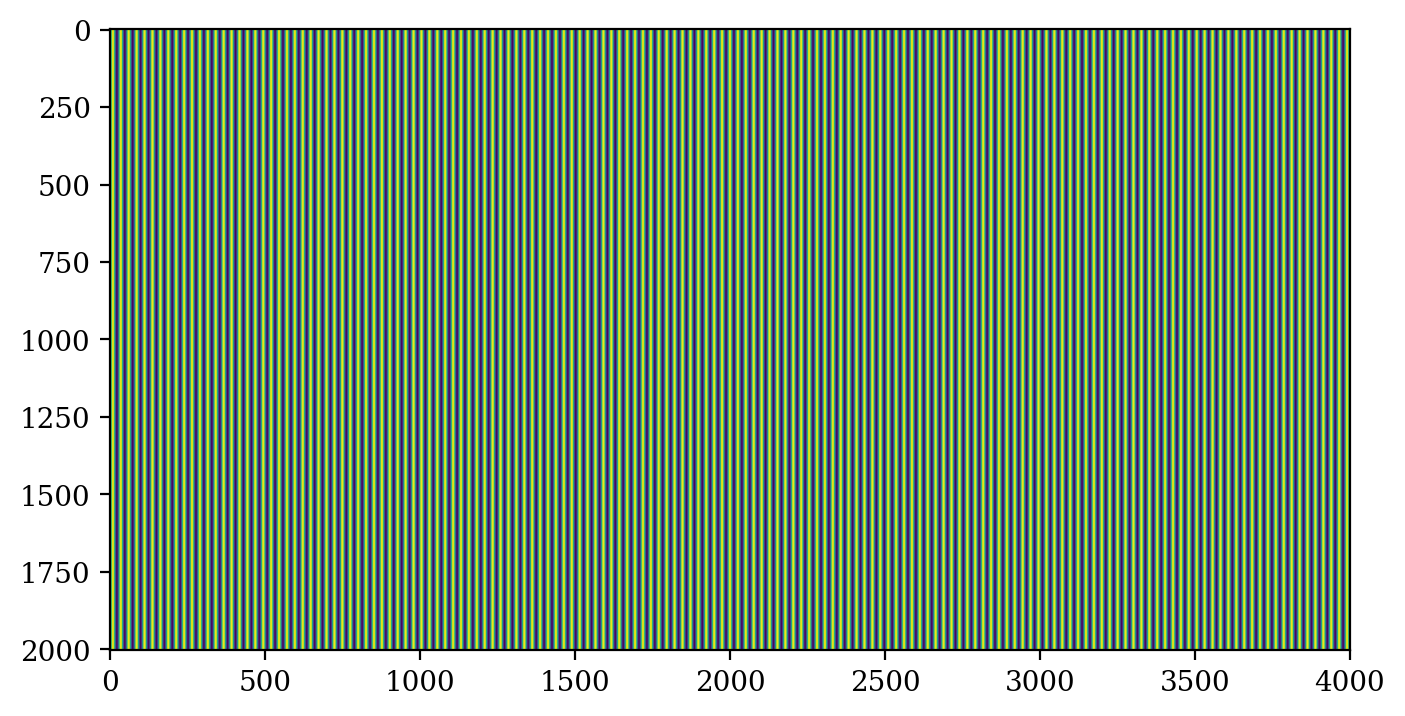

In [31]:
# vtest = np.cos(2*k*xlin)
plt.imshow(cosGrid.T)
plt.show()

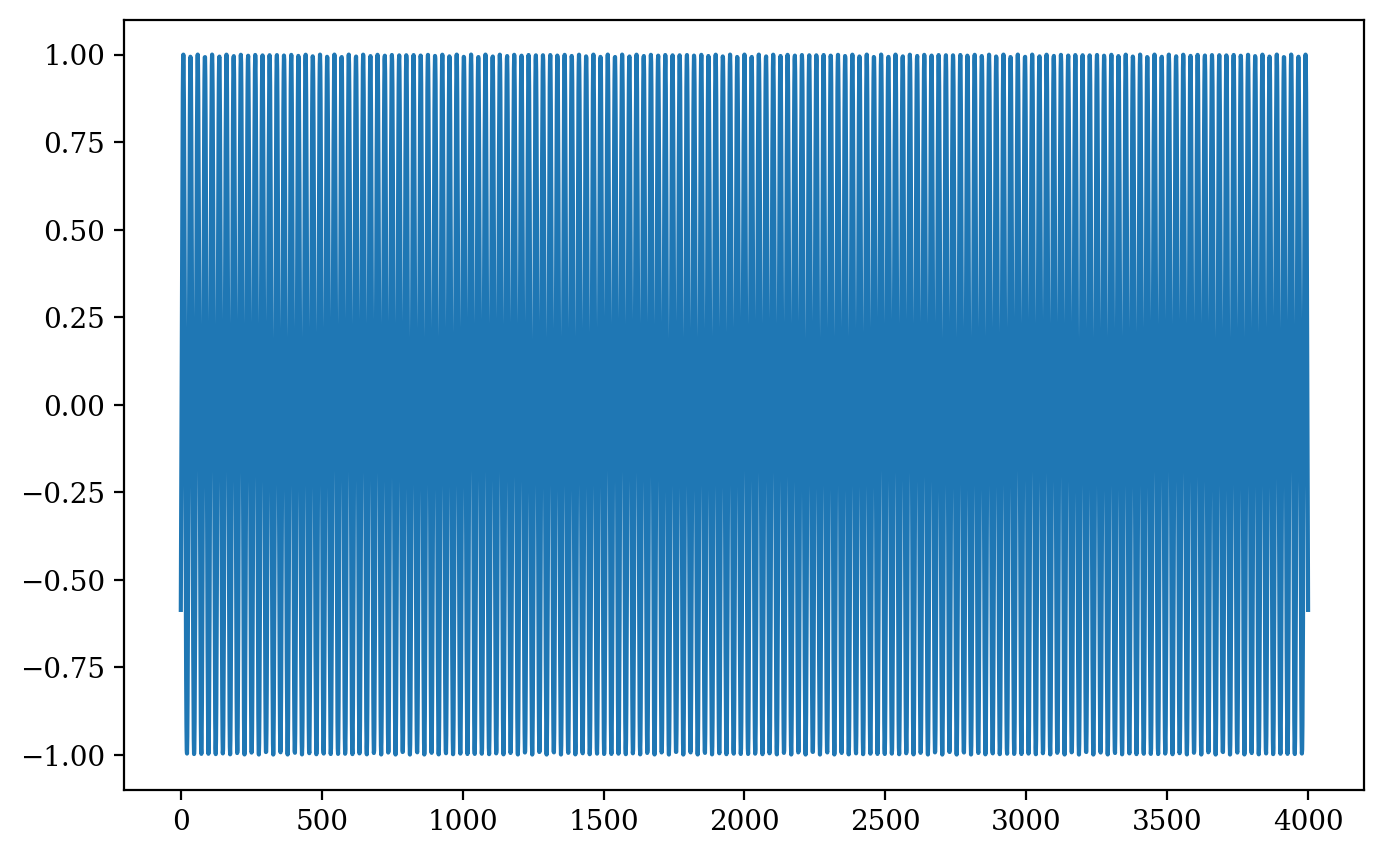

In [32]:
plt.plot(cosGrid[:,0])

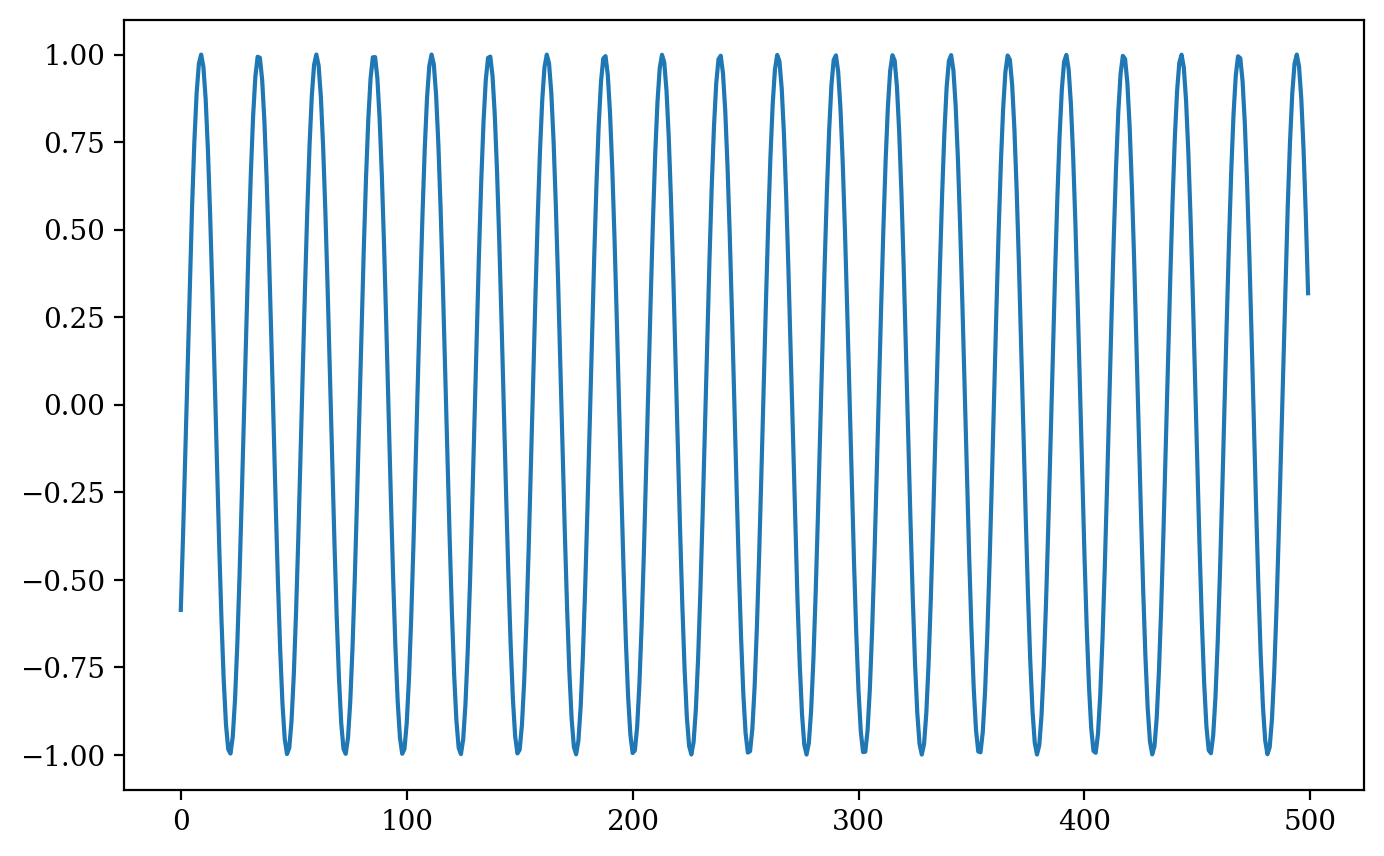

In [33]:
plt.plot(cosGrid[:500,0])

#### Initial State

In [34]:
def plot_psi(psi):
    plt.figure(figsize=(12,6))
    extent = np.array([-xmax,+xmax,-zmax,+zmax])
    plt.subplot(1,3,1)
    plt.imshow(np.abs(psi.T)**2,extent=extent)
    plt.ylabel("$z$ (µm)")
    plt.subplot(1,3,2)
    plt.imshow(np.real(psi.T),extent=extent)
    plt.subplot(1,3,3)
    plt.imshow(np.imag(psi.T),extent=extent)
    plt.show()

In [195]:
def plot_mom(psi):
    plt.figure(figsize=(11,3))
    pspace = np.fft.fftfreq(nx)
    extent = np.array([-pxmax,+pxmax,-pzmax,+pzmax])
    psifft = np.fft.fftshift(np.fft.fft2(psi))
    psiAbsSq = np.abs(psifft)**2
    plotdata = np.flipud(psiAbsSq.T)
    
    plt.subplot(1,3,1)
    plt.imshow(plotdata,extent=extent) 
    plt.ylabel("$p_z$ (u*µm/ms)")
    
    plt.subplot(1,3,2)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/20)
    nz2 = int((nz-1)/20)
    plotdata = np.flipud(psiAbsSq[nxm-nx2:nxm+nx2,nzm-nz2:nzm+nz2].T)
    plt.imshow(plotdata,extent=extent*0.1) 
    
    plt.subplot(1,3,3)
#     nx3 = int((nx-1)/200)
#     nz3 = int((nz-1)/200)
#     plotdata = np.flipud(psiAbsSq[nxm-nx3:nxm+nx3,nzm-nz3:nzm+nz3].T)
#     plt.imshow(plotdata,extent=extent*0.01) 
# #     print(nx2,nz2,nx3,nz3)
    nxm = int((nx-1)/2)
    nzm = int((nz-1)/2)
    nx2 = int((nx-1)/7)
    nz2 = int((nz-1)/7)
    
    plt.plot(pxlin[nxm-nx2:nxm+nx2], np.trapz(psiAbsSq,axis=1)[nxm-nx2:nxm+nx2])
    plt.axvline(x=+2*k*hb,color='r',alpha=0.2)
    plt.axvline(x=-2*k*hb,color='r',alpha=0.2)
    plt.axvline(x=+4*k*hb,color='r',alpha=0.2)
    plt.axvline(x=-4*k*hb,color='r',alpha=0.2)
#     plt.xlabel("$p (u\cdot \mu m/ms)$")
#     plt.ylabel("$|\phi(p)|^2$")
    title = "Bragg Pulse"
    
#     plt.savefig("output/"+title+".pdf", dpi = 300) 
#     plt.savefig("output/"+title+".png", dpi = 300) 
#     plt.show()
    
    plt.show()

In [196]:
sg=0.2

def psi0(x,z,sx=sg,sz=sg,px=0,pz=0):
    return (1/np.sqrt(pi*sx*sz)) \
            * np.exp(-0.5*x**2/sx**2) \
            * np.exp(-0.5*z**2/sz**2) \
            * np.exp(+(1j/hb)*(px*x + pz*z))

In [197]:
V00 = 100000
# dt=0.01
VxExpGrid = np.exp(-(1j/hb) * 0.5*dt * V00 * cosGrid )
dpx = 2*pi/(2*xmax)*hb
dpz = 2*pi/(2*zmax)*hb
pxlin = np.linspace(-pxmax,+pxmax,nx)
pzlin = np.linspace(-pzmax,+pzmax,nz)

expPGrid = np.zeros((nx,nz),dtype=complex)
for indx in range(nx):
    expPGrid[indx, :] = np.exp(-(1j/hb) * (0.5/m4) * (dt) * (pxlin[indx]**2 + pzlin**2)) 
        

156.8326519365785
0.999999999999999 normalisation check


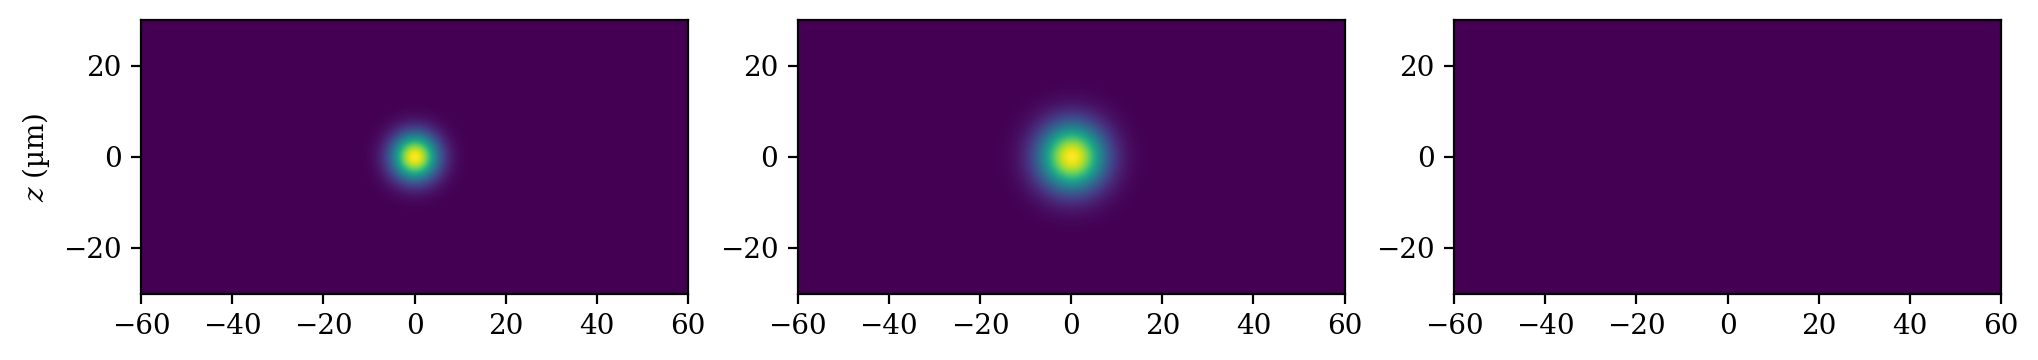

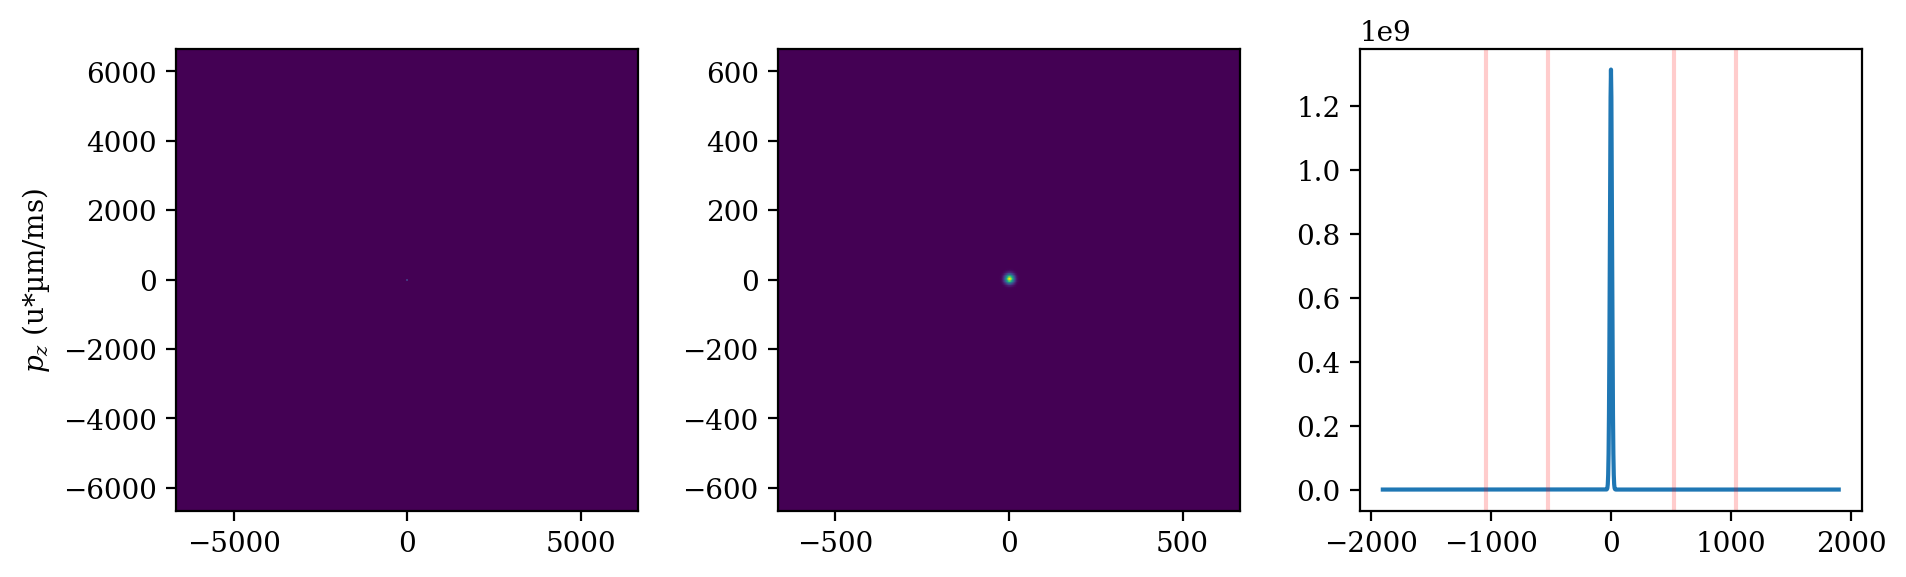

In [207]:
def psi0np(mux=10,muz=10,p0x=0,p0z=0):
    psi=np.zeros((nx,nz),dtype=complex)
    for ix in range(1,nx-1):
        x = xlin[ix]
        psi[ix][1:-1] = psi0(x,zlin[1:-1],mux,muz,p0x,p0z)
    return psi
psi = psi0np(5,5,0,0)
# psi = psi0np(1,1,0,0)
phiUN = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))
superWeirdNormalisationFactorSq = np.trapz(np.trapz(np.abs(phiUN)**2, pxlin, axis=0), pzlin)
swmf = sqrt(superWeirdNormalisationFactorSq)

t = 0

print(swmf)
print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin), "normalisation check")
plot_psi(psi)
plot_mom(psi)

In [208]:
-(1j/hb) * 0.5*dt * V00

-0.007873048664888407j

In [209]:
sqrt(2*pi*hb)/(V00*2)

9.987883607793241e-05

In [210]:
2*pi*hb/(V00)

0.003990312758512997

In [211]:
2*pi*hb/(V00*2)

0.0019951563792564987

In [212]:
2*pi*hb/(V00*0.5)

0.007980625517025995

  0%|          | 0/300 [00:00<?, ?it/s]

time = 1.0 µs
1.0000000000000324 |psi|^2
0.9985017481269629 |phi|^2


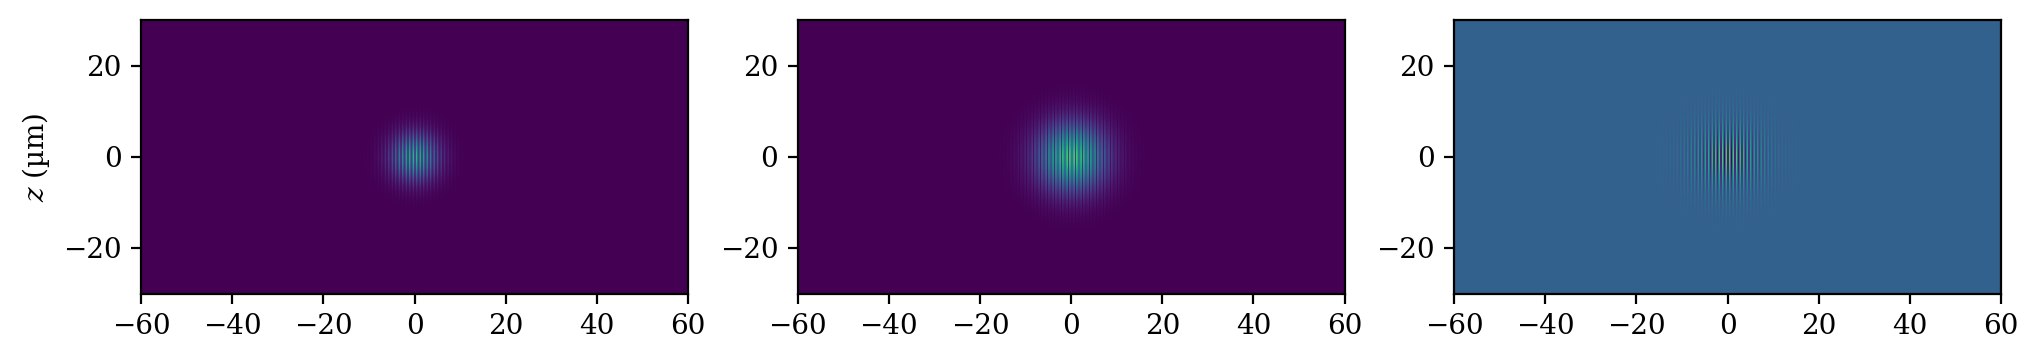

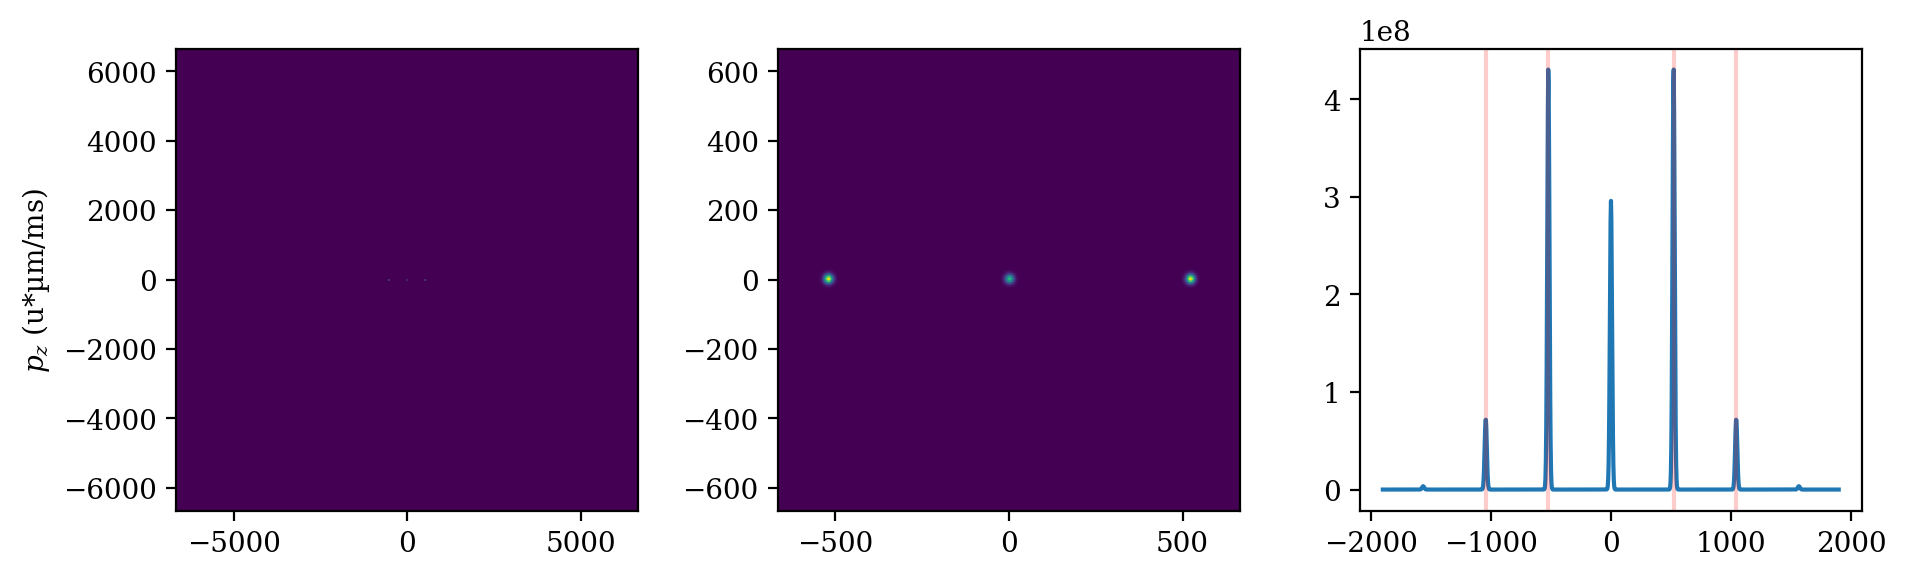

time = 1.01 µs
1.0000000000000324 |psi|^2
0.9985017481269644 |phi|^2


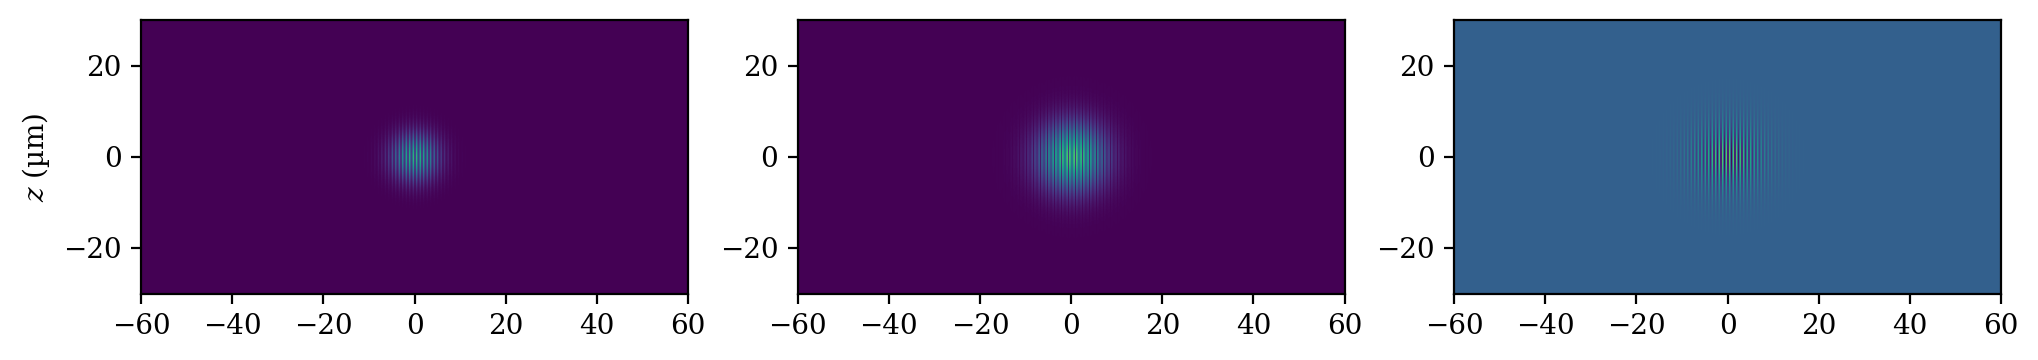

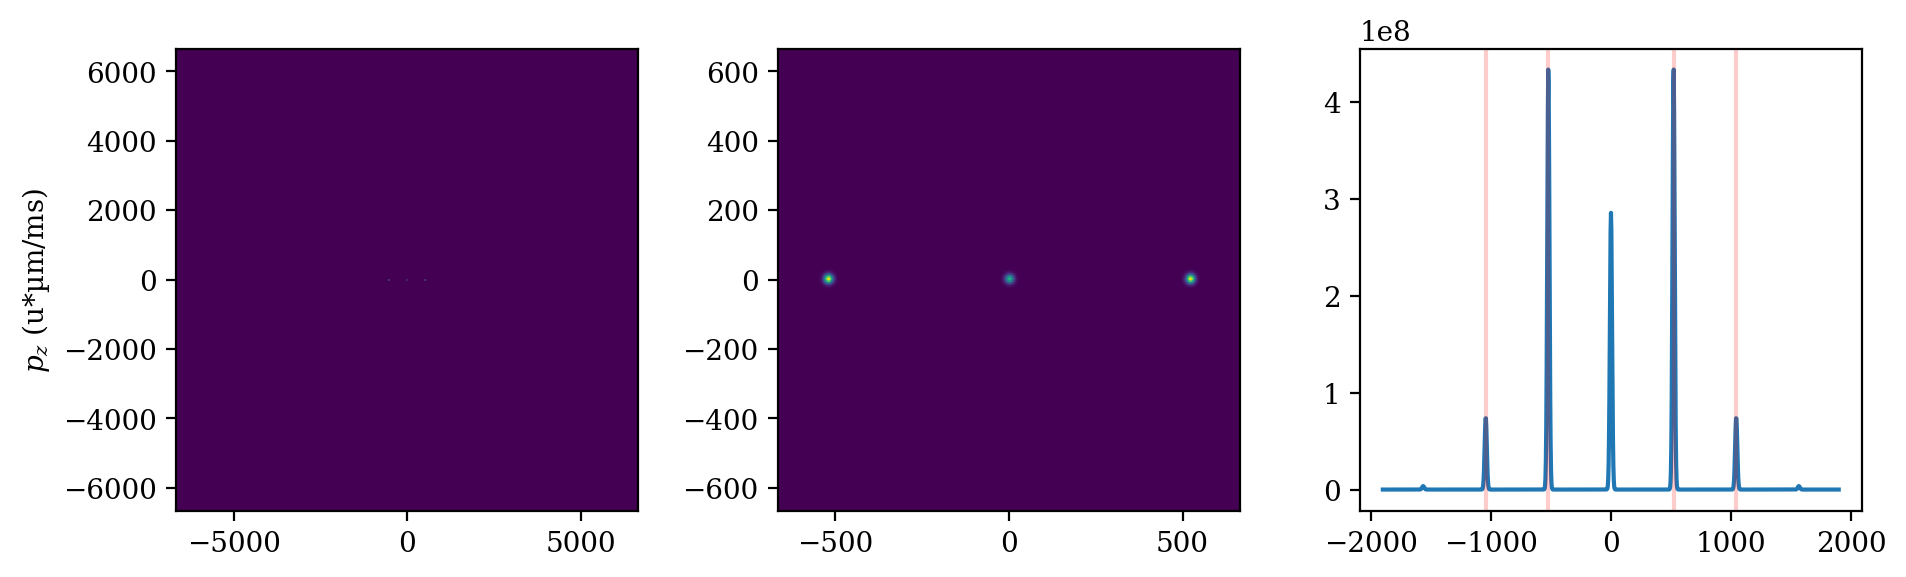

time = 1.02 µs
1.000000000000033 |psi|^2
0.9985017481269641 |phi|^2


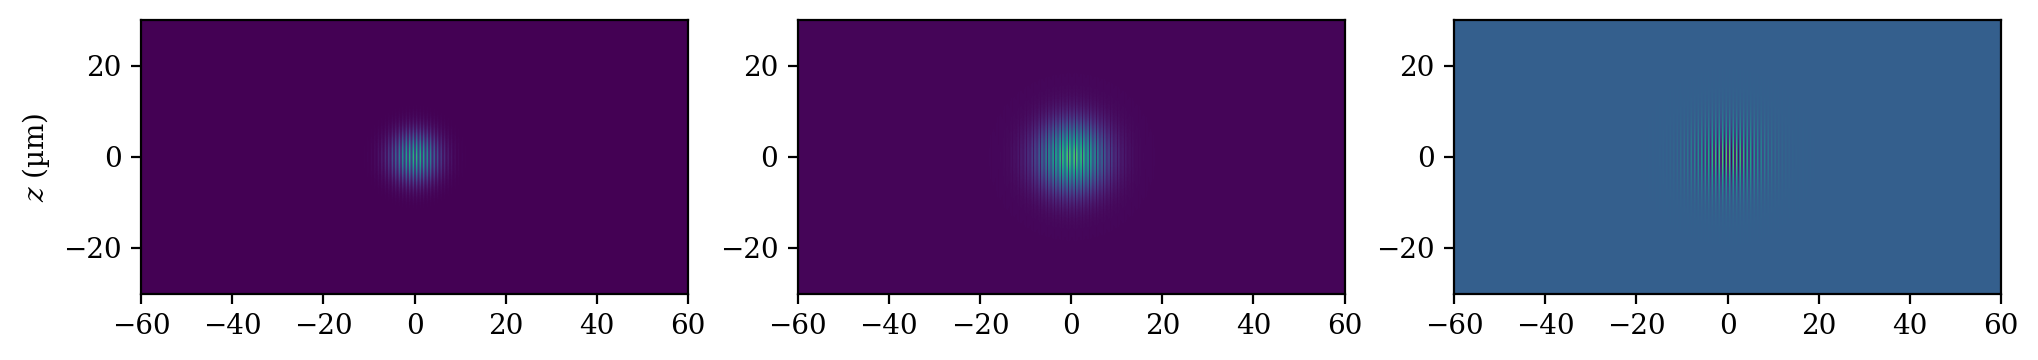

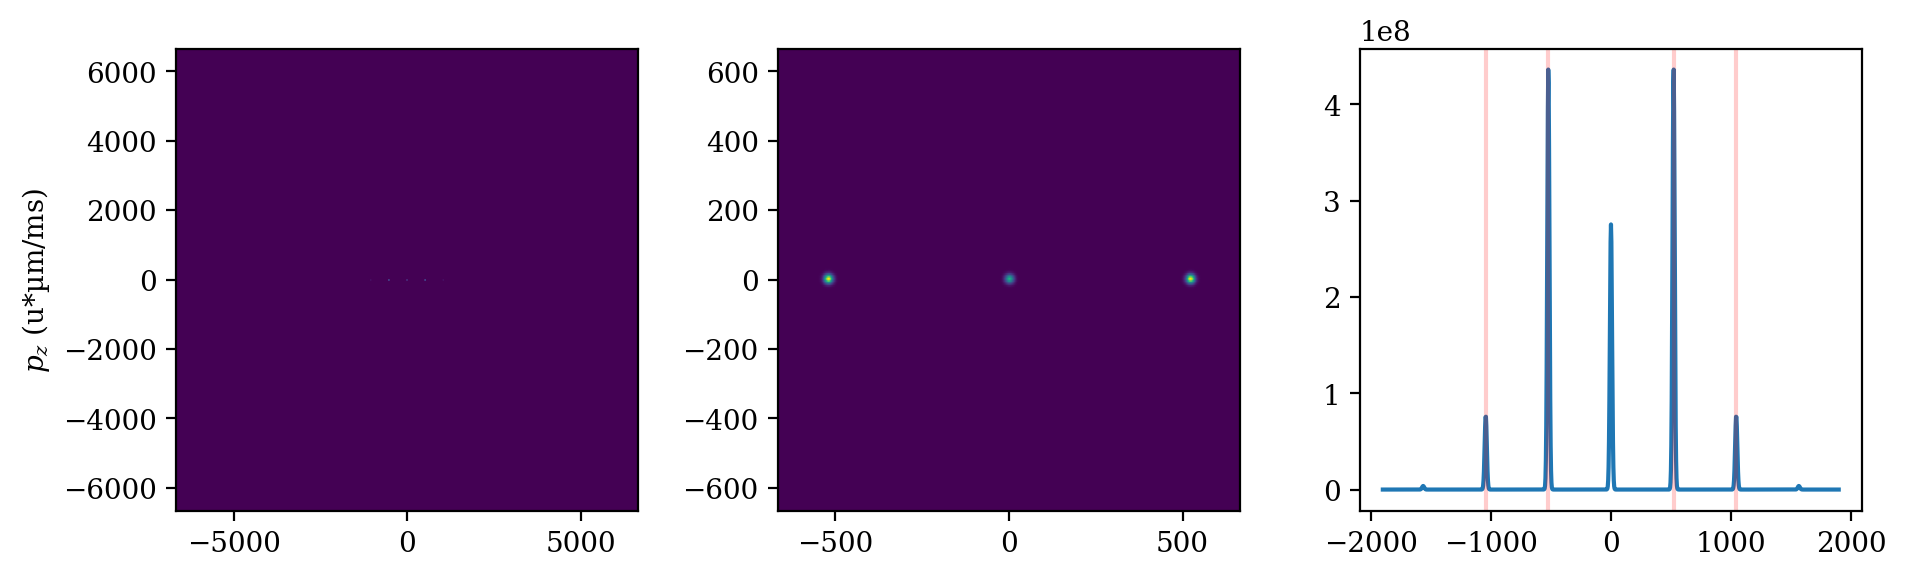

time = 1.03 µs
1.0000000000000333 |psi|^2
0.9985017481269647 |phi|^2


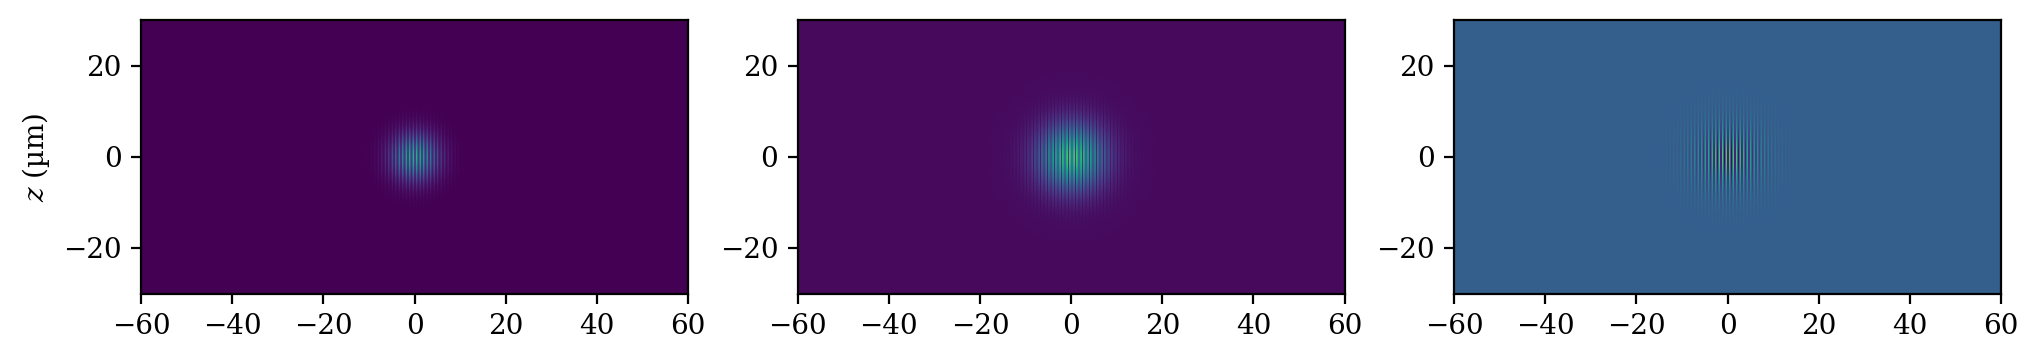

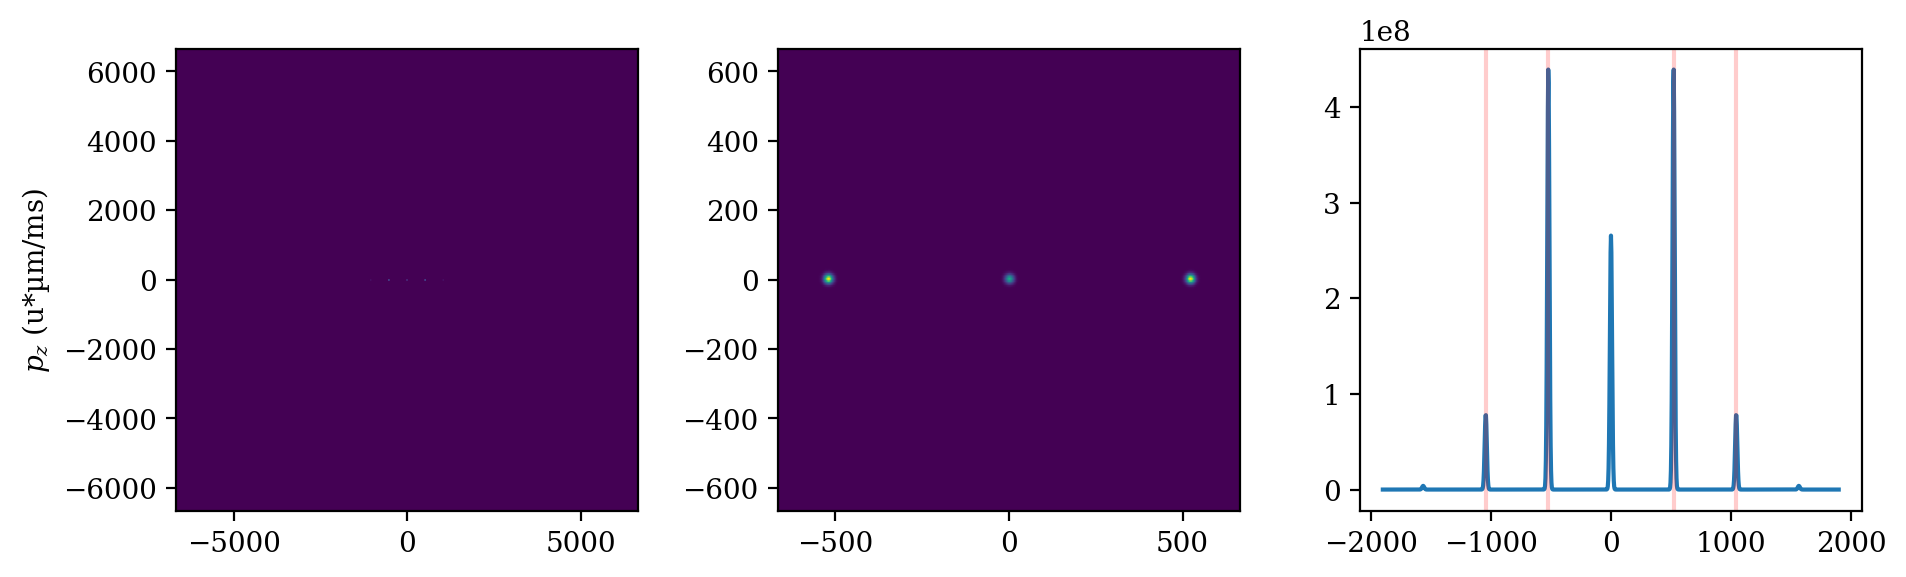

time = 1.04 µs
1.0000000000000333 |psi|^2
0.9985017481269638 |phi|^2


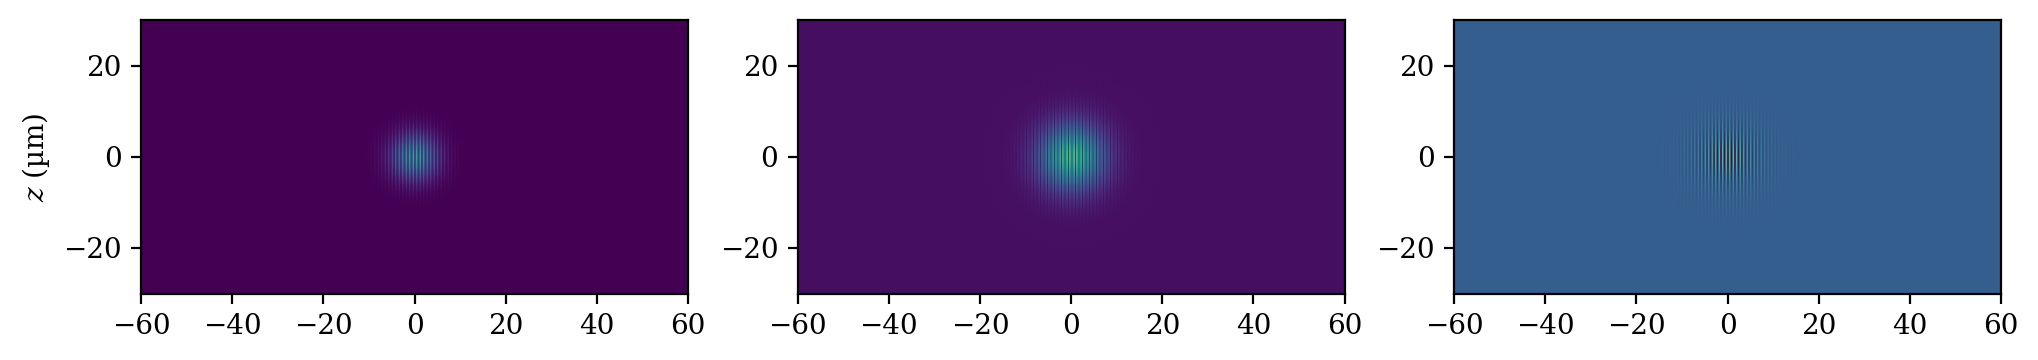

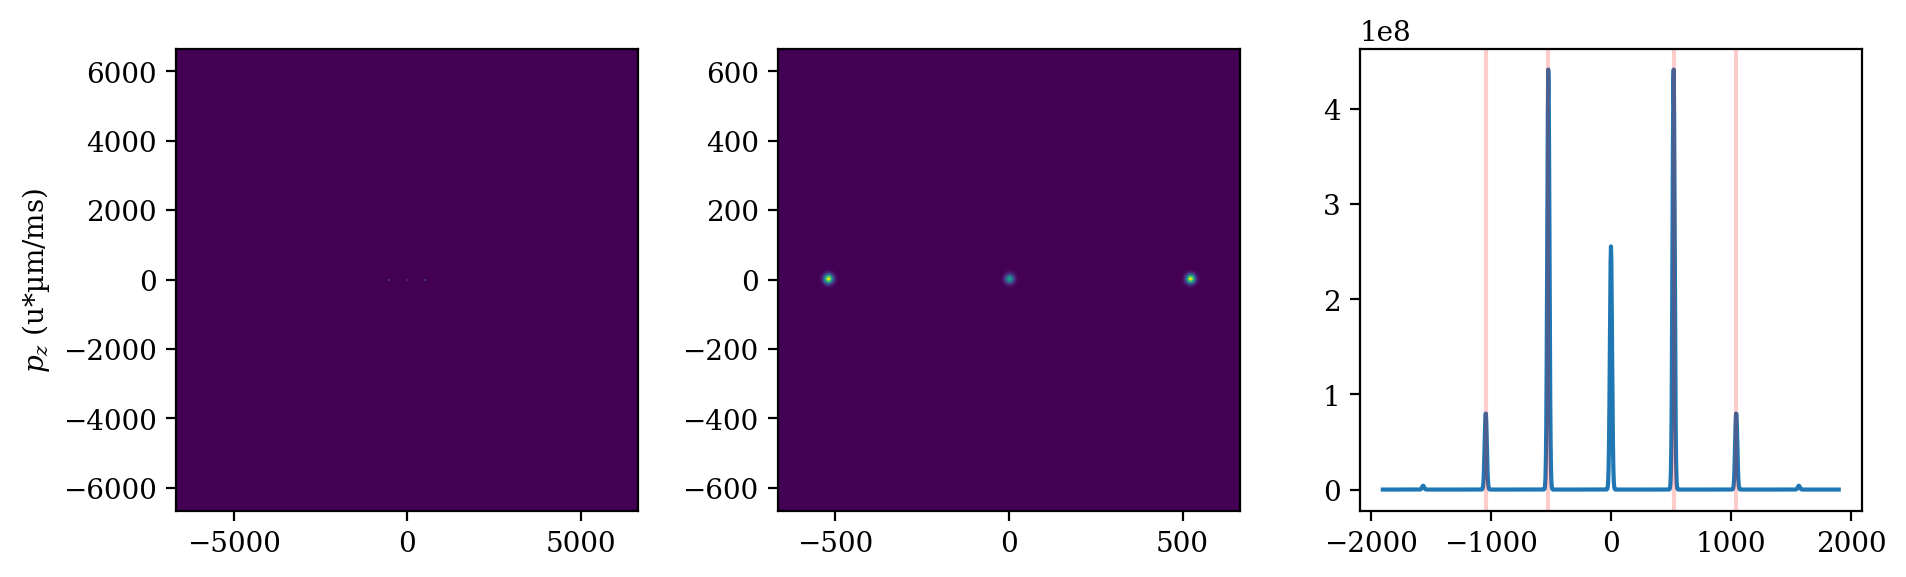

time = 1.05 µs
1.0000000000000335 |psi|^2
0.9985017481269656 |phi|^2


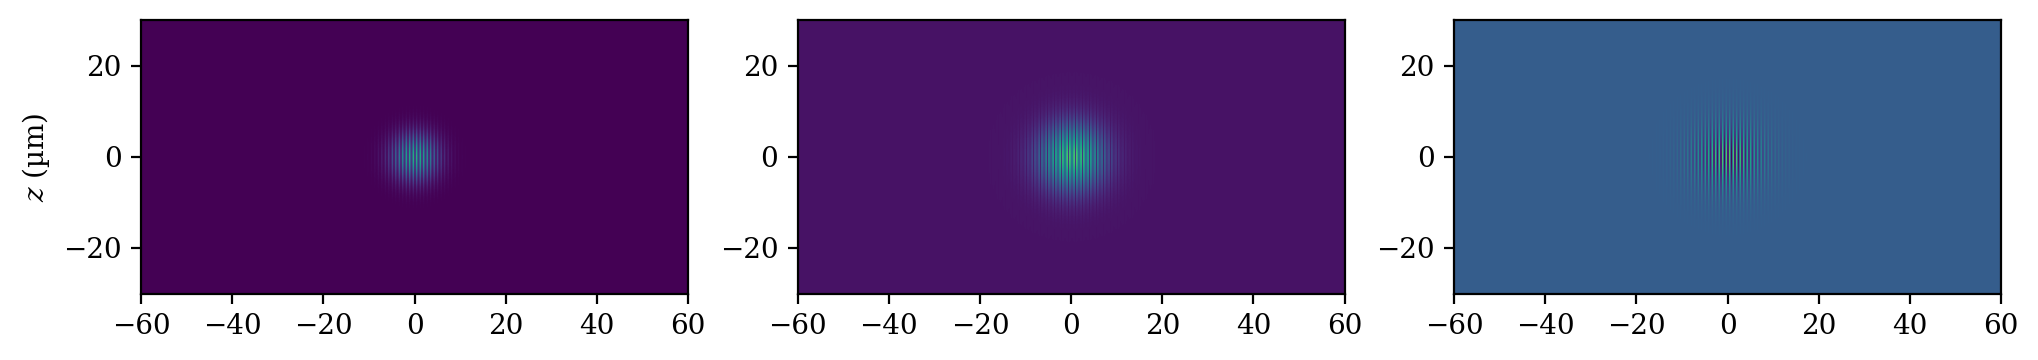

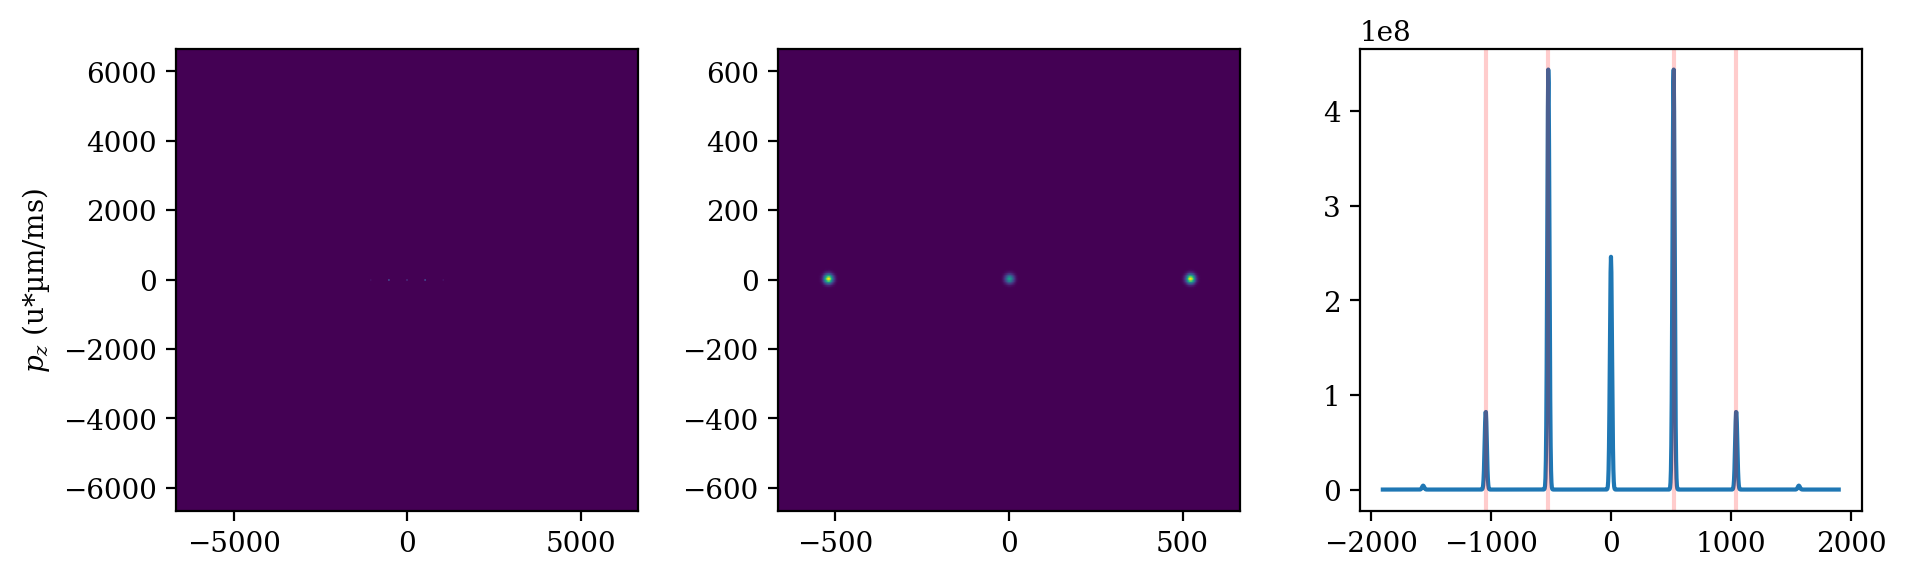

time = 1.06 µs
1.0000000000000342 |psi|^2
0.9985017481269649 |phi|^2


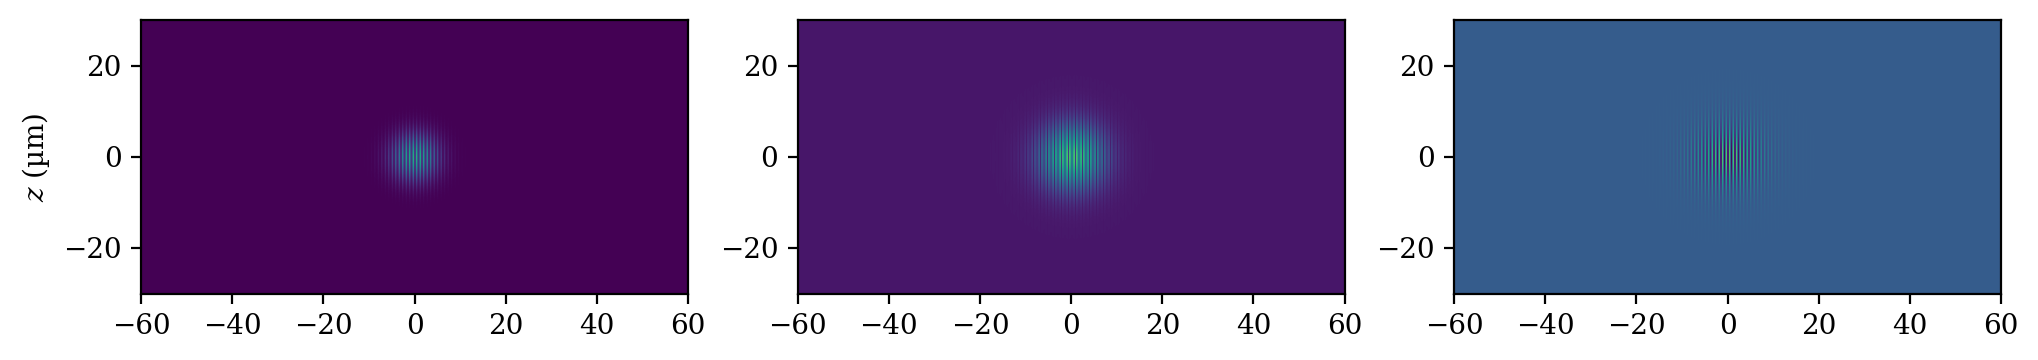

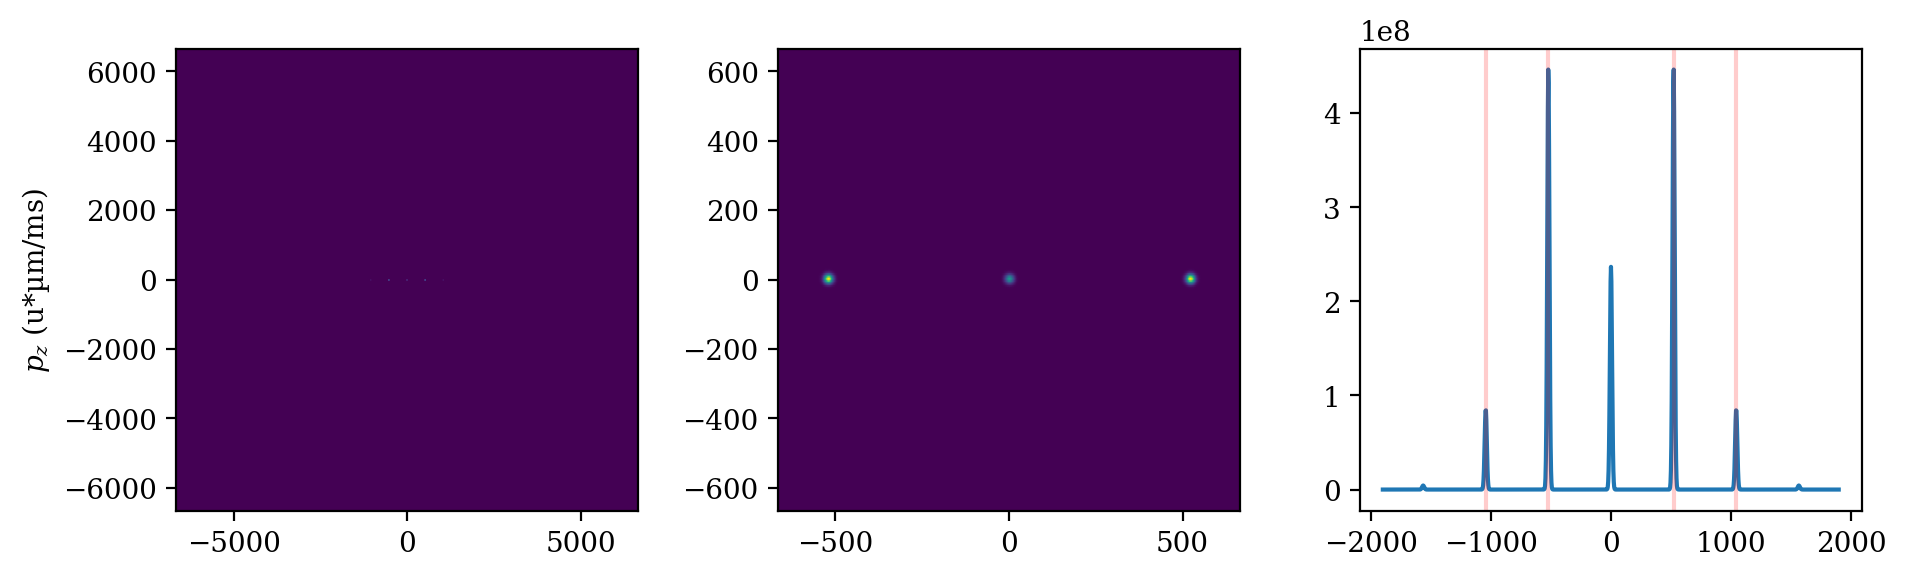

time = 1.07 µs
1.0000000000000342 |psi|^2
0.9985017481269655 |phi|^2


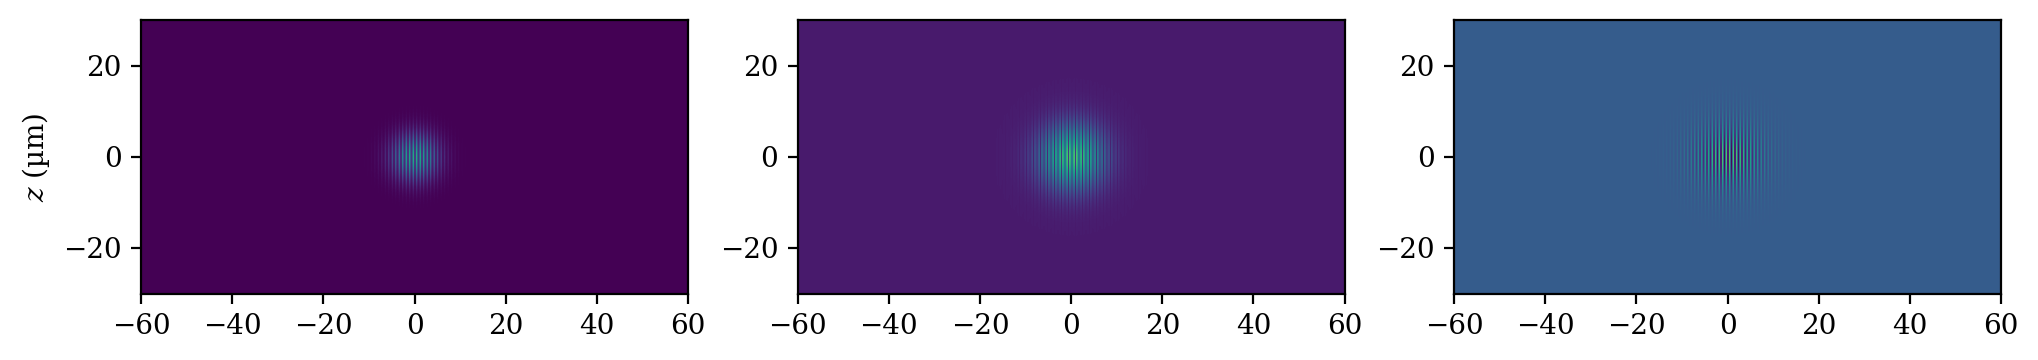

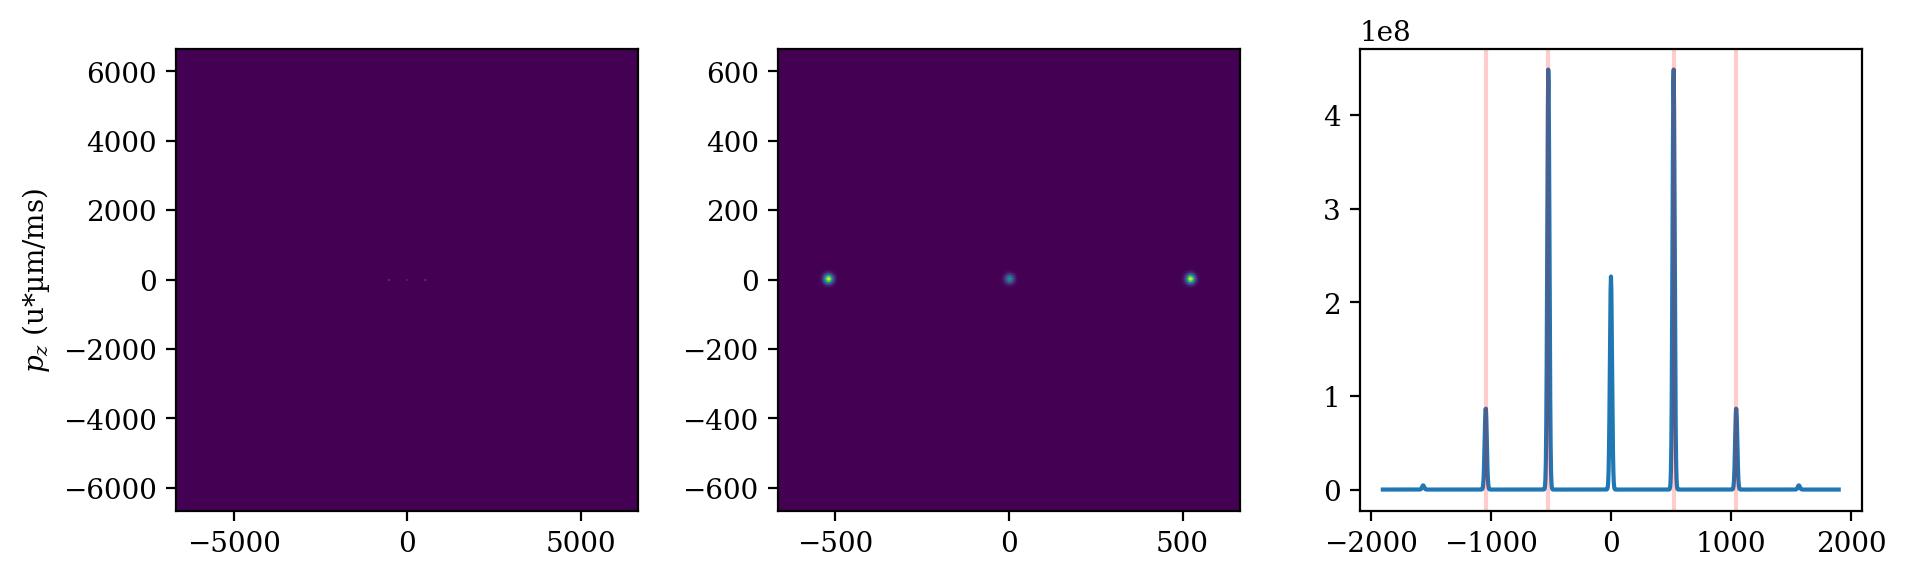

time = 1.08 µs
1.0000000000000346 |psi|^2
0.9985017481269652 |phi|^2


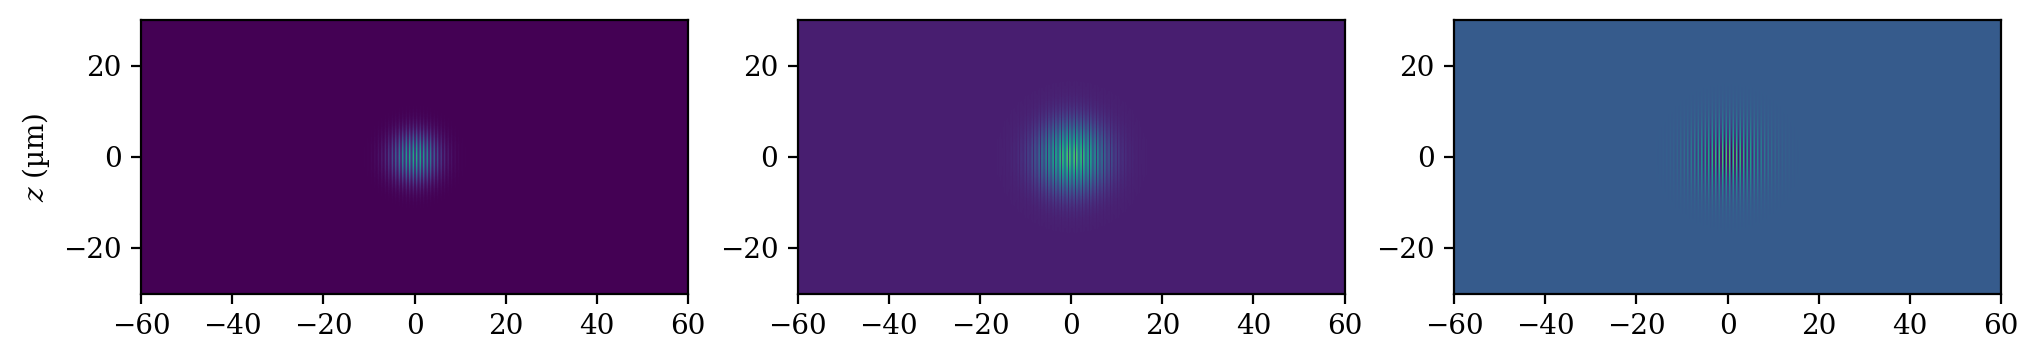

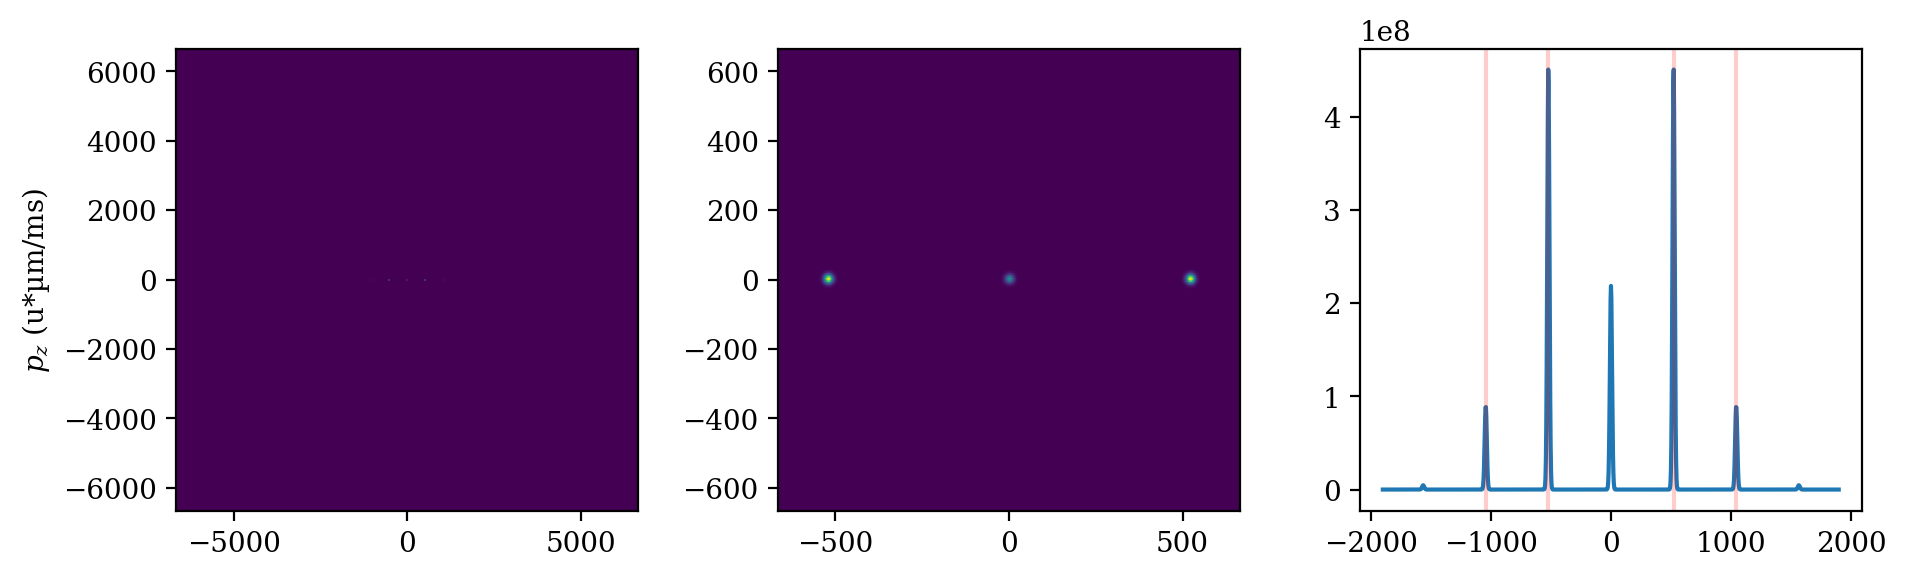

time = 1.09 µs
1.0000000000000349 |psi|^2
0.9985017481269661 |phi|^2


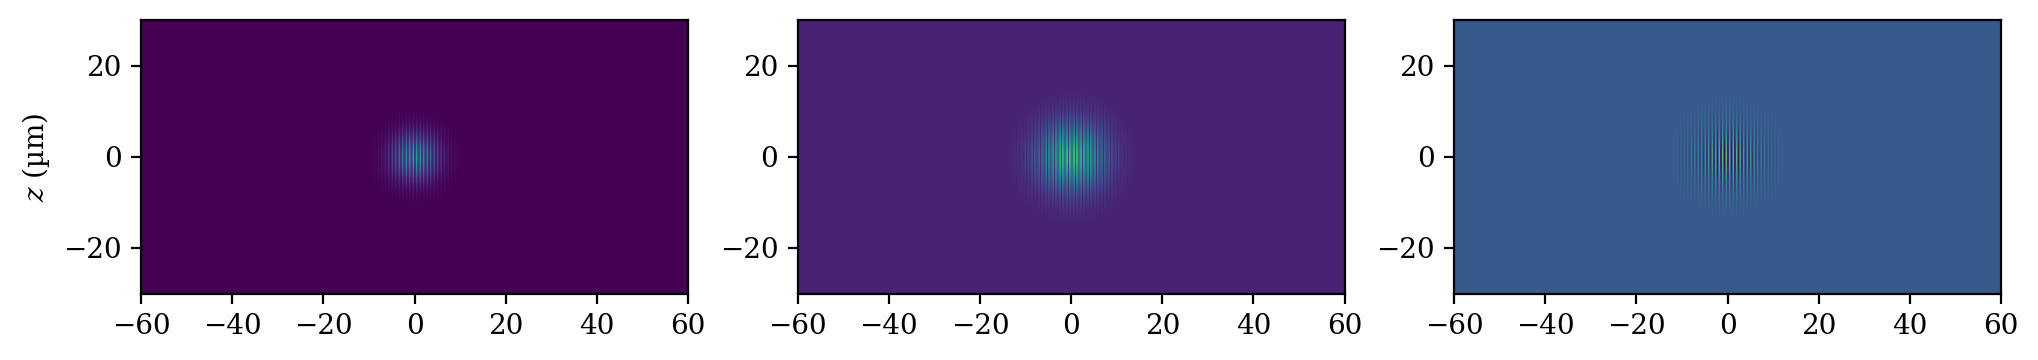

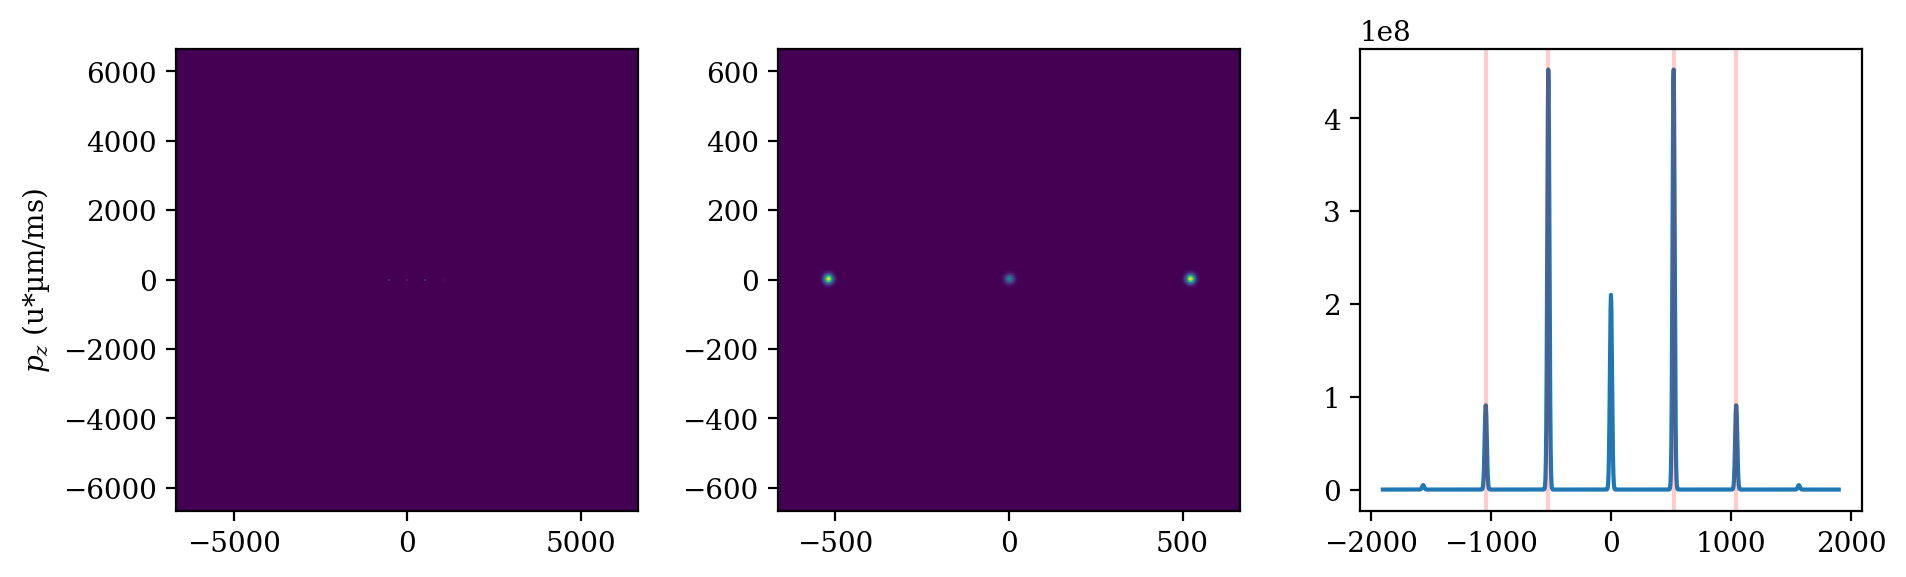

time = 1.1 µs
1.000000000000035 |psi|^2
0.9985017481269655 |phi|^2


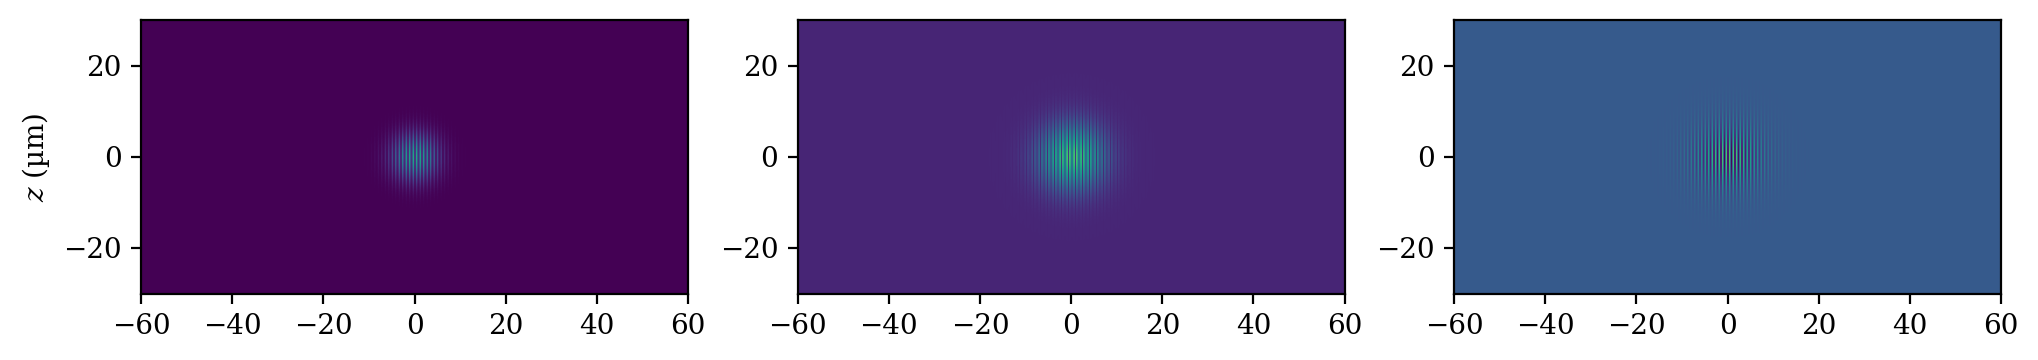

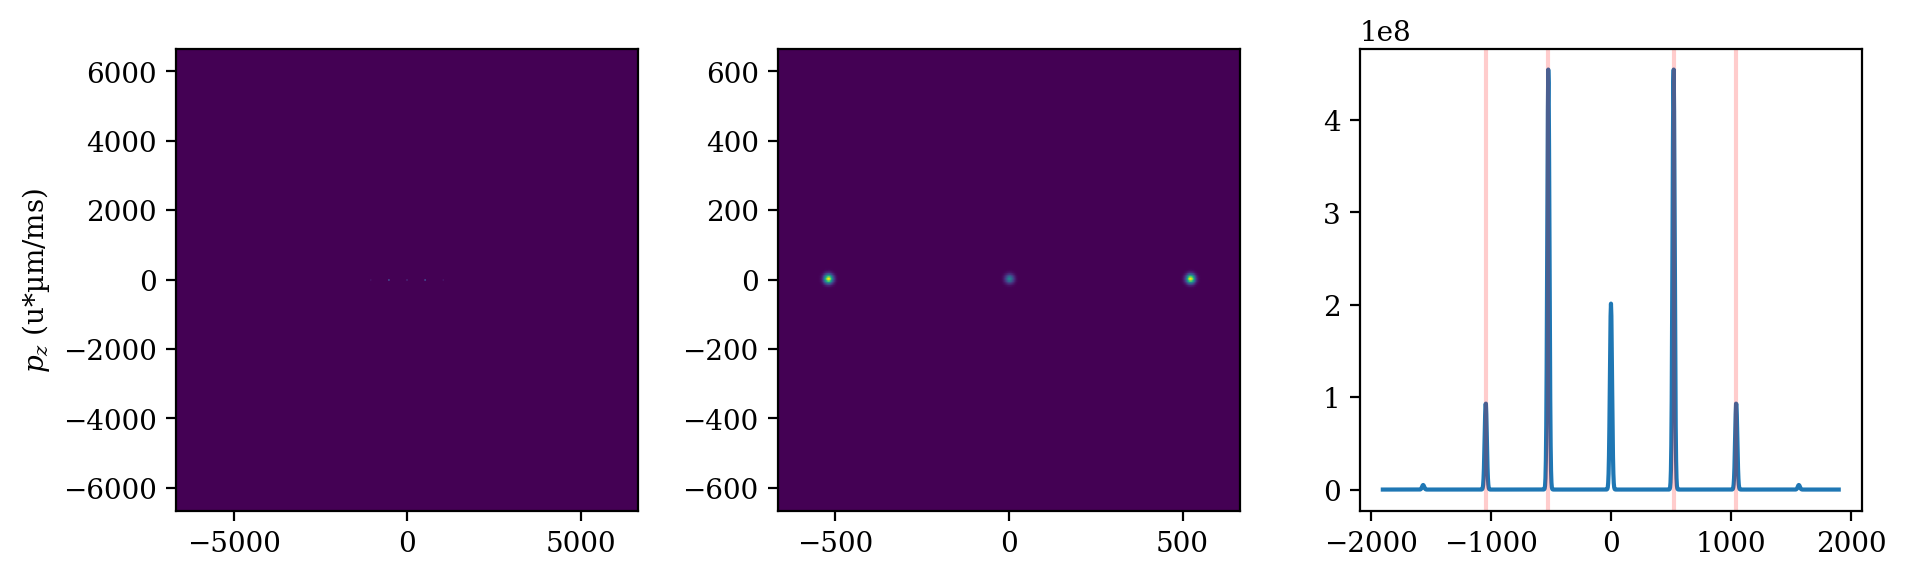

time = 1.11 µs
1.0000000000000353 |psi|^2
0.9985017481269675 |phi|^2


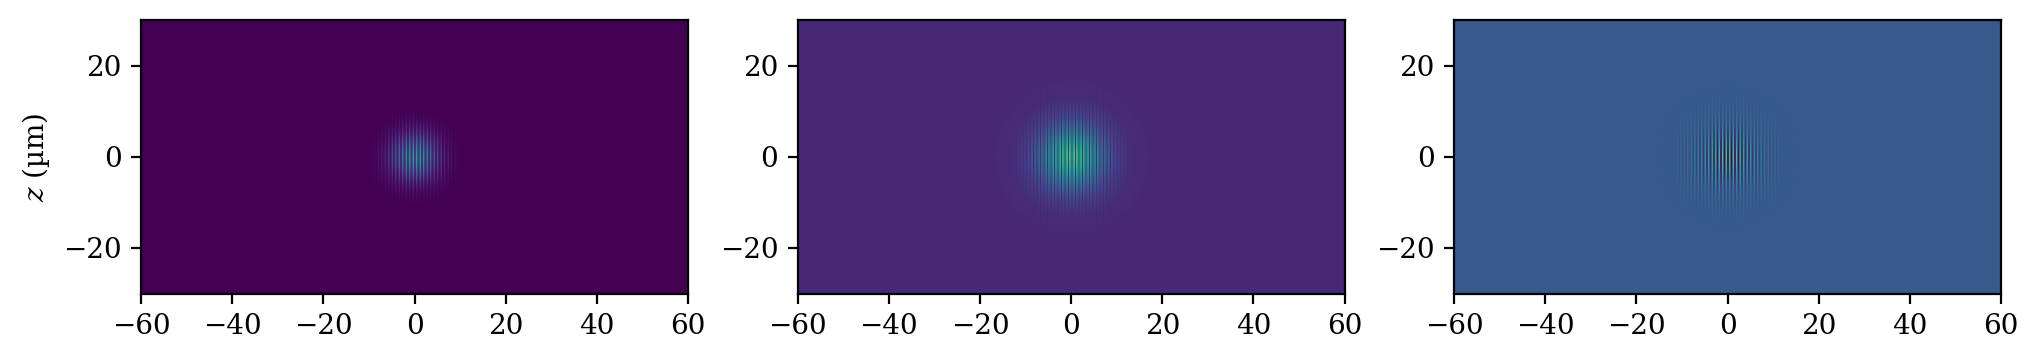

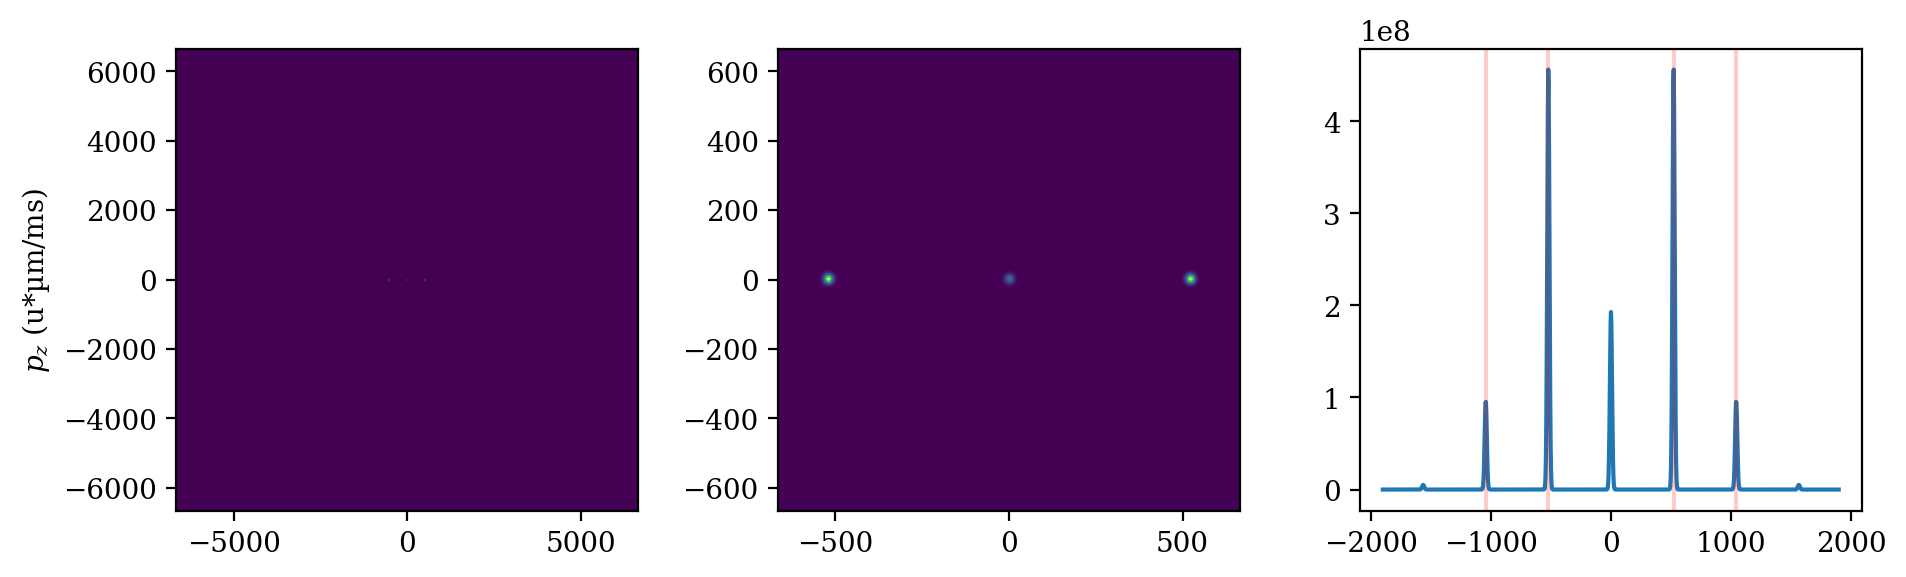

time = 1.12 µs
1.0000000000000355 |psi|^2
0.9985017481269667 |phi|^2


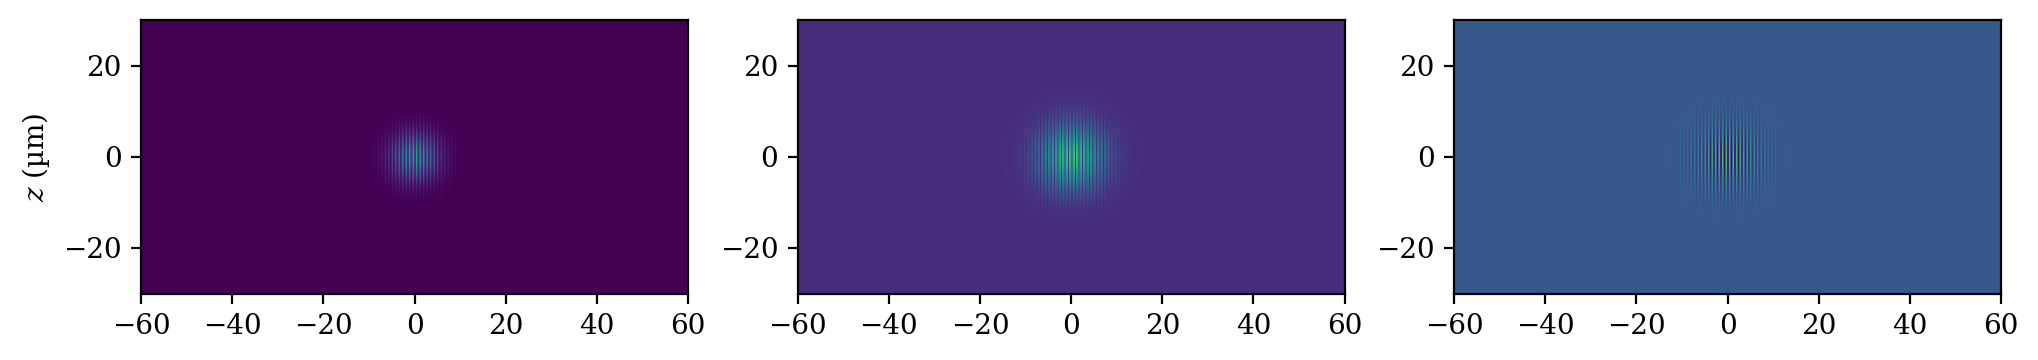

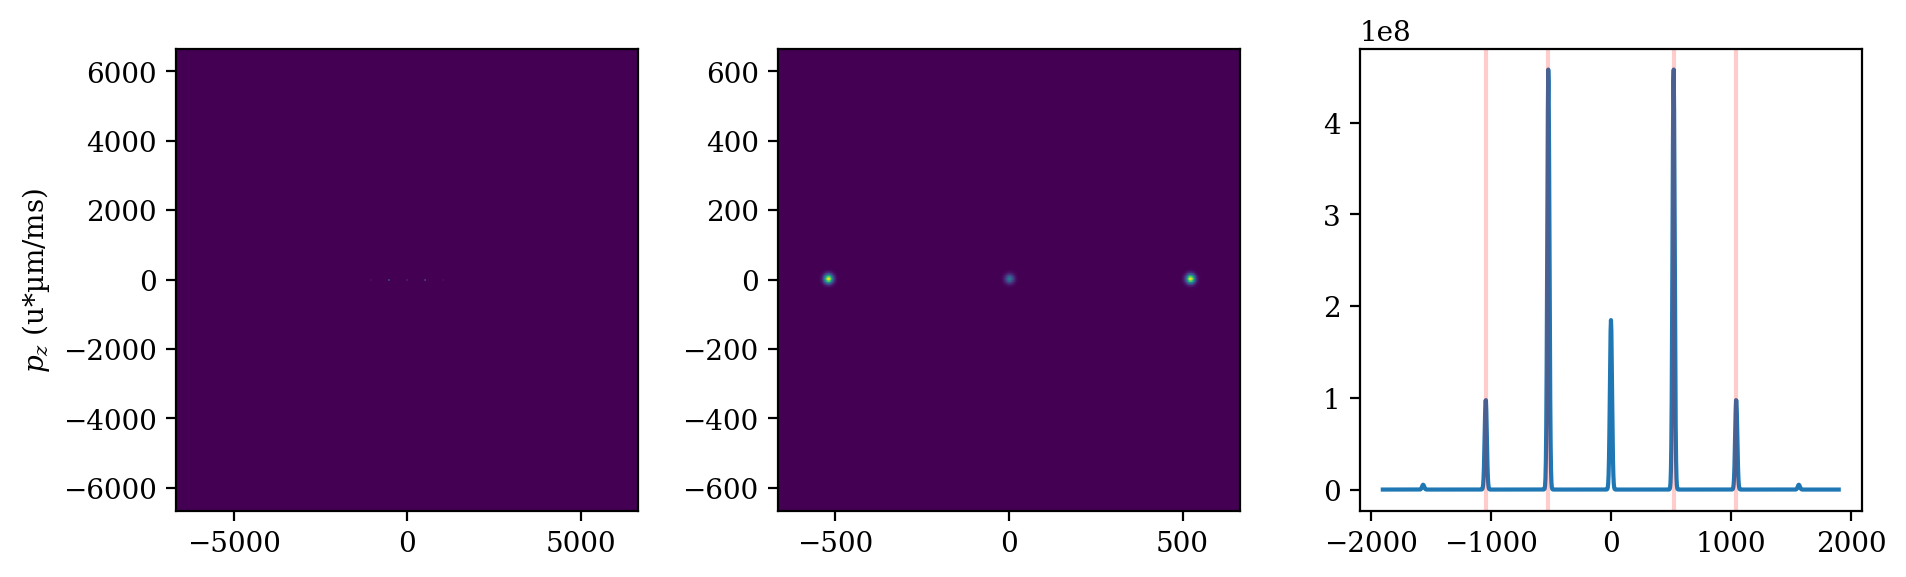

time = 1.13 µs
1.000000000000036 |psi|^2
0.9985017481269686 |phi|^2


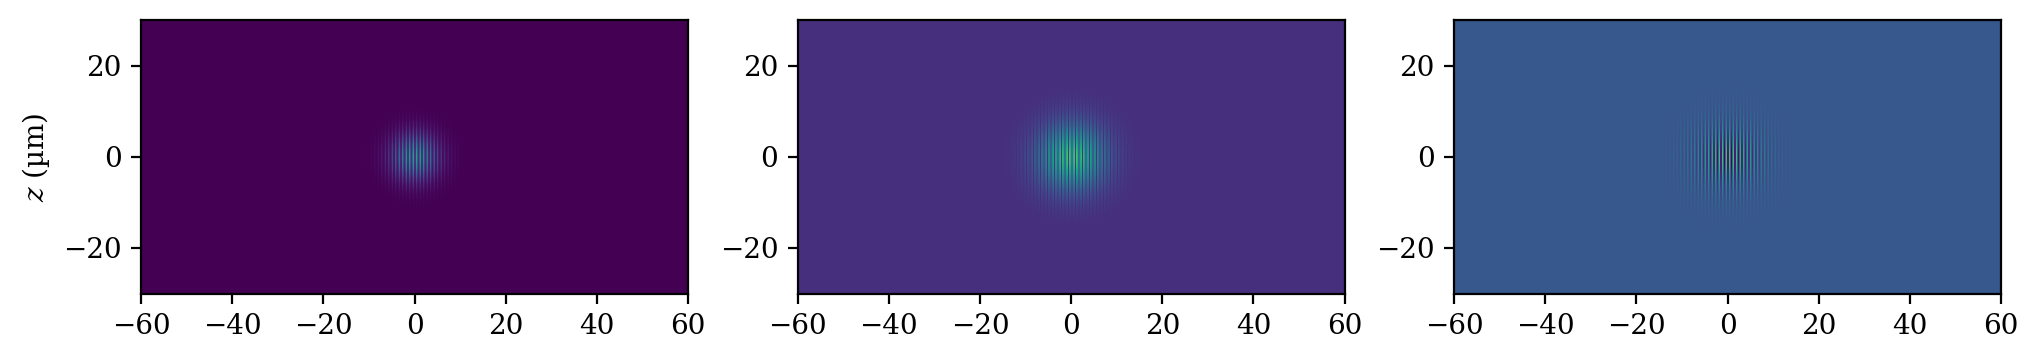

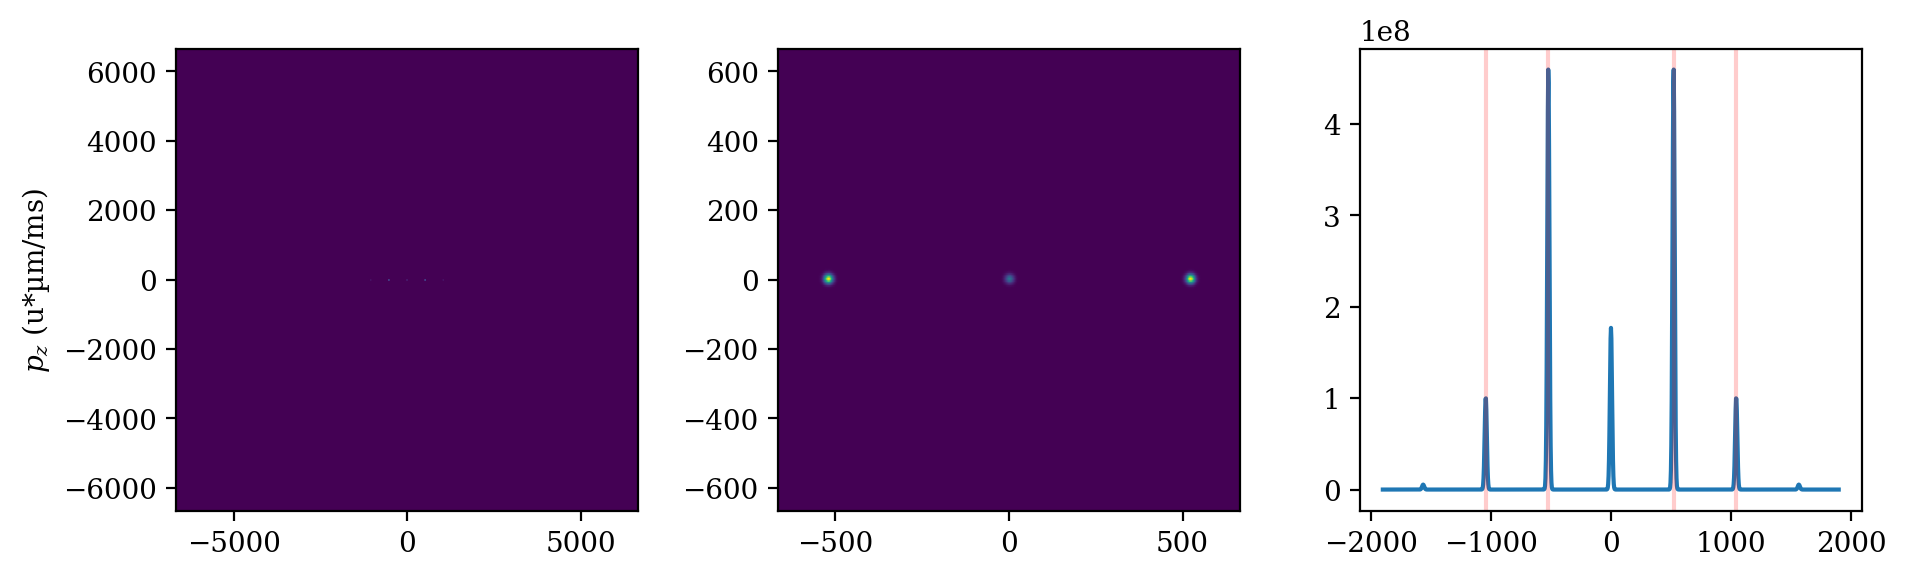

time = 1.14 µs
1.000000000000036 |psi|^2
0.9985017481269683 |phi|^2


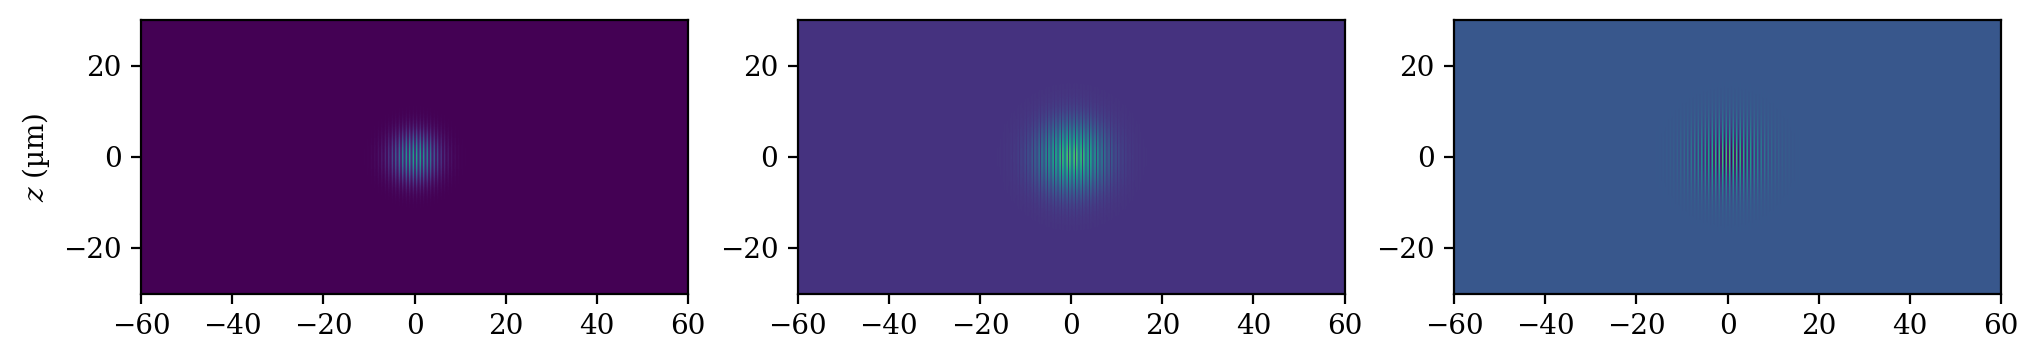

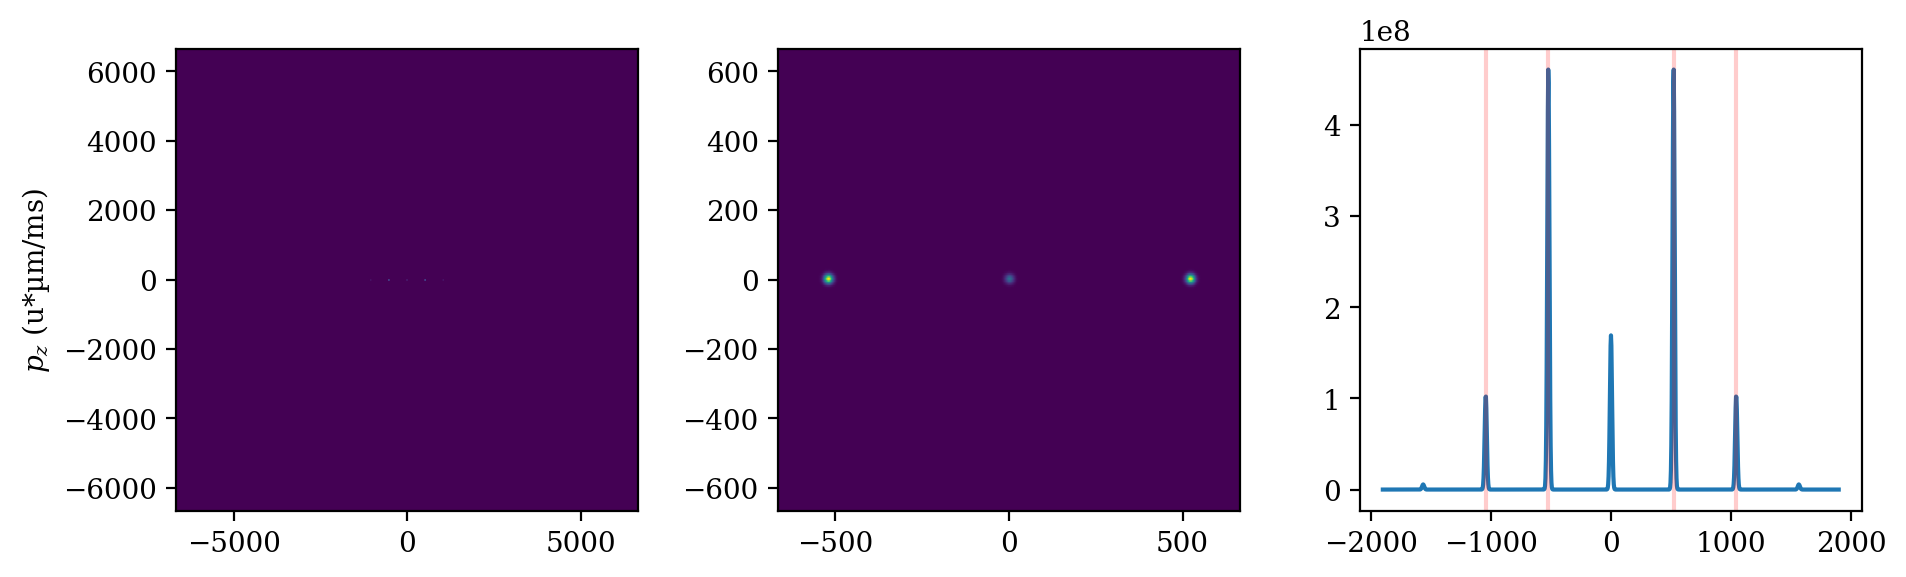

time = 1.15 µs
1.0000000000000362 |psi|^2
0.9985017481269689 |phi|^2


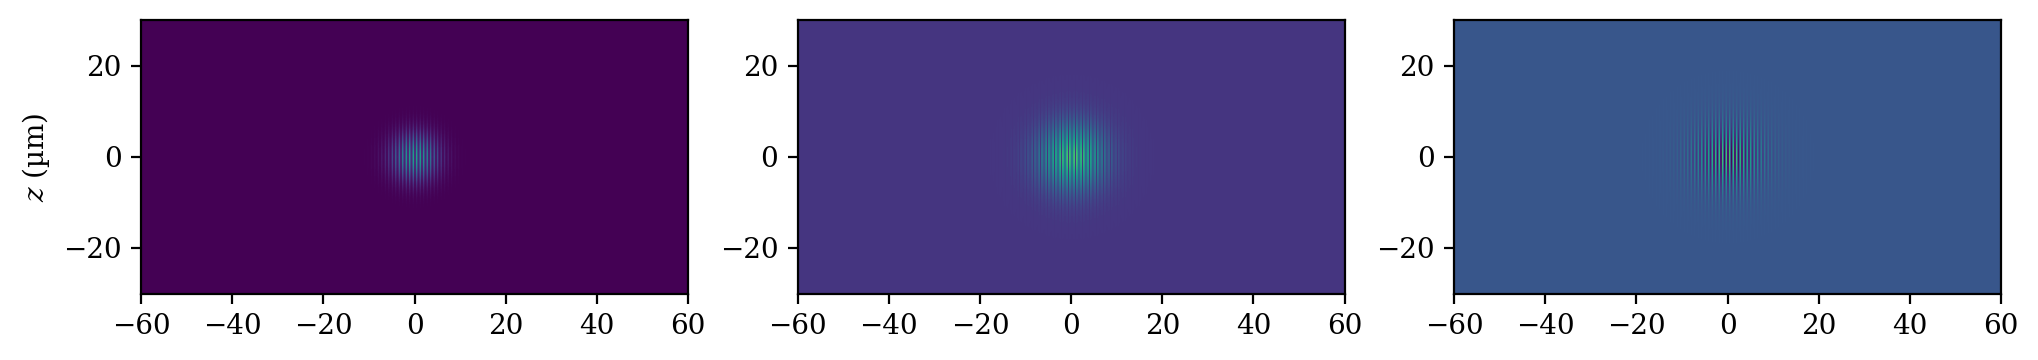

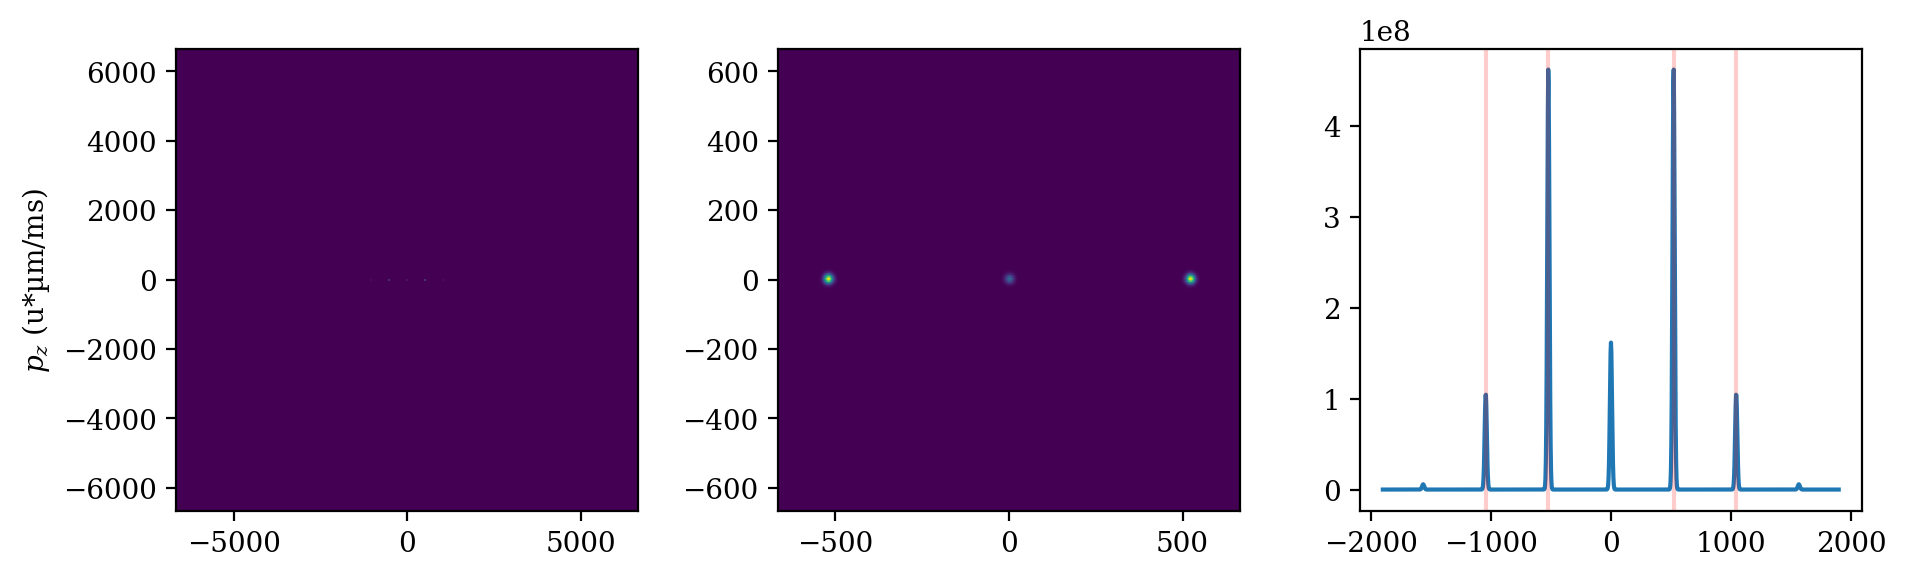

time = 1.16 µs
1.0000000000000369 |psi|^2
0.9985017481269691 |phi|^2


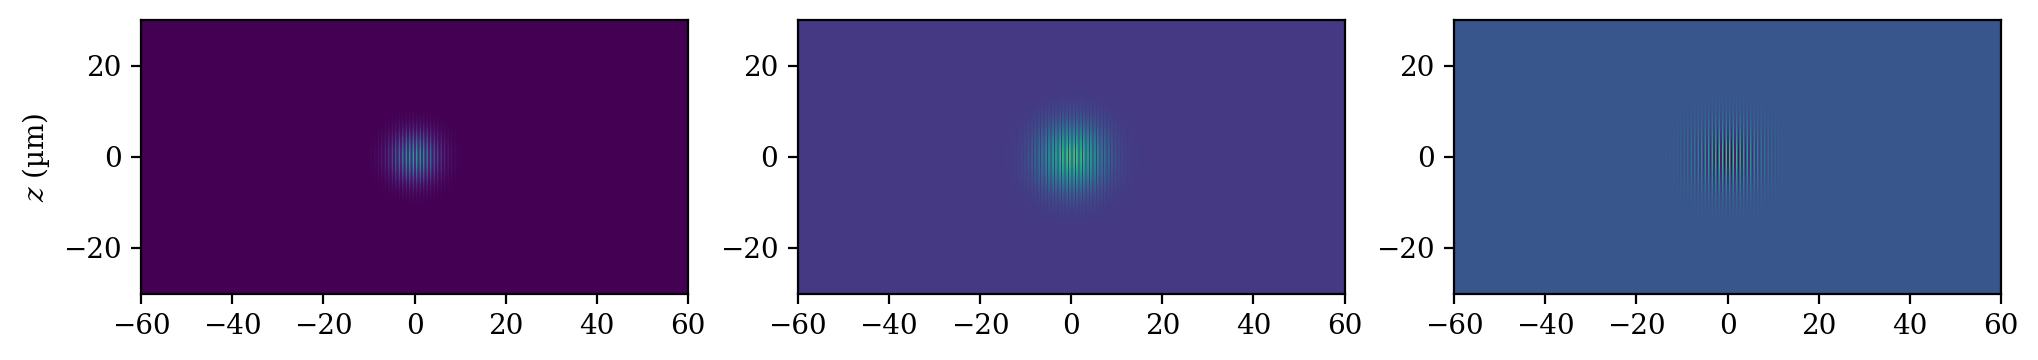

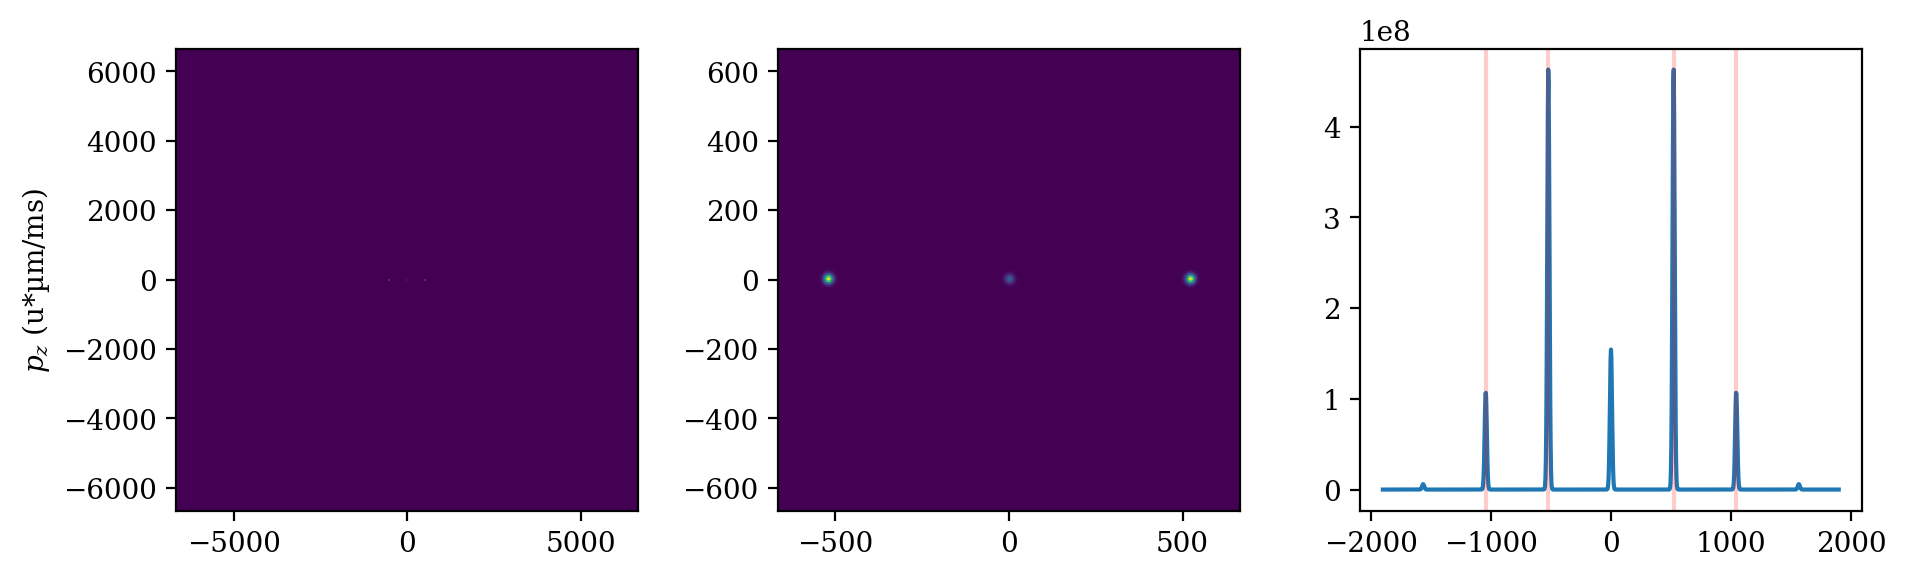

time = 1.17 µs
1.0000000000000369 |psi|^2
0.9985017481269691 |phi|^2


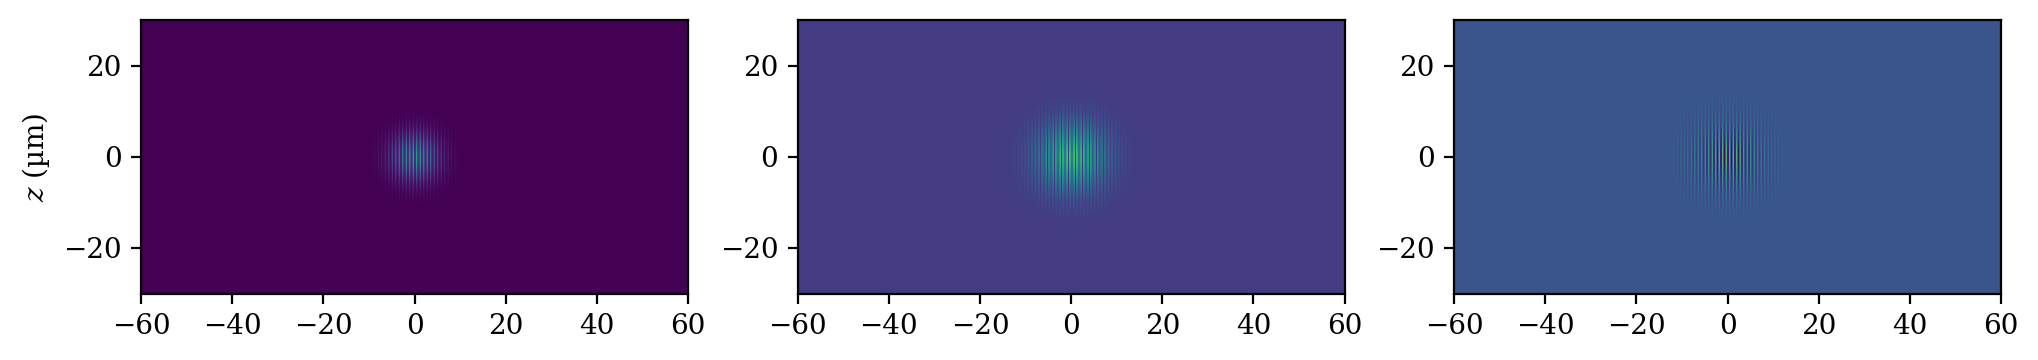

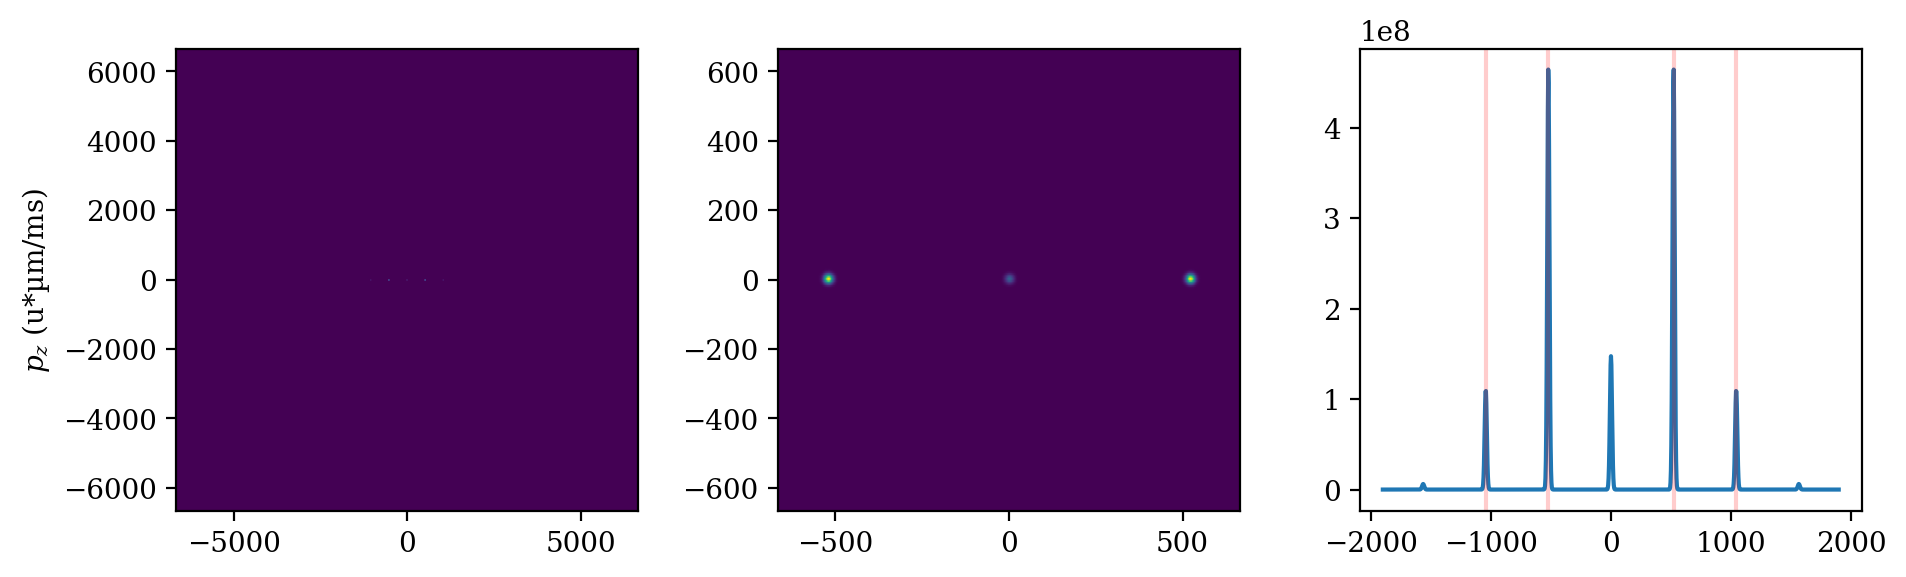

time = 1.18 µs
1.0000000000000373 |psi|^2
0.9985017481269702 |phi|^2


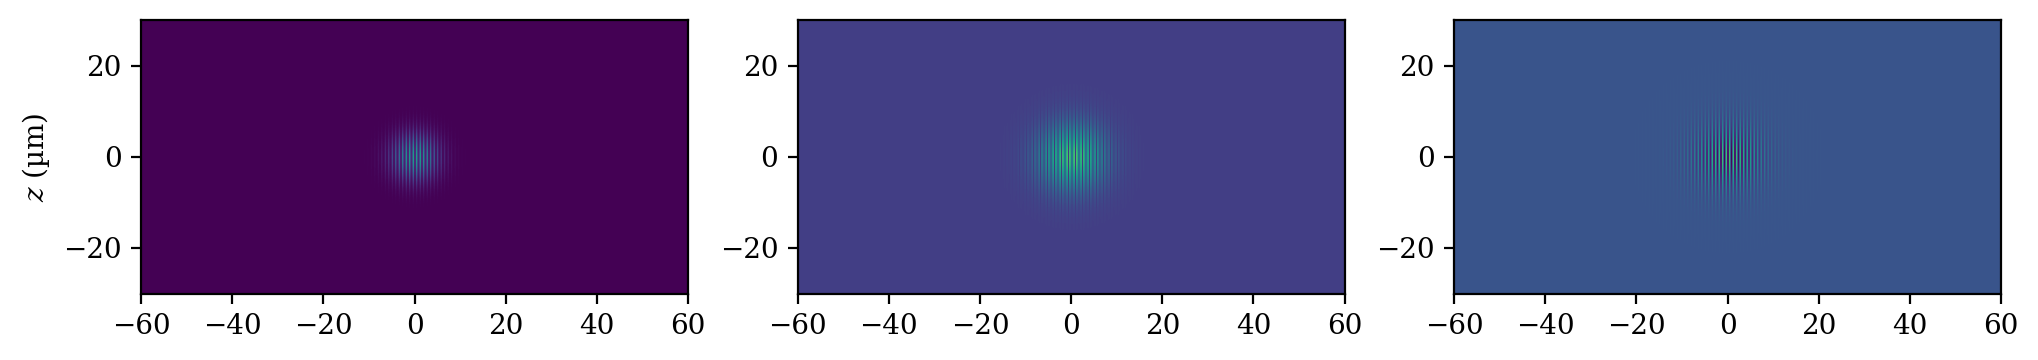

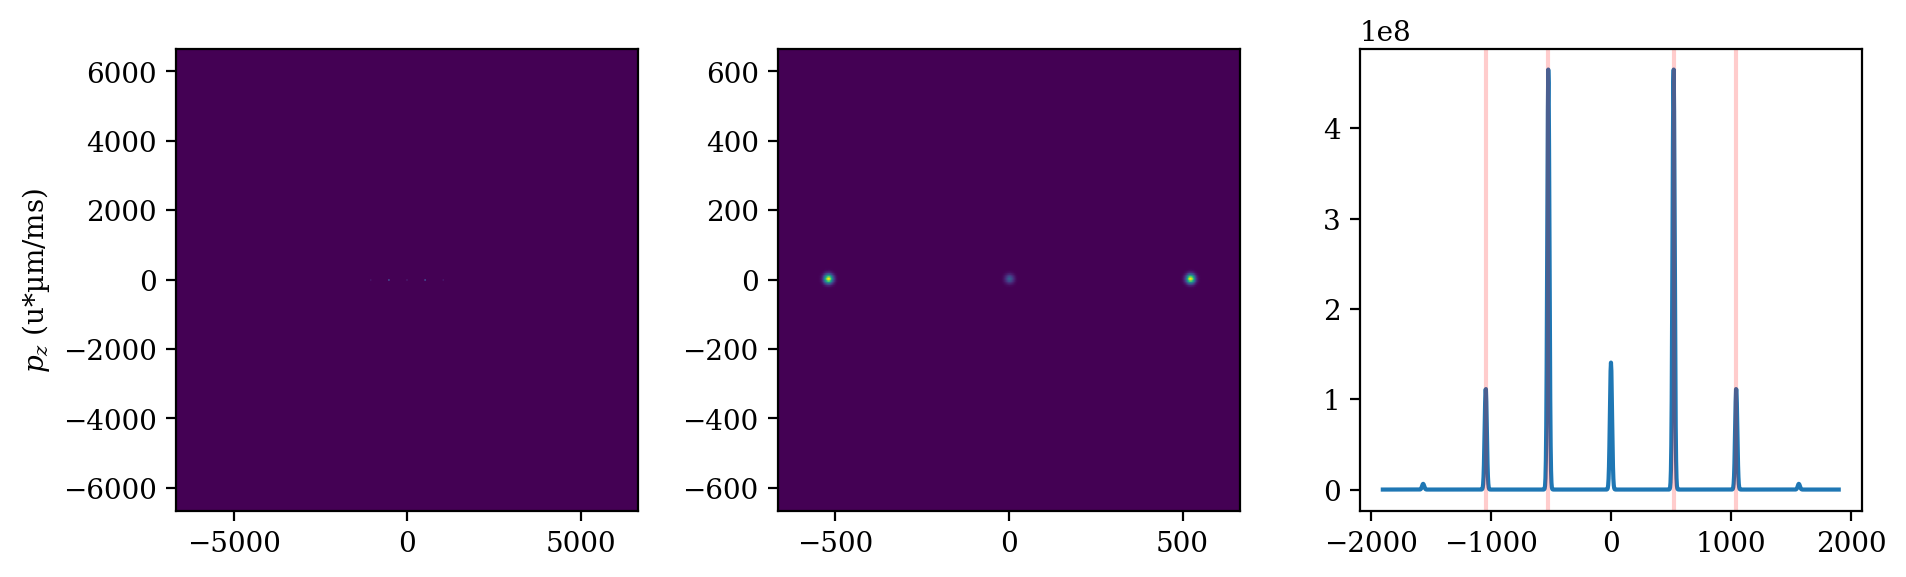

time = 1.19 µs
1.0000000000000373 |psi|^2
0.9985017481269699 |phi|^2


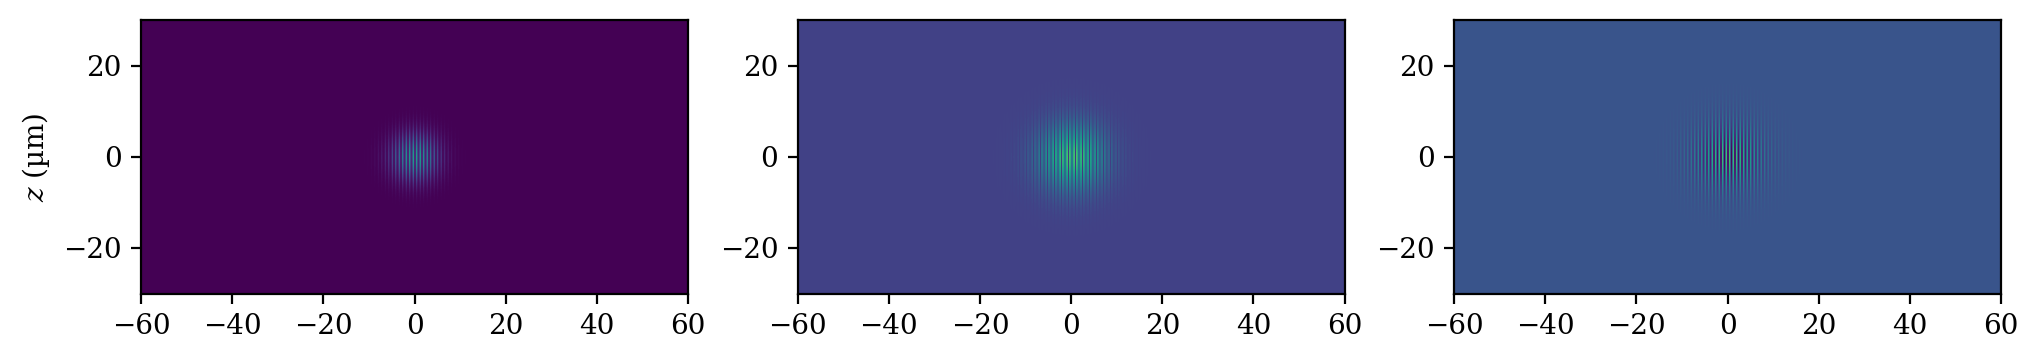

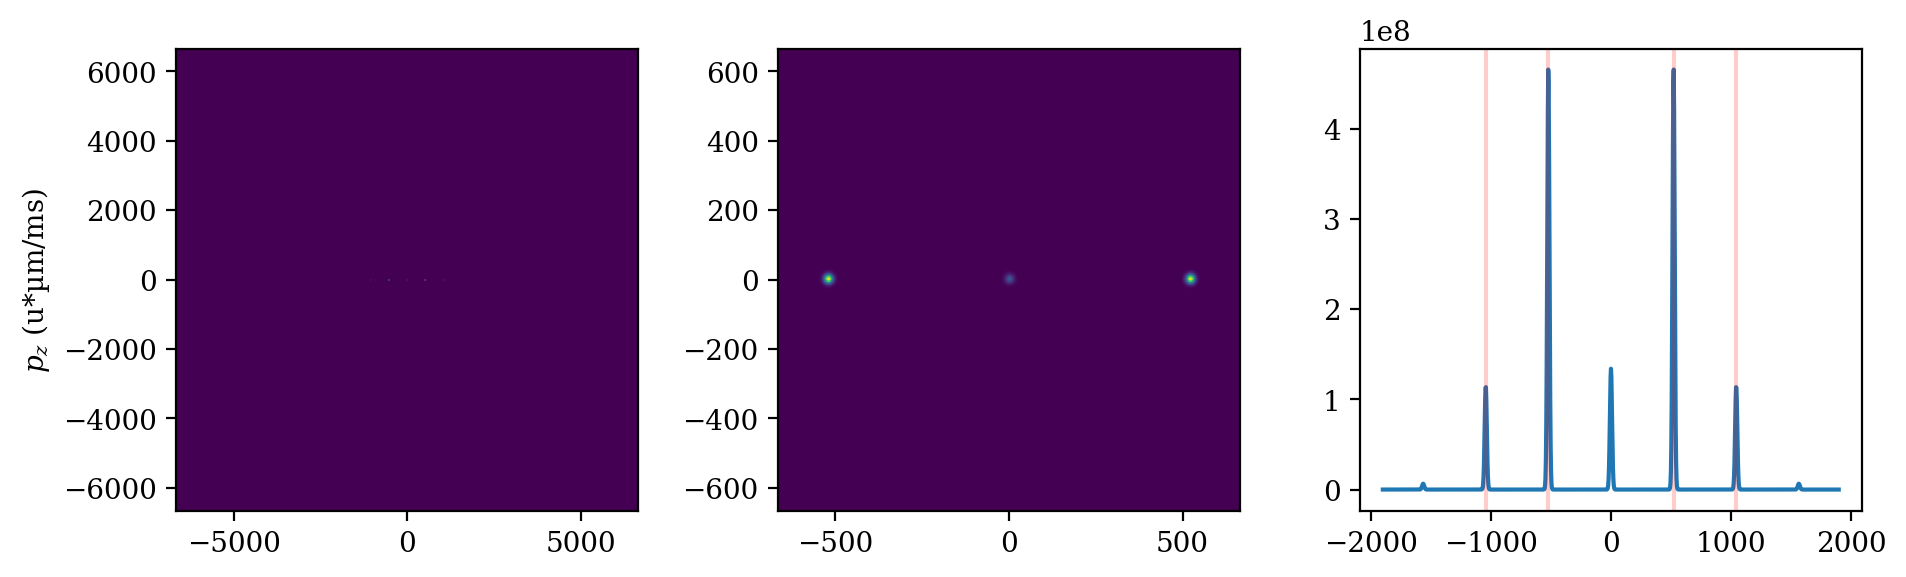

time = 1.2 µs
1.0000000000000377 |psi|^2
0.998501748126971 |phi|^2


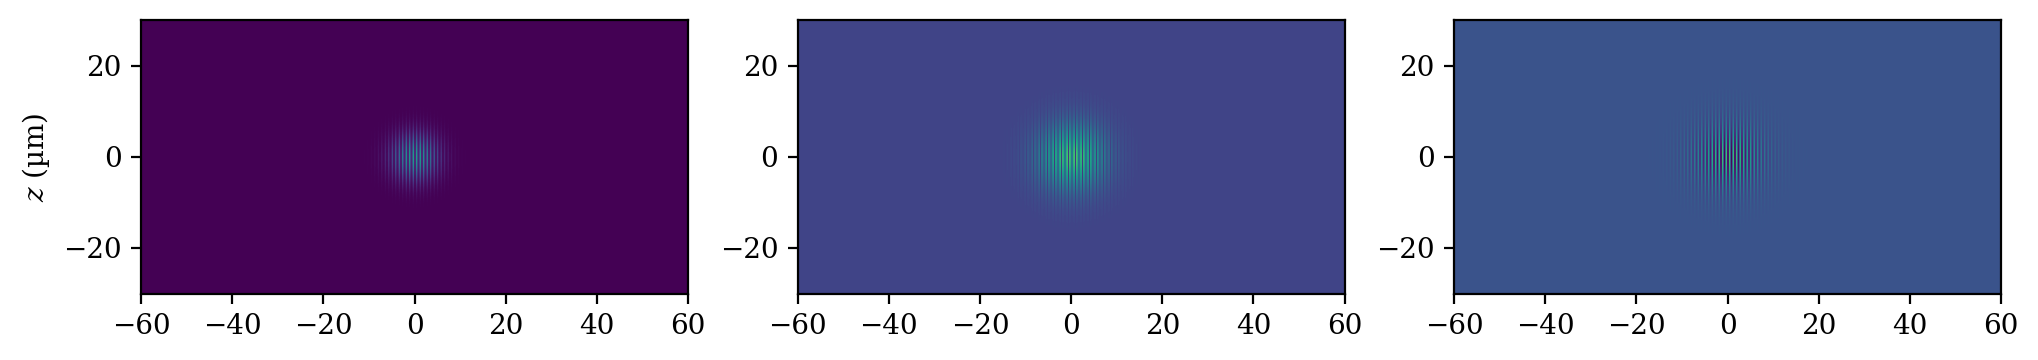

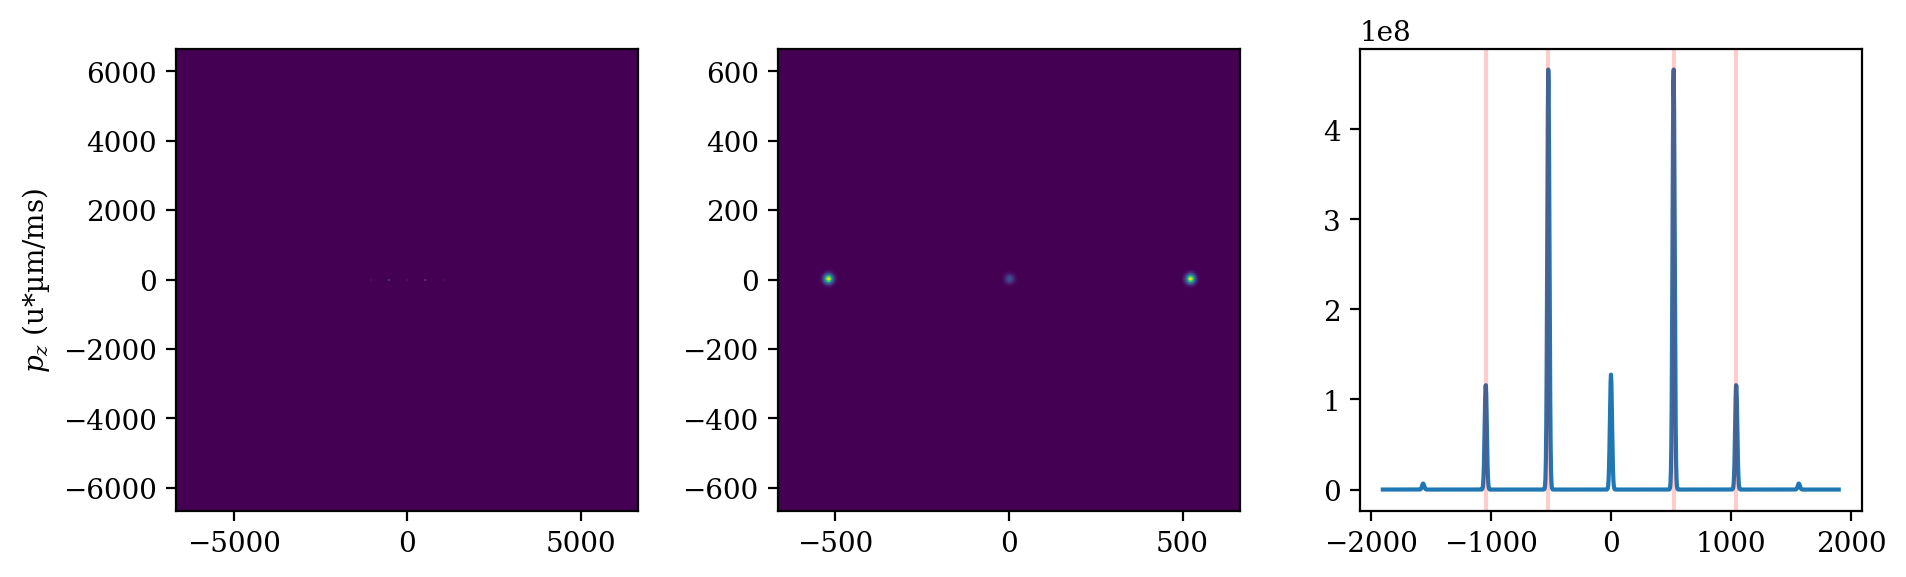

time = 1.21 µs
1.000000000000038 |psi|^2
0.9985017481269711 |phi|^2


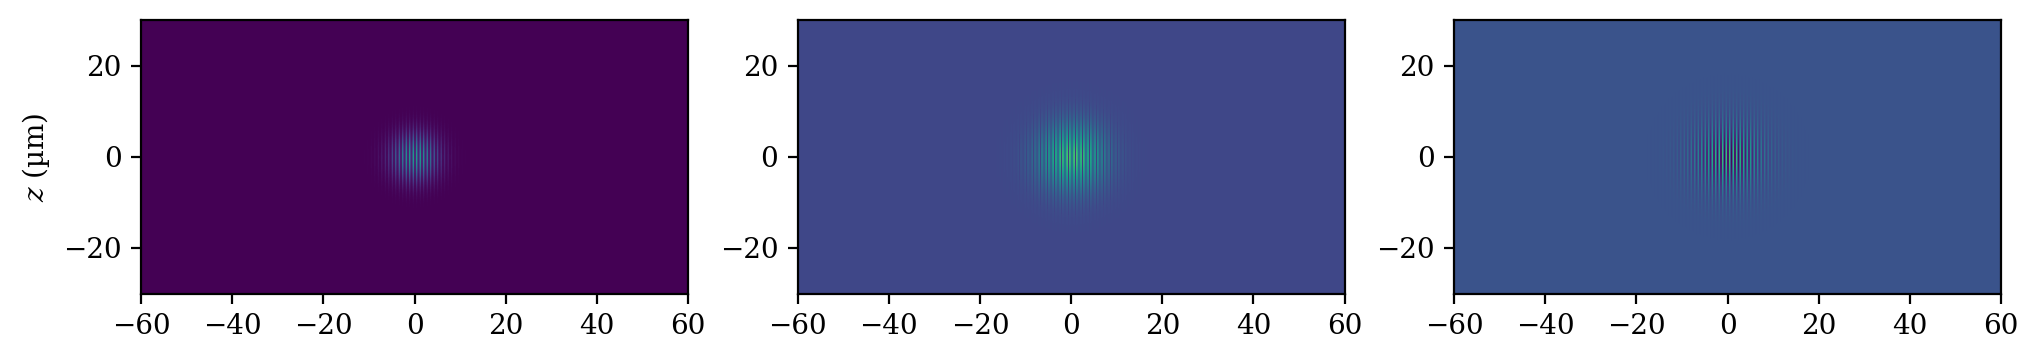

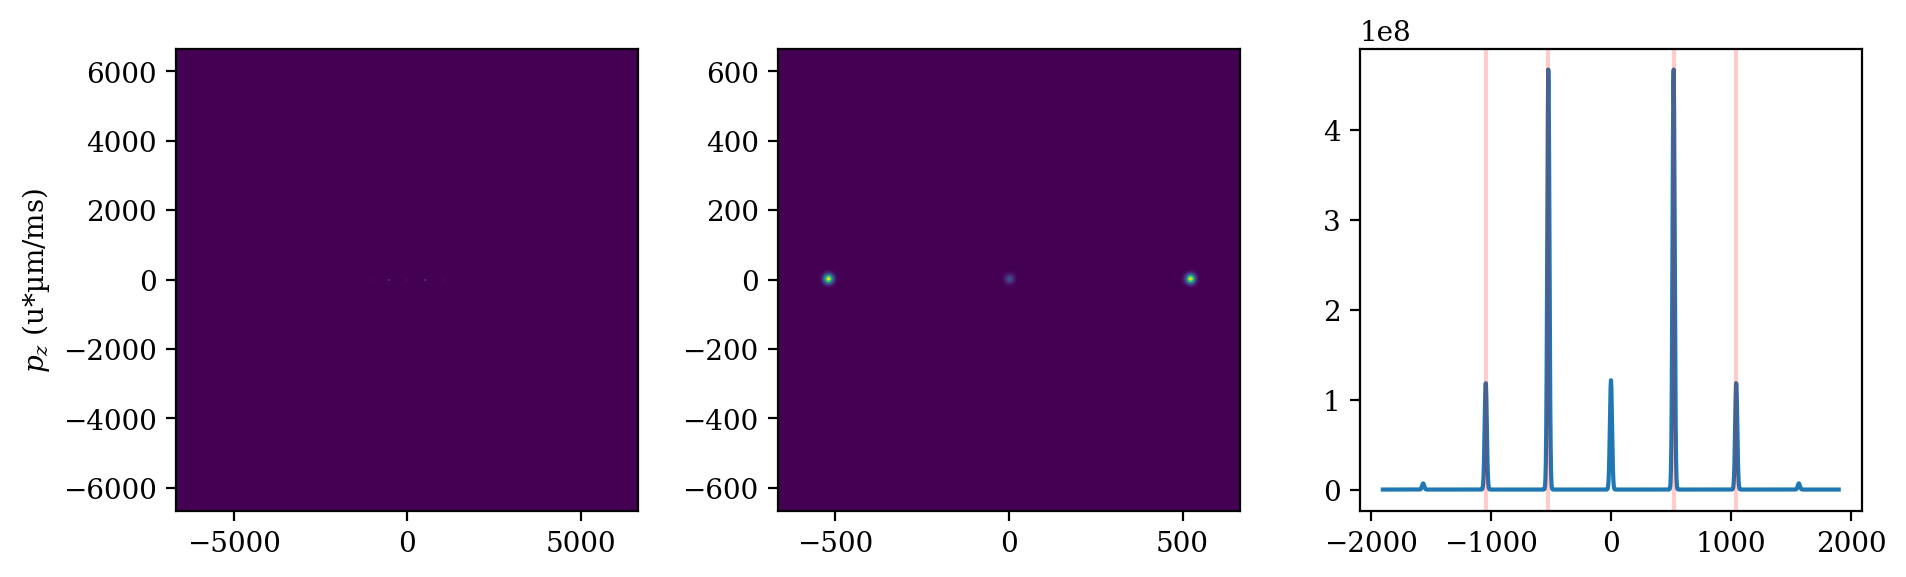

time = 1.22 µs
1.0000000000000382 |psi|^2
0.9985017481269708 |phi|^2


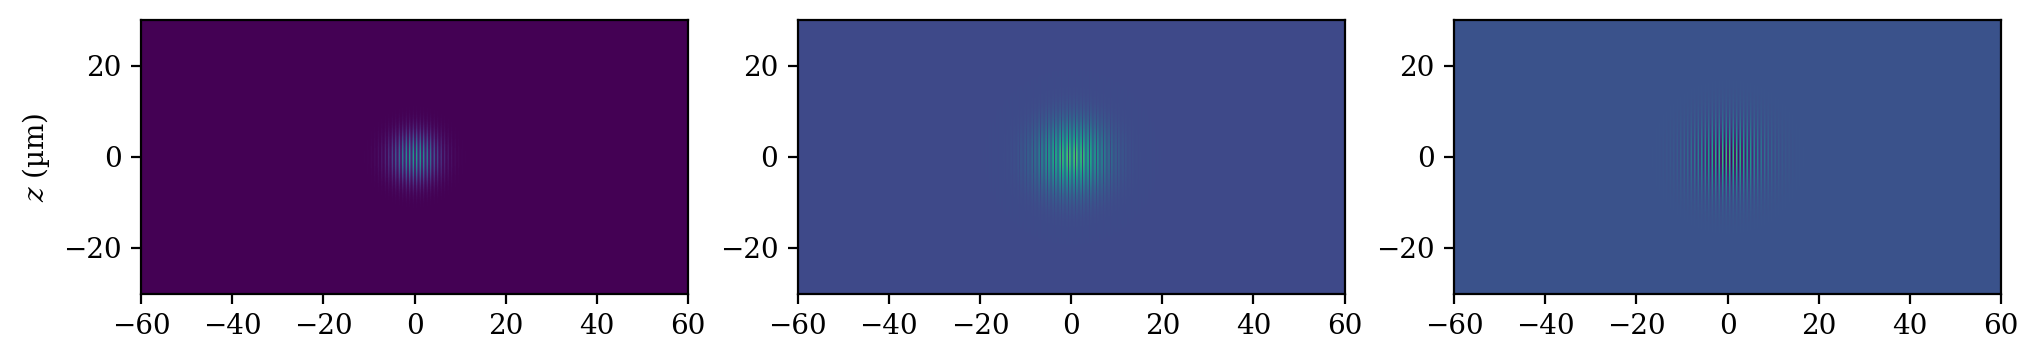

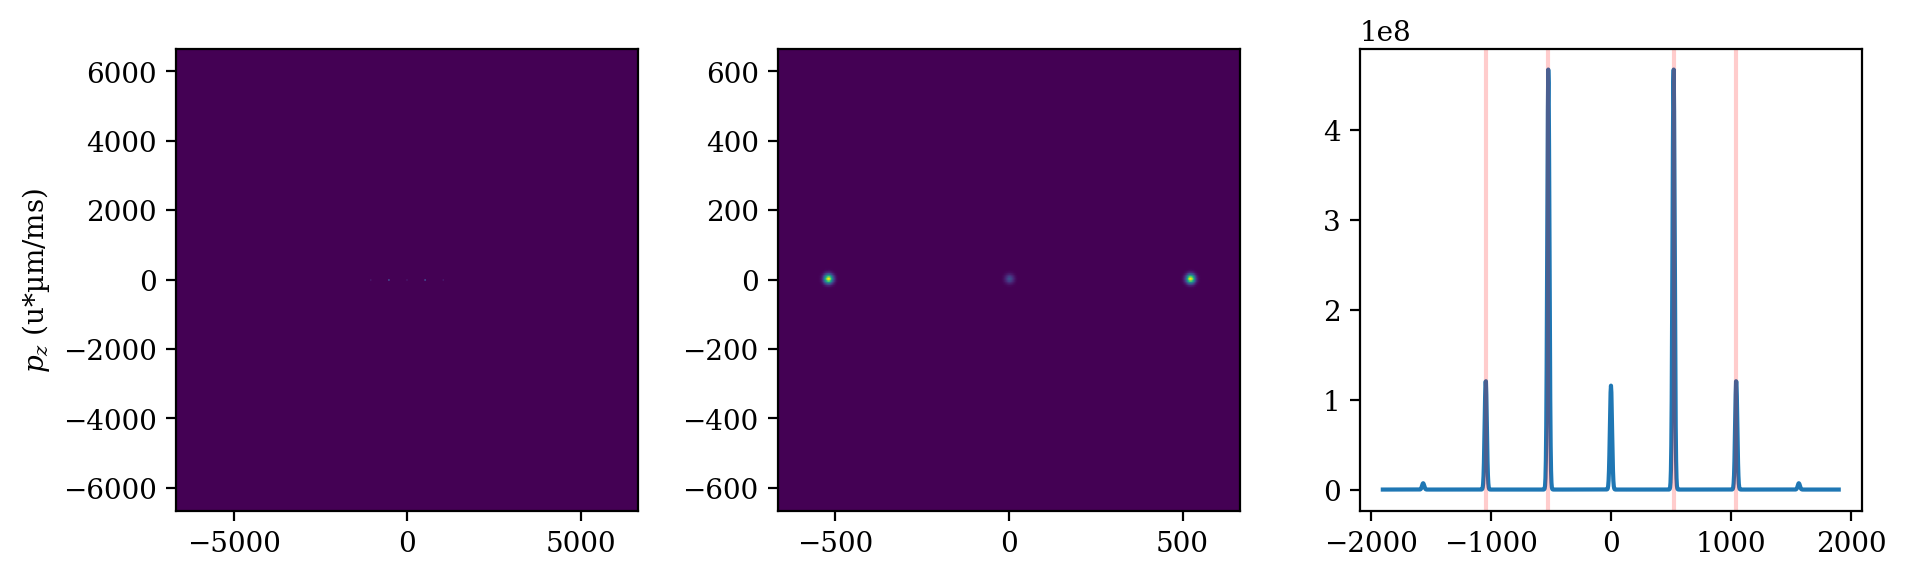

time = 1.23 µs
1.0000000000000386 |psi|^2
0.9985017481269716 |phi|^2


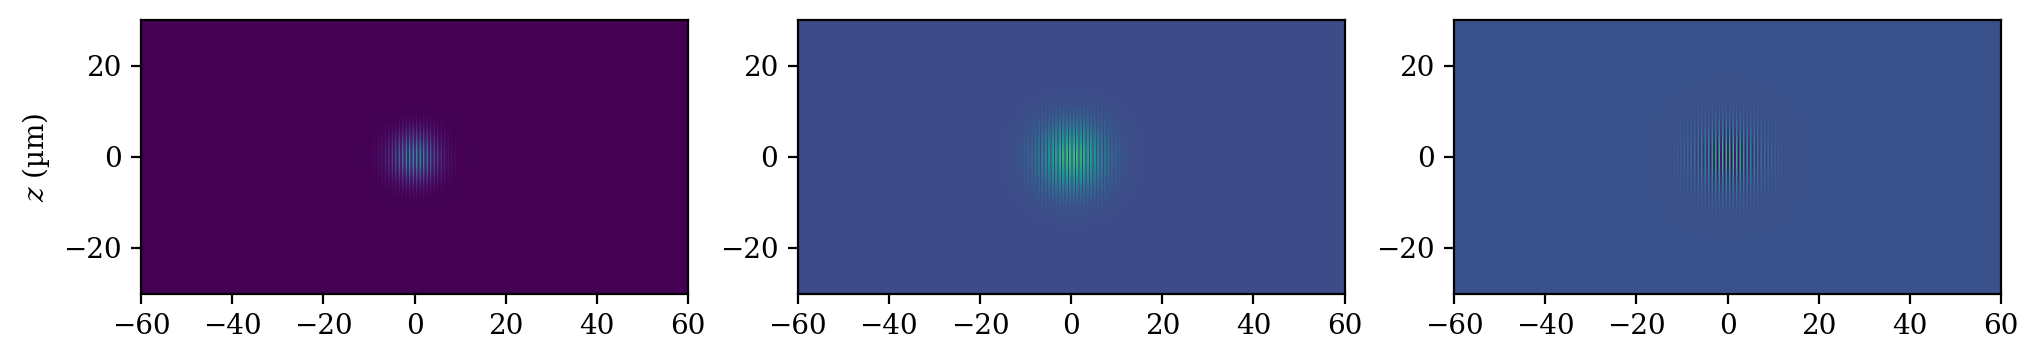

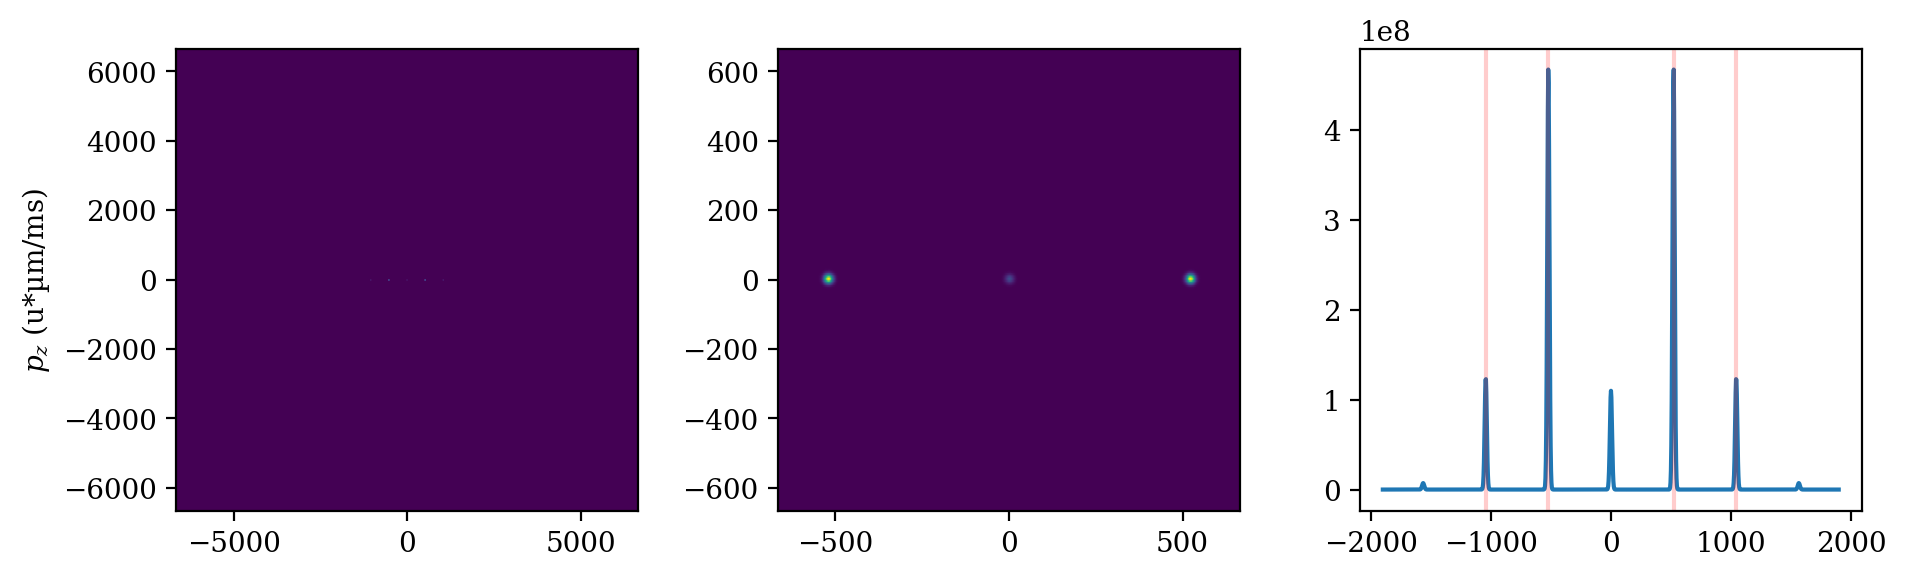

time = 1.24 µs
1.0000000000000386 |psi|^2
0.9985017481269728 |phi|^2


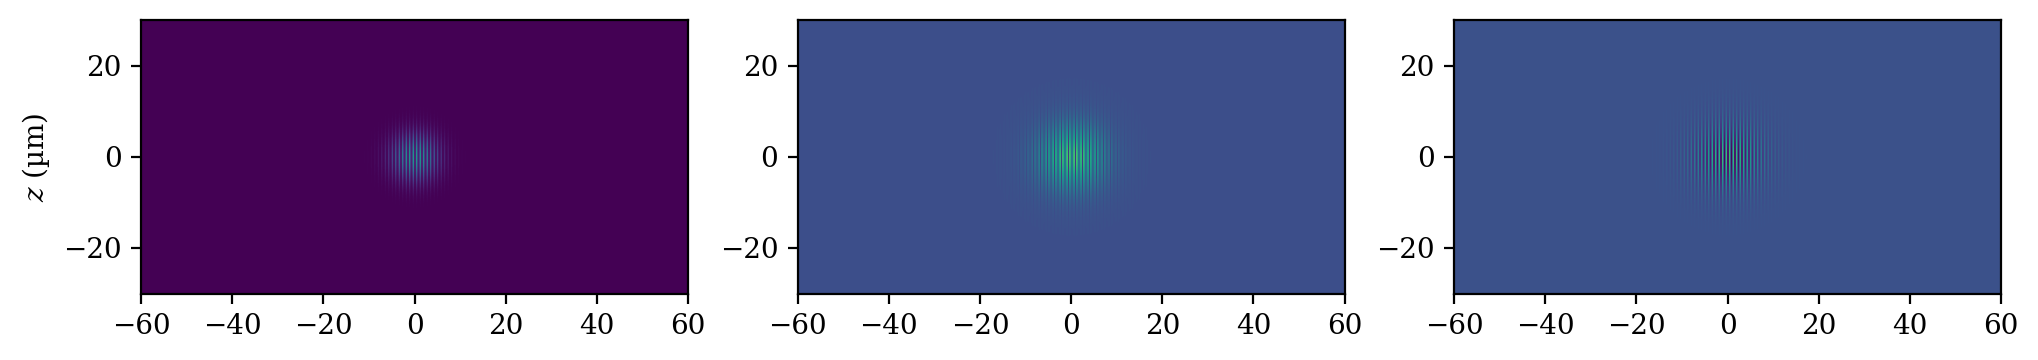

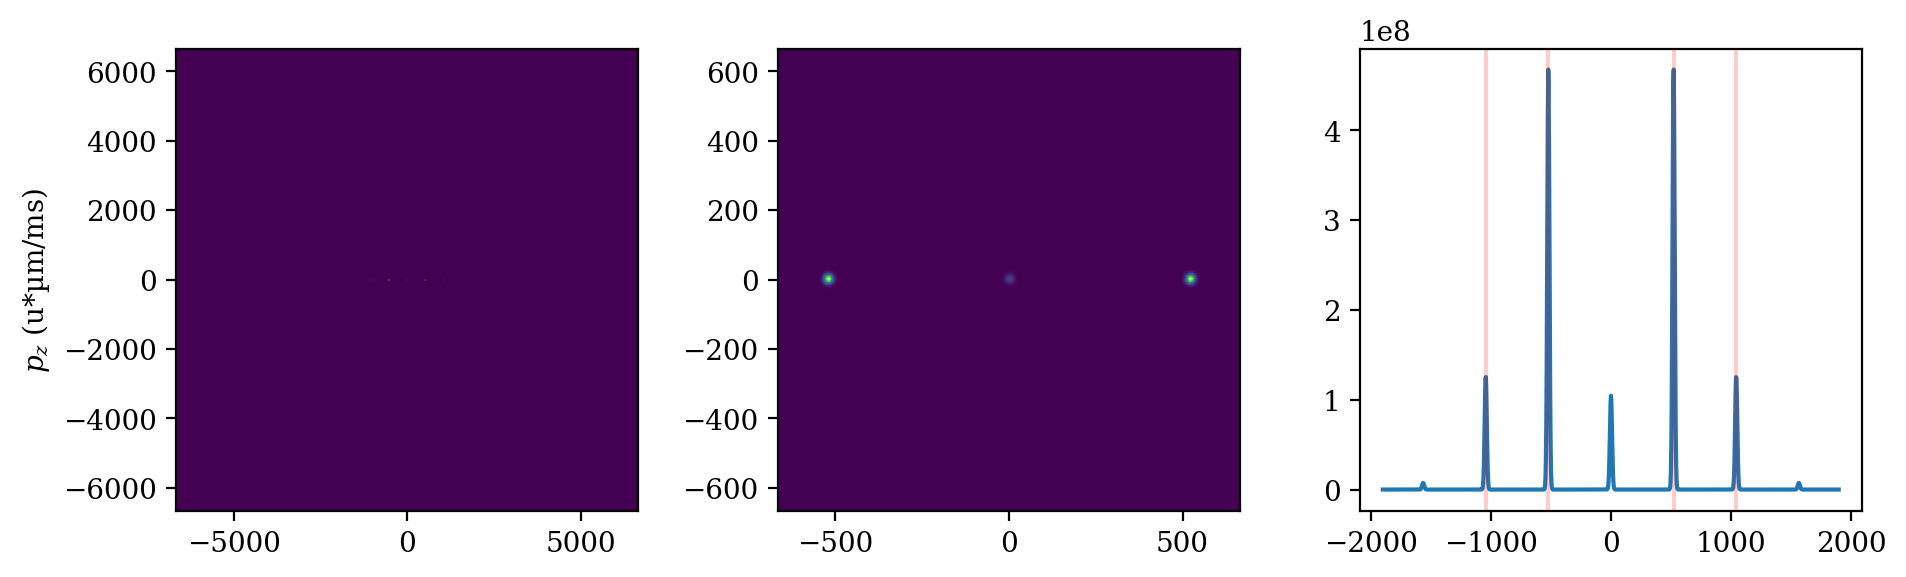

time = 1.25 µs
1.0000000000000389 |psi|^2
0.9985017481269721 |phi|^2


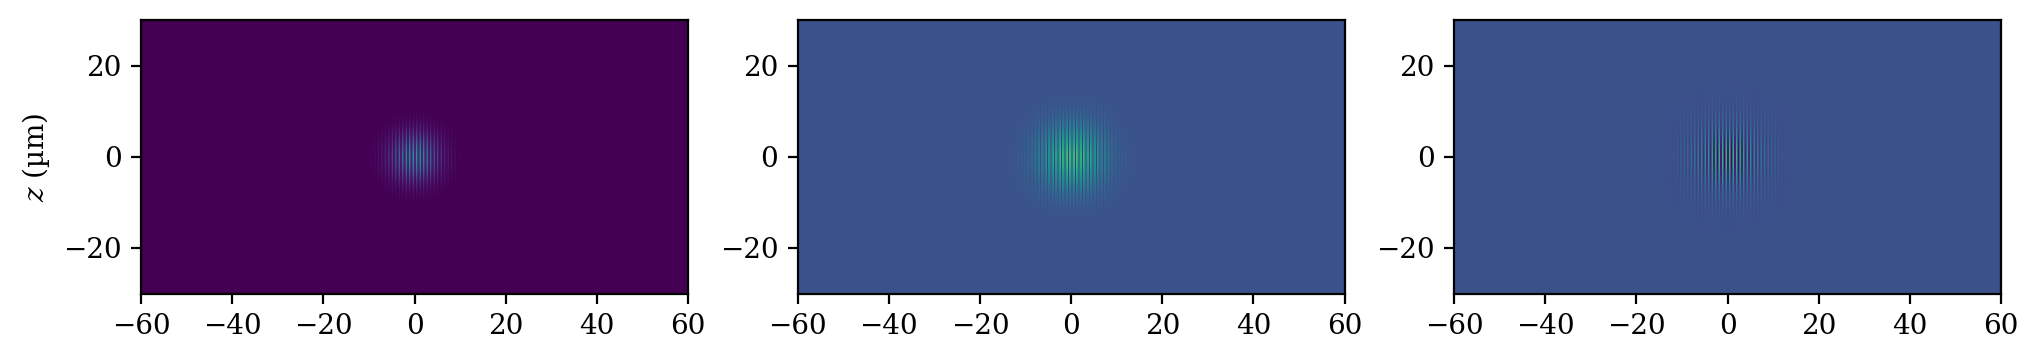

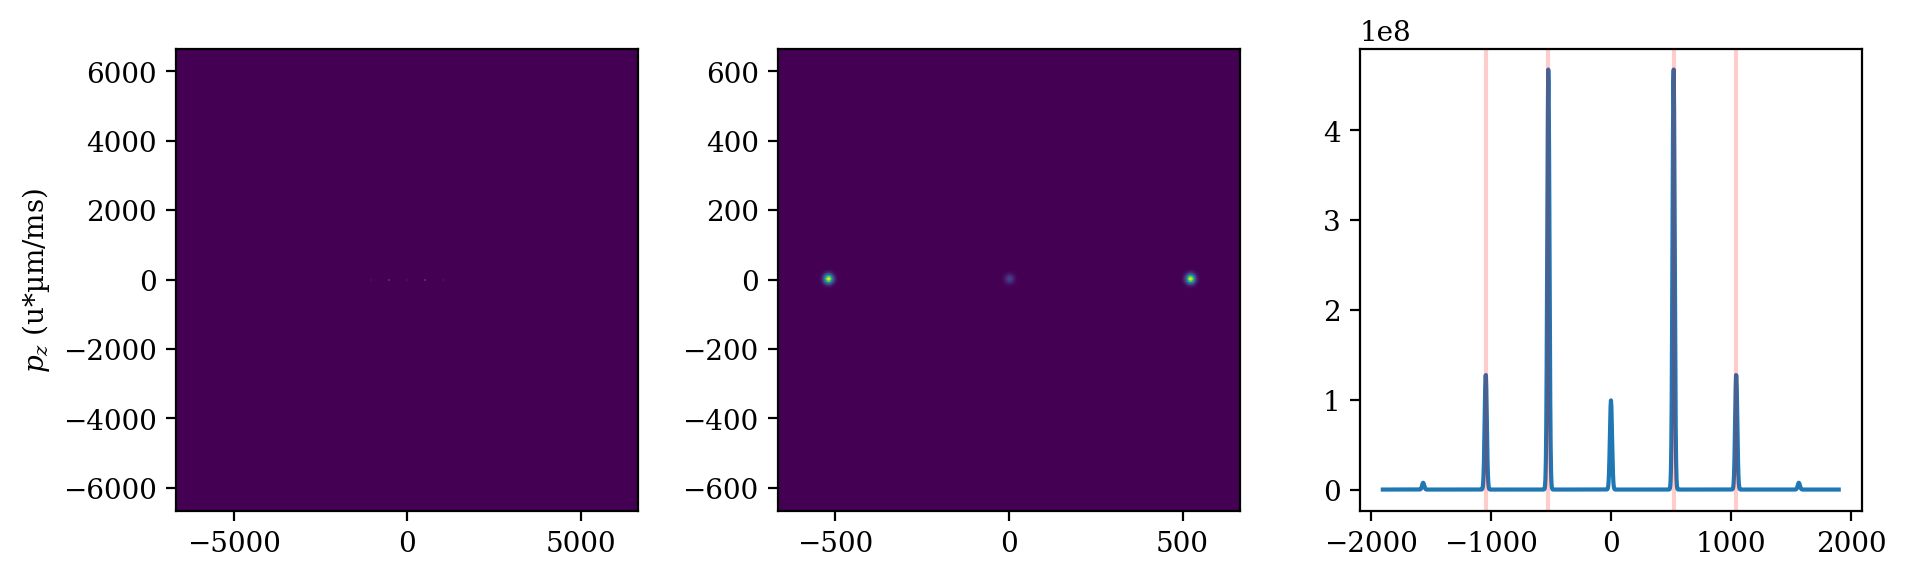

time = 1.26 µs
1.000000000000039 |psi|^2
0.998501748126973 |phi|^2


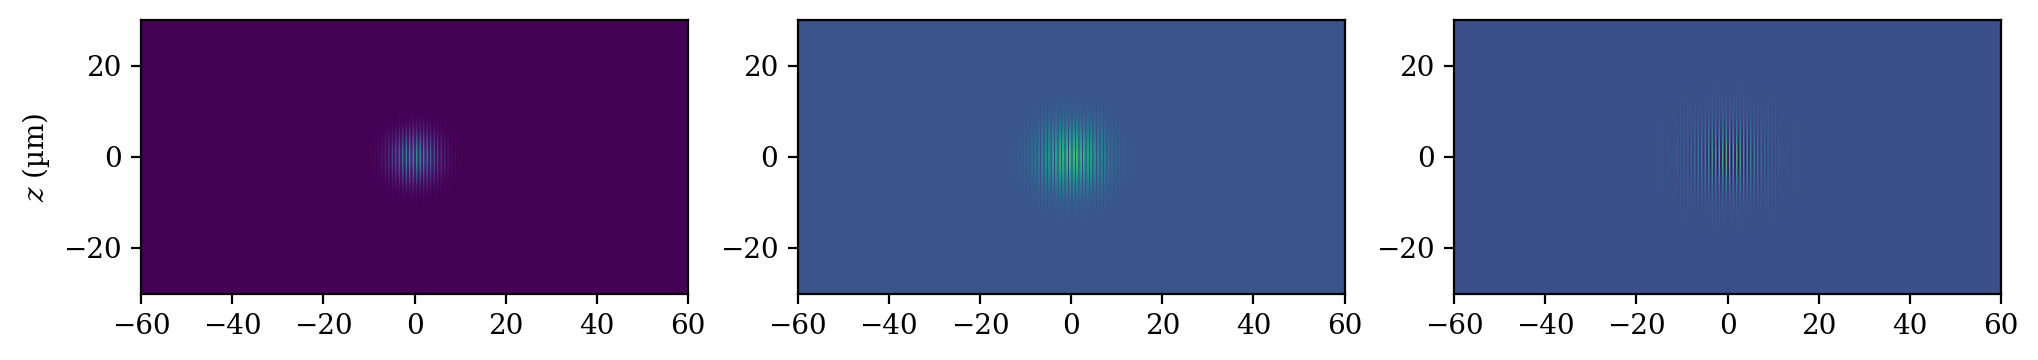

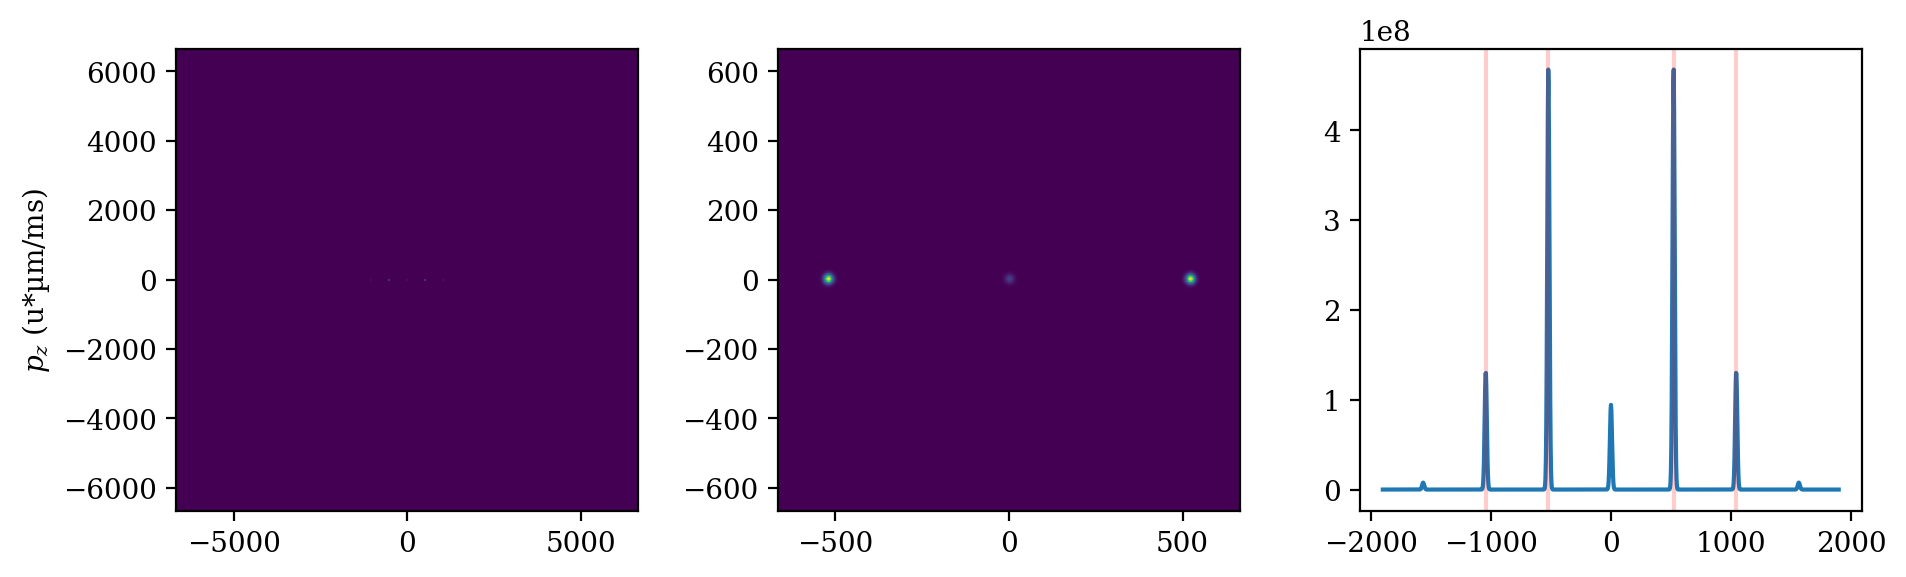

time = 1.27 µs
1.000000000000039 |psi|^2
0.9985017481269733 |phi|^2


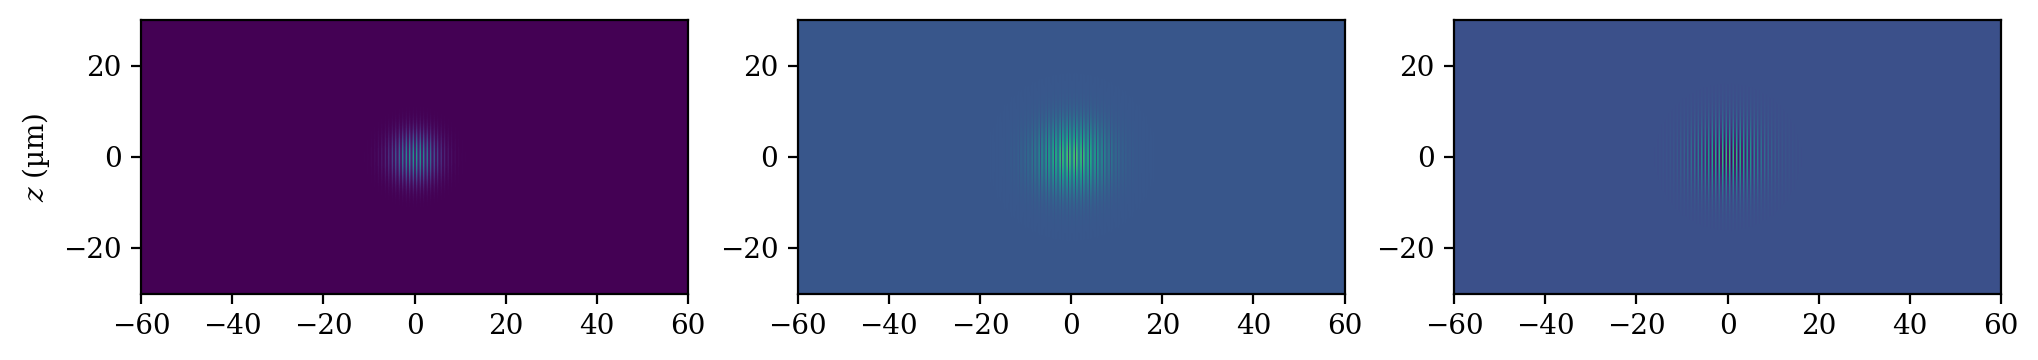

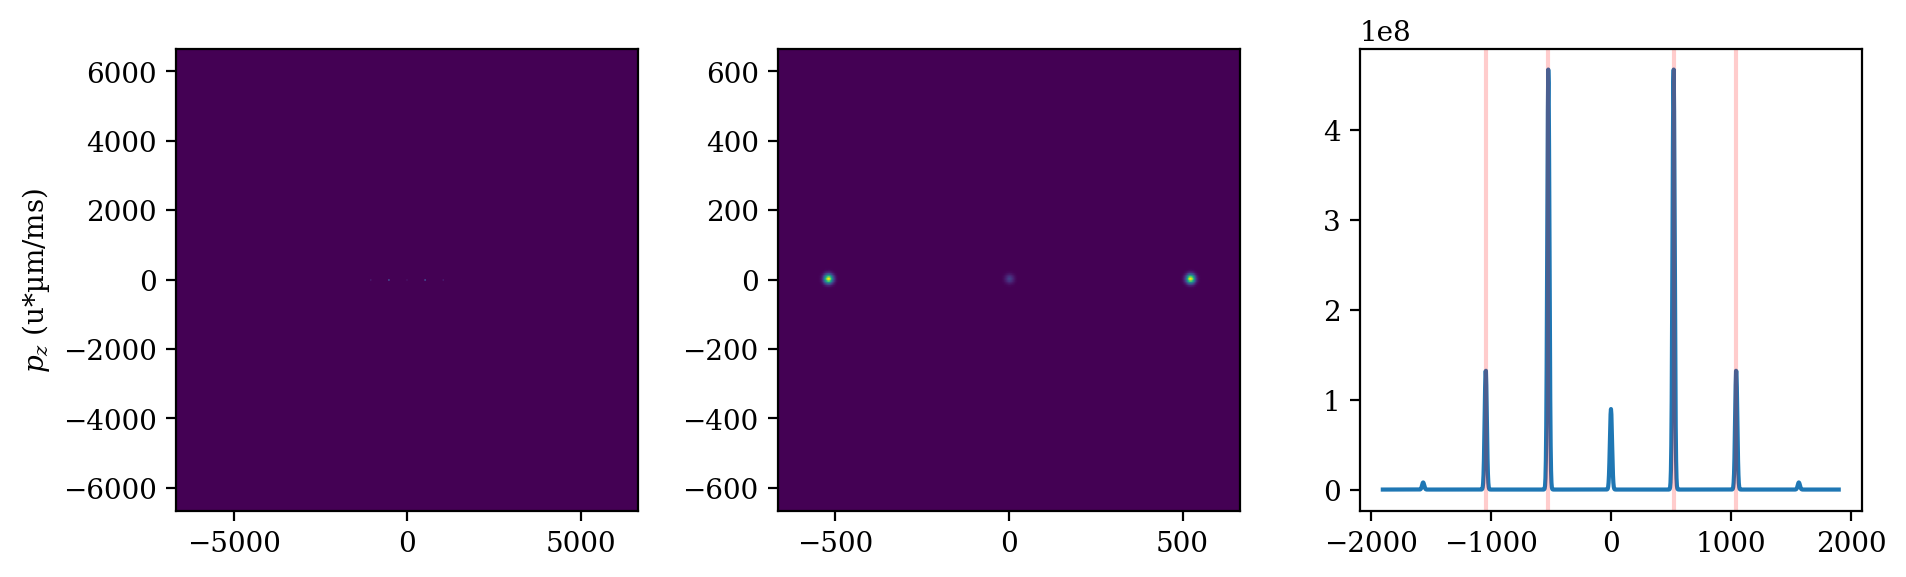

time = 1.28 µs
1.0000000000000397 |psi|^2
0.9985017481269739 |phi|^2


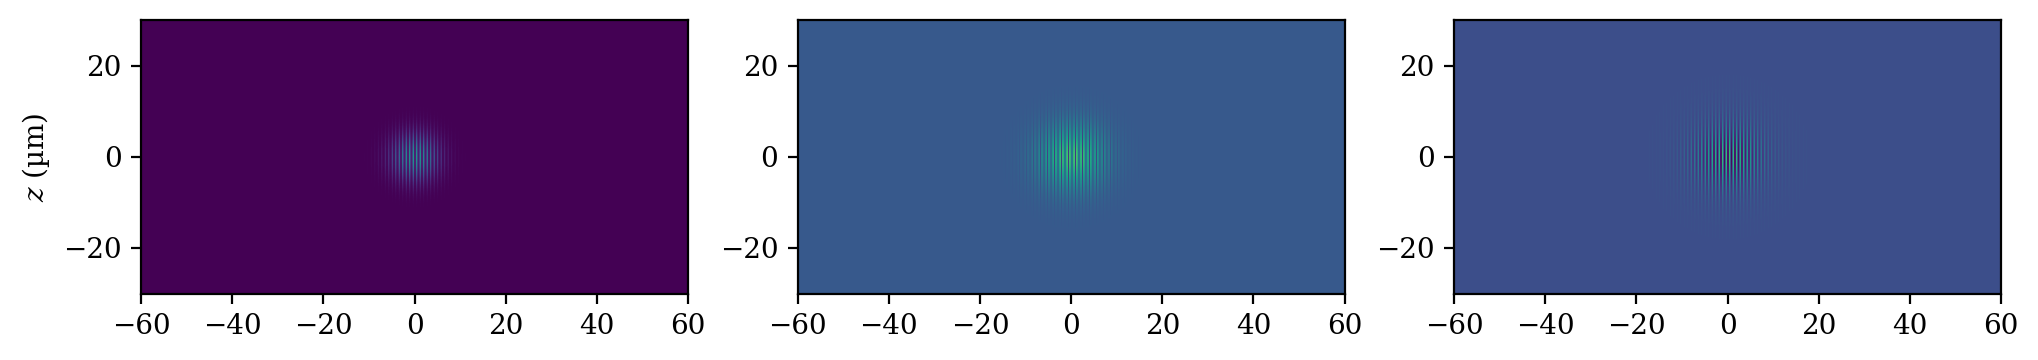

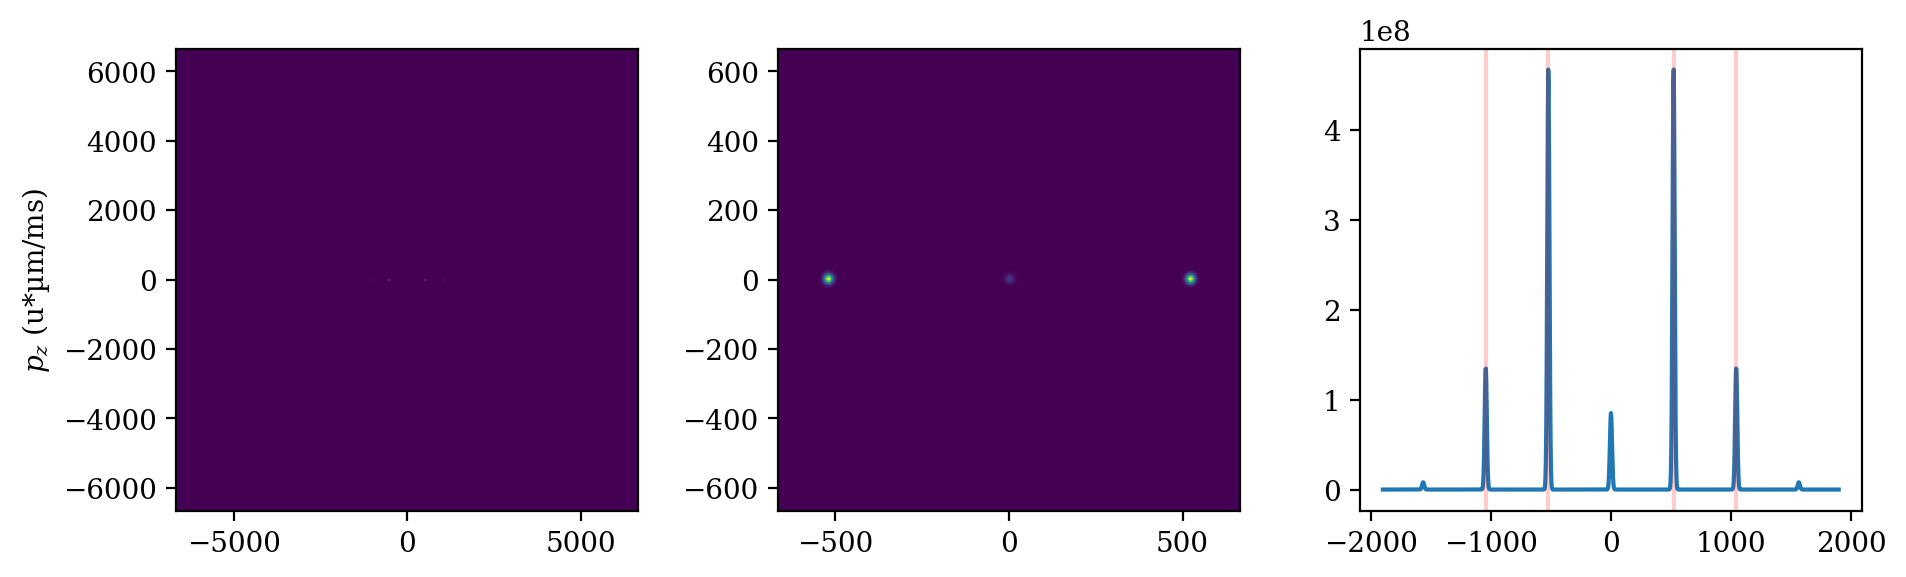

time = 1.29 µs
1.00000000000004 |psi|^2
0.9985017481269743 |phi|^2


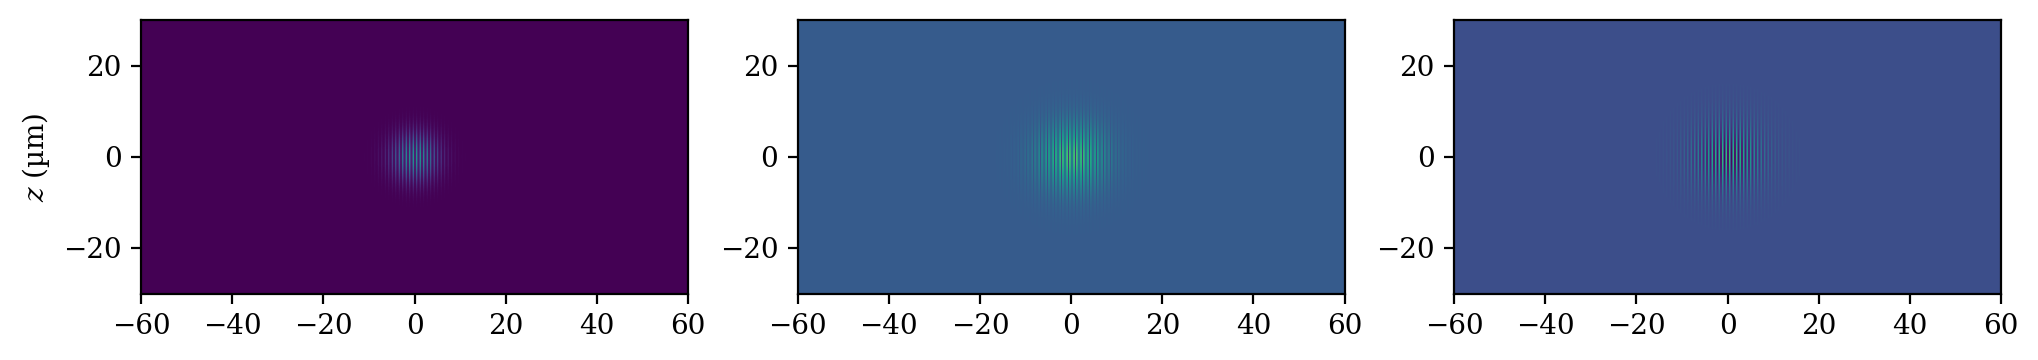

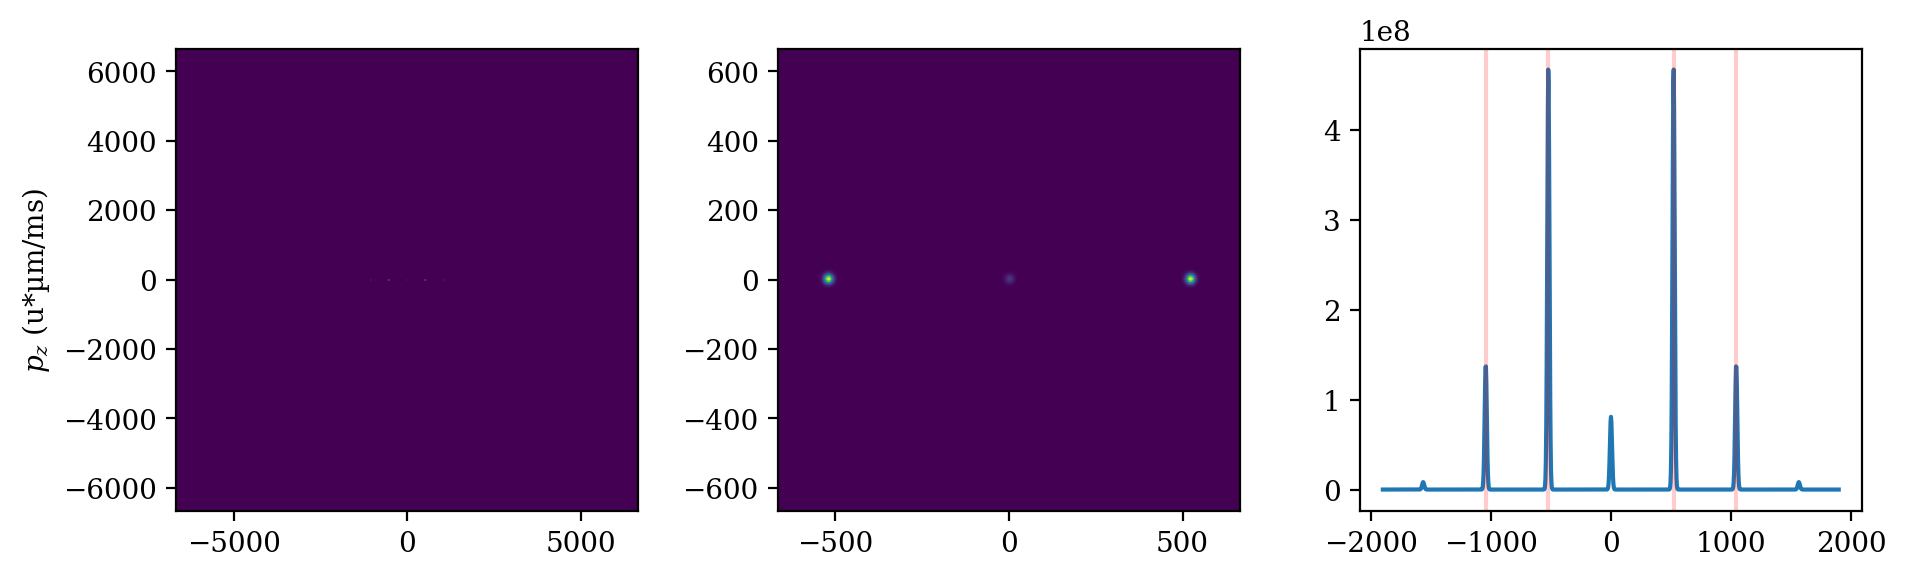

time = 1.3 µs
1.00000000000004 |psi|^2
0.9985017481269739 |phi|^2


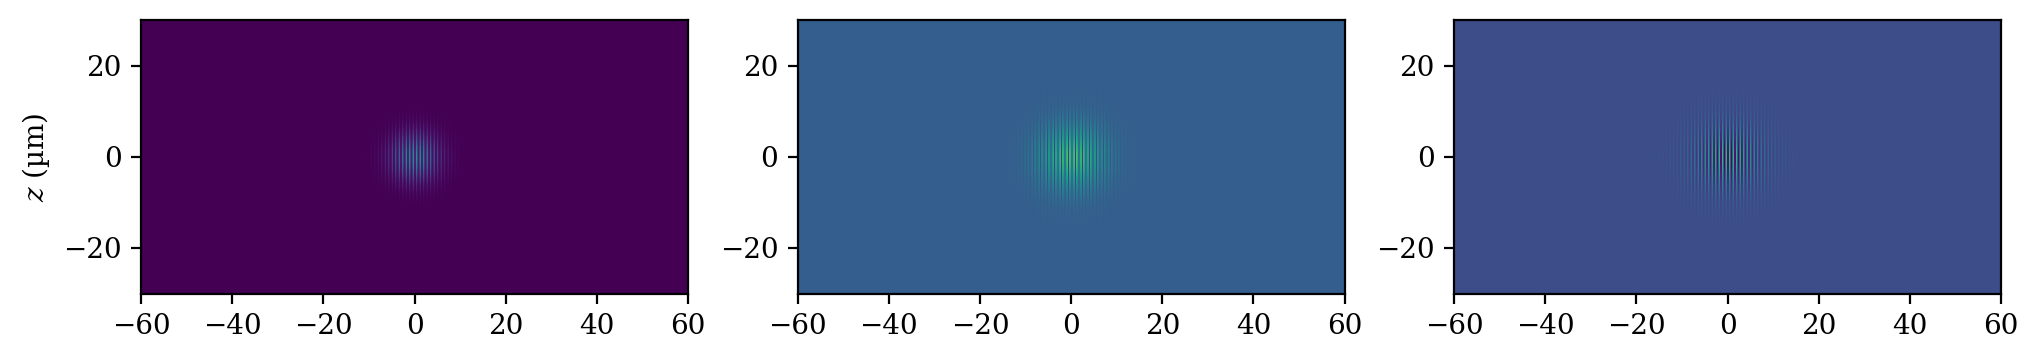

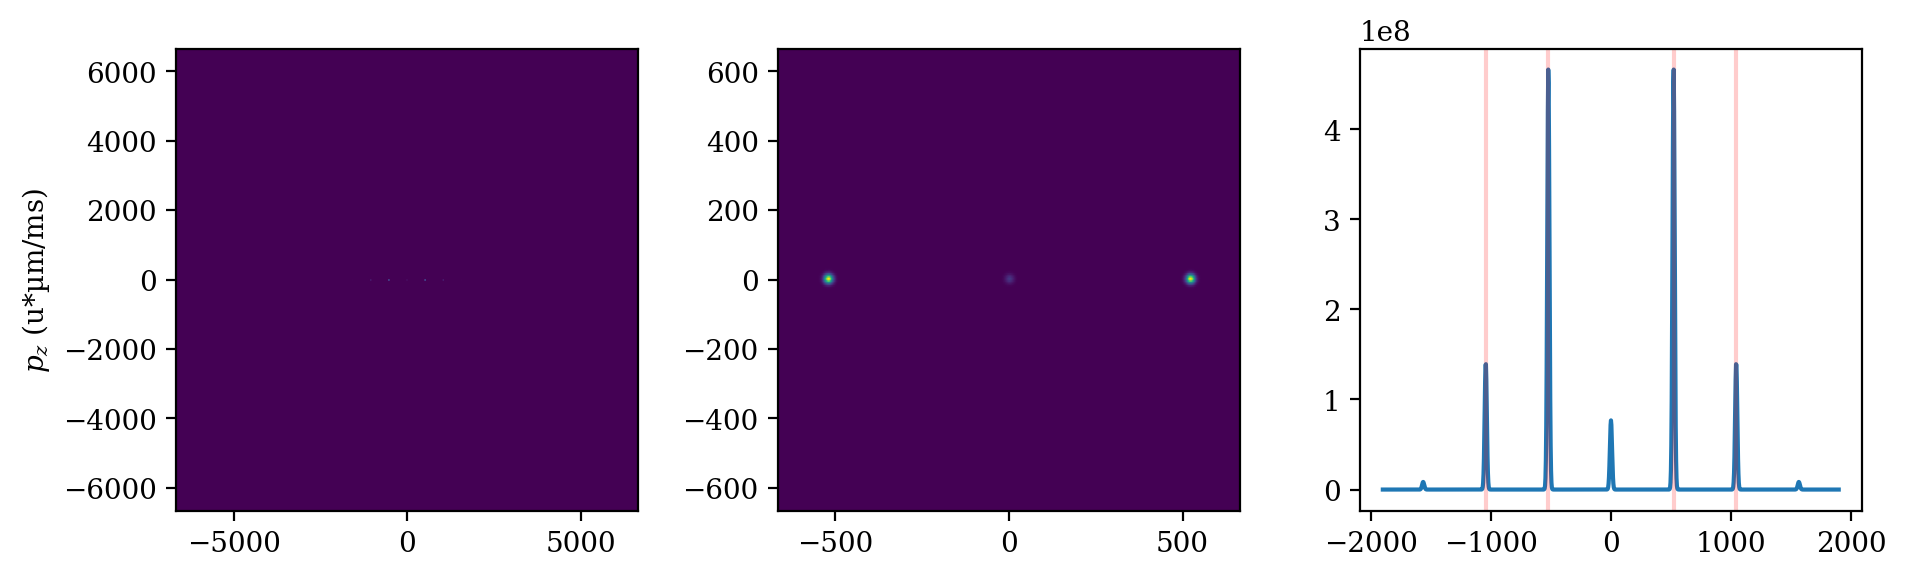

time = 1.31 µs
1.0000000000000404 |psi|^2
0.9985017481269747 |phi|^2


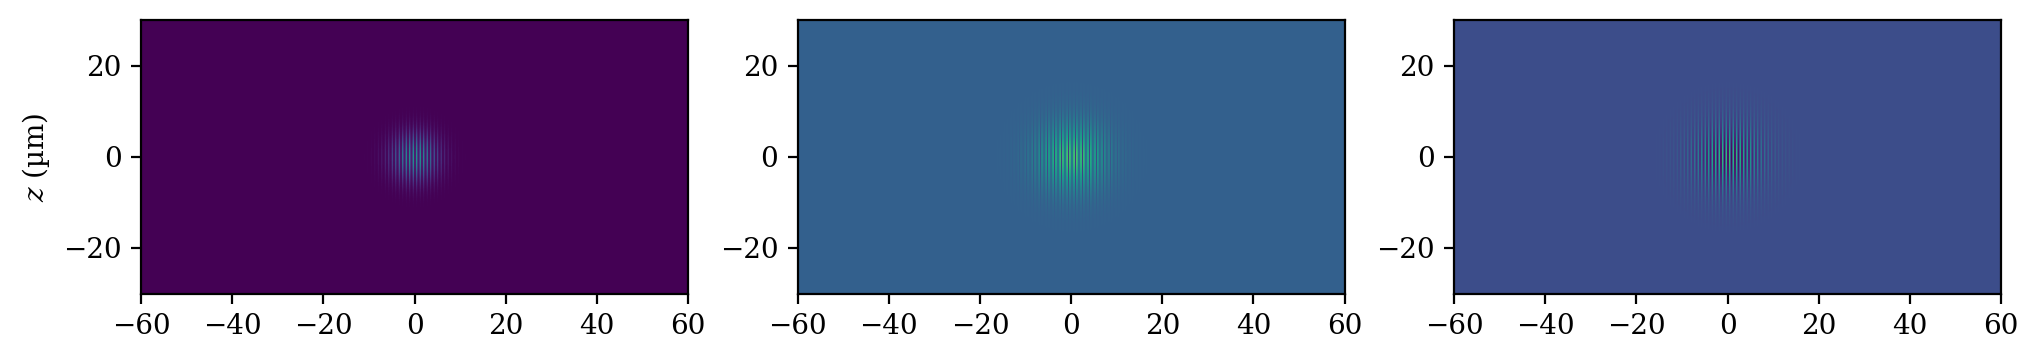

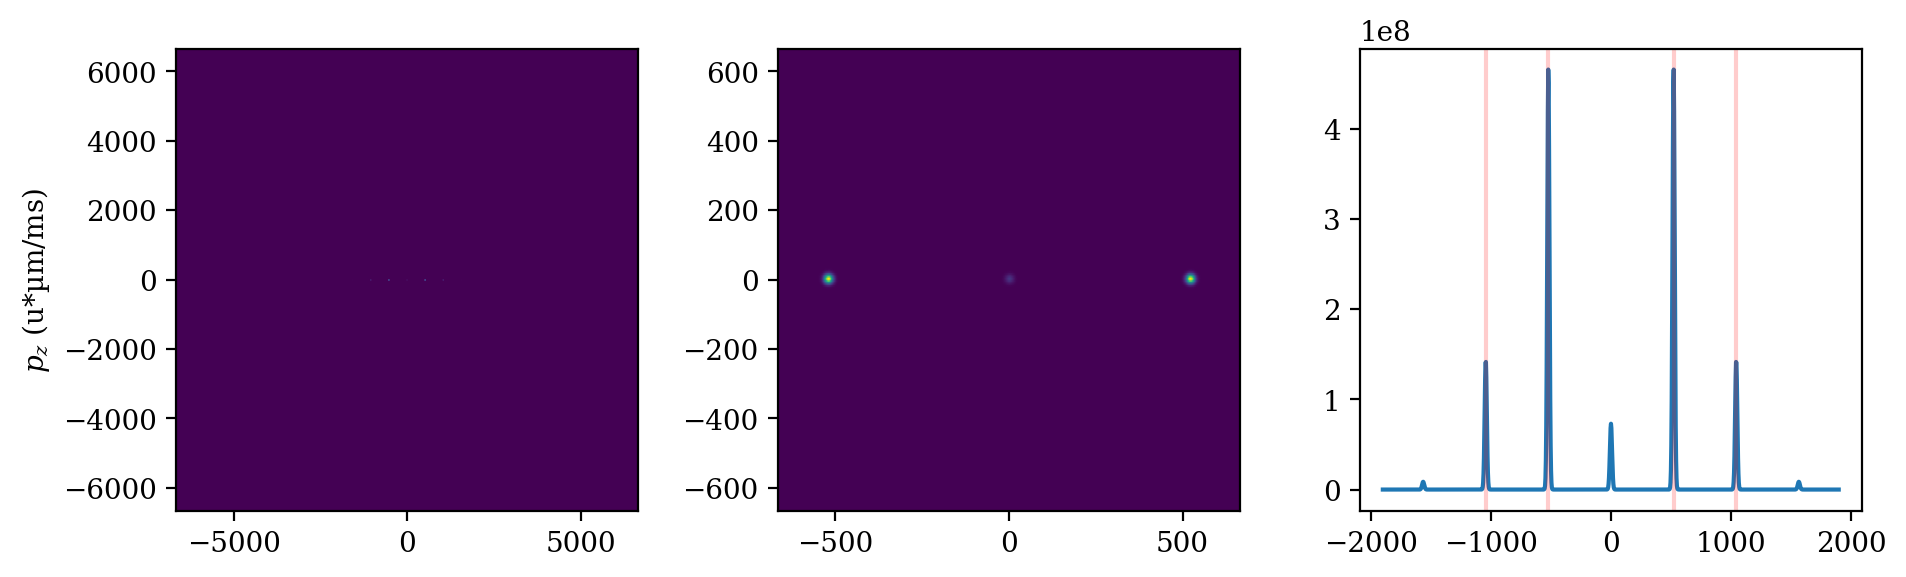

time = 1.32 µs
1.0000000000000409 |psi|^2
0.9985017481269749 |phi|^2


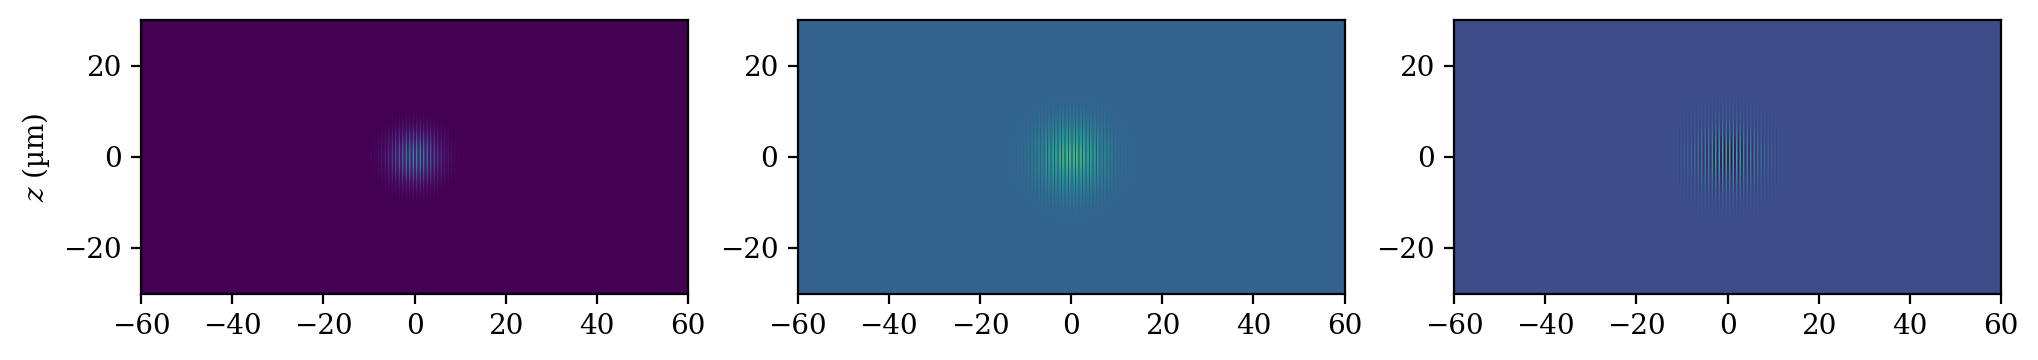

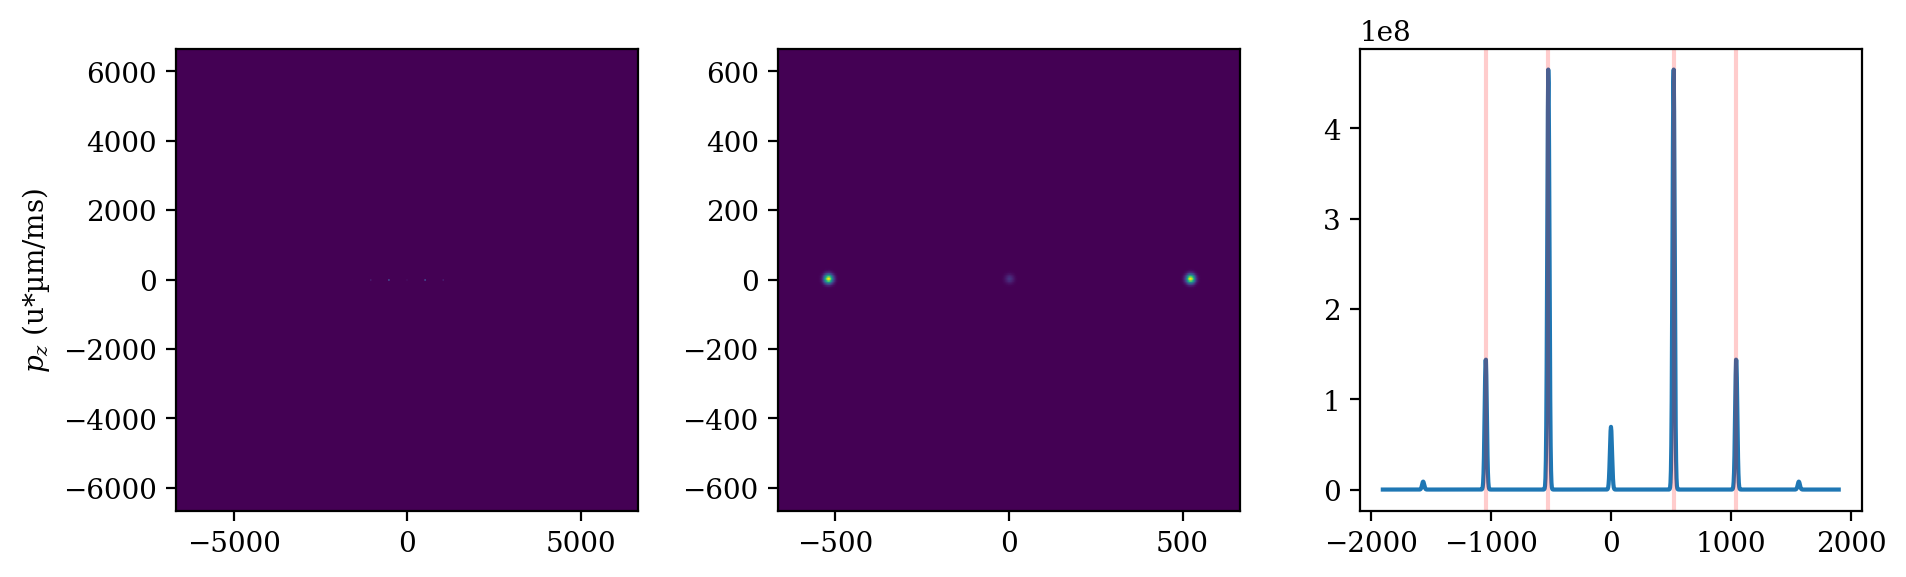

time = 1.33 µs
1.0000000000000409 |psi|^2
0.9985017481269755 |phi|^2


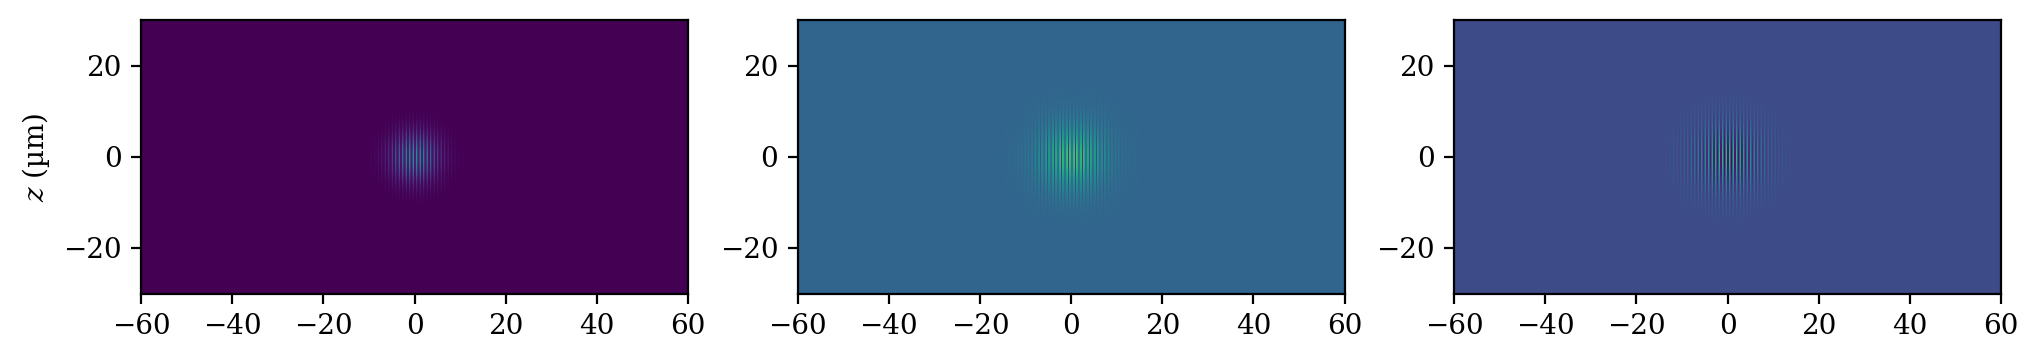

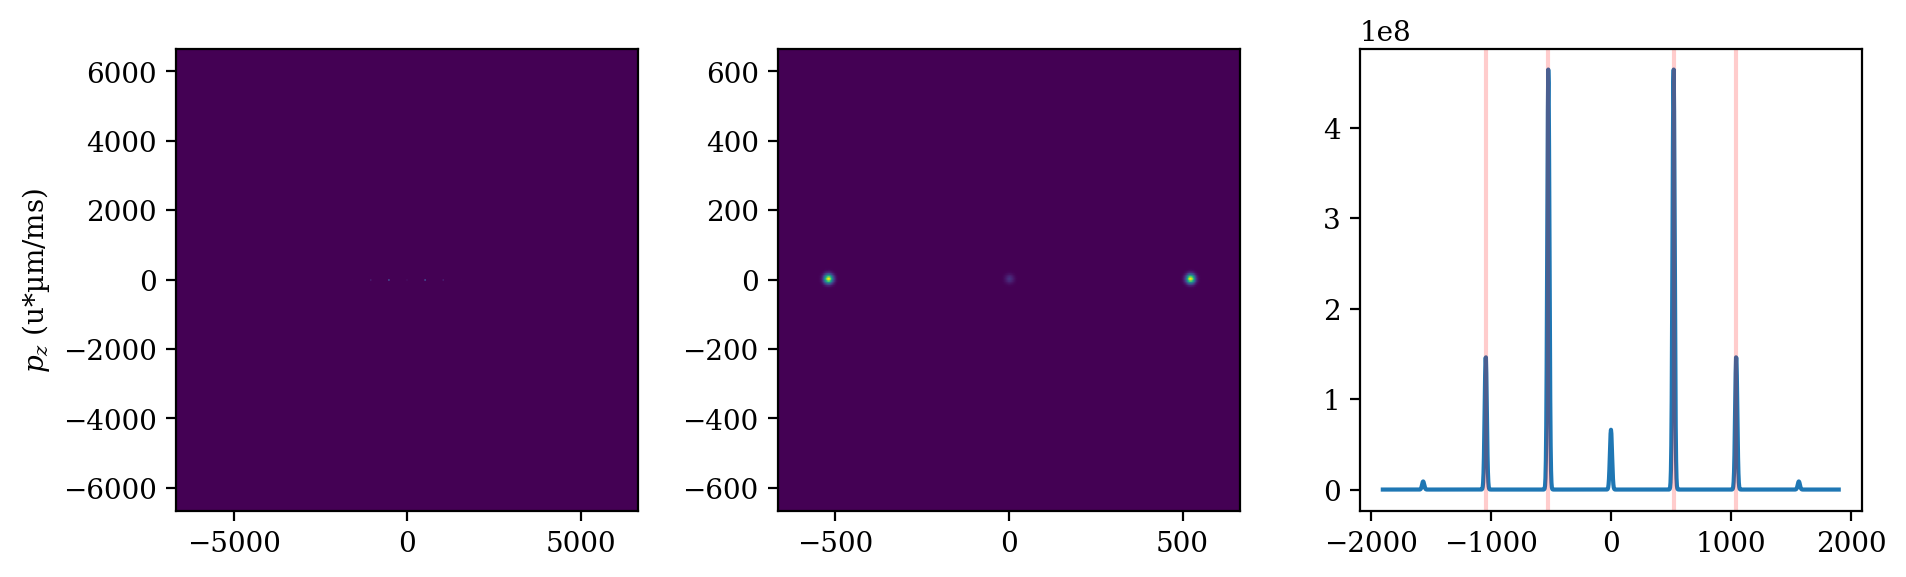

time = 1.34 µs
1.0000000000000413 |psi|^2
0.9985017481269758 |phi|^2


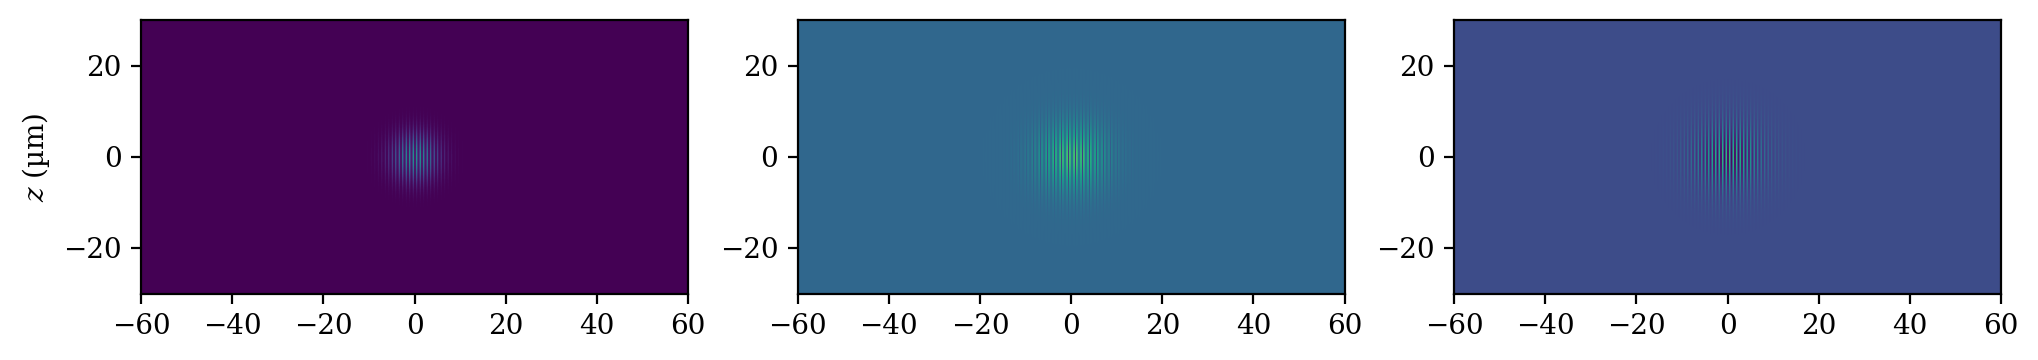

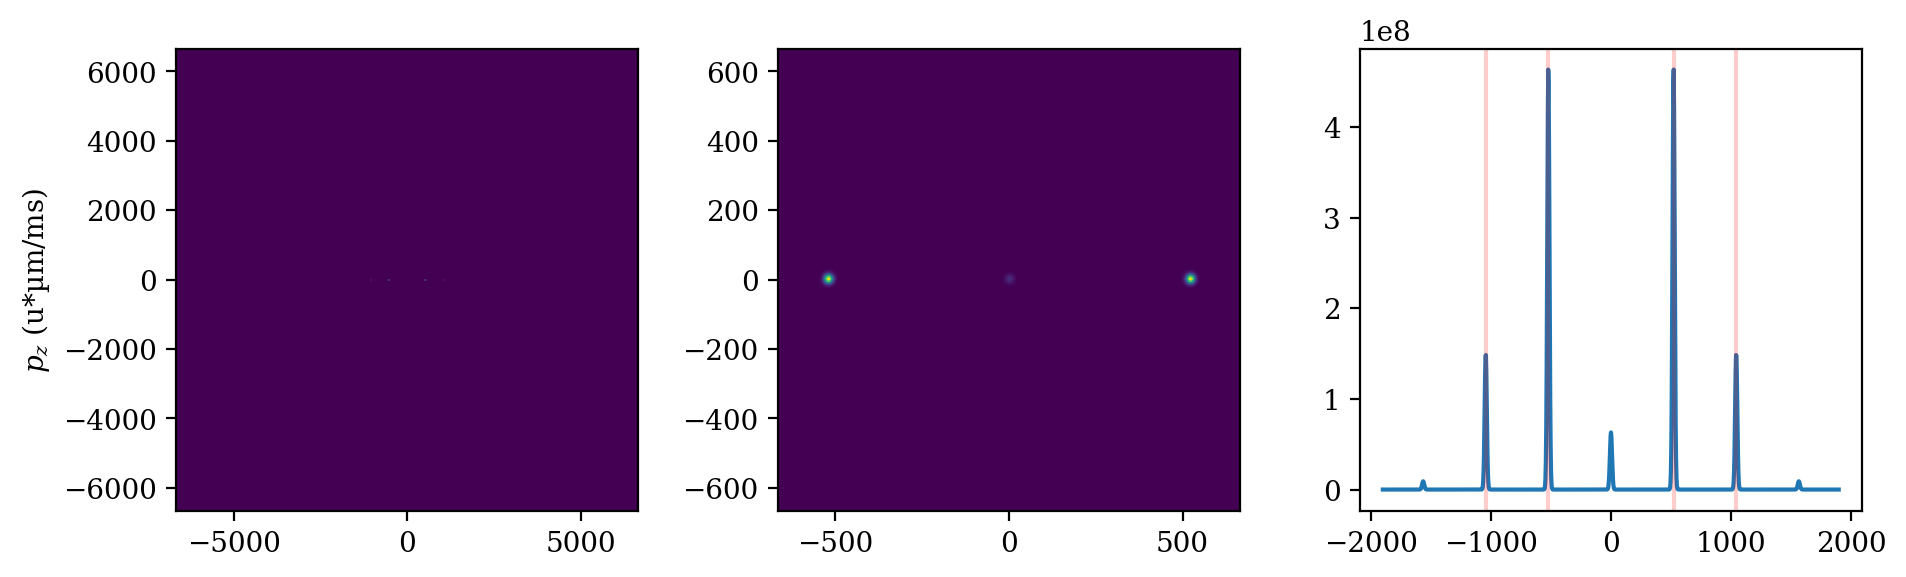

time = 1.35 µs
1.0000000000000413 |psi|^2
0.998501748126976 |phi|^2


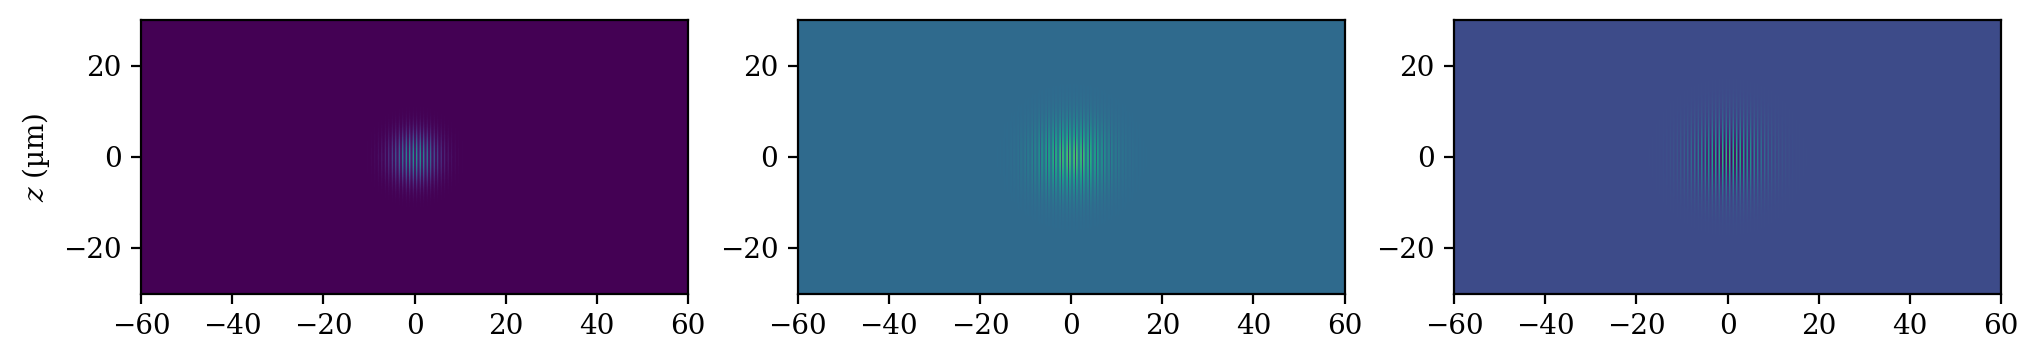

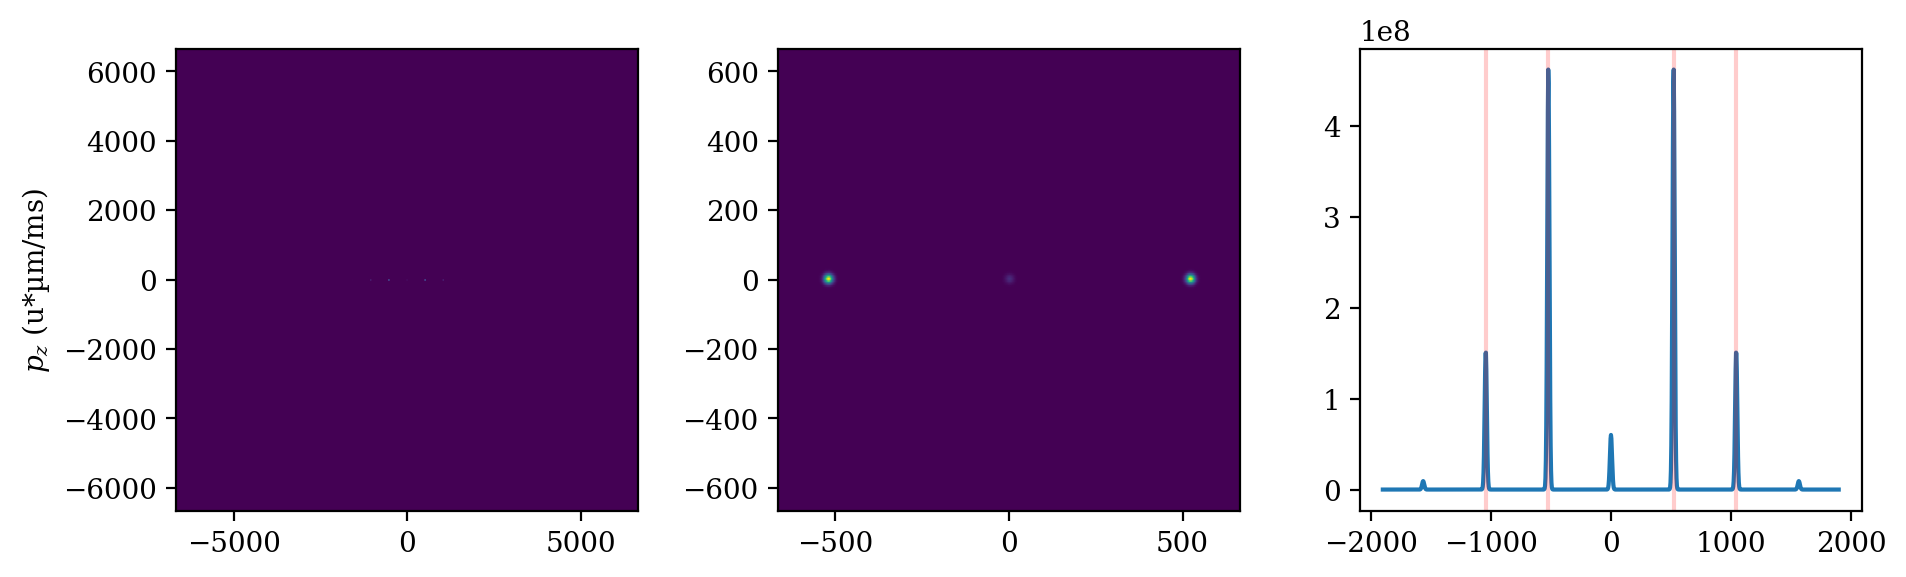

time = 1.36 µs
1.0000000000000417 |psi|^2
0.9985017481269767 |phi|^2


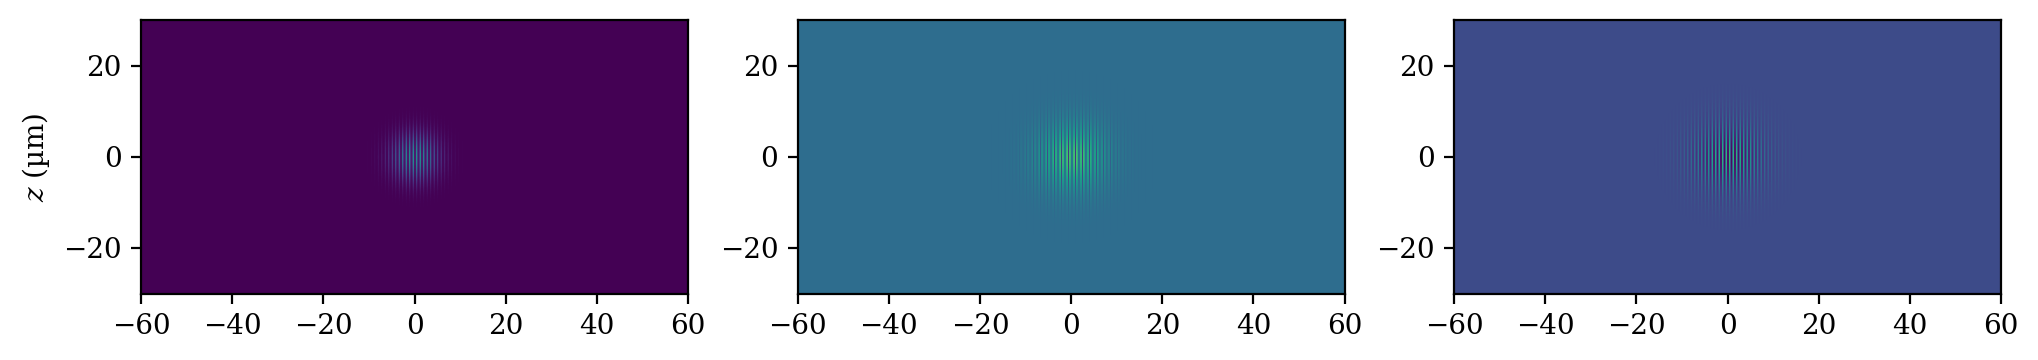

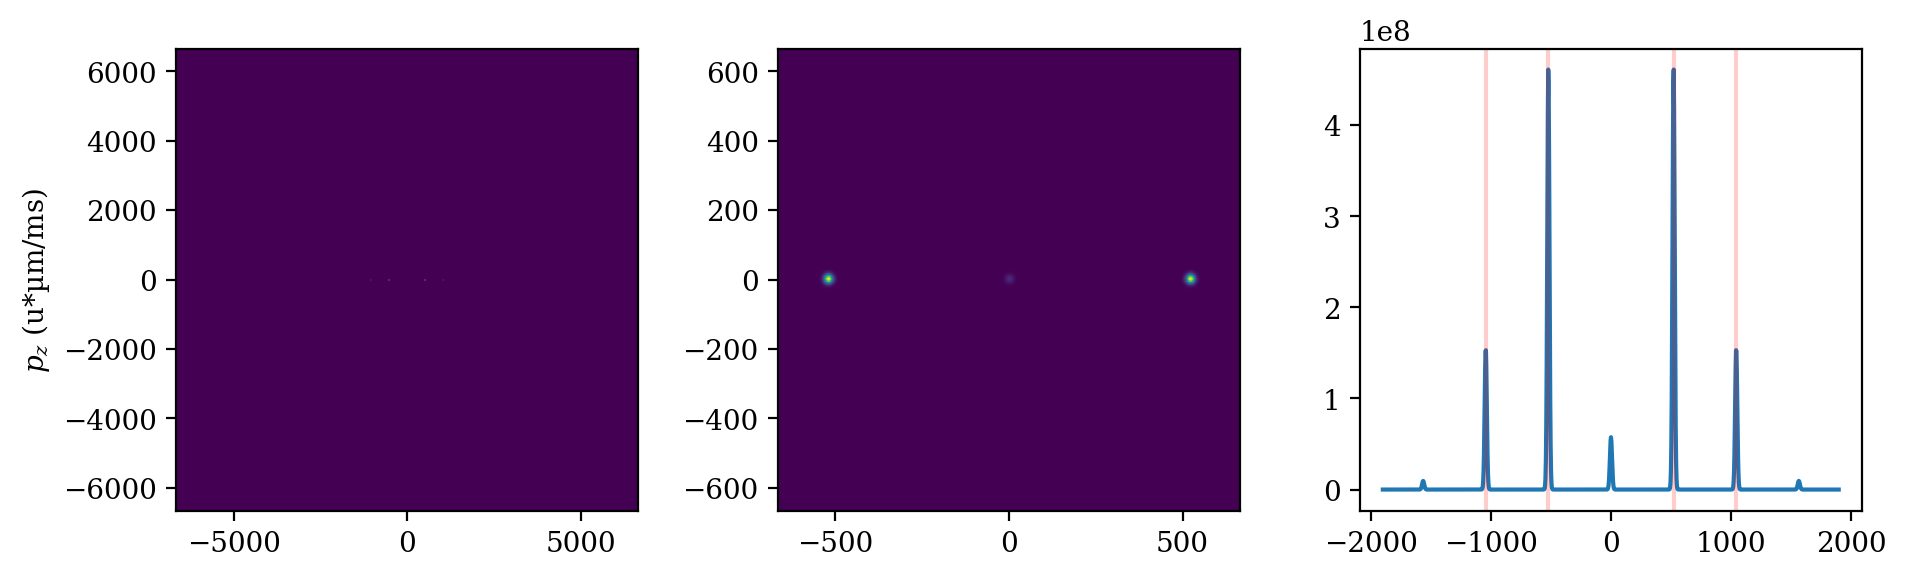

time = 1.37 µs
1.0000000000000417 |psi|^2
0.9985017481269775 |phi|^2


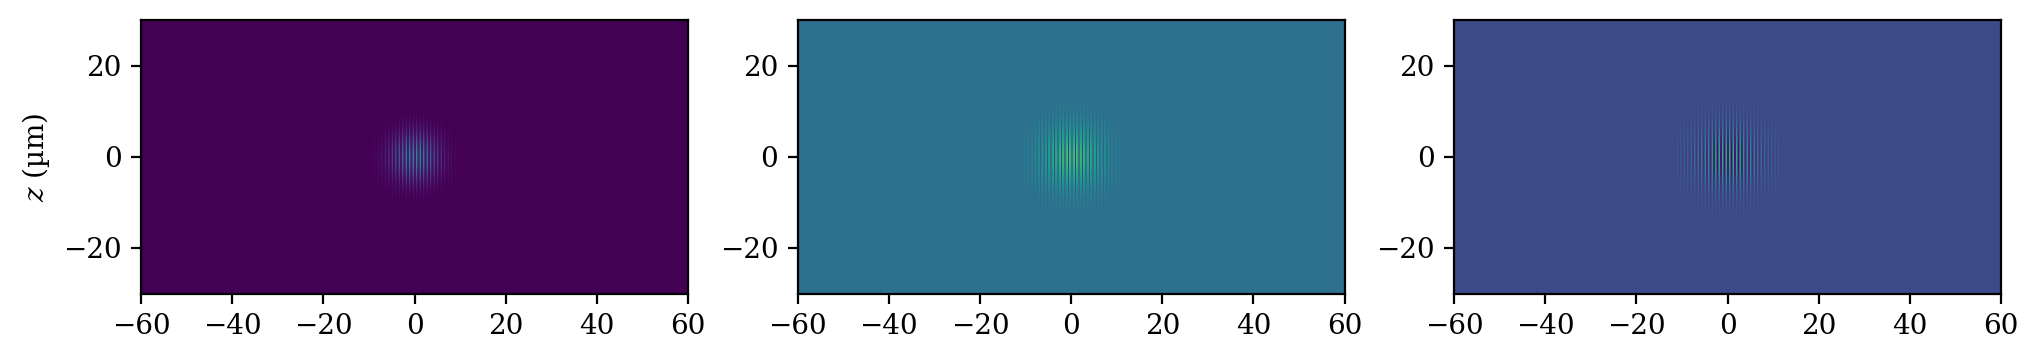

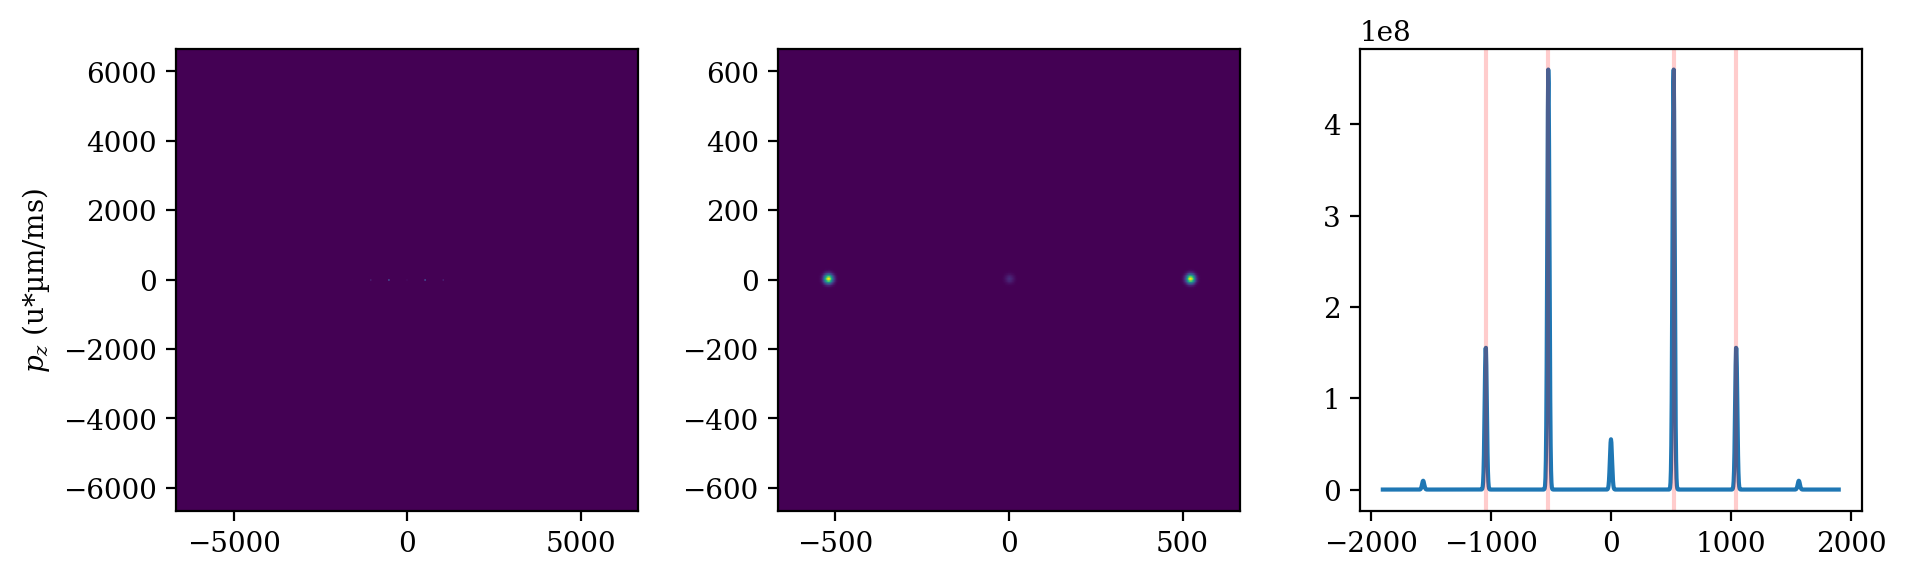

time = 1.38 µs
1.0000000000000422 |psi|^2
0.9985017481269771 |phi|^2


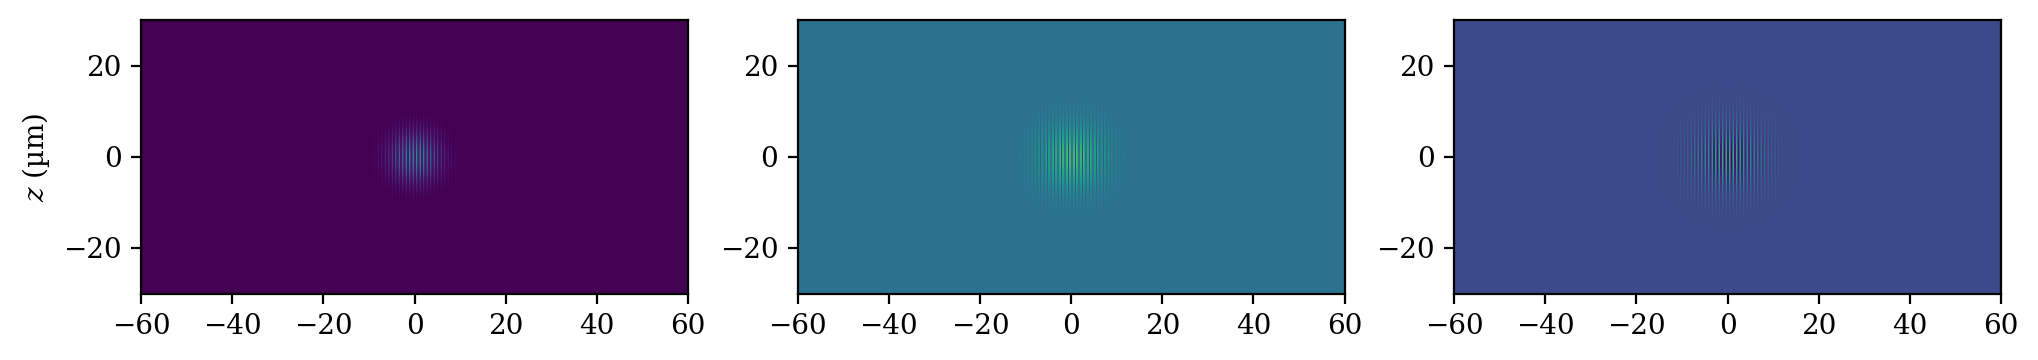

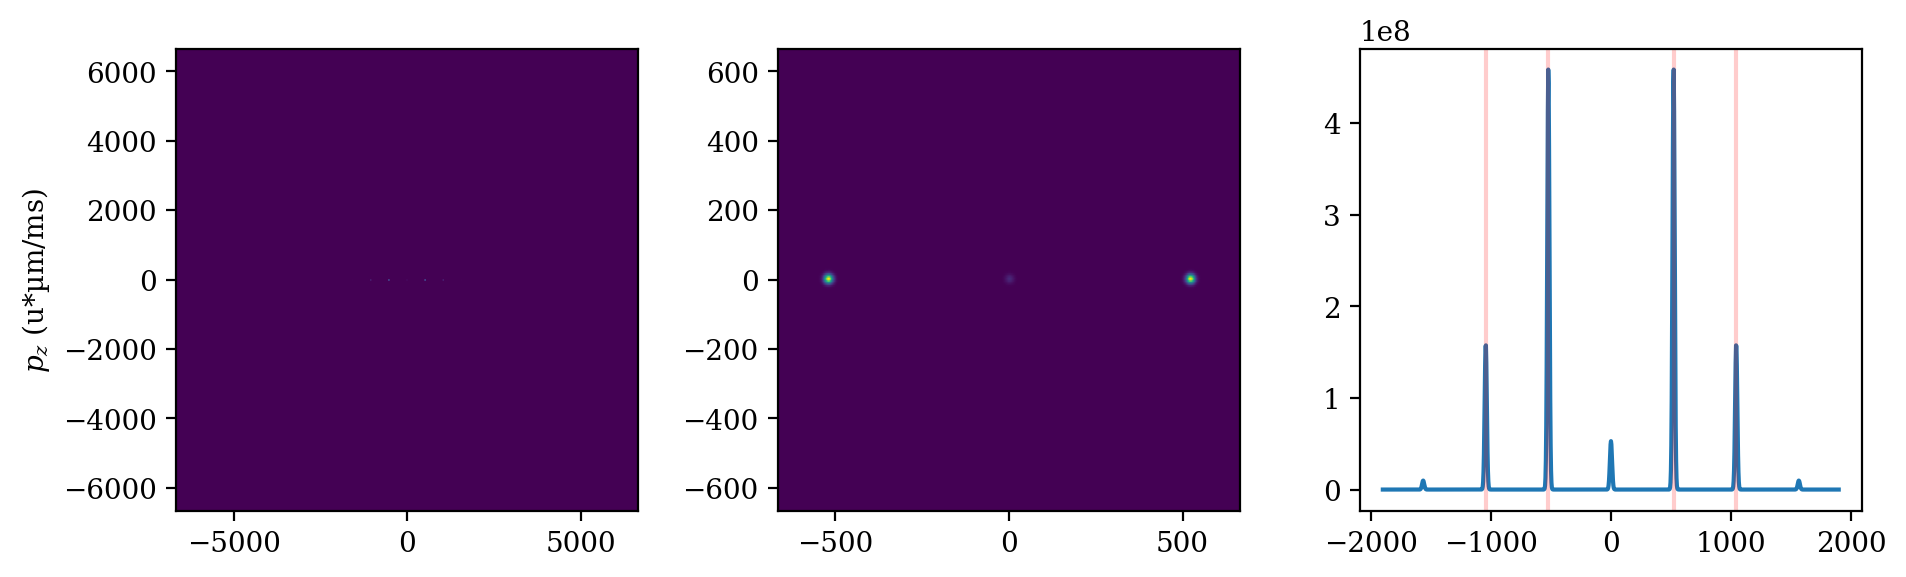

time = 1.39 µs
1.0000000000000426 |psi|^2
0.9985017481269772 |phi|^2


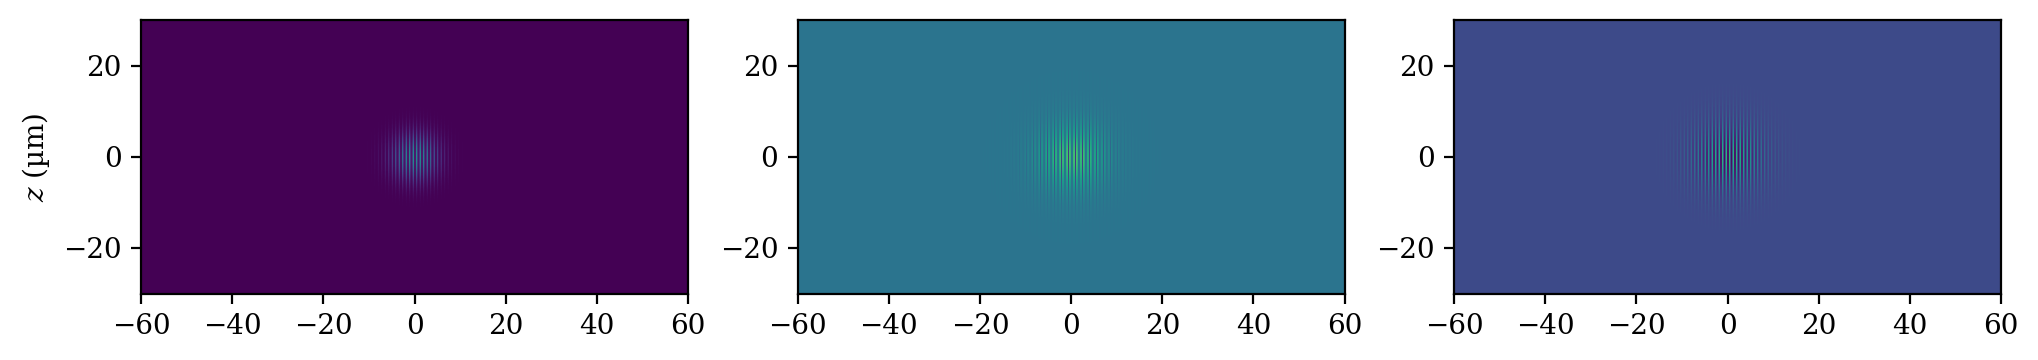

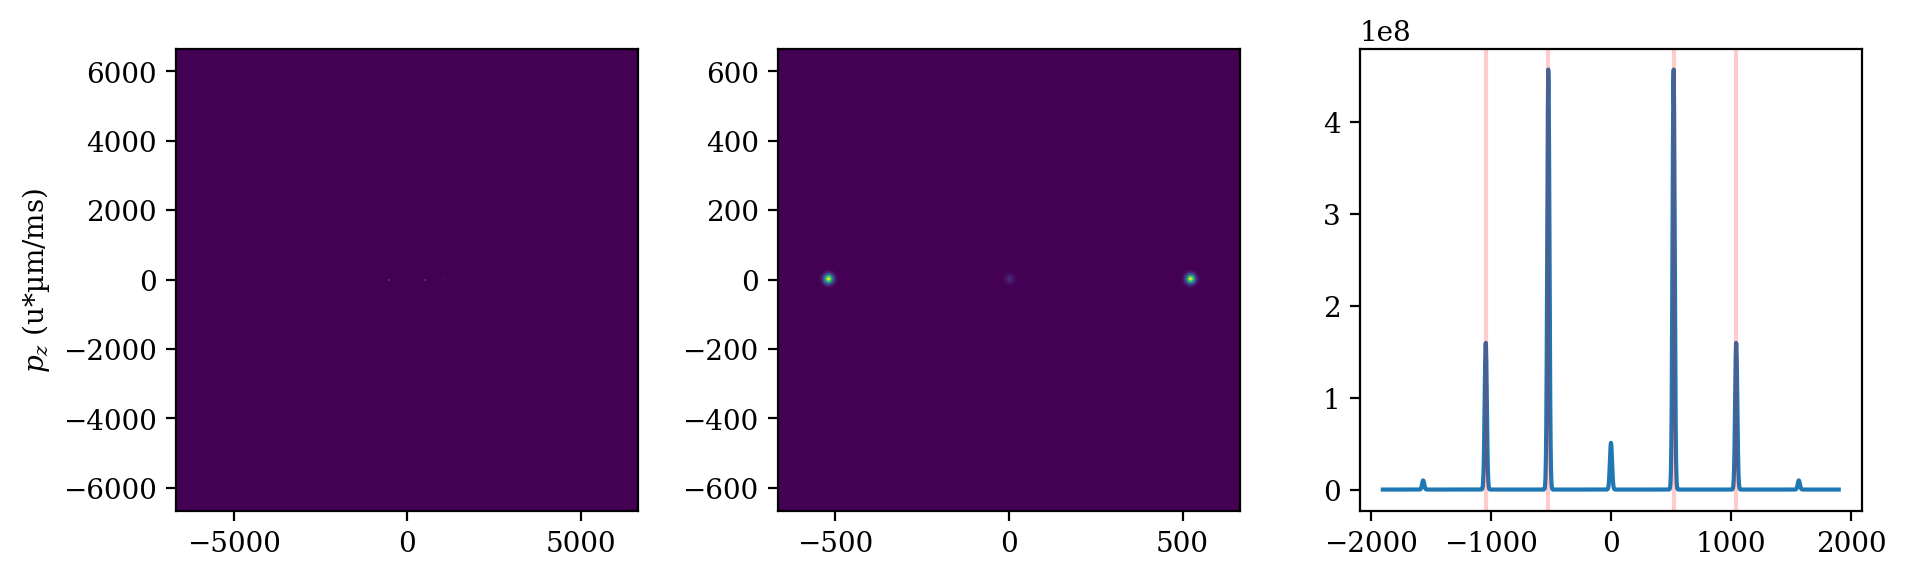

time = 1.4 µs
1.0000000000000426 |psi|^2
0.9985017481269777 |phi|^2


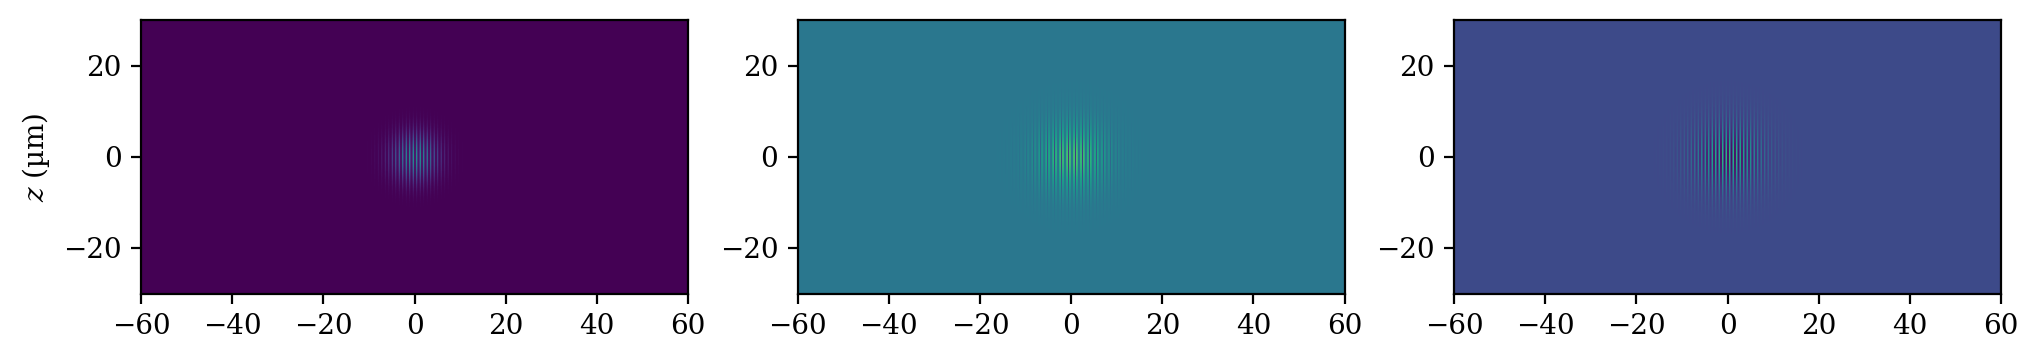

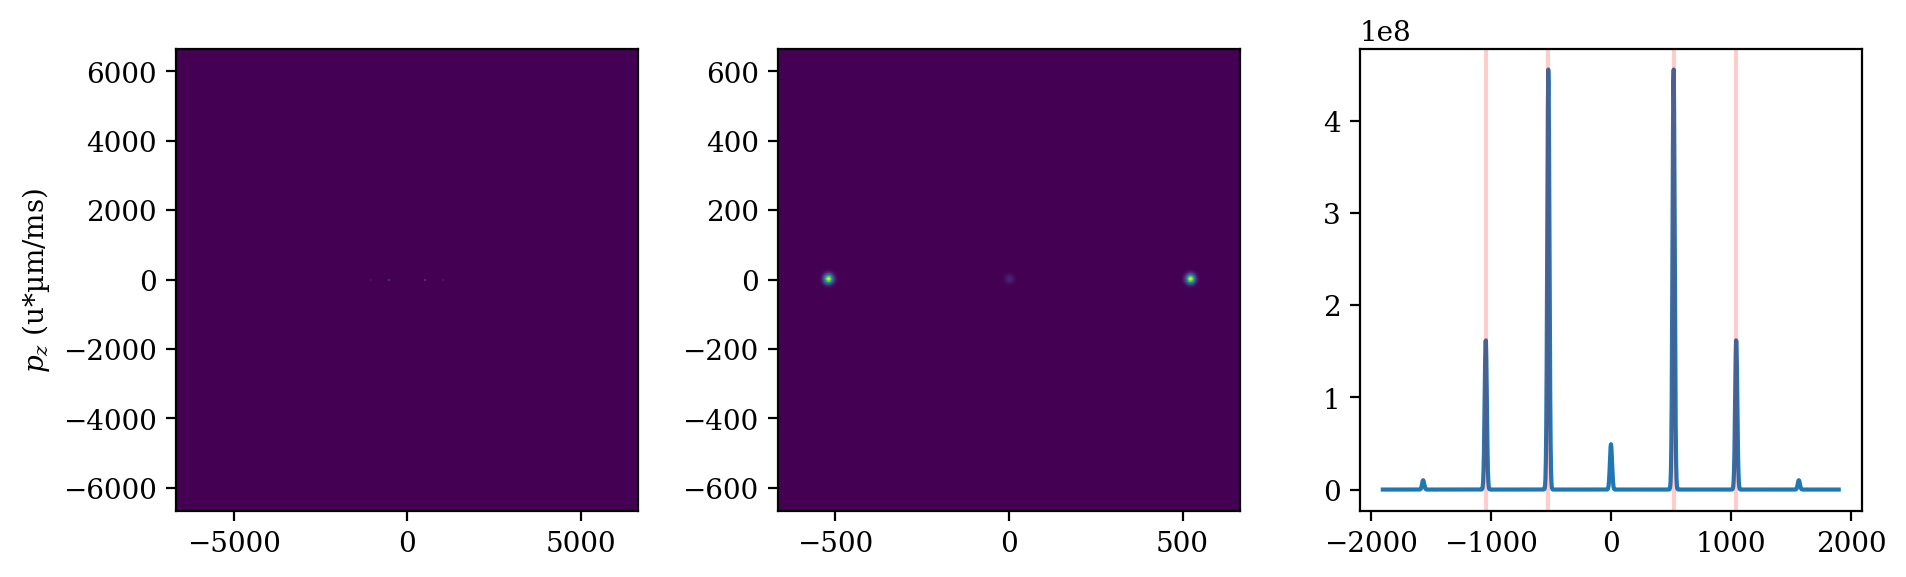

time = 1.41 µs
1.0000000000000429 |psi|^2
0.9985017481269783 |phi|^2


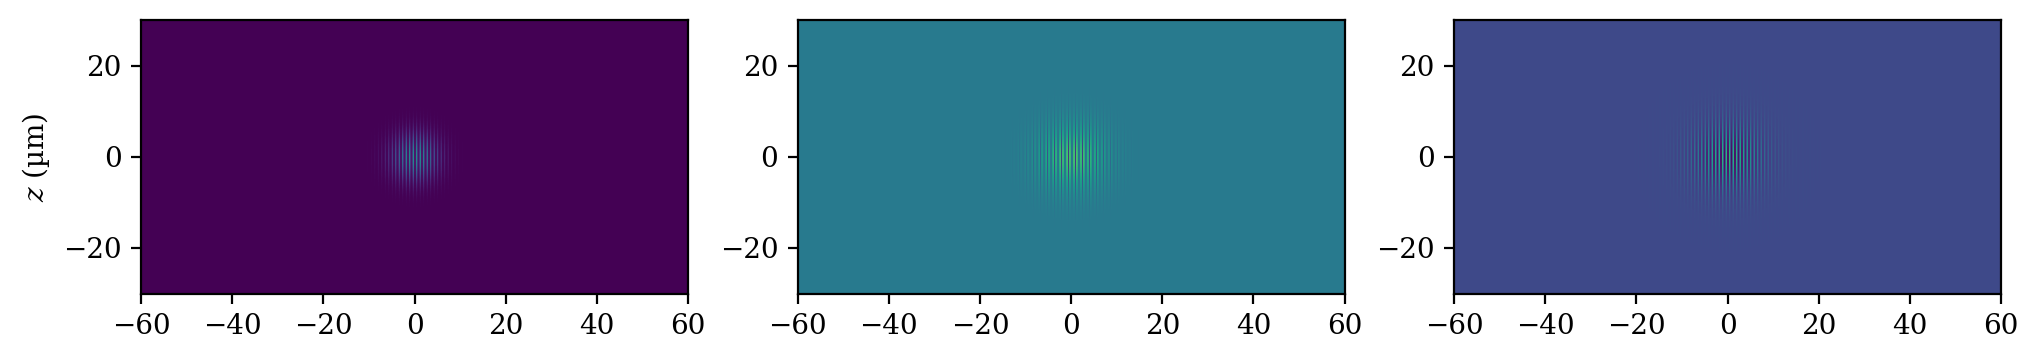

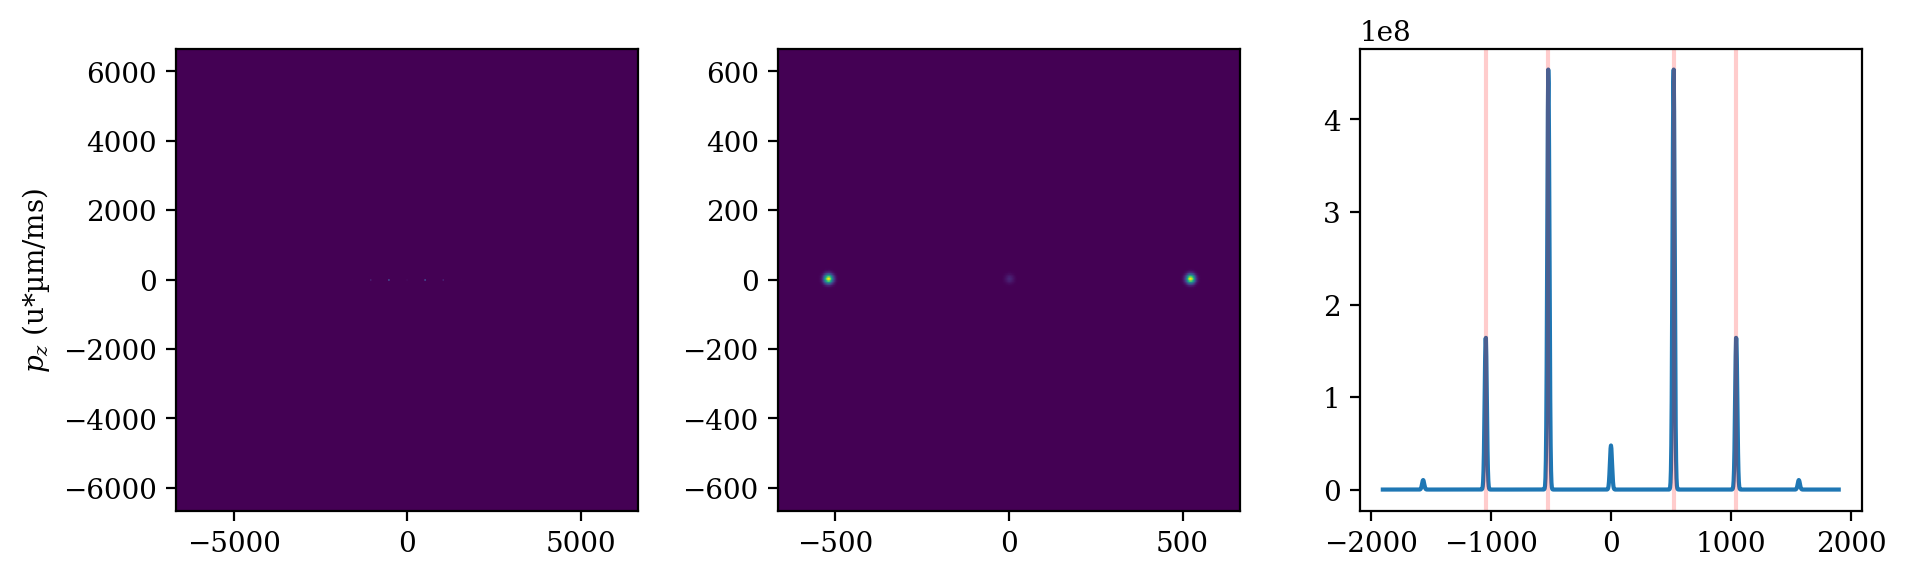

time = 1.42 µs
1.000000000000043 |psi|^2
0.9985017481269792 |phi|^2


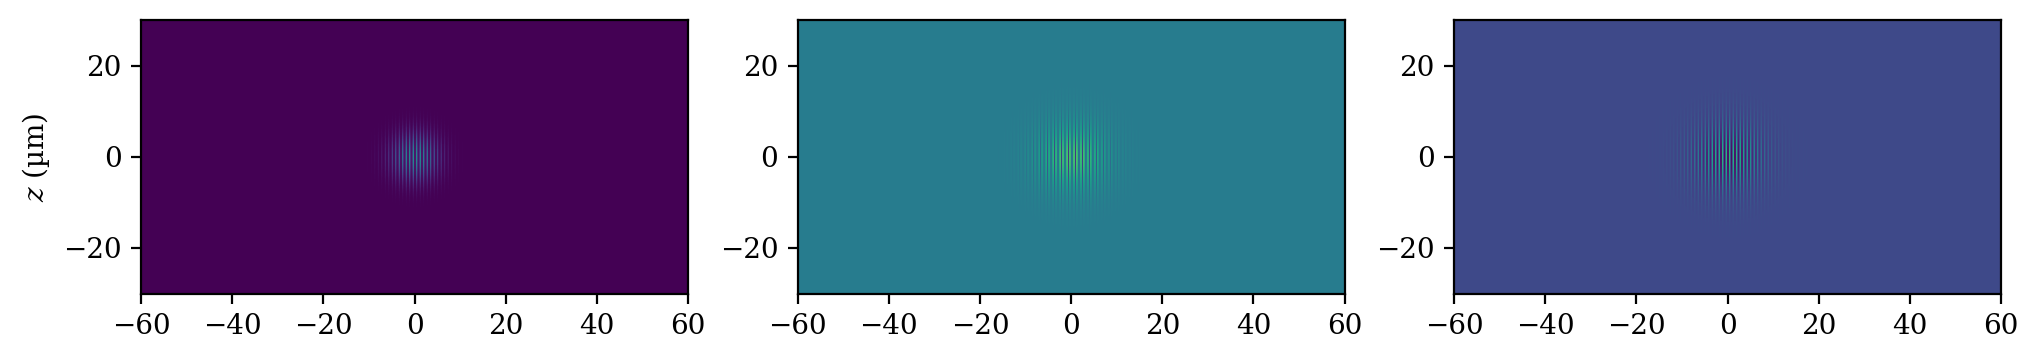

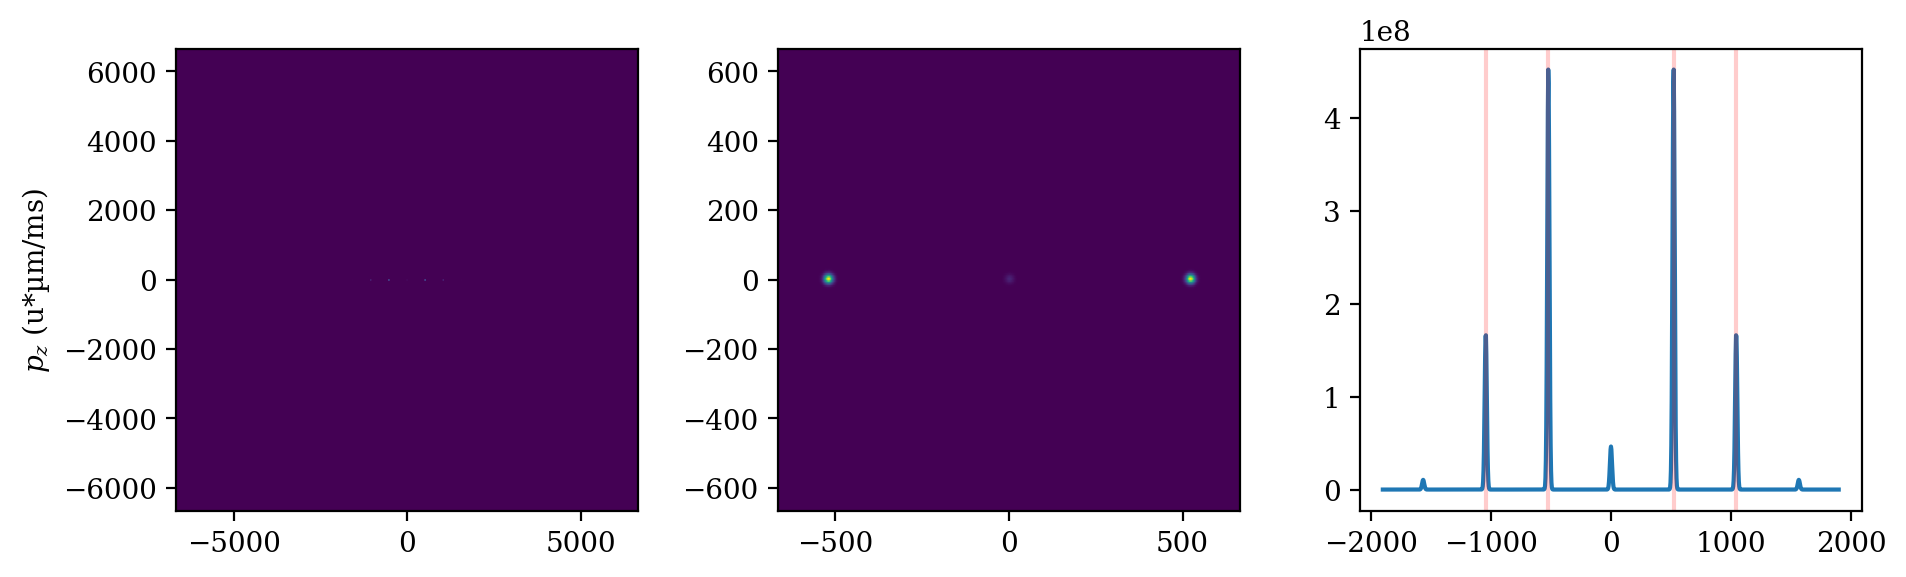

time = 1.43 µs
1.0000000000000435 |psi|^2
0.9985017481269789 |phi|^2


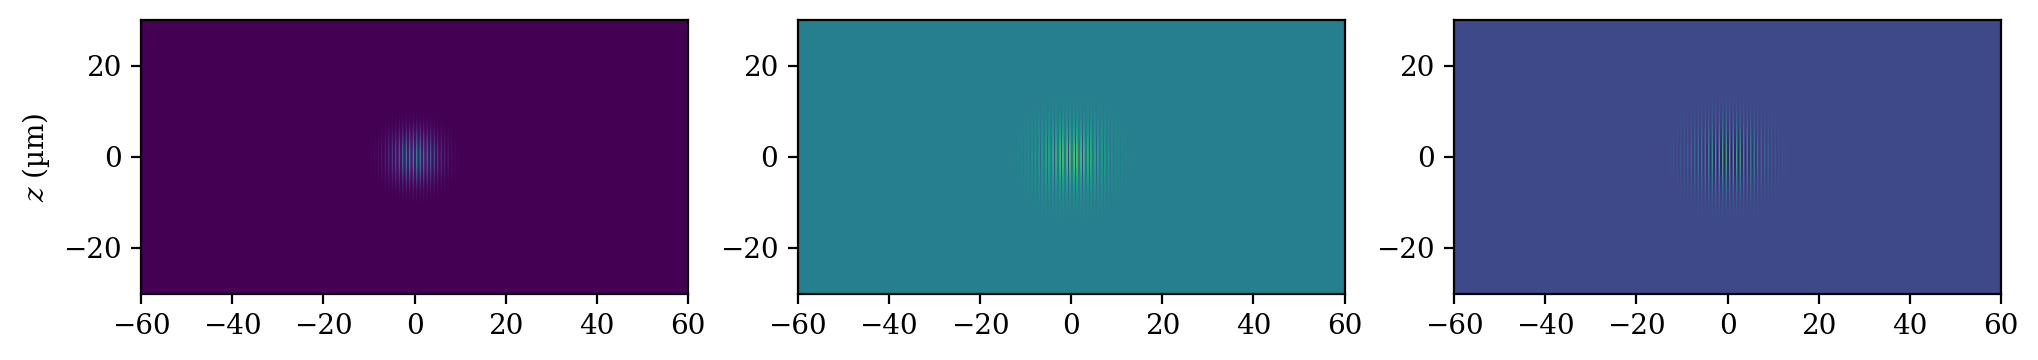

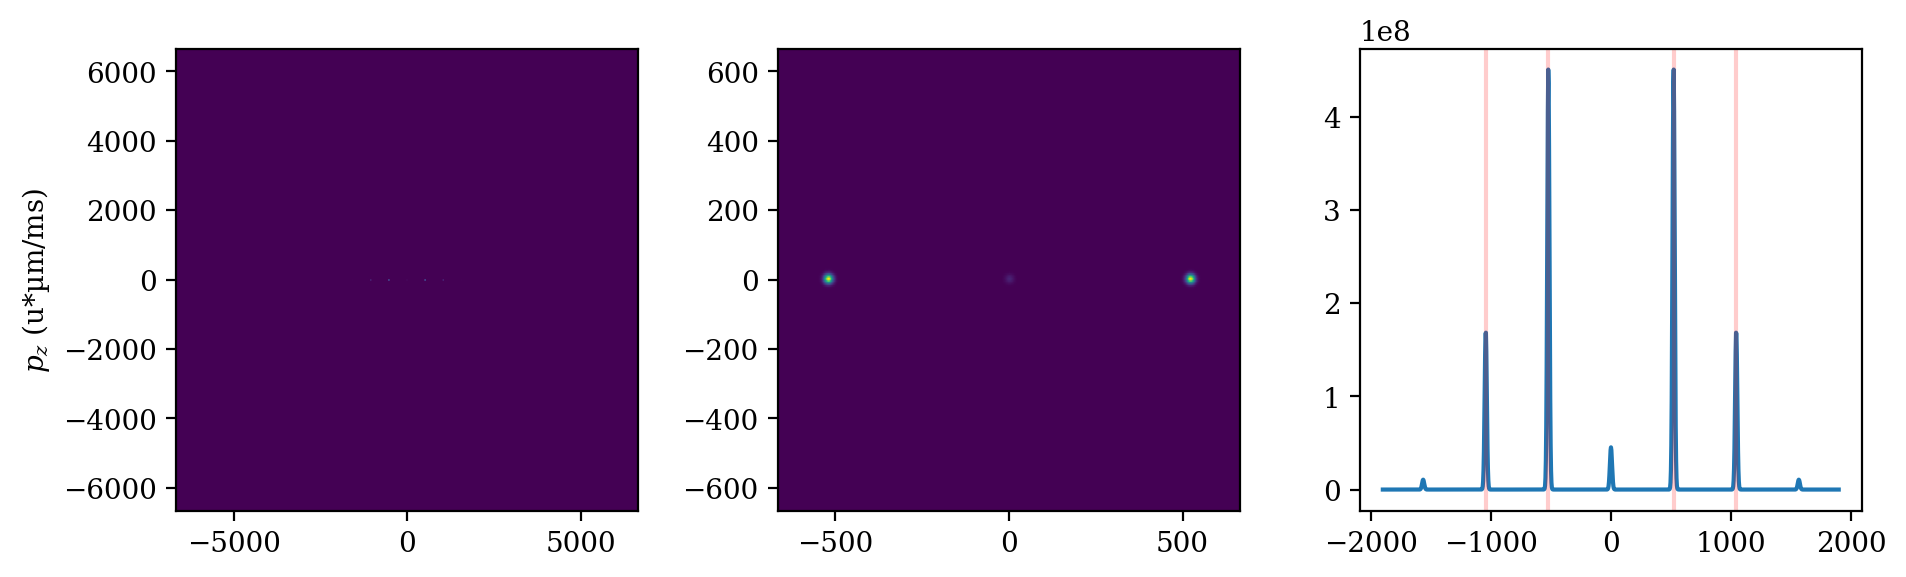

time = 1.44 µs
1.0000000000000437 |psi|^2
0.9985017481269789 |phi|^2


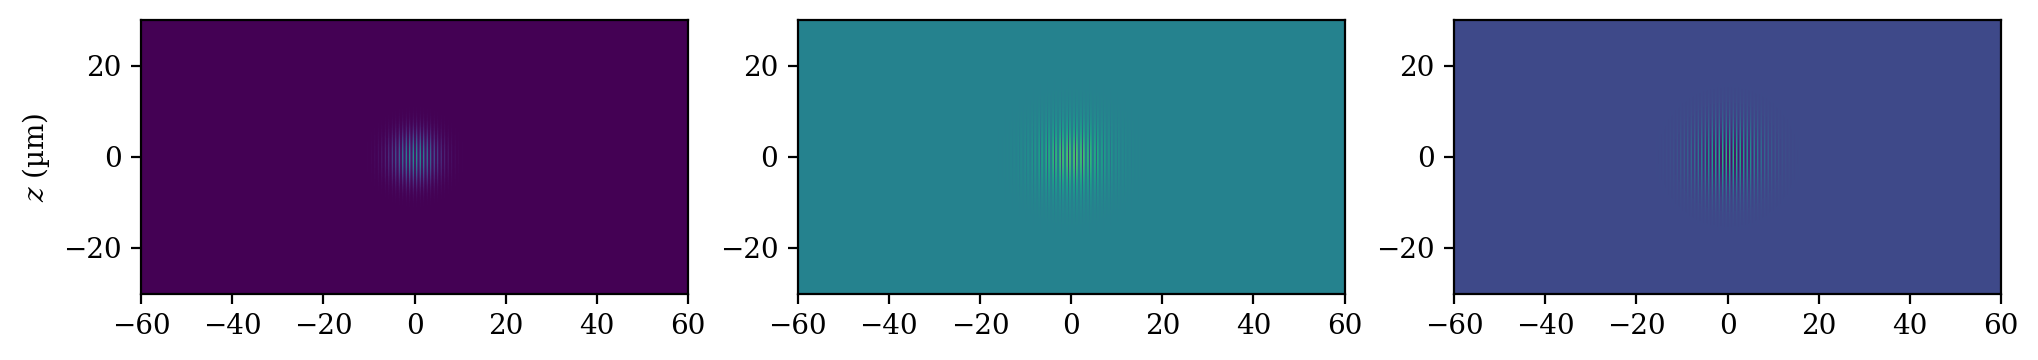

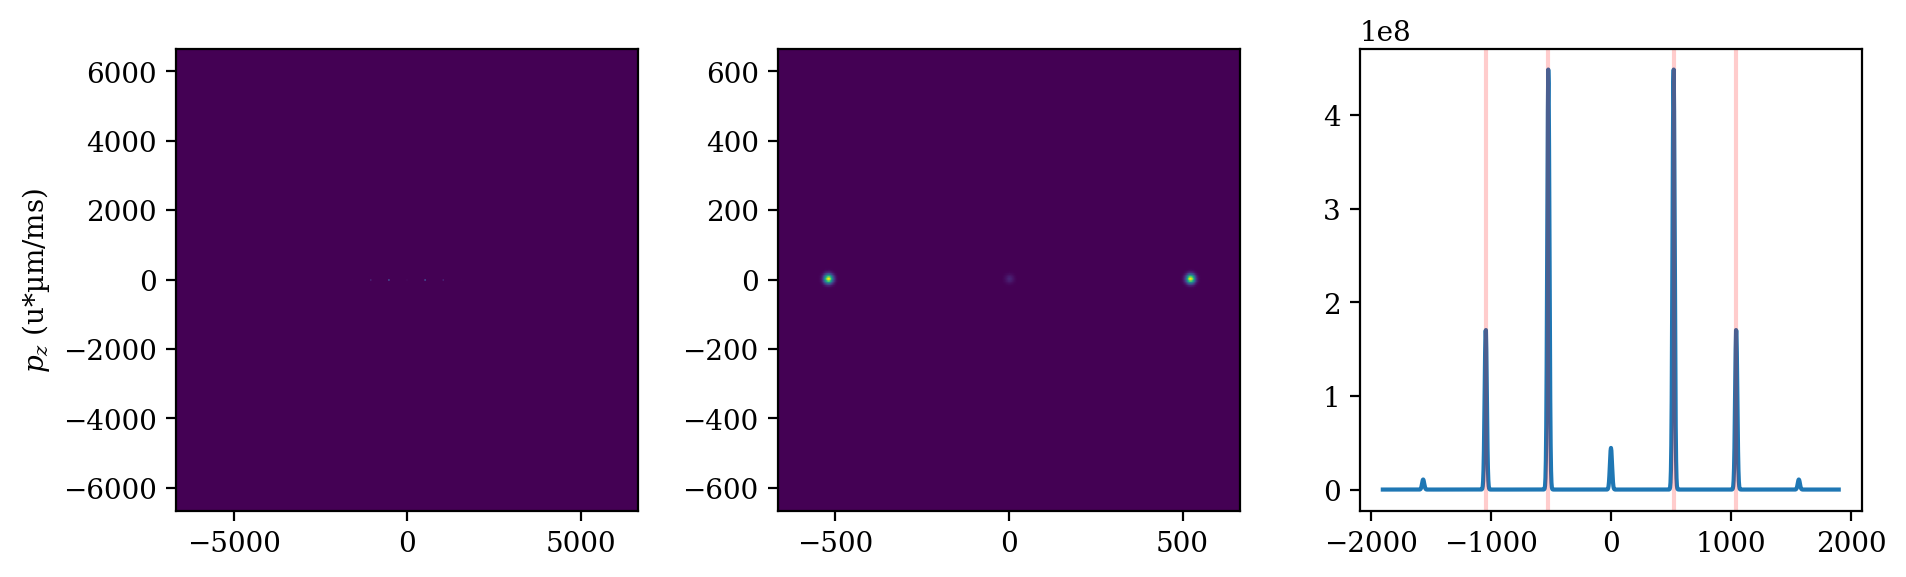

time = 1.45 µs
1.0000000000000437 |psi|^2
0.9985017481269798 |phi|^2


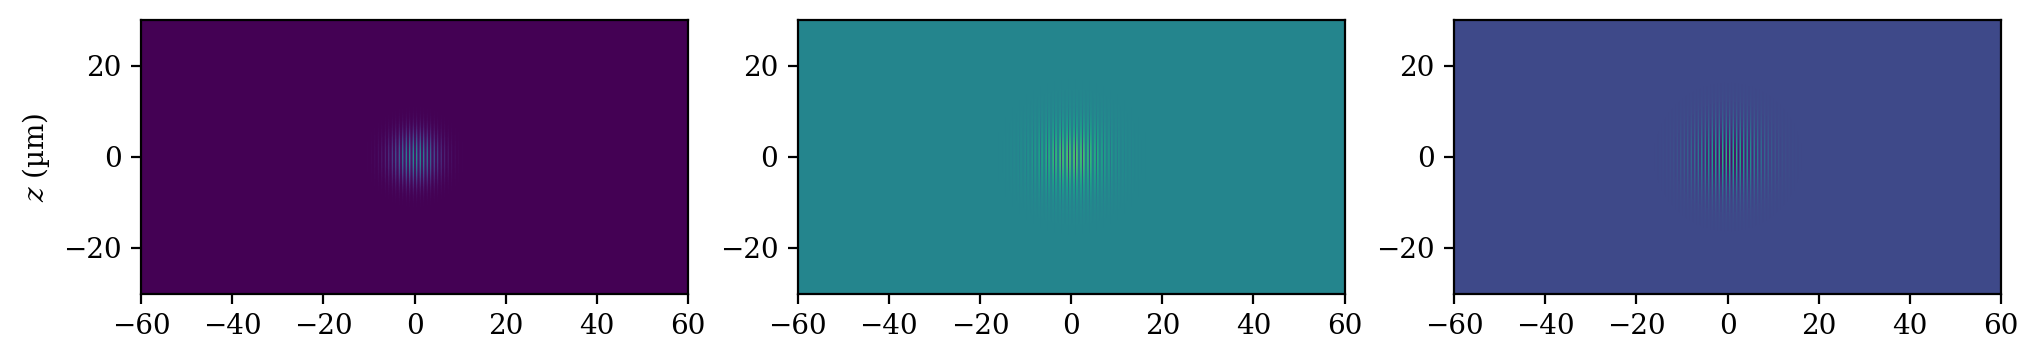

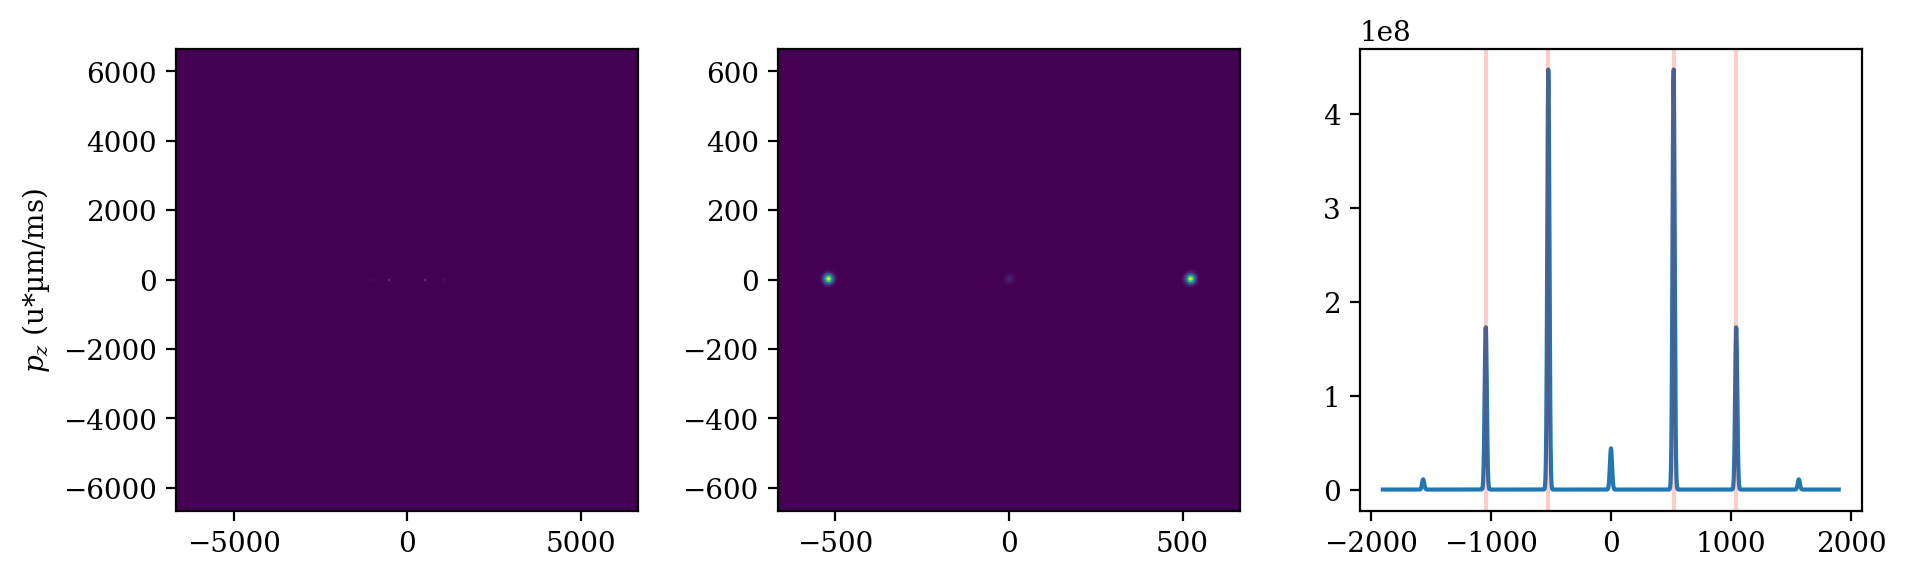

time = 1.46 µs
1.000000000000044 |psi|^2
0.9985017481269802 |phi|^2


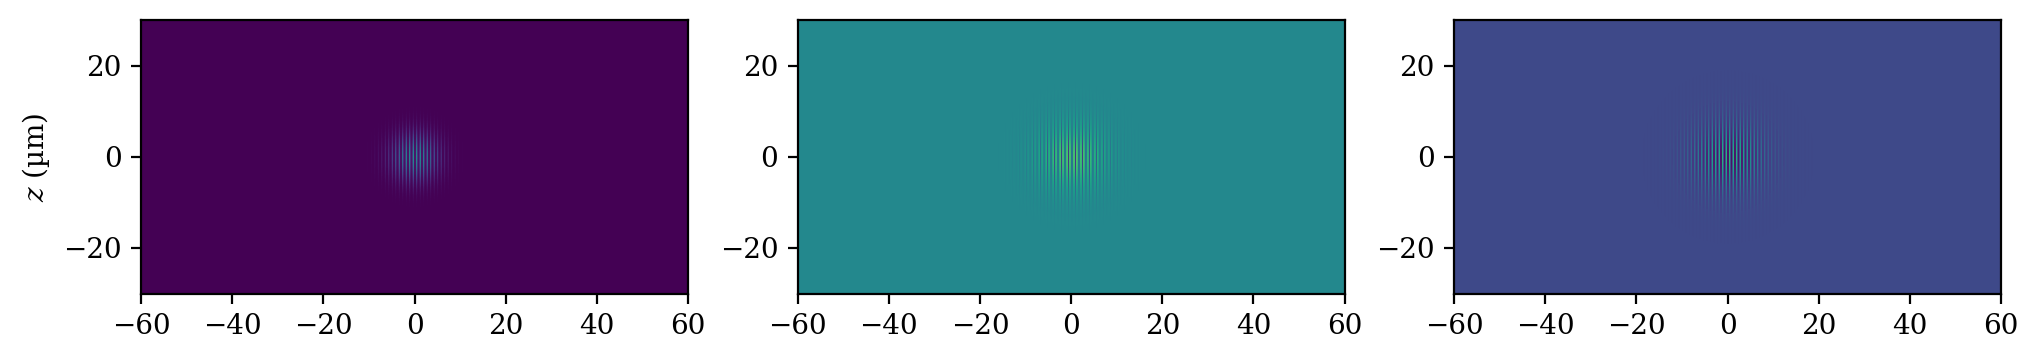

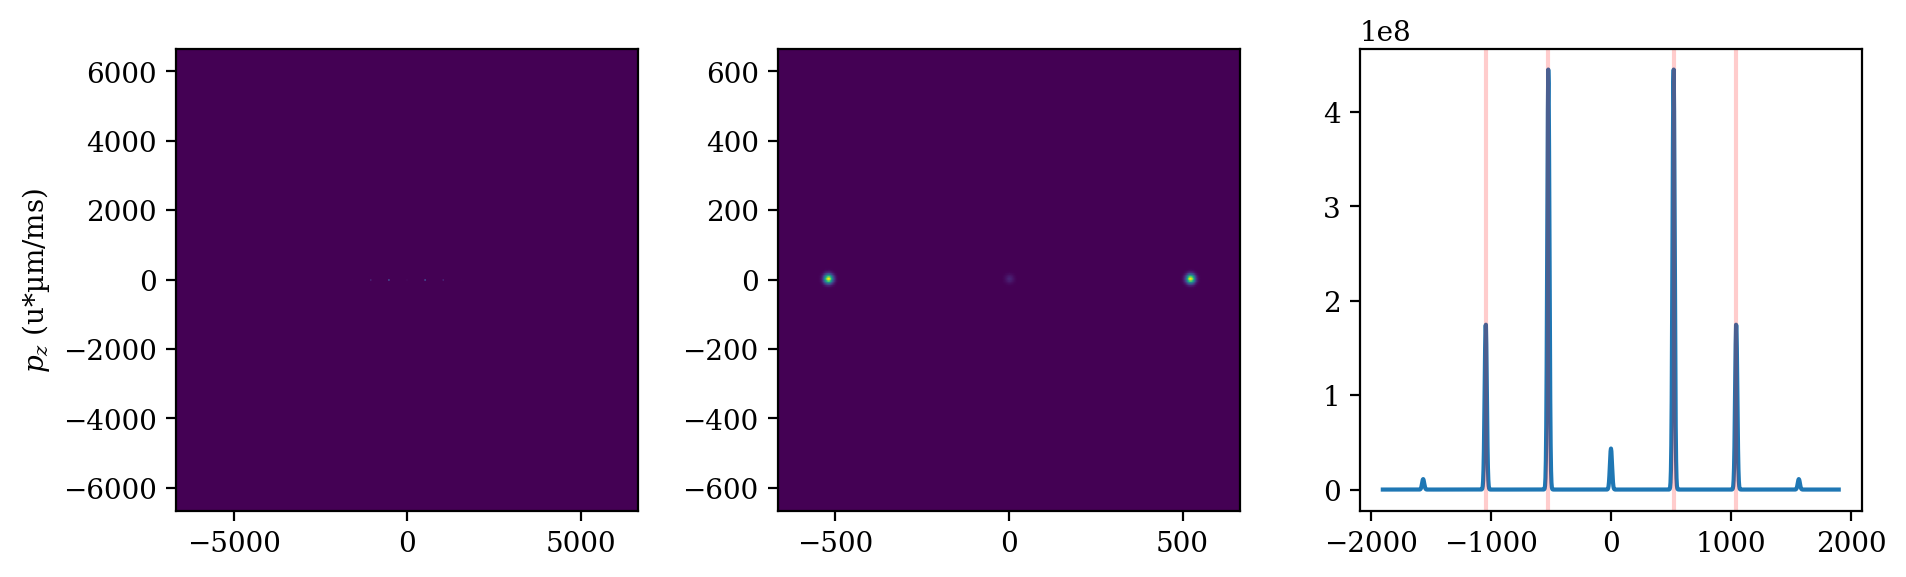

time = 1.47 µs
1.0000000000000446 |psi|^2
0.9985017481269811 |phi|^2


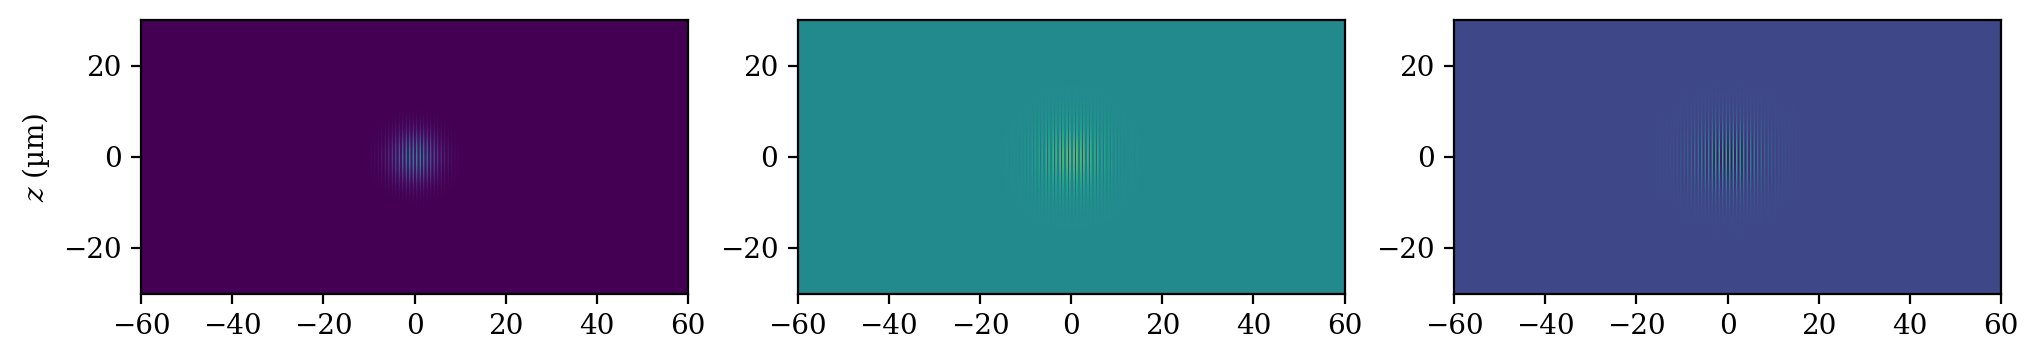

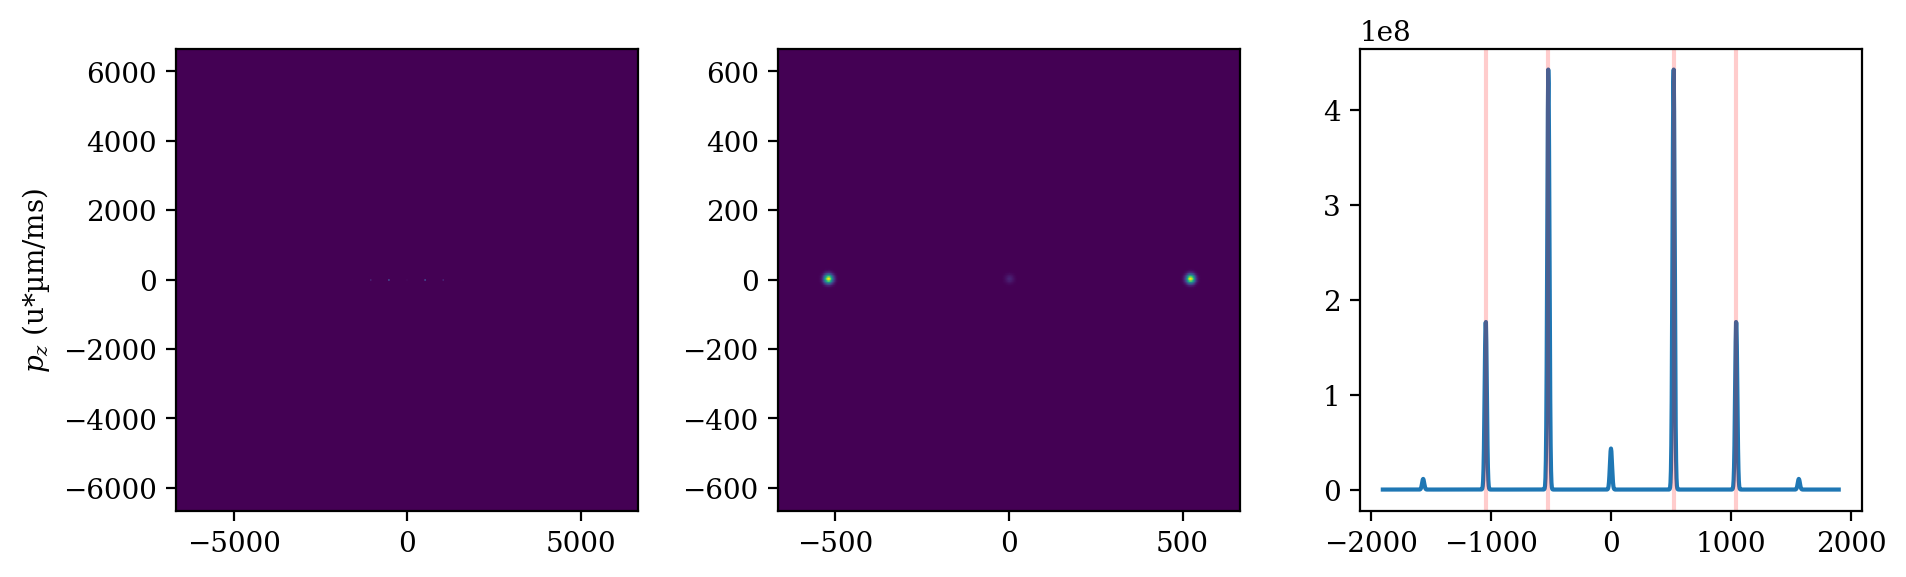

time = 1.48 µs
1.0000000000000446 |psi|^2
0.9985017481269811 |phi|^2


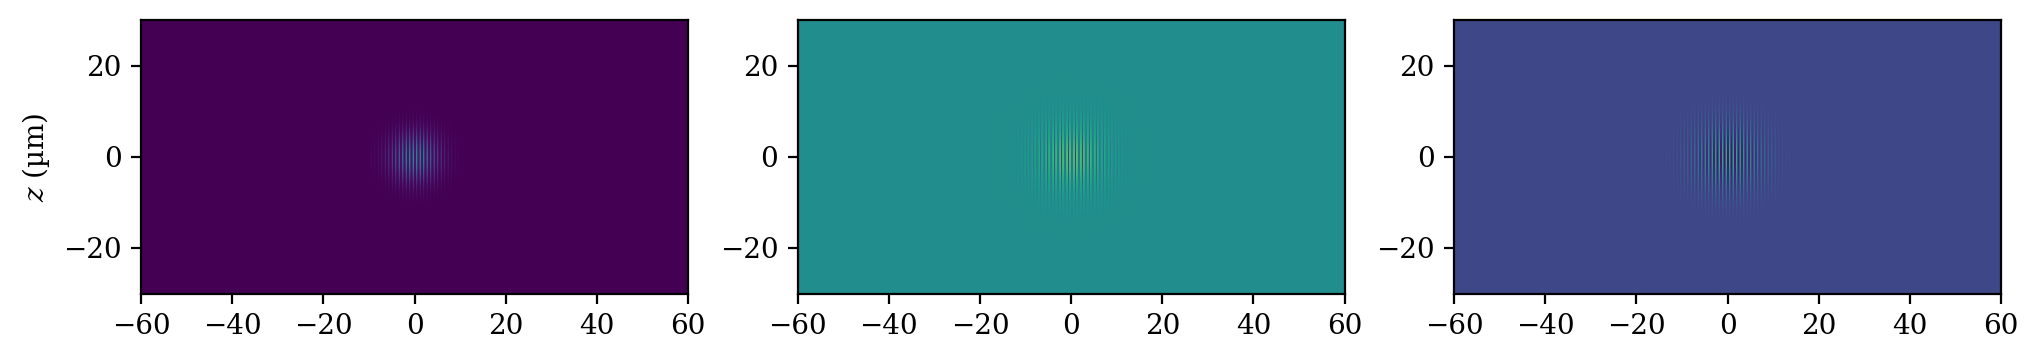

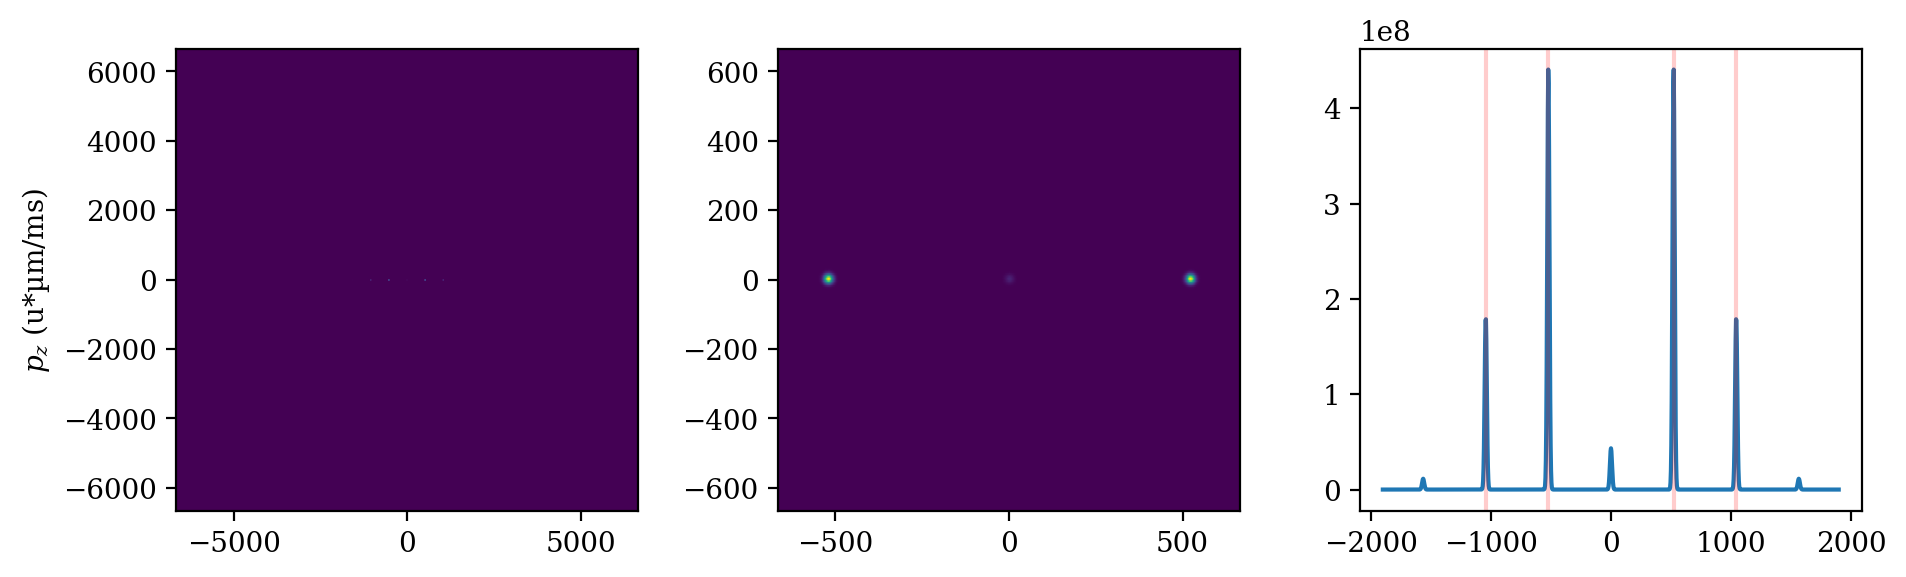

time = 1.49 µs
1.0000000000000449 |psi|^2
0.9985017481269819 |phi|^2


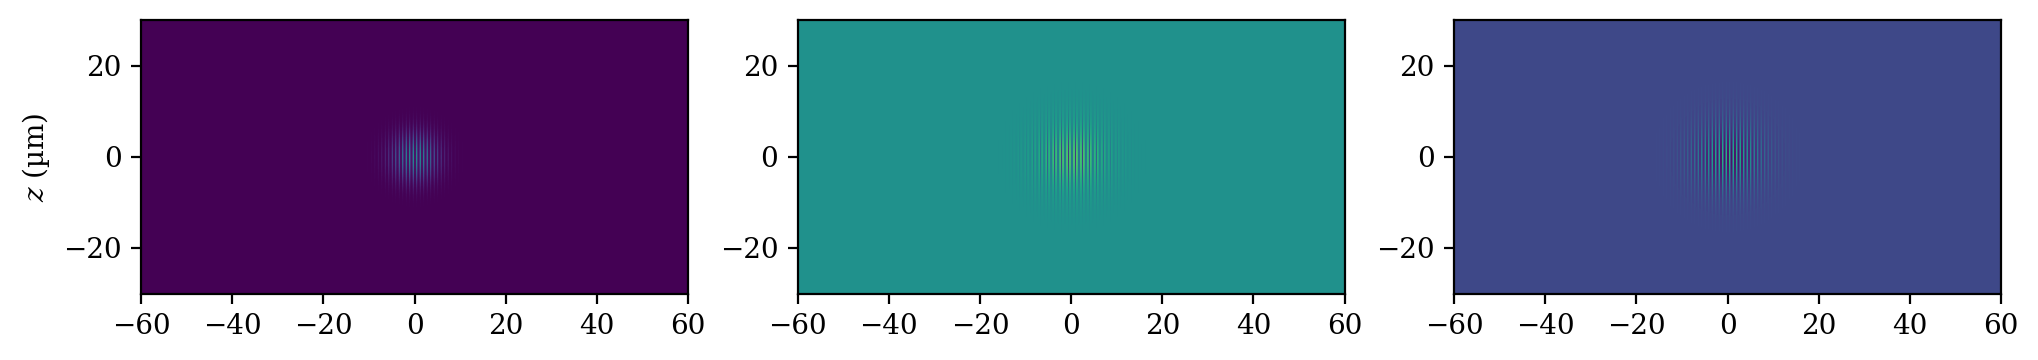

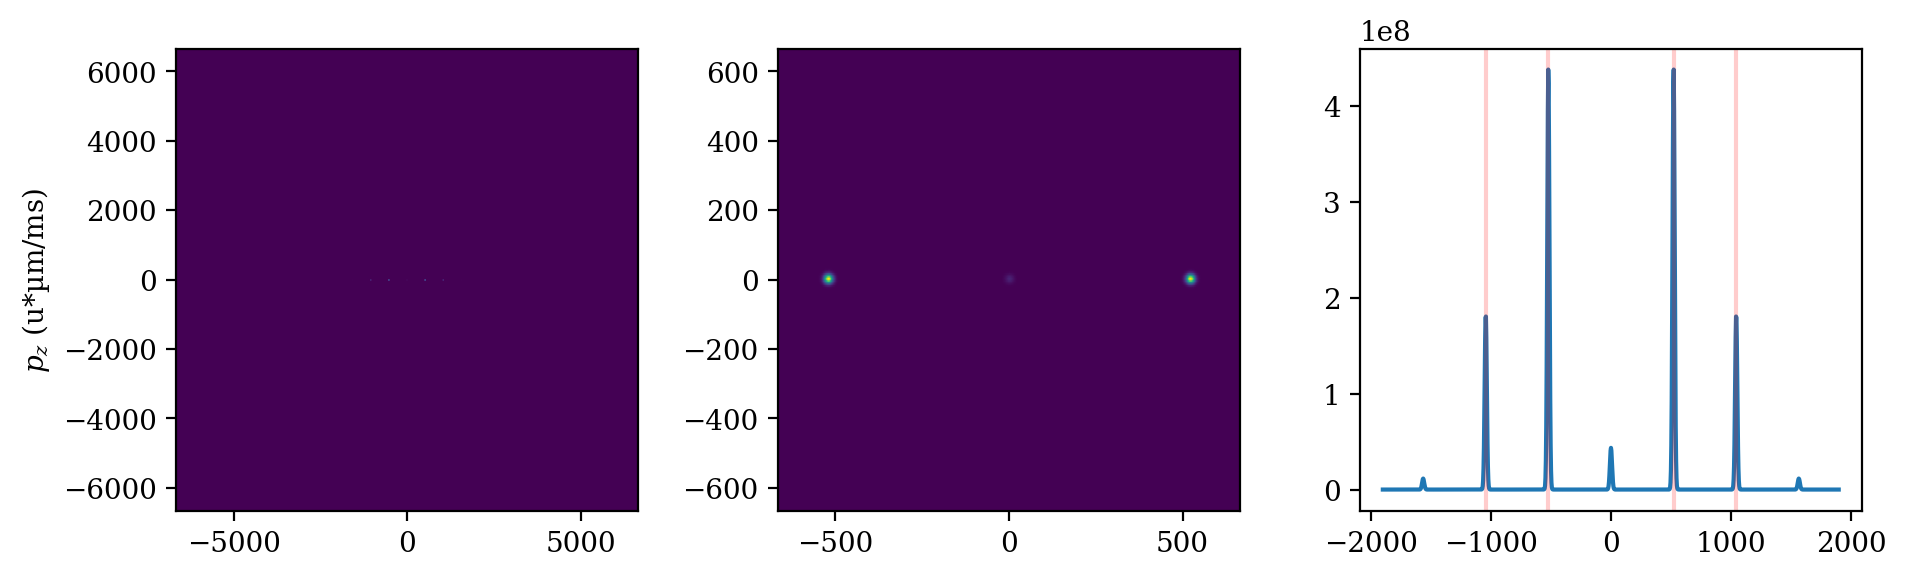

time = 1.5 µs
1.000000000000045 |psi|^2
0.9985017481269814 |phi|^2


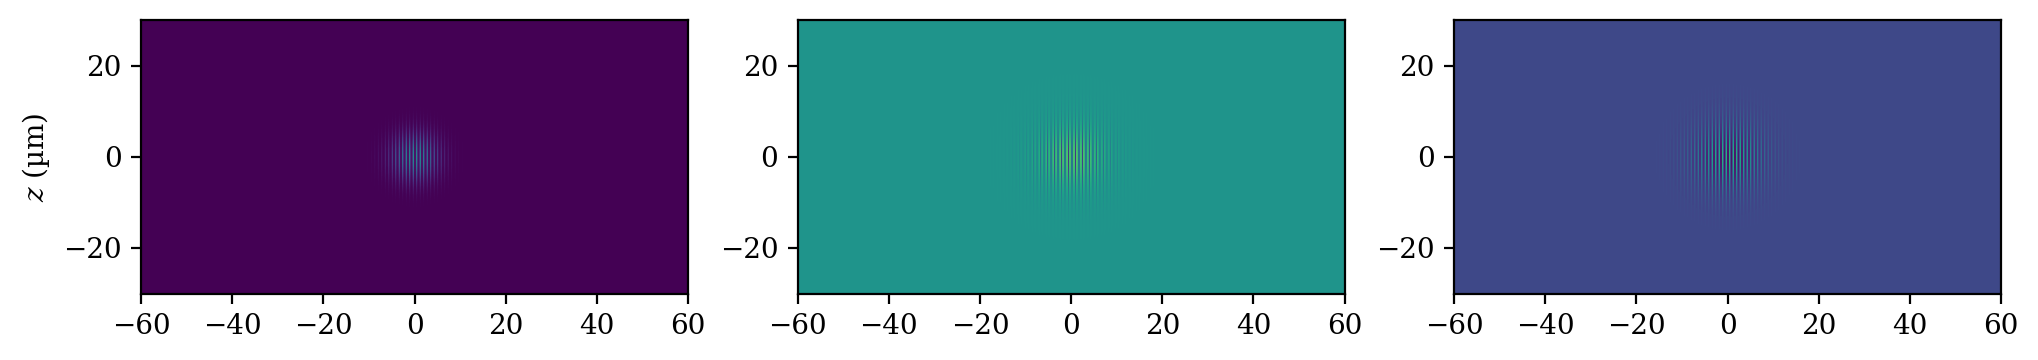

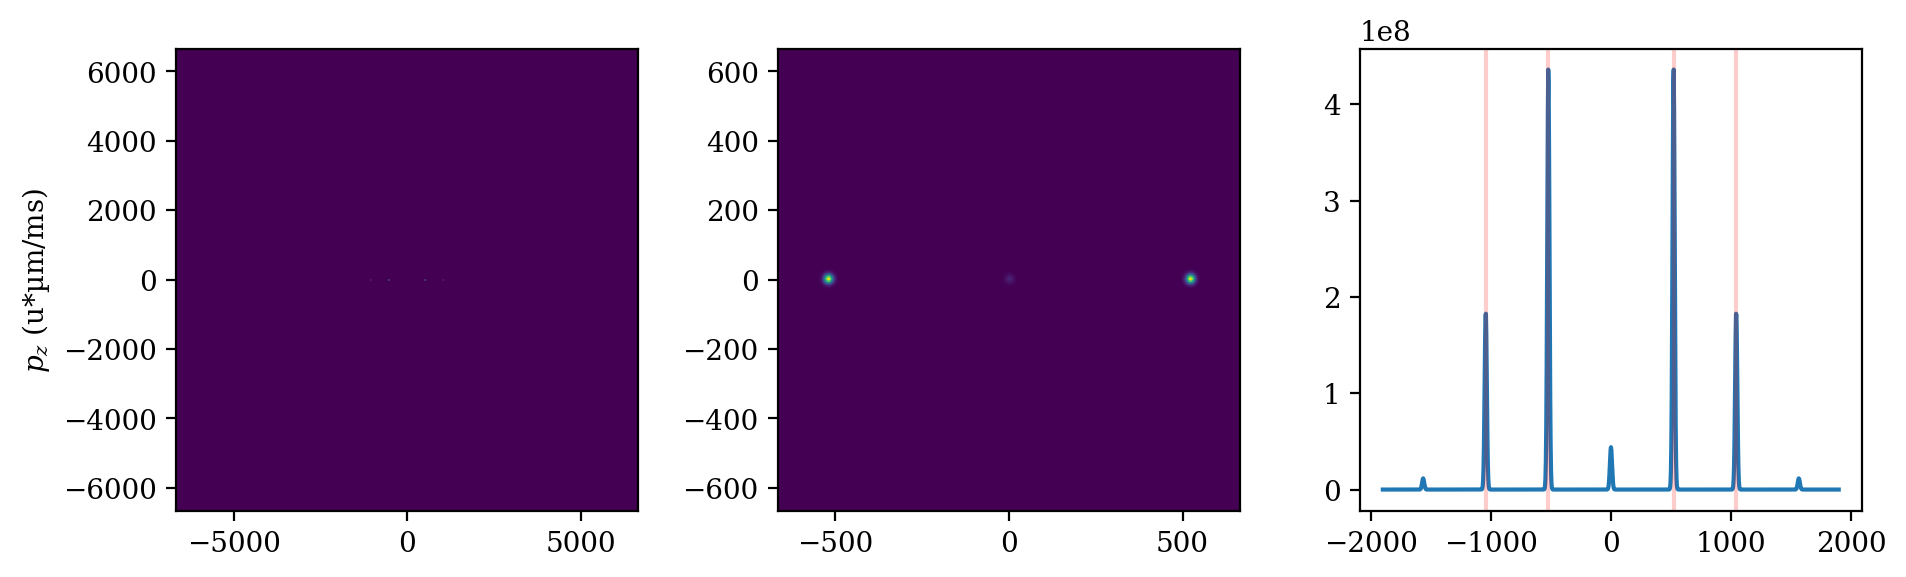

time = 1.51 µs
1.0000000000000455 |psi|^2
0.998501748126982 |phi|^2


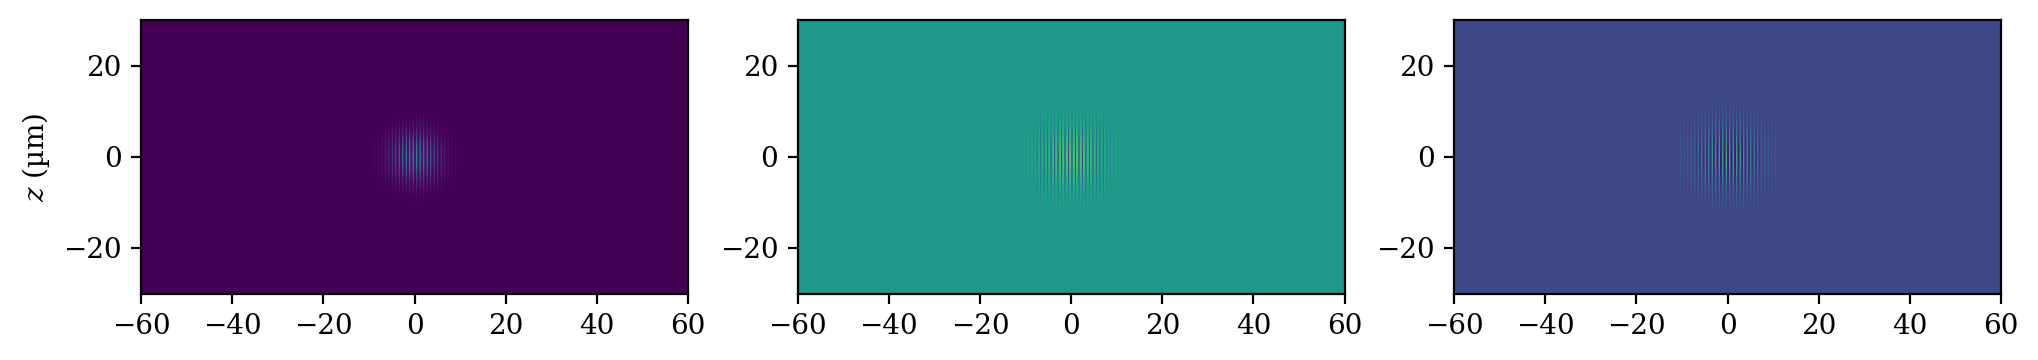

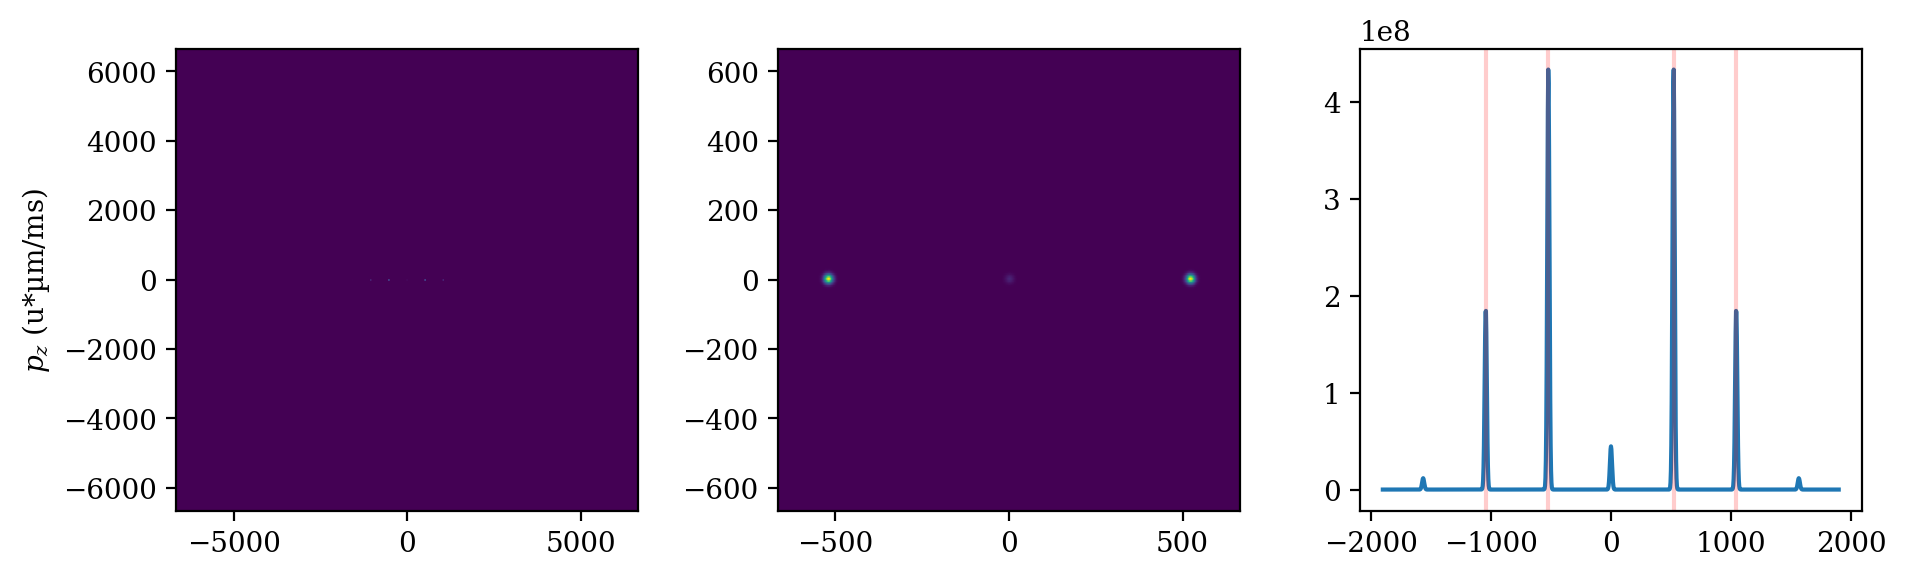

time = 1.52 µs
1.000000000000046 |psi|^2
0.9985017481269824 |phi|^2


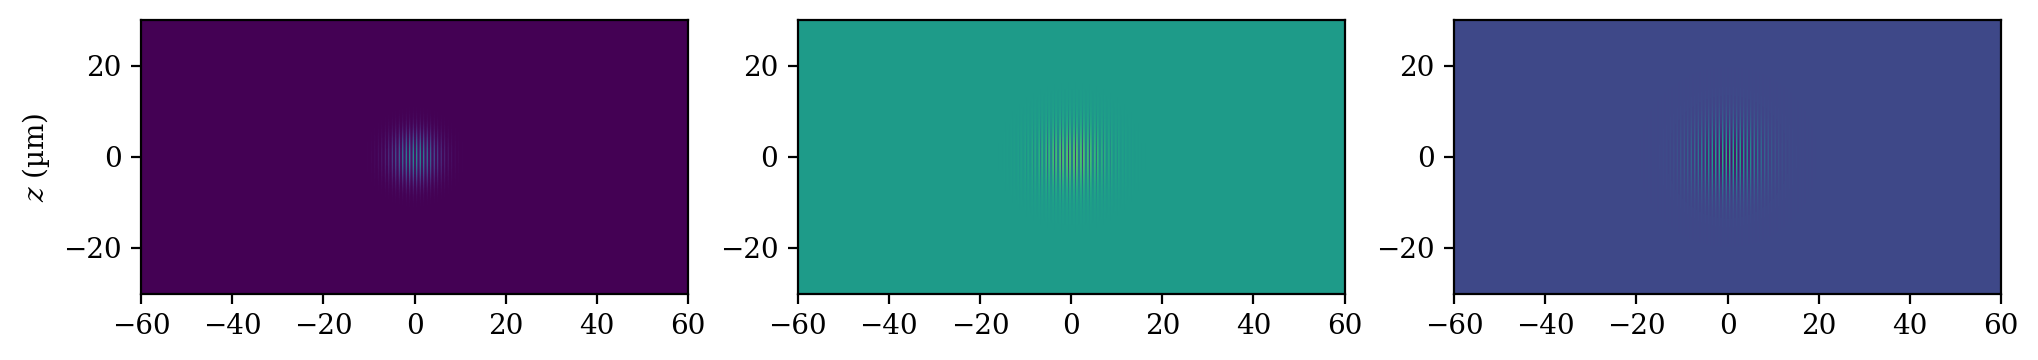

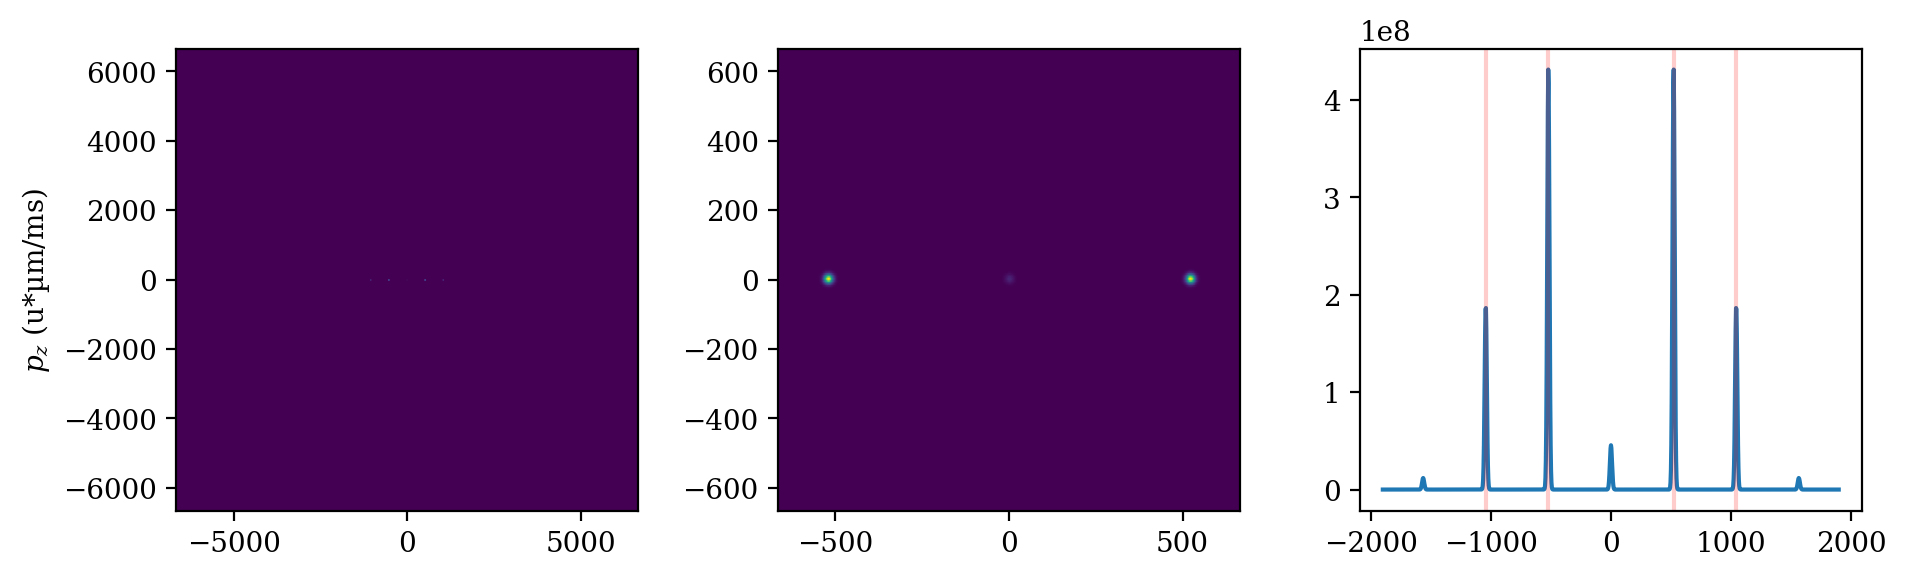

time = 1.53 µs
1.0000000000000462 |psi|^2
0.998501748126983 |phi|^2


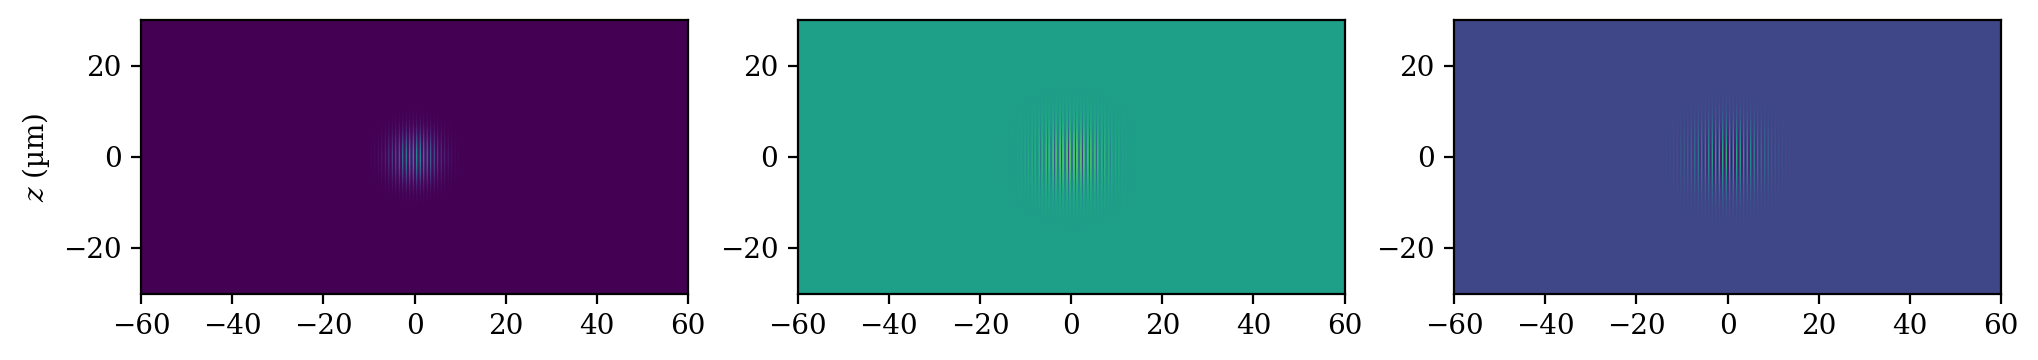

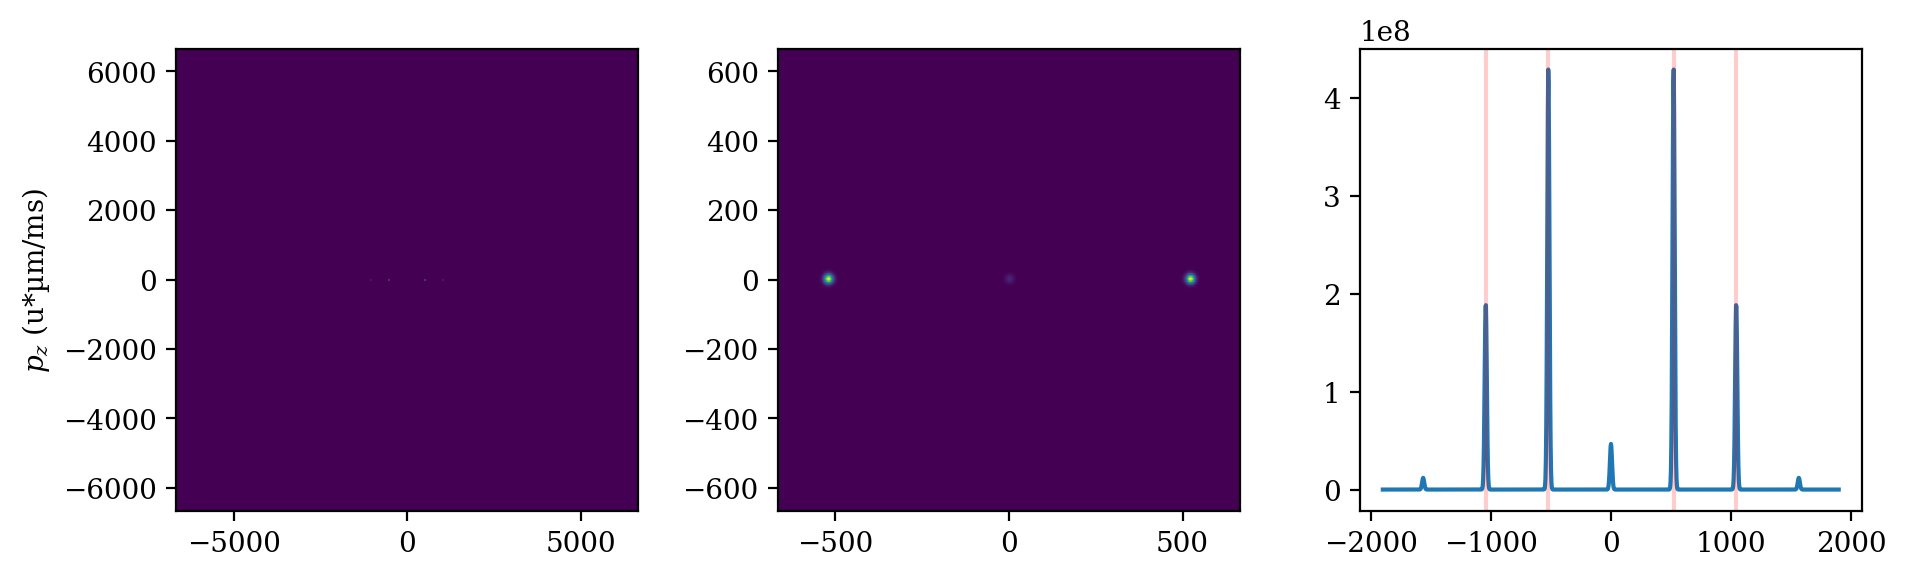

time = 1.54 µs
1.0000000000000462 |psi|^2
0.9985017481269839 |phi|^2


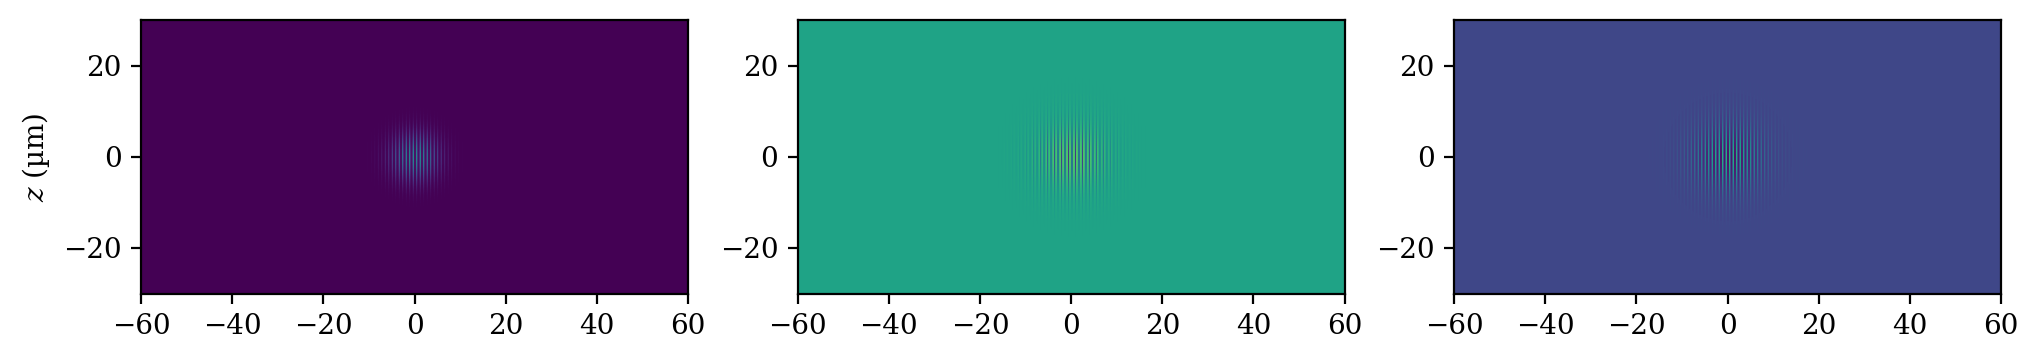

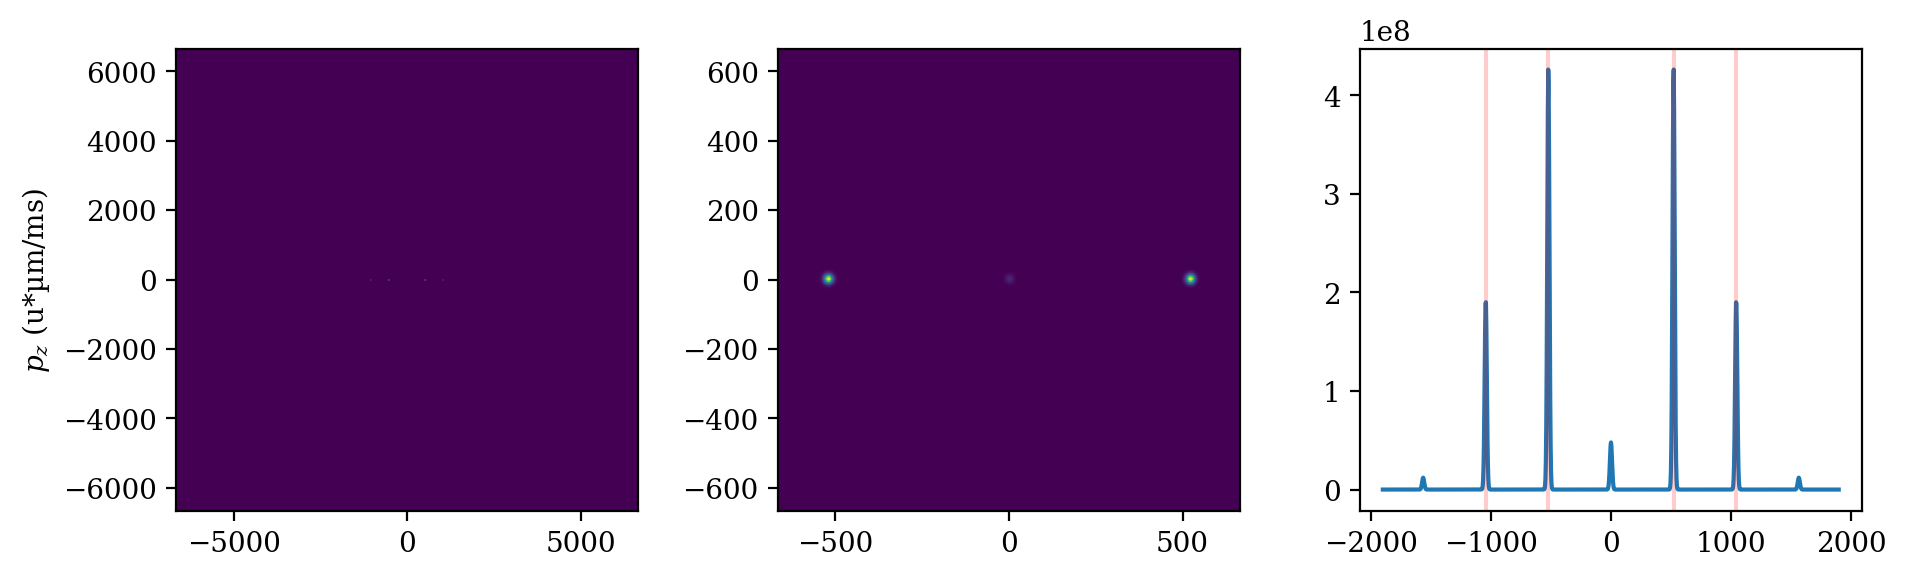

time = 1.55 µs
1.0000000000000469 |psi|^2
0.9985017481269831 |phi|^2


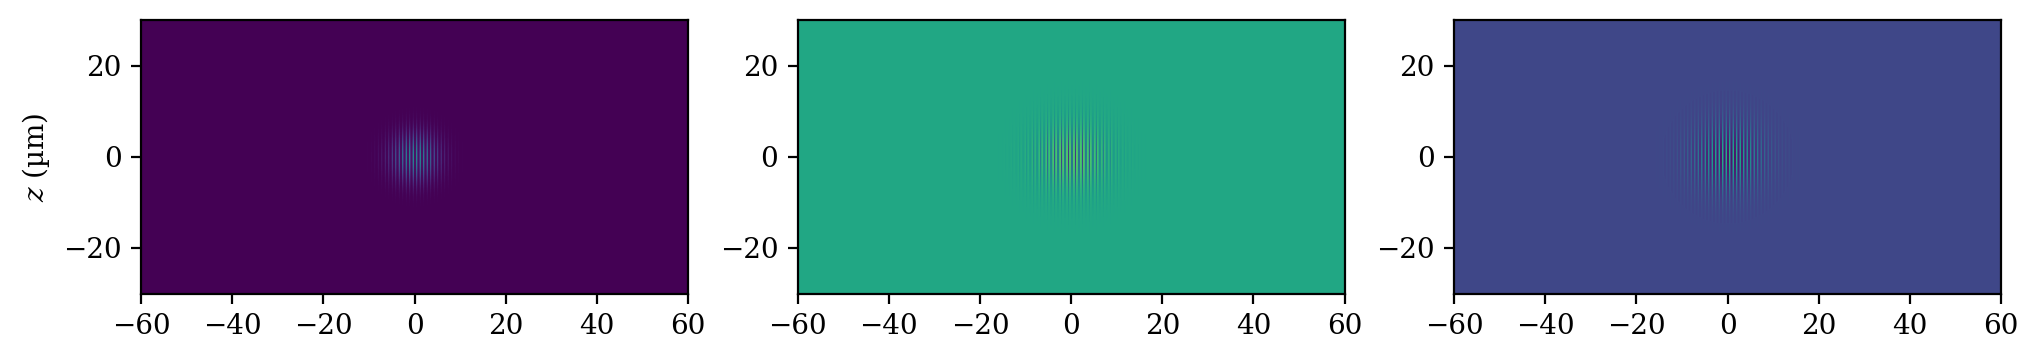

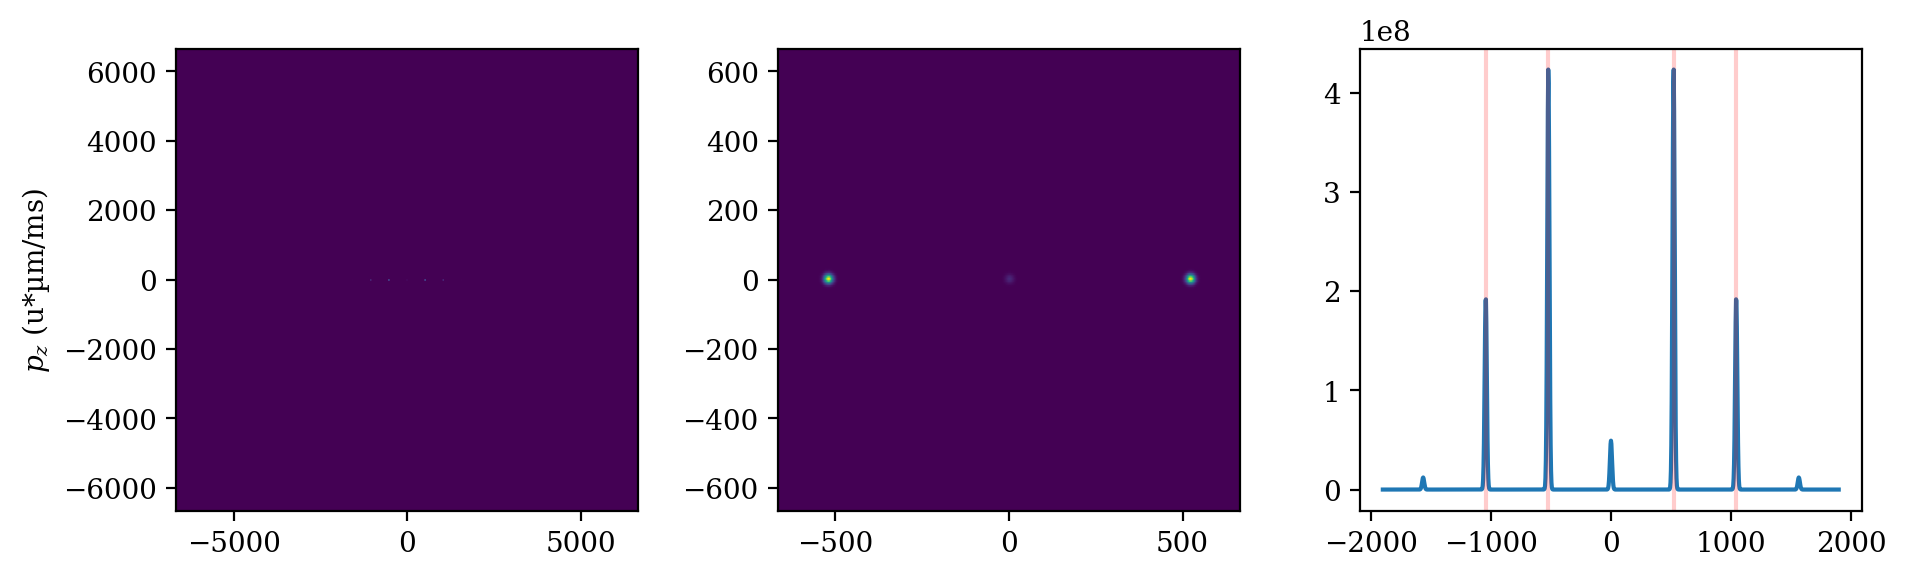

time = 1.56 µs
1.000000000000047 |psi|^2
0.9985017481269836 |phi|^2


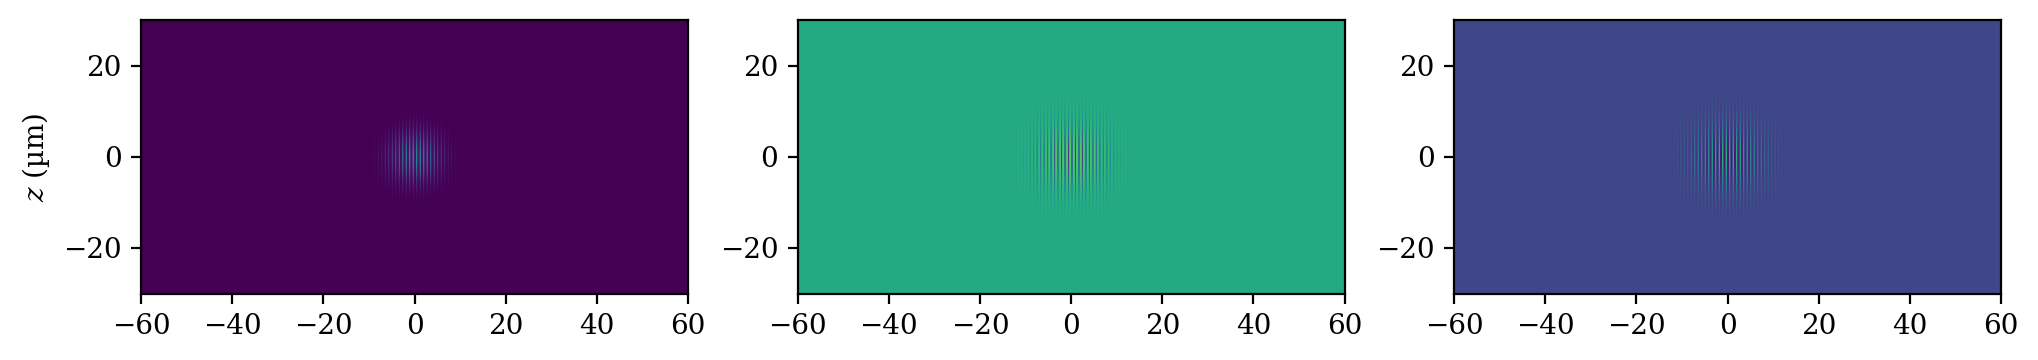

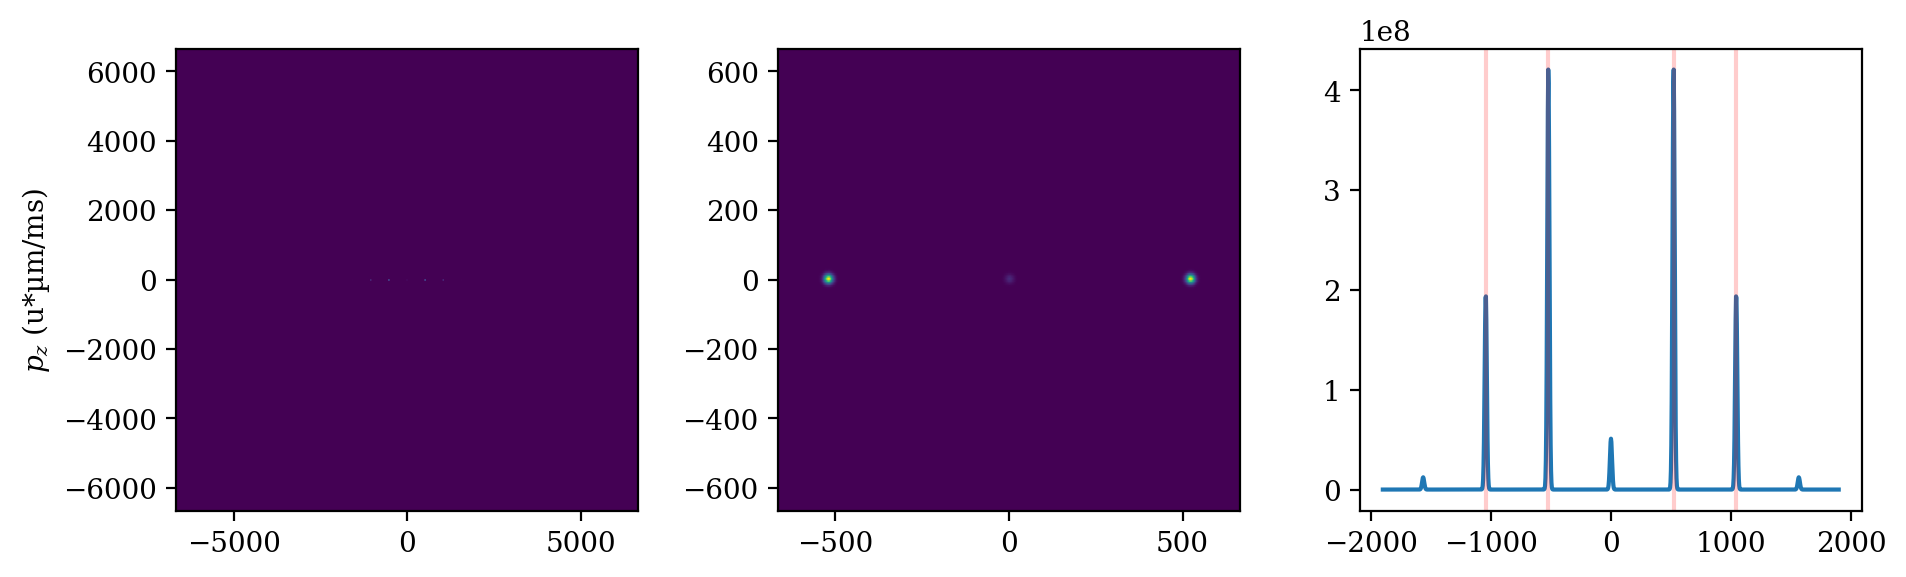

time = 1.57 µs
1.0000000000000475 |psi|^2
0.9985017481269842 |phi|^2


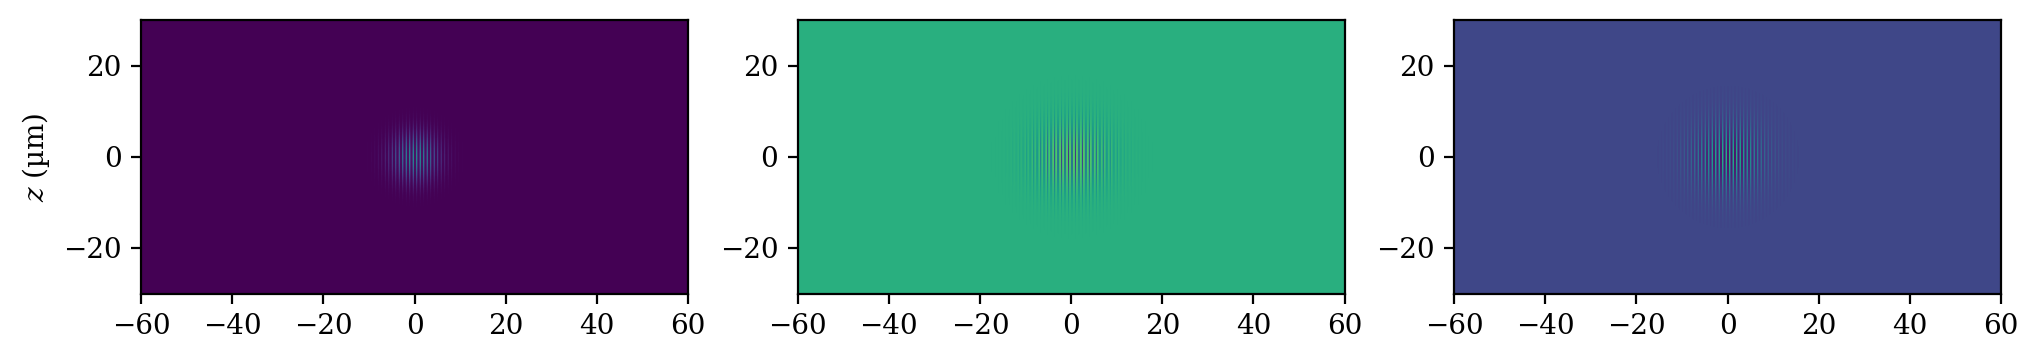

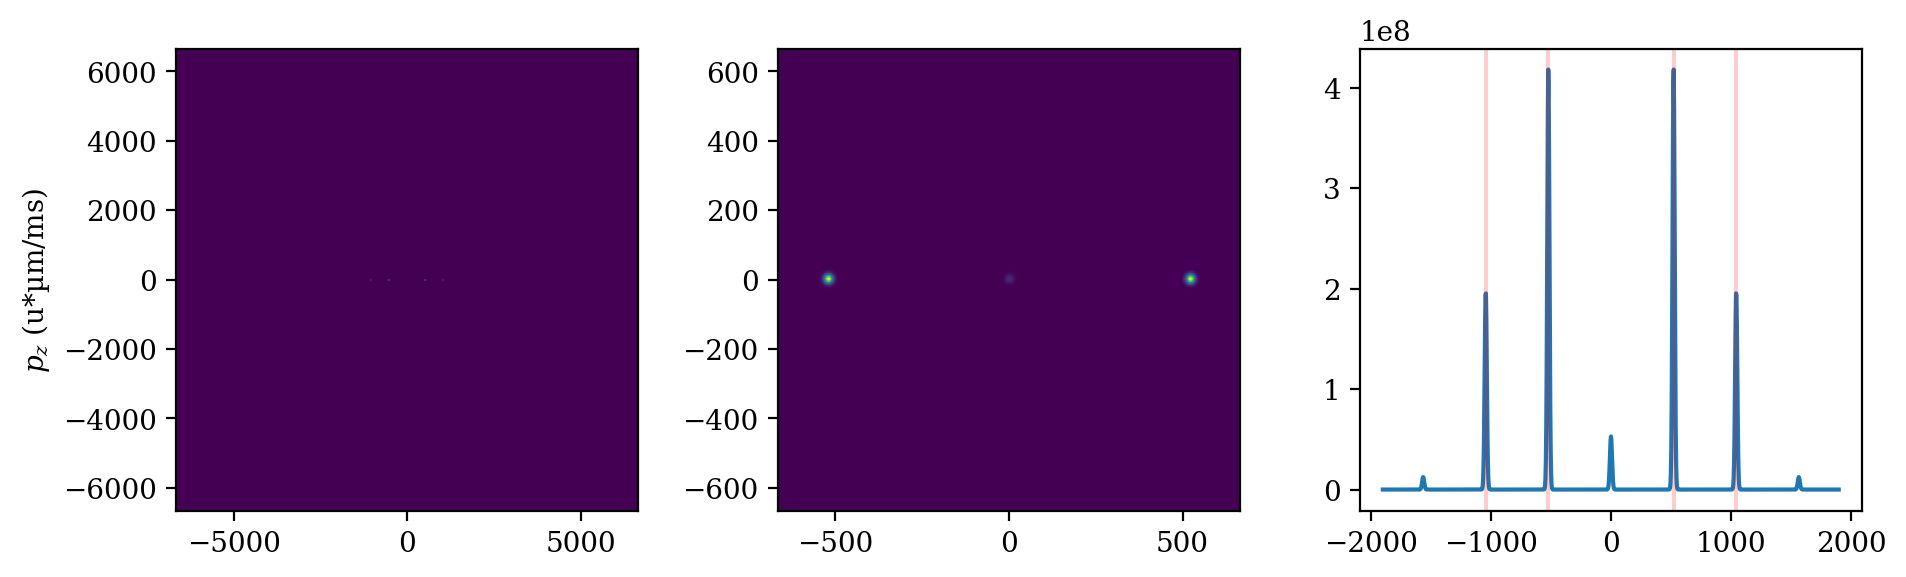

time = 1.58 µs
1.000000000000048 |psi|^2
0.9985017481269844 |phi|^2


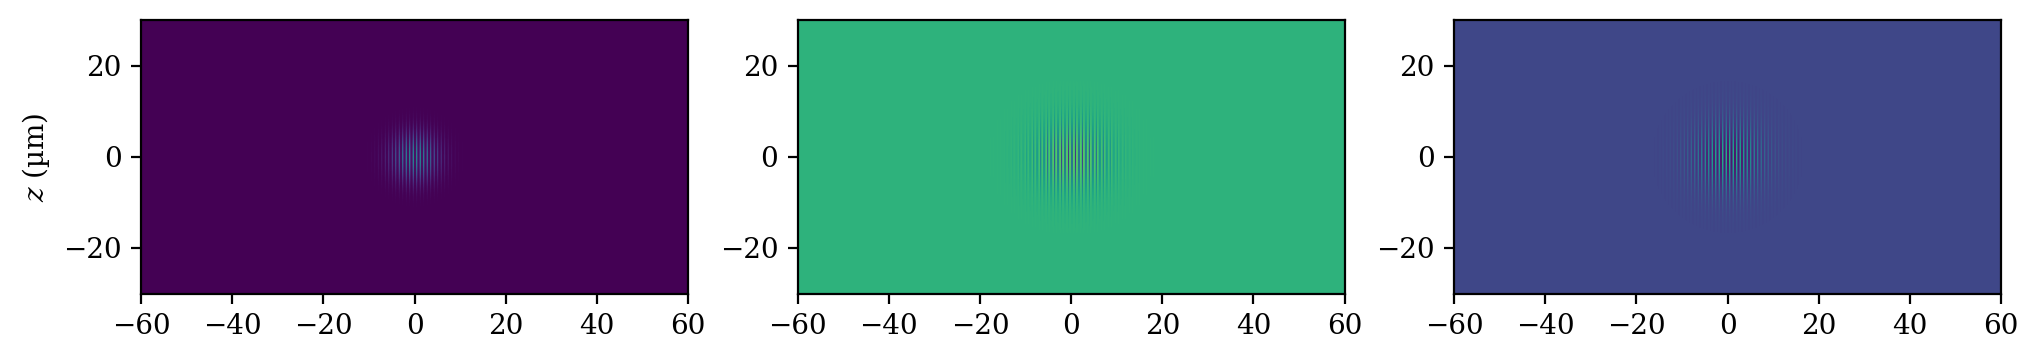

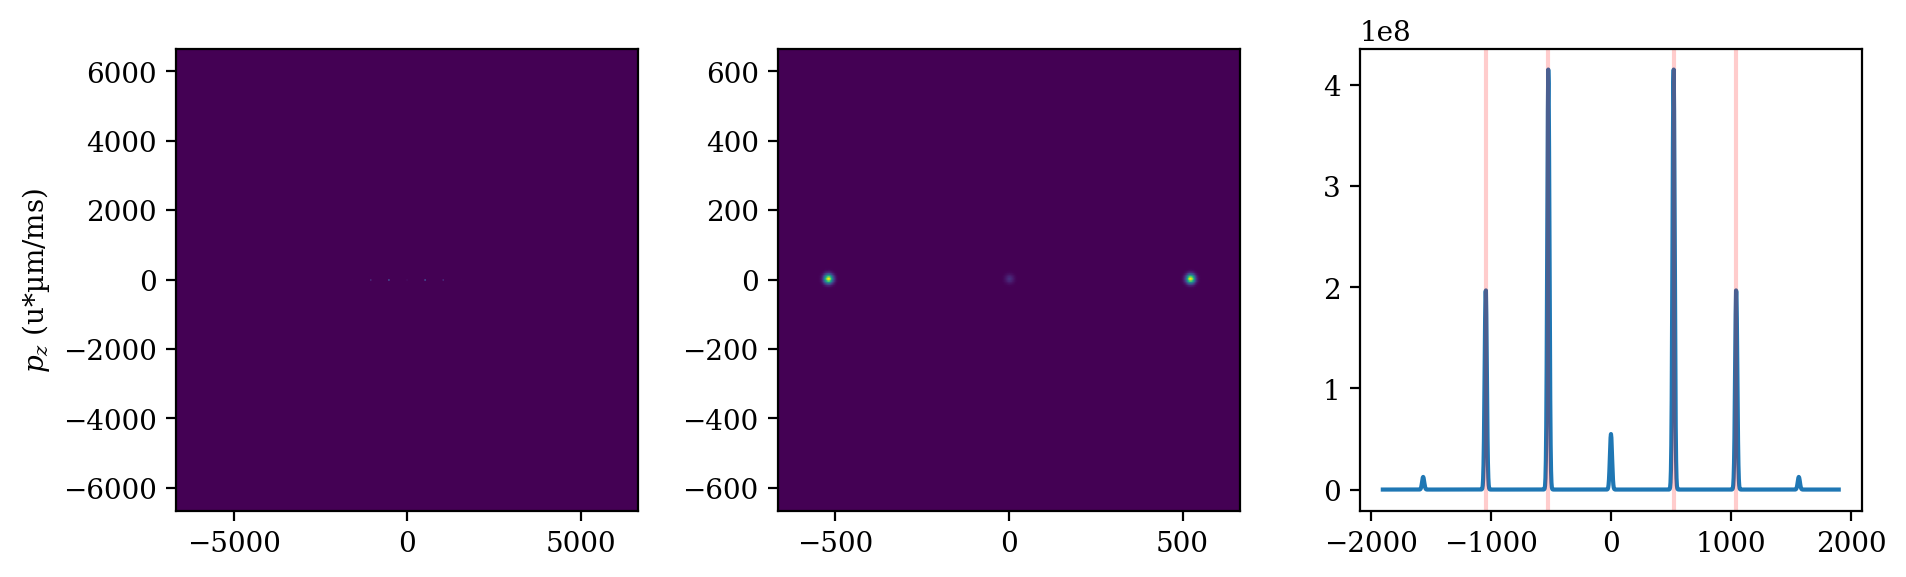

time = 1.59 µs
1.000000000000048 |psi|^2
0.9985017481269848 |phi|^2


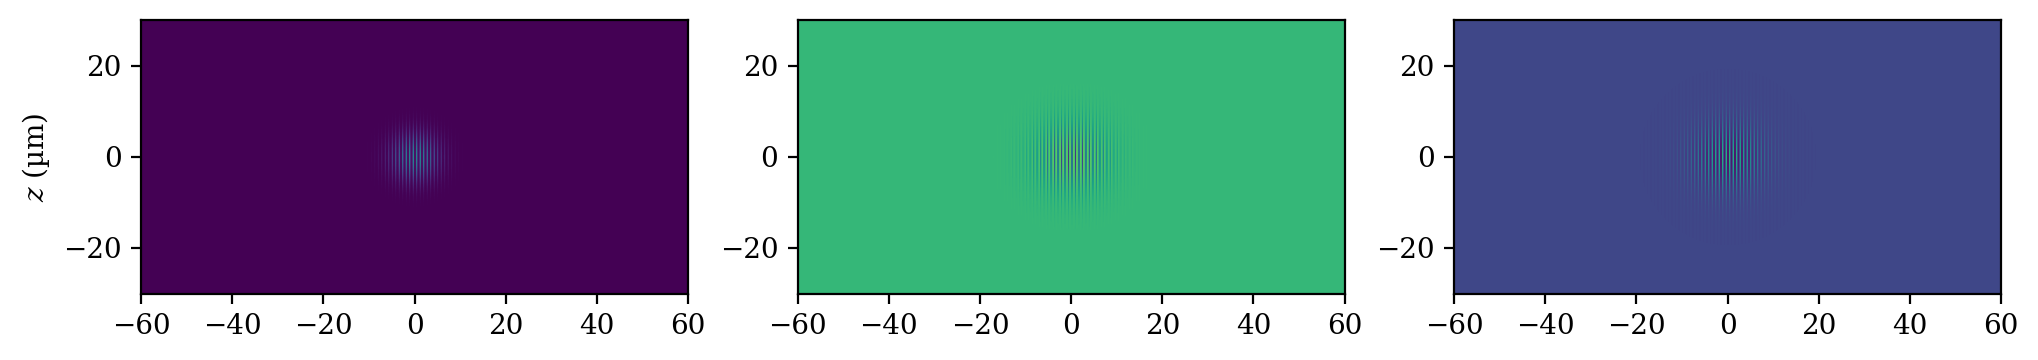

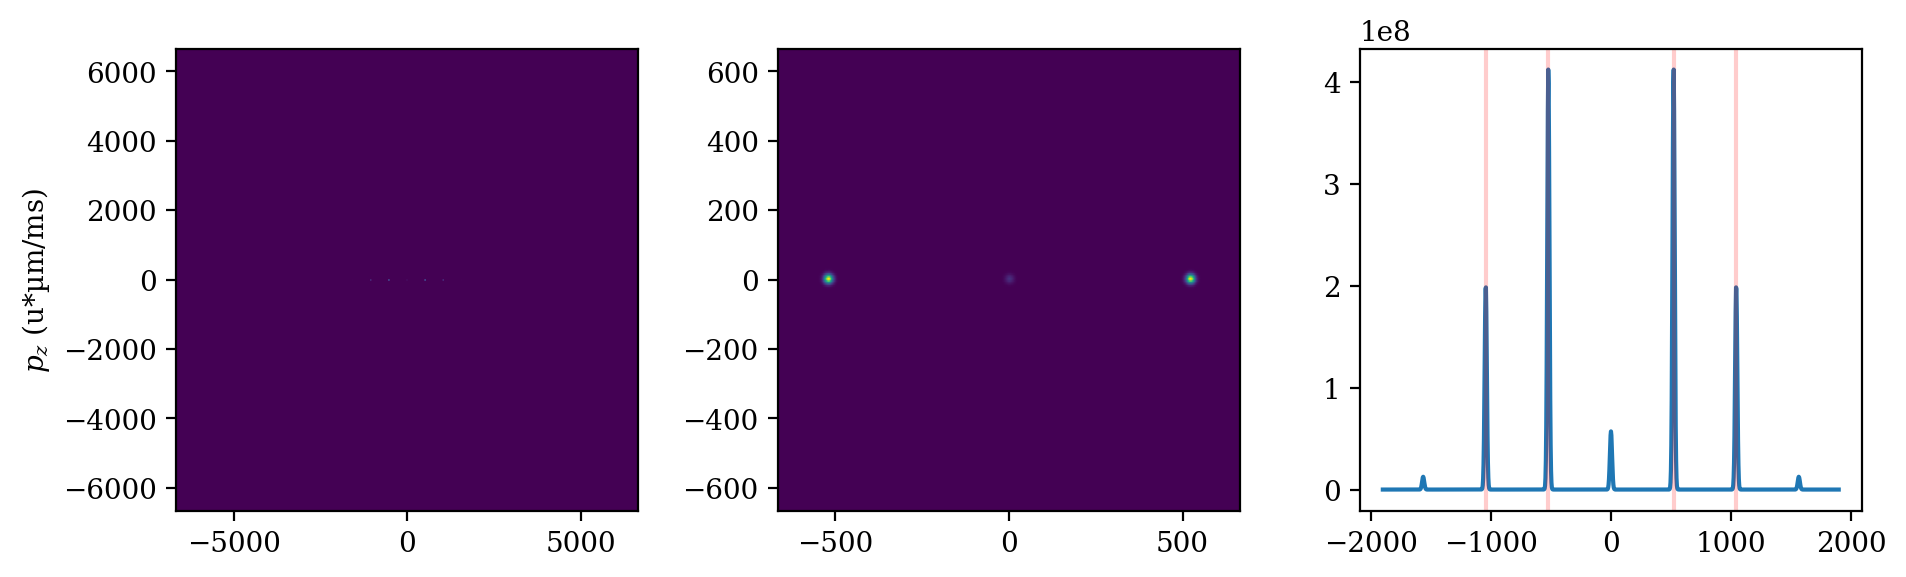

time = 1.6 µs
1.0000000000000484 |psi|^2
0.9985017481269858 |phi|^2


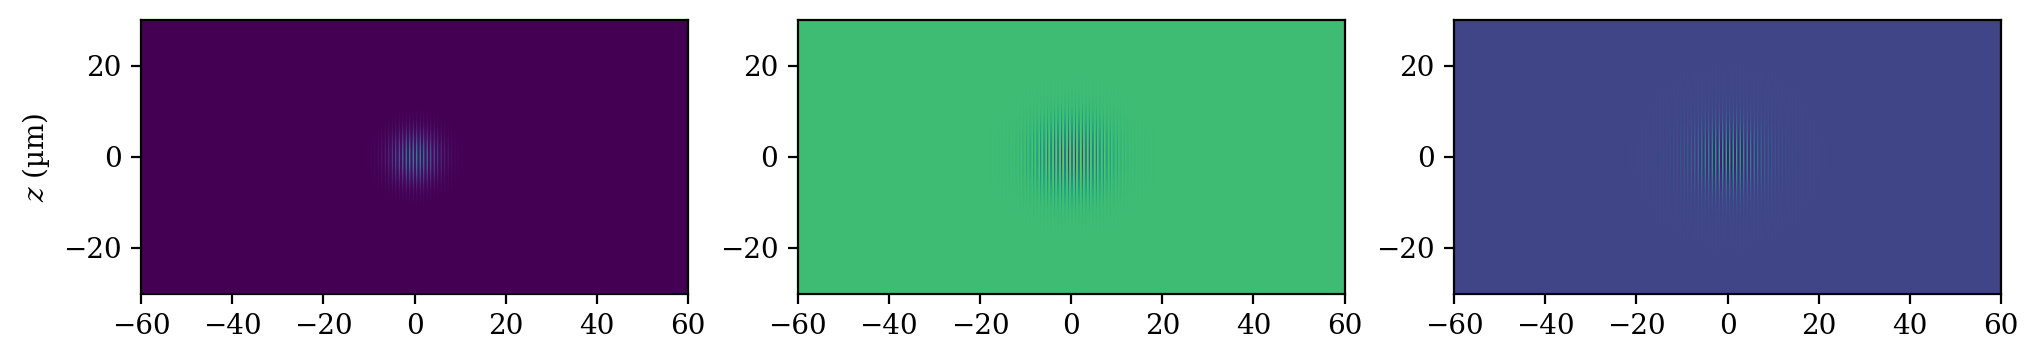

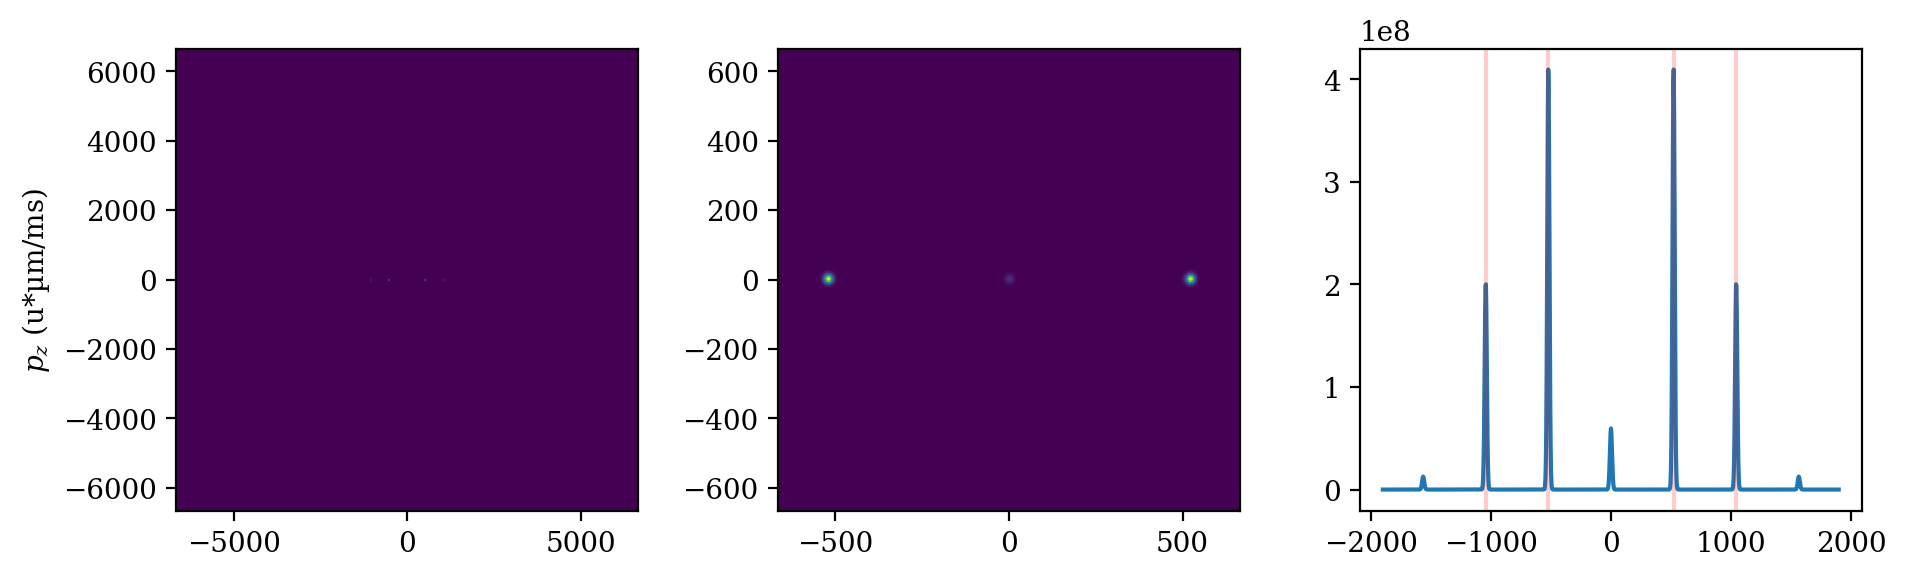

KeyboardInterrupt: 

In [213]:
# @njit(parallel=True)
for step in tqdm(range(300)):
    psi *= VxExpGrid
    phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swmf
    phi *= expPGrid
    psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swmf)),threads=nthreads,norm='ortho')
    psi *= VxExpGrid
    
    if abs(step - 130) <= 30:
        print("time =", round(t*1000,4), "µs")
        print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
        print(np.sum(np.abs(phi)**2)*dpx*dpz,"|phi|^2")
        plot_psi(psi)
        plot_mom(psi)
    
    t += dt

In [214]:
def testDuration(t=0.001*15):
    steps = int(t/dt)
    print("duration tau =",t, ", steps =", steps, ", dt =",dt)
    psi = psi0np(5,5,0,0)
    t = 0    
    for i in tqdm(range(steps)):
        psi *= VxExpGrid
        phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swmf
        phi *= expPGrid
        psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swmf)),threads=nthreads,norm='ortho')
        psi *= VxExpGrid
        t += dt
    plot_psi(psi)
    plot_mom(psi)
    return (t,psi)

In [73]:
# (t,psi) = testDuration(0.001*15)

duration tau = 0.00122 , steps = 121 , dt = 1e-05


  0%|          | 0/121 [00:00<?, ?it/s]

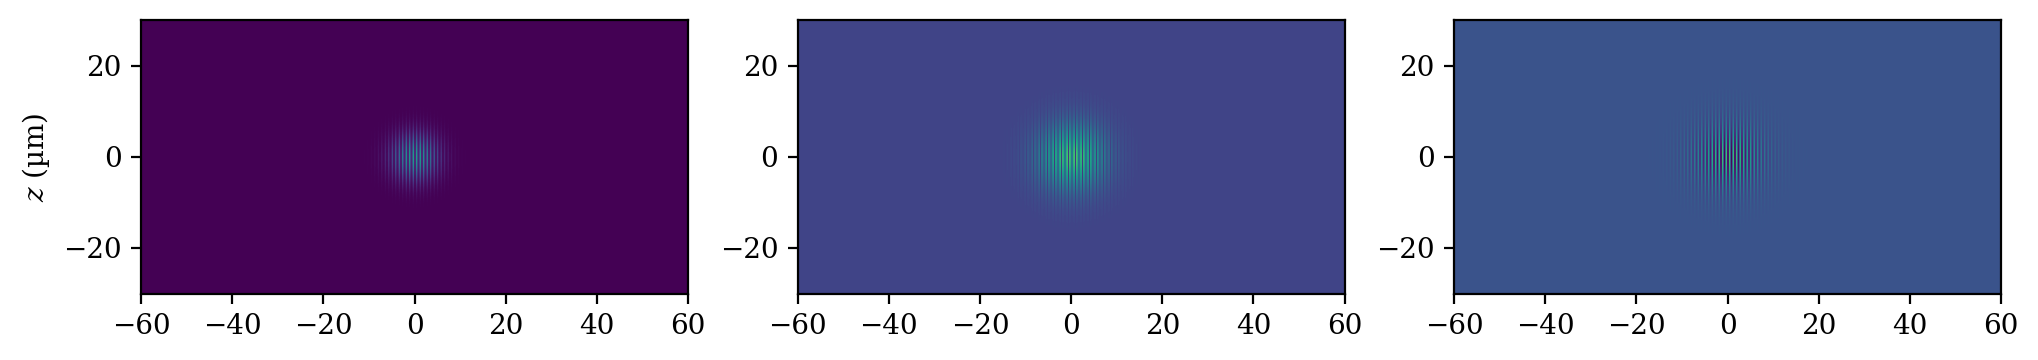

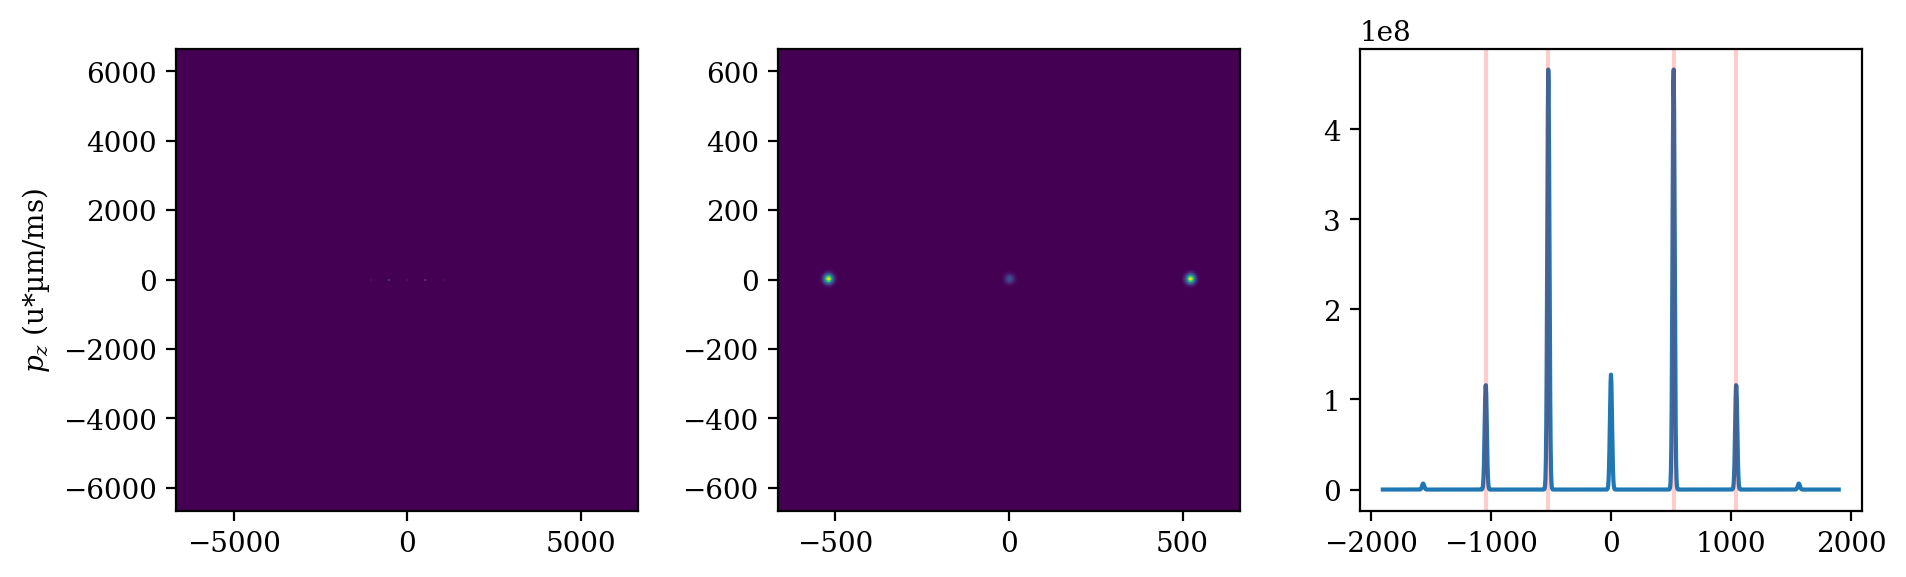

In [215]:
(t,psi) = testDuration(0.001*1.22)

In [216]:
np.sum(np.abs(phi)**2)*dpx*dpz

0.9985017481270039

In [217]:
2*hb*k

521.0668902307921

In [218]:
phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swmf

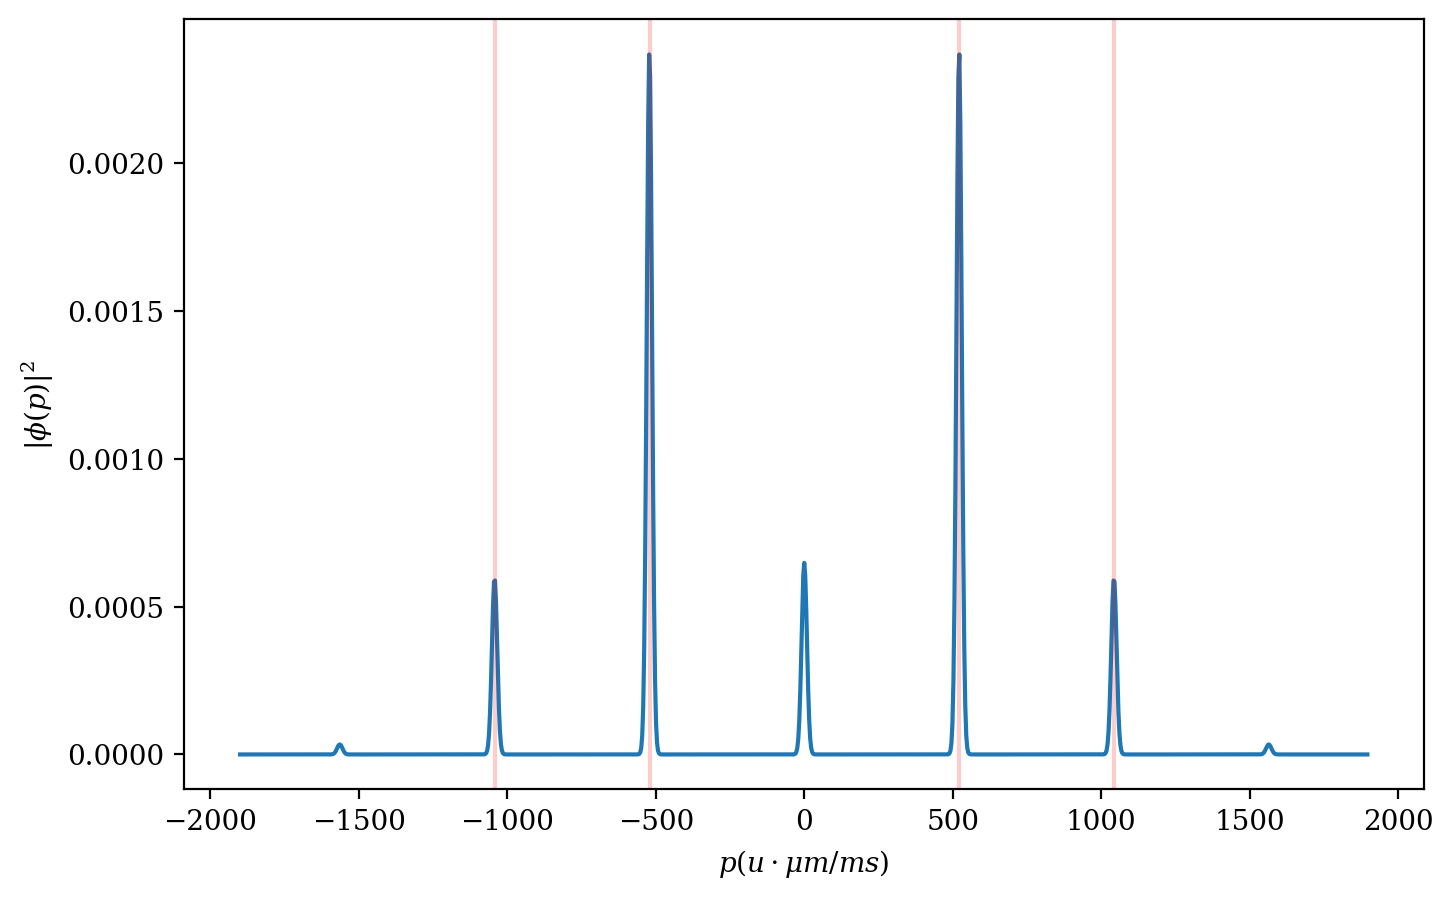

In [219]:
nxm = int((nx-1)/2)
nzm = int((nz-1)/2)
nx2 = int((nx-1)/7)
nz2 = int((nz-1)/7)
plt.plot(pxlin[nxm-nx2:nxm+nx2], np.trapz(np.abs(phi)**2,axis=1)[nxm-nx2:nxm+nx2])
plt.axvline(x=+2*k*hb,color='r',alpha=0.2)
plt.axvline(x=-2*k*hb,color='r',alpha=0.2)
plt.axvline(x=+4*k*hb,color='r',alpha=0.2)
plt.axvline(x=-4*k*hb,color='r',alpha=0.2)
plt.xlabel("$p (u\cdot \mu m/ms)$")
plt.ylabel("$|\phi(p)|^2$")
title = "Bragg Pulse"
plt.savefig("output/"+title+".pdf", dpi = 300) 
plt.savefig("output/"+title+".png", dpi = 300) 
plt.show()

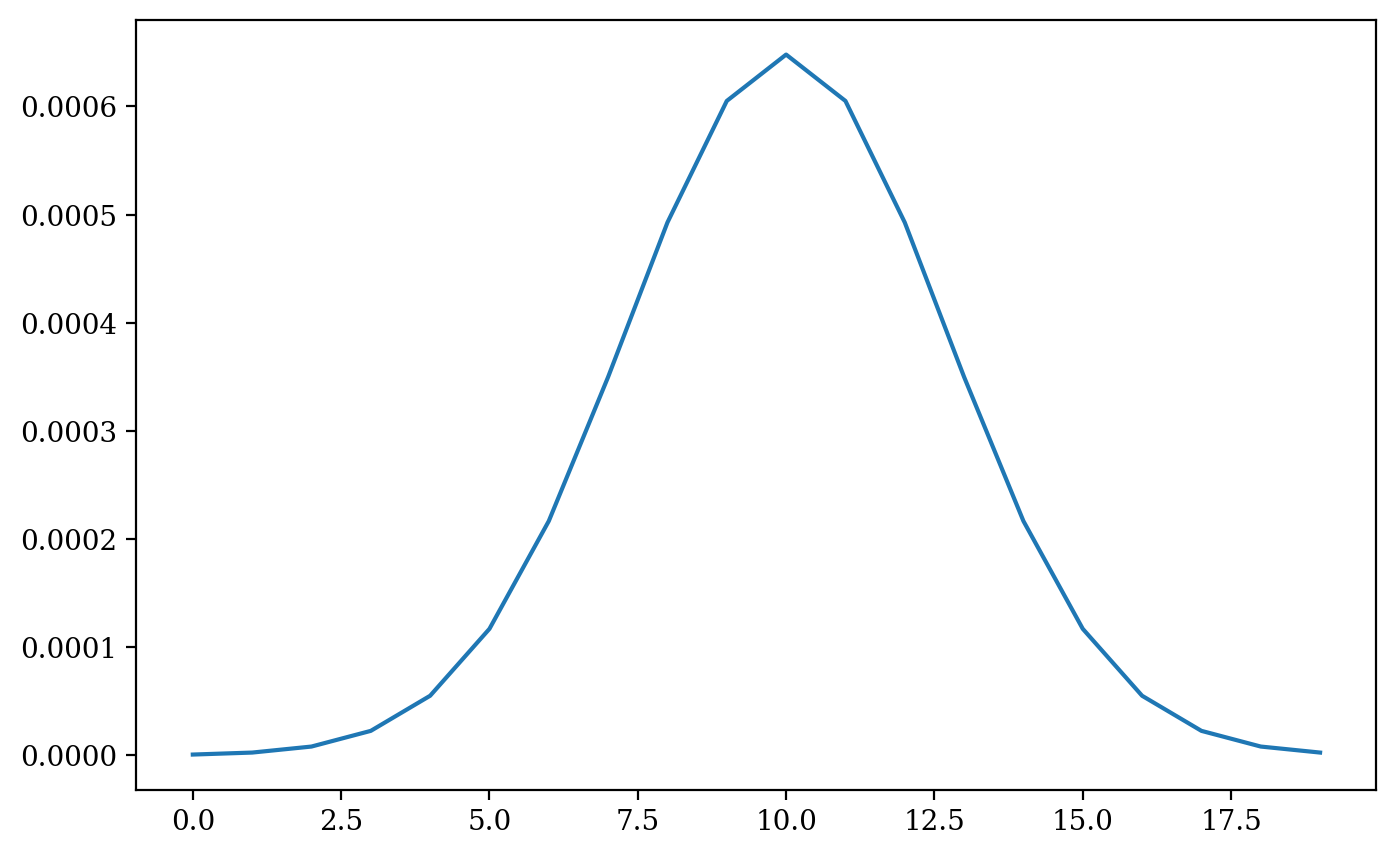

In [220]:
plt.plot(np.trapz(np.abs(phi)**2,axis=1)[1990:2010])

In [221]:
np.sum(np.abs(phi)**2)*dpx*dpz/(2*pi*hb)

0.002502314501530615

In [88]:
hb

63.5078

In [220]:
np.sum(np.abs(phi)**2)*dpx*dpz*(2*pi*hb)**-1 *(nx*nz)**-0.5

0.021752393171786854

In [186]:
np.sum(np.abs(phi)**2)*dpx*dpz*(2*pi*hb)**-0.5

1229.4711232639286

In [238]:
np.sum(np.abs(phi)**2)/(2*pi*hb)

2.7838255742368263

In [241]:
np.sum(np.abs(phi)**2)*dpx*dpz

24559.62895660681

In [ ]:
## np.sum(np.abs(phi)**2)*dpx*dpz/nx/nz

In [239]:
np.trapz(np.trapz(np.abs(phi)**2, pxlin, axis=0), pzlin)

24596.480679856293

In [221]:
2*pi/(2*xmax)*hb

3.3252606320941642

In [222]:
(nx+1)/2 * 2*pi/(2*xmax)*hb

6653.846524820424

In [232]:
1/nx/nz

1.2490630465821828e-07

In [234]:
sqrt(nx*nz)

2829.487762829166

In [89]:
p

521.0668902307921

In [91]:
hb*k*2

521.0668902307921

In [155]:
np.cos(0*pi)

1.0

In [225]:
def testAngle(ang=pi/2):
    steps = int(1.22*0.001/dt)
    print("duration tau =",1.22*0.001, ", steps =", steps, ", dt =",dt, (np.cos(ang),np.sin(ang)))
    print("angle =", ang)
    psi = psi0np(5,5,0.5*p*cos(ang),0.5*p*sin(ang))
    t = 0    
    print("initial state")
    plot_psi(psi)
    plot_mom(psi)
    for i in tqdm(range(steps)):
        psi *= VxExpGrid
        phi = np.fliplr(np.fft.fftshift(pyfftw.interfaces.numpy_fft.fft2(psi,threads=nthreads,norm='ortho')))/swmf
        phi *= expPGrid
        psi = pyfftw.interfaces.numpy_fft.ifft2(np.fft.ifftshift(np.fliplr(phi*swmf)),threads=nthreads,norm='ortho')
        psi *= VxExpGrid
        t += dt
    print("final state at t =", round(t*1000,5), "µs")
    print(np.trapz(np.trapz(np.abs(psi)**2,xlin,axis=0),zlin),"|psi|^2")
    print(np.sum(np.abs(phi)**2)*dpx*dpz,"|phi|^2")
    plot_psi(psi)
    plot_mom(psi)

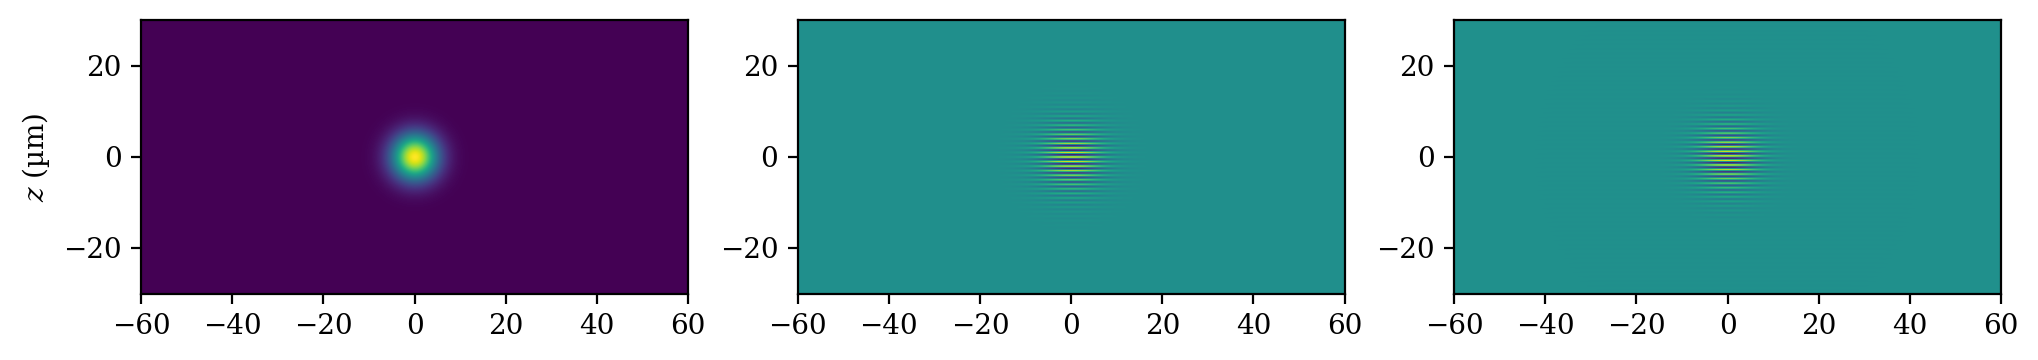

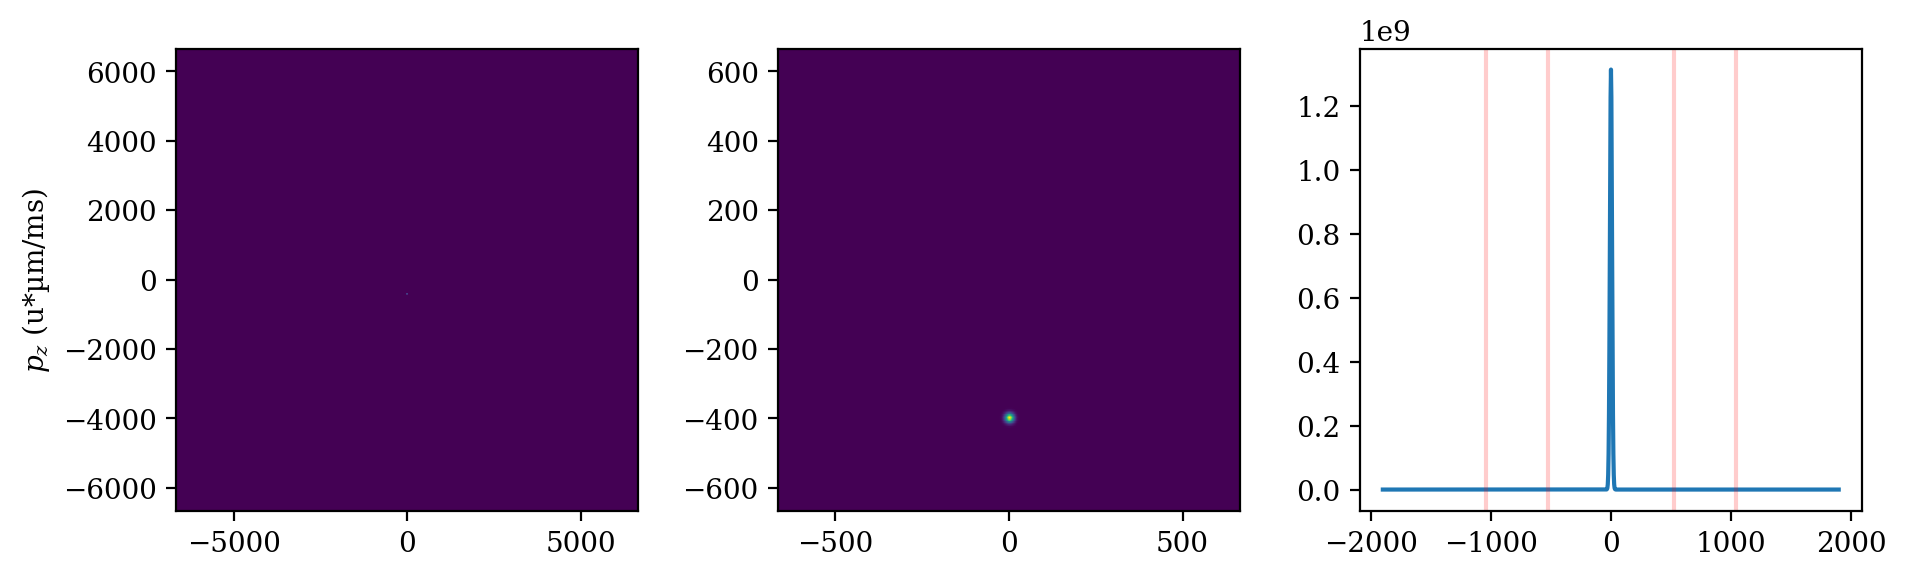

In [226]:
# ang = pi/2
# psi = psi0np(5,5,0.5*p*cos(ang),0.5*p*sin(p))
psi = psi0np(5,5,0,-400)
plot_psi(psi)
plot_mom(psi)

duration tau = 0.00122 , steps = 121 , dt = 1e-05 (1.0, 0.0)
angle = 0.0
initial state


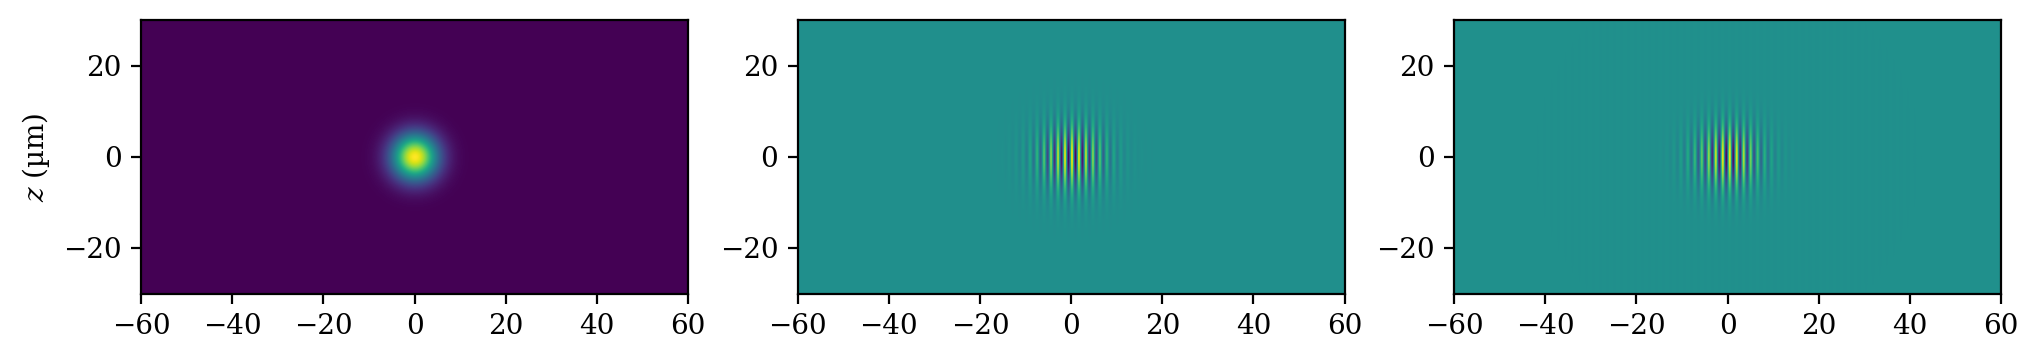

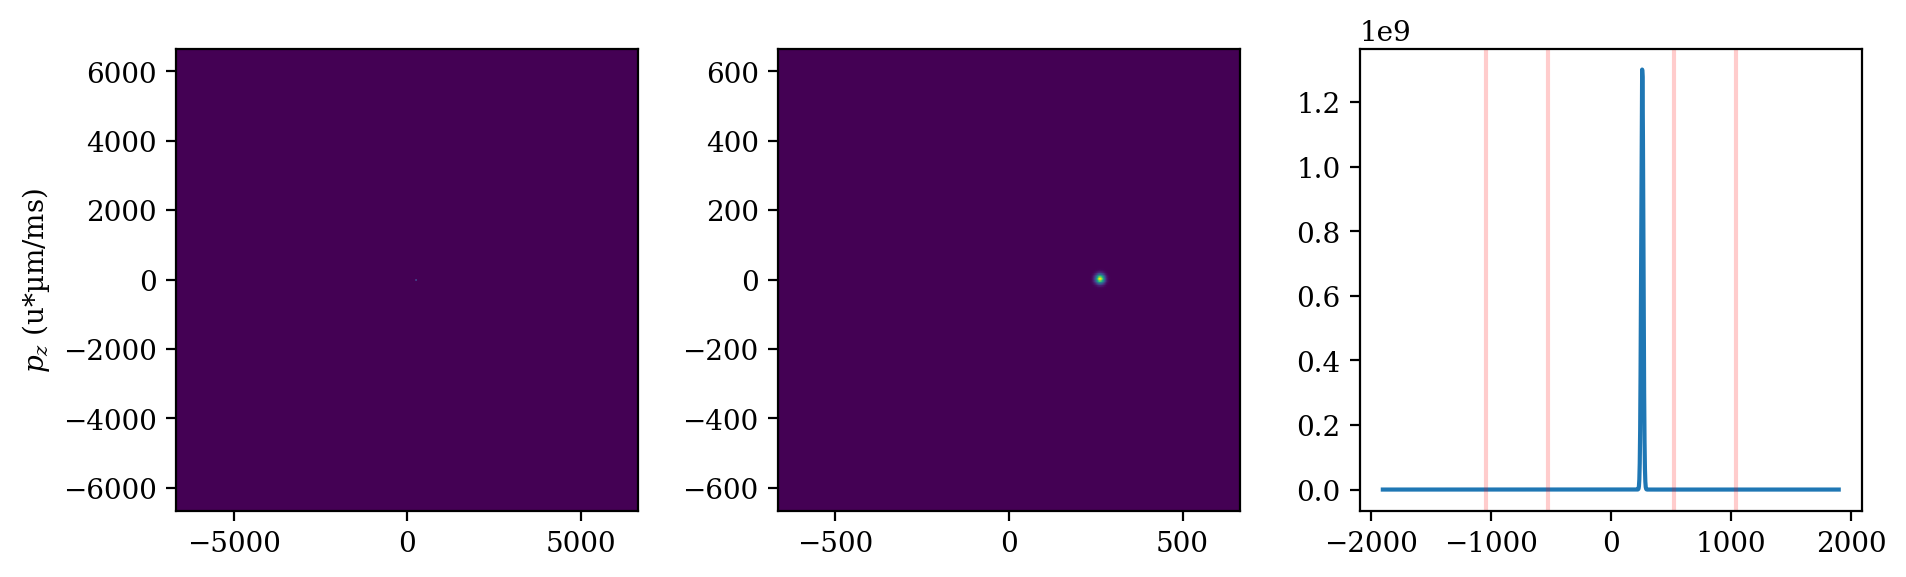

  0%|          | 0/121 [00:00<?, ?it/s]

final state at t = 1.21 µs
1.0000000000000488 |psi|^2
0.9985017481269802 |phi|^2


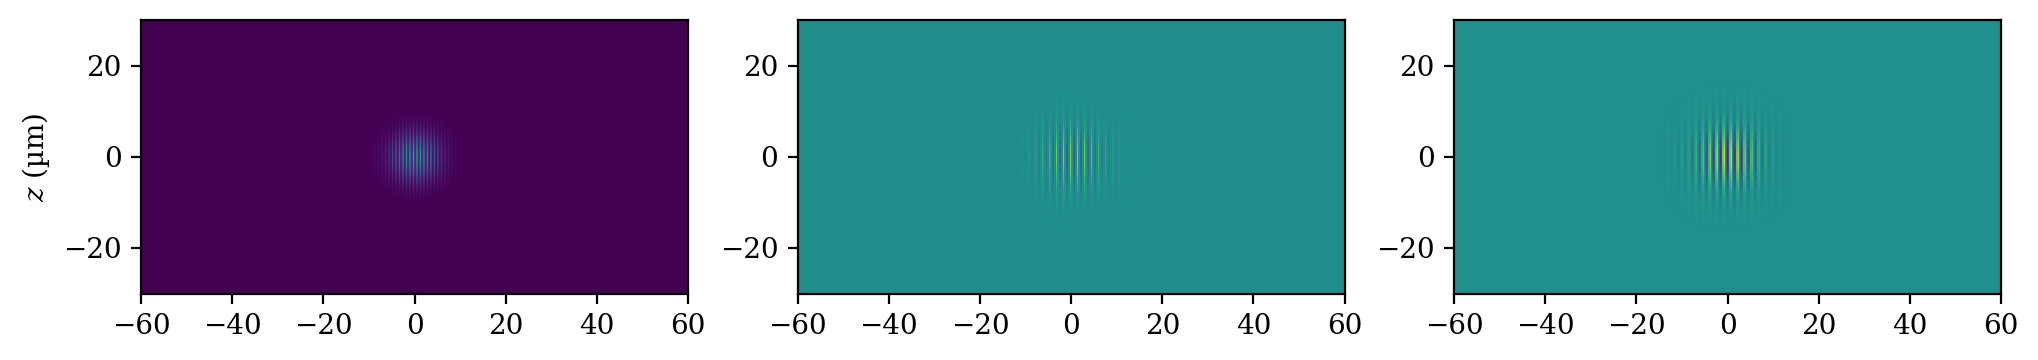

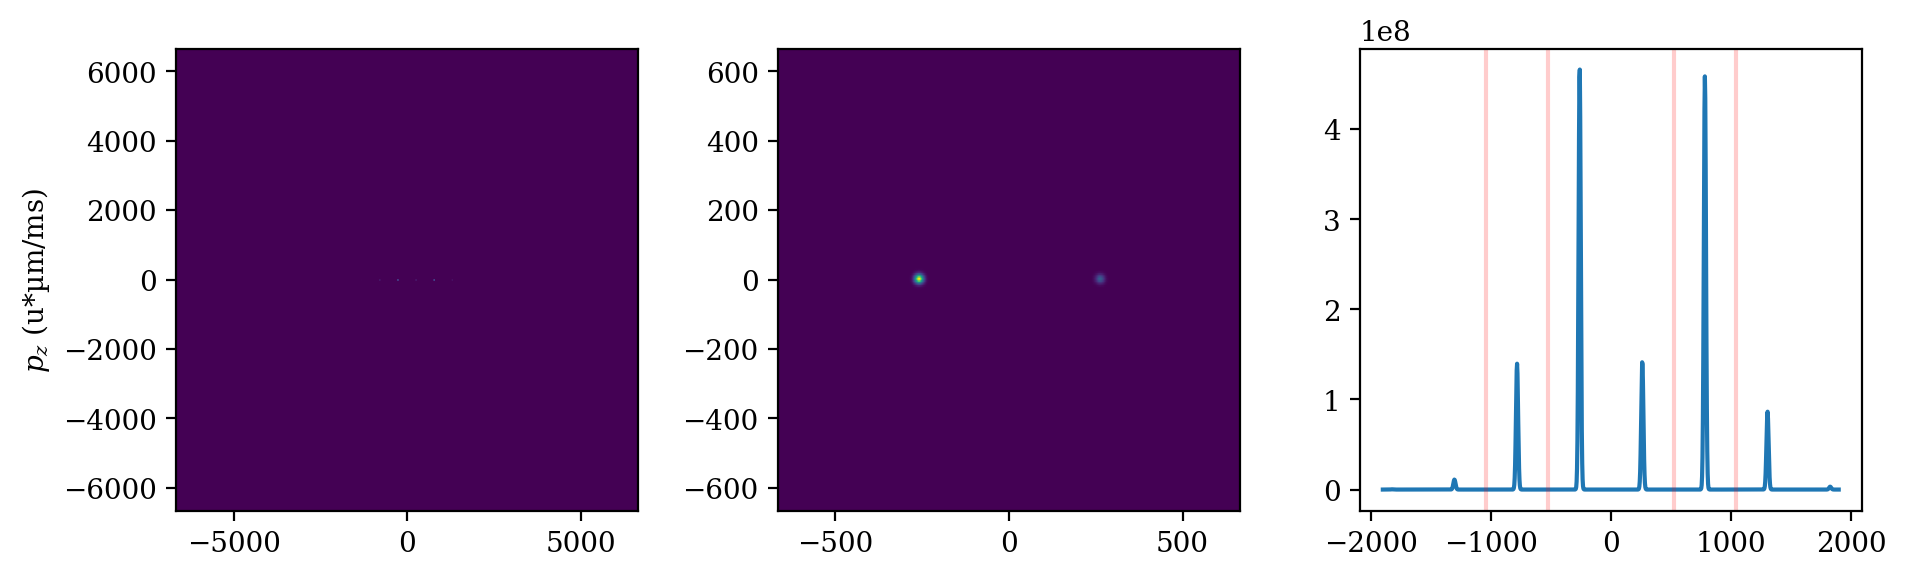

duration tau = 0.00122 , steps = 121 , dt = 1e-05 (0.7071067811865476, 0.7071067811865475)
angle = 0.7853981633974483
initial state


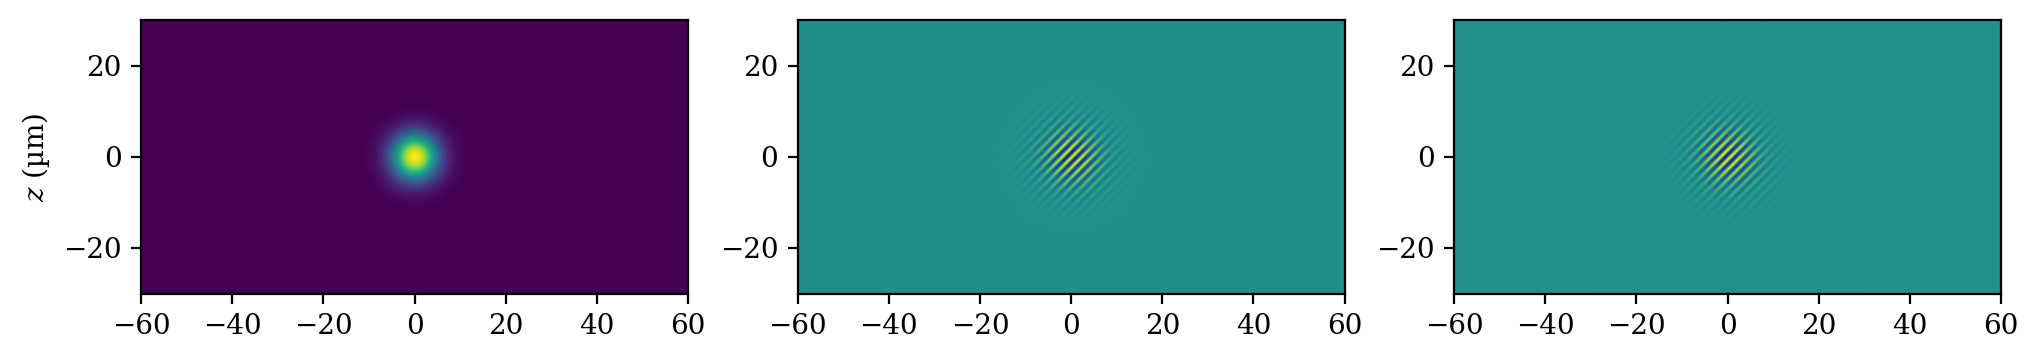

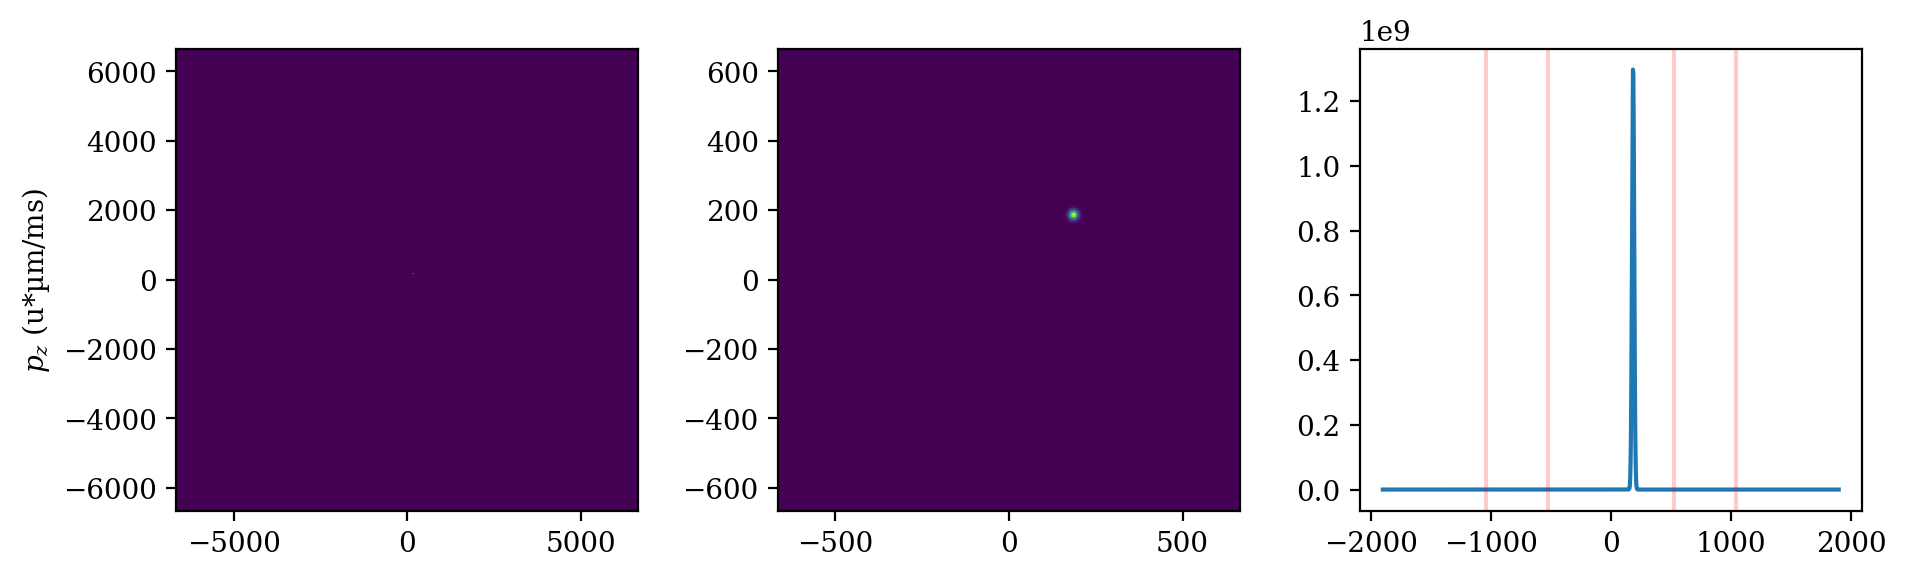

  0%|          | 0/121 [00:00<?, ?it/s]

final state at t = 1.21 µs
1.0000000000000584 |psi|^2
0.9985017481269902 |phi|^2


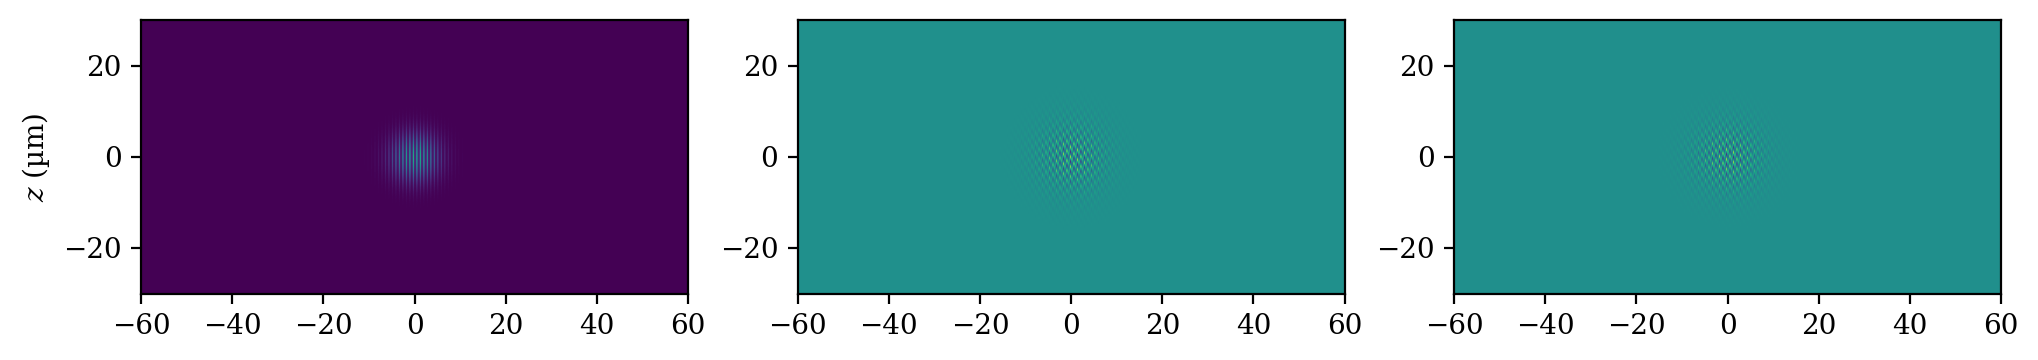

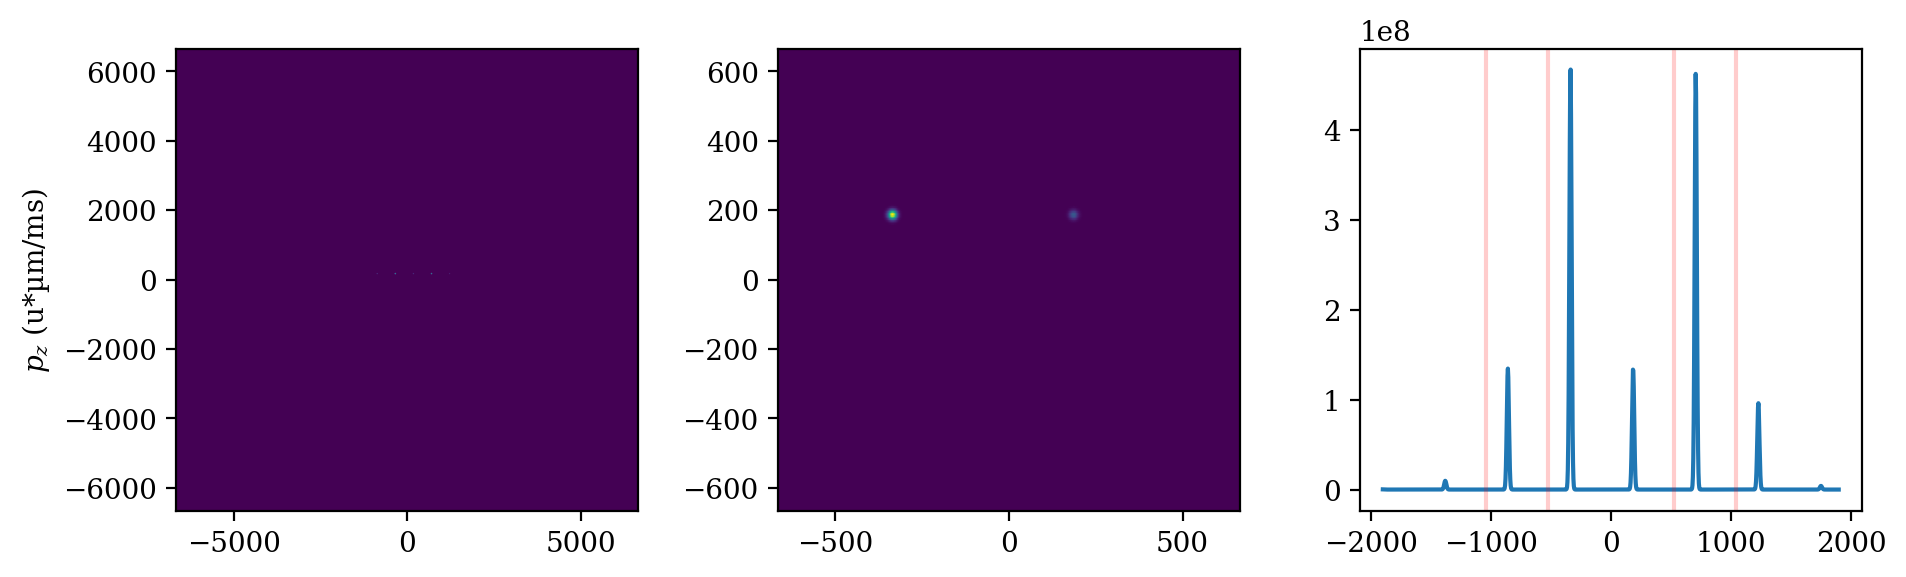

duration tau = 0.00122 , steps = 121 , dt = 1e-05 (6.123233995736766e-17, 1.0)
angle = 1.5707963267948966
initial state


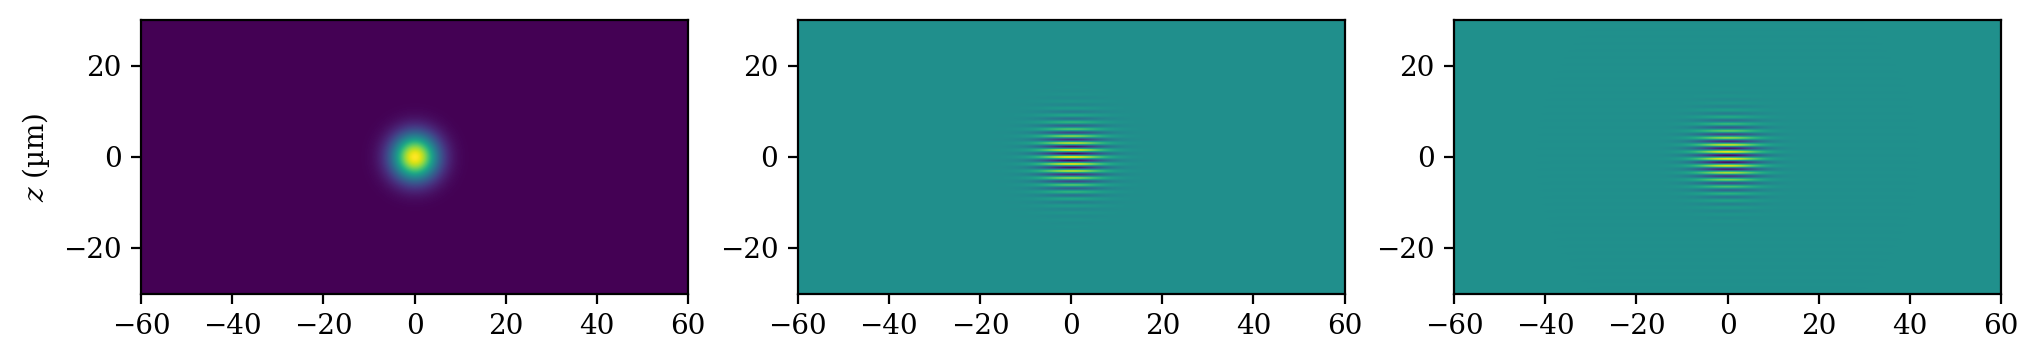

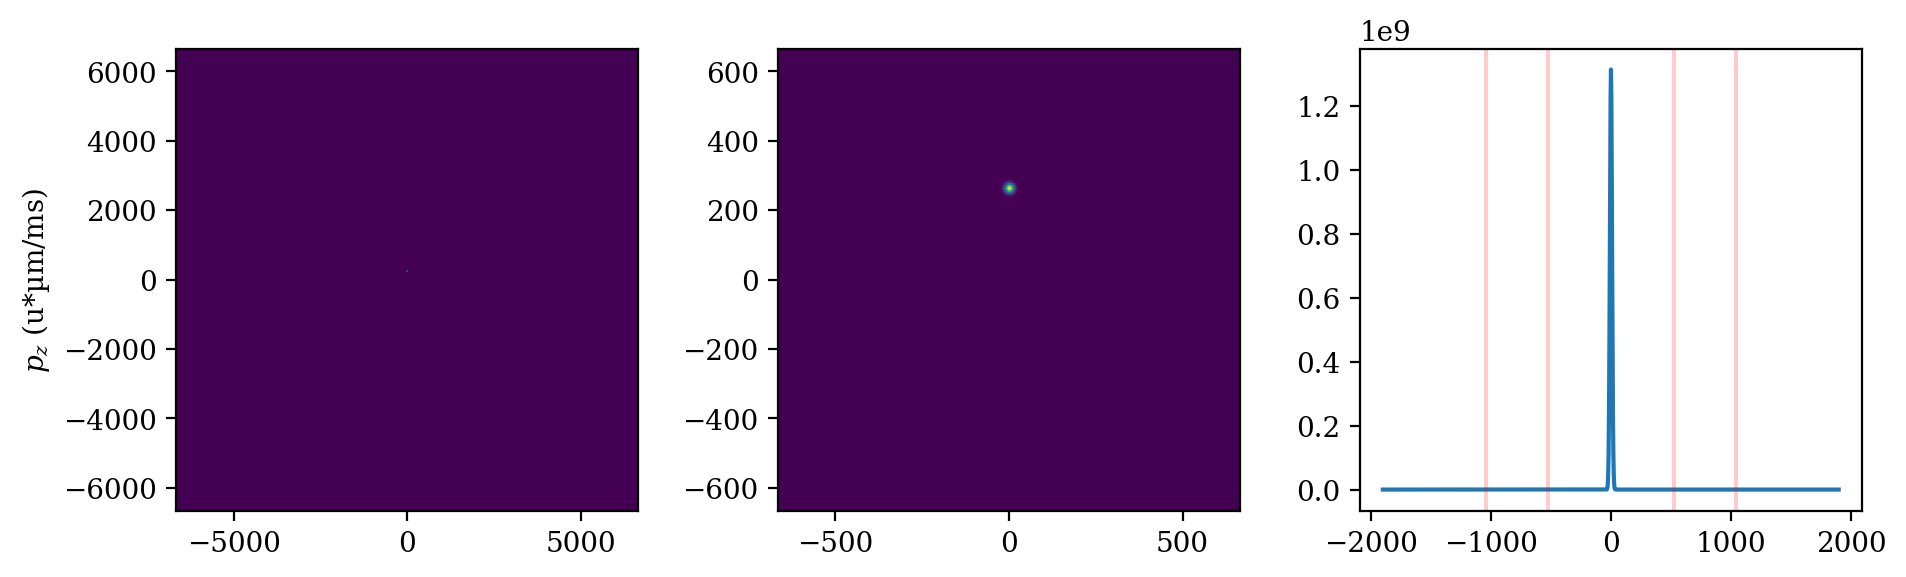

  0%|          | 0/121 [00:00<?, ?it/s]

final state at t = 1.21 µs
1.0000000000000488 |psi|^2
0.9985017481269817 |phi|^2


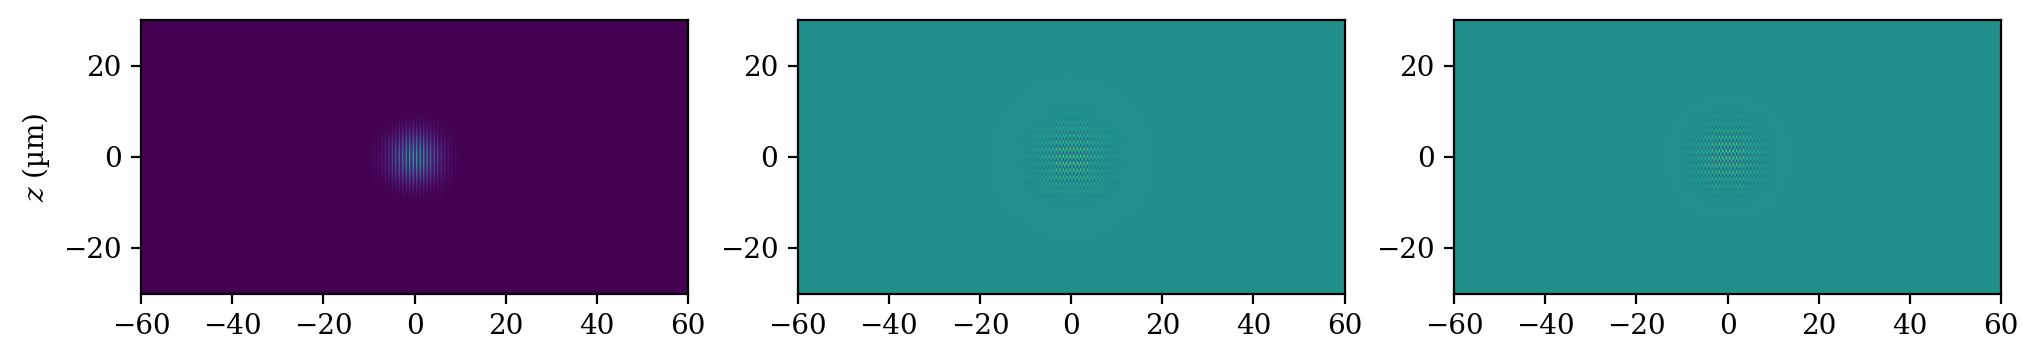

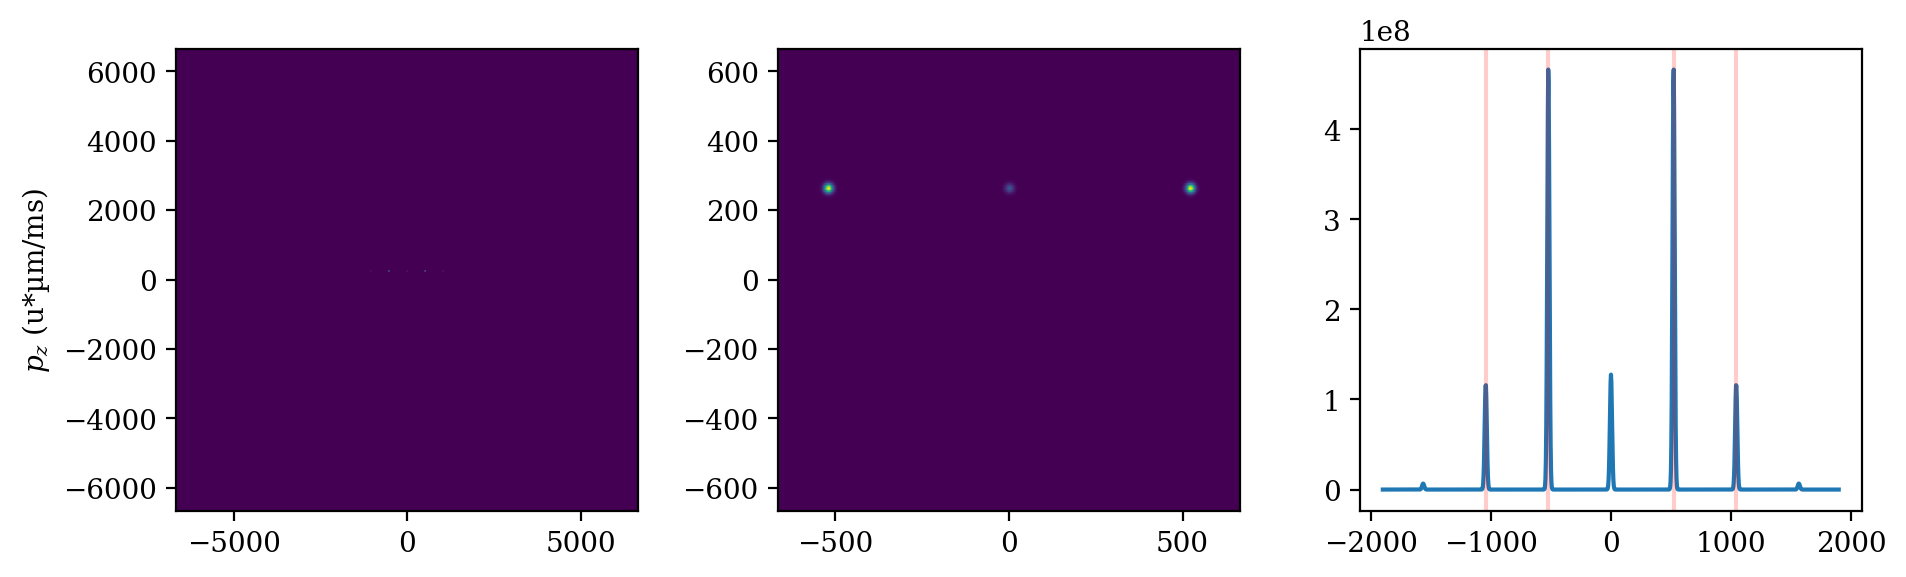

duration tau = 0.00122 , steps = 121 , dt = 1e-05 (-1.0, 1.2246467991473532e-16)
angle = 3.141592653589793
initial state


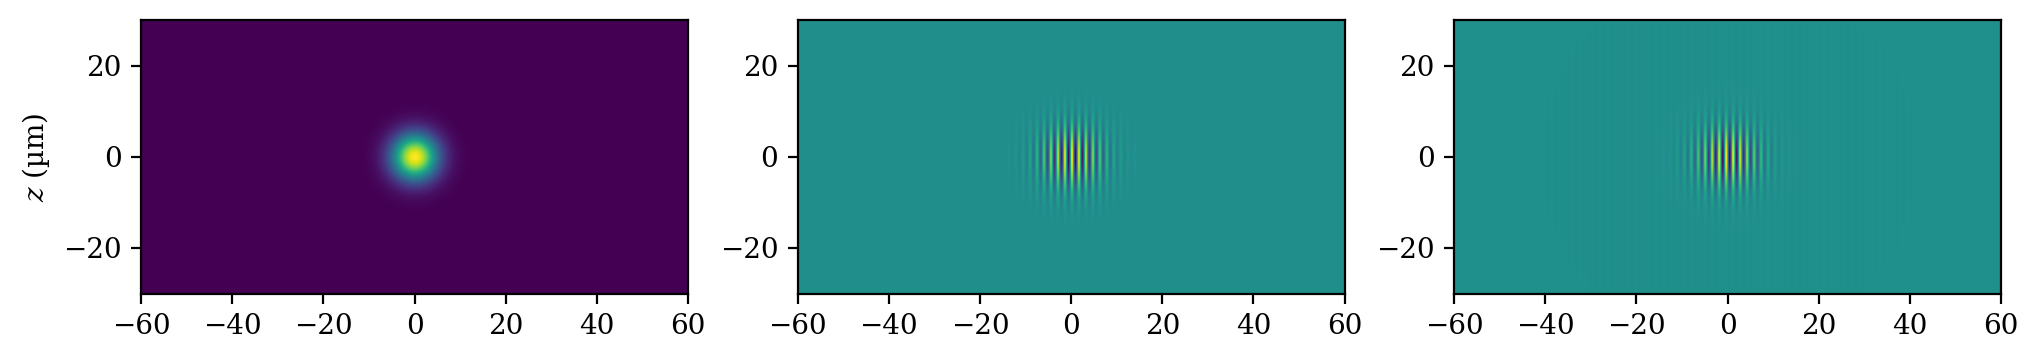

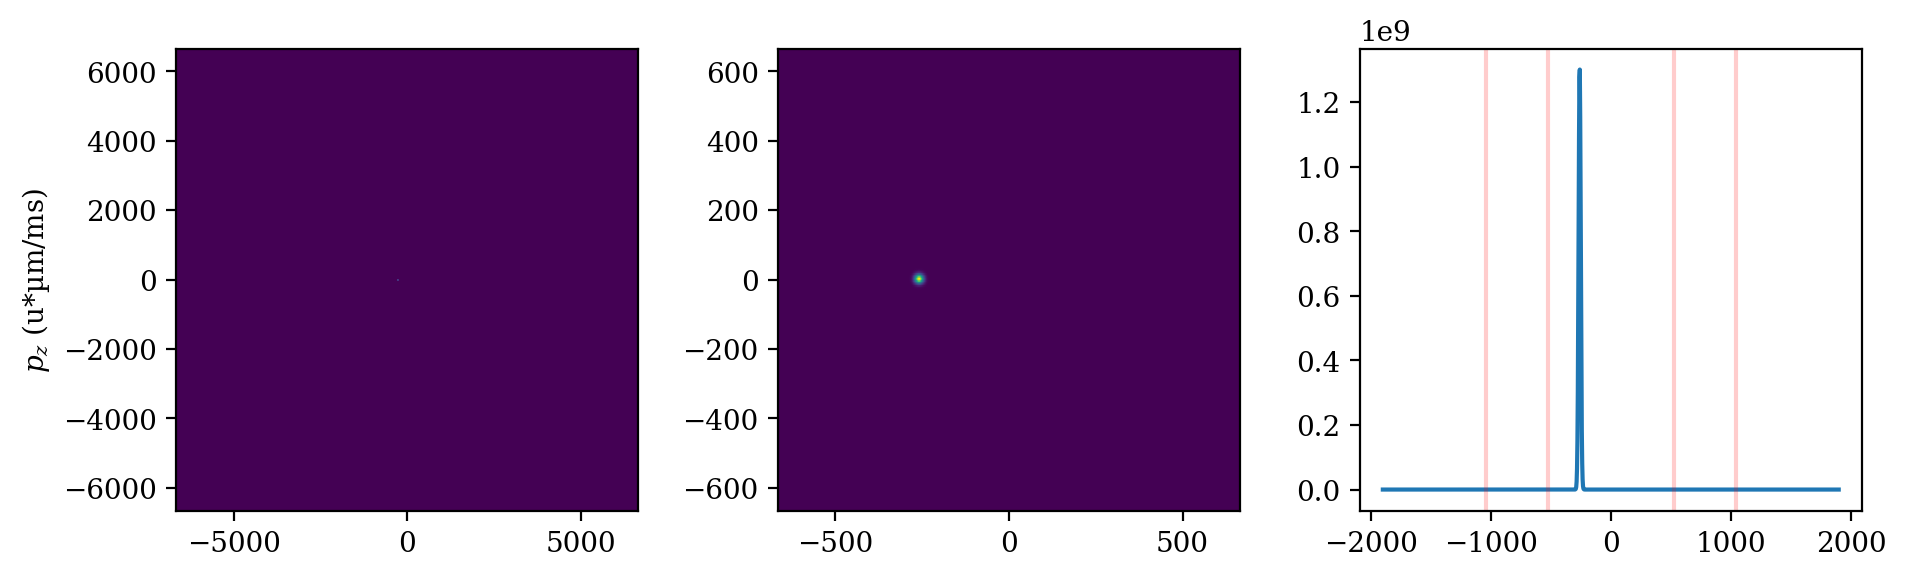

  0%|          | 0/121 [00:00<?, ?it/s]

final state at t = 1.21 µs
1.0000000000000497 |psi|^2
0.9985017481269792 |phi|^2


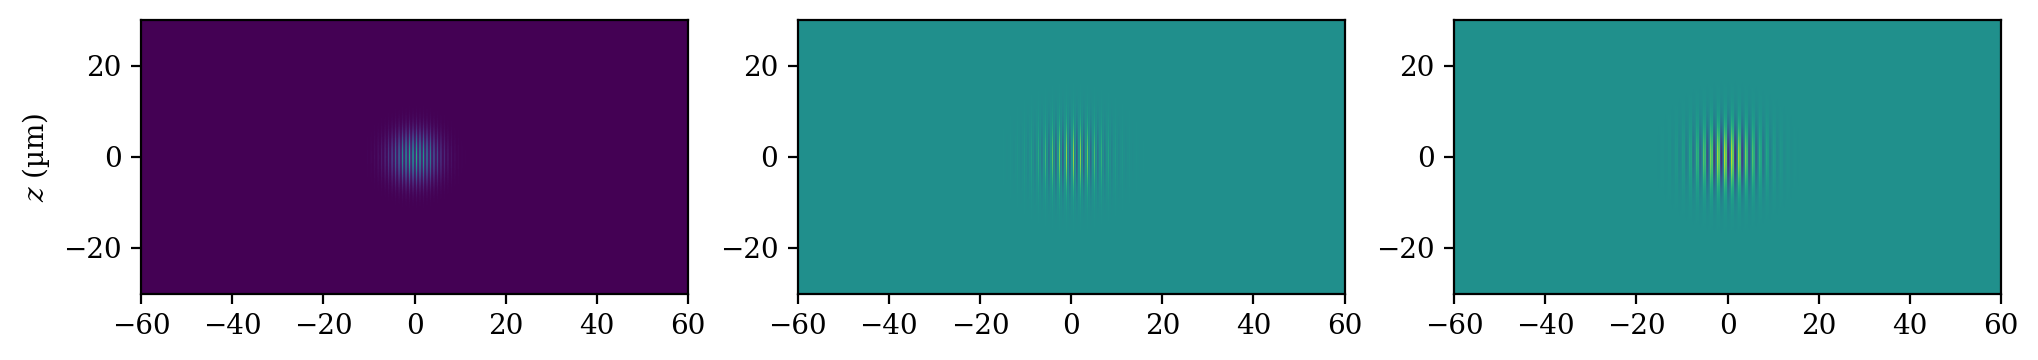

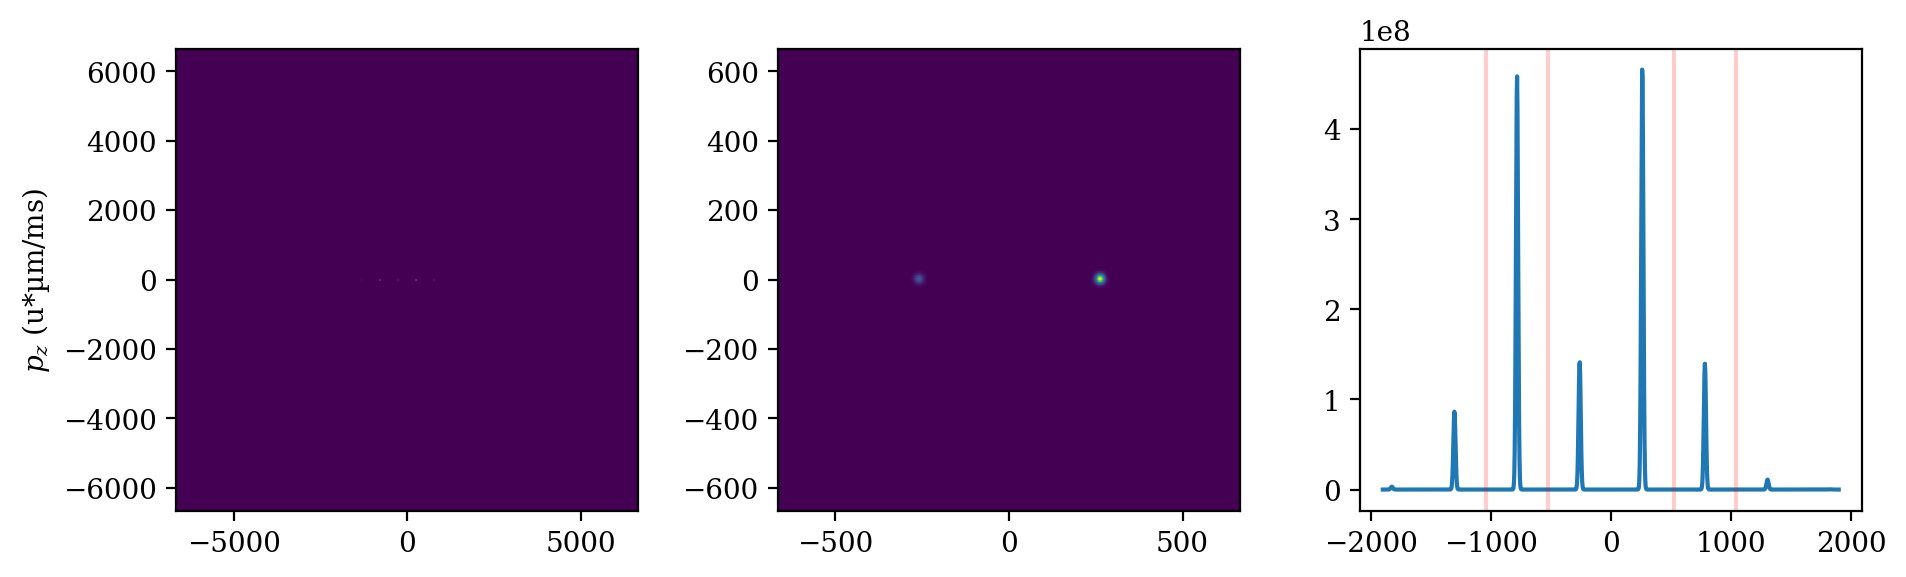

In [227]:
_ = testAngle(0*pi)
_ = testAngle(pi/4)
_ = testAngle(pi/2)
_ = testAngle(pi)

In [ ]:
print(dt)
print(dt*100)
print(dt*1000)
print(dt*1000*10)
print(dt*1000*100)